<a href="https://colab.research.google.com/github/wajason/Unified-OneHead-Multi-Task-Challenge/blob/main/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 克隆 GitHub 倉庫並切換到目錄
# 從 GitHub 倉庫下載資料、 data 資料夾

!git clone https://github.com/wajason/Unified-OneHead-Multi-Task-Challenge.git
%cd Unified-OneHead-Multi-Task-Challenge

Cloning into 'Unified-OneHead-Multi-Task-Challenge'...
remote: Enumerating objects: 1341, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 1341 (delta 40), reused 2 (delta 0), pack-reused 1273 (from 3)
Receiving objects: 100% (1341/1341), 81.26 MiB | 20.16 MiB/s, done.
Resolving deltas: 100% (66/66), done.
/content/Unified-OneHead-Multi-Task-Challenge


In [2]:
!ls -R data

data:
imagenette_160	mini_coco_det  mini_voc_seg

data/imagenette_160:
train  val

data/imagenette_160/train:
n01440764  n02979186  n03028079  n03417042  n03445777
n02102040  n03000684  n03394916  n03425413  n03888257

data/imagenette_160/train/n01440764:
n01440764_105.JPEG  n01440764_237.JPEG	n01440764_413.JPEG  n01440764_458.JPEG
n01440764_107.JPEG  n01440764_239.JPEG	n01440764_416.JPEG  n01440764_459.JPEG
n01440764_137.JPEG  n01440764_315.JPEG	n01440764_438.JPEG  n01440764_485.JPEG
n01440764_148.JPEG  n01440764_334.JPEG	n01440764_449.JPEG  n01440764_63.JPEG
n01440764_188.JPEG  n01440764_36.JPEG	n01440764_44.JPEG   n01440764_78.JPEG
n01440764_18.JPEG   n01440764_39.JPEG	n01440764_457.JPEG  n01440764_96.JPEG

data/imagenette_160/train/n02102040:
n02102040_107.JPEG  n02102040_139.JPEG	n02102040_43.JPEG  n02102040_76.JPEG
n02102040_108.JPEG  n02102040_148.JPEG	n02102040_55.JPEG  n02102040_78.JPEG
n02102040_113.JPEG  n02102040_149.JPEG	n02102040_5.JPEG   n02102040_83.JPEG
n02102040_114.J

In [9]:
# @title 統一單頭多任務挑戰實作 (最終呈現版)
# 安裝所需庫
!pip install torch torchvision torchaudio timm segmentation-models-pytorch opencv-python matplotlib scikit-learn -q
!pip install segmentation-models-pytorch -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
import timm
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import cv2 as cv
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any, Optional
from collections import OrderedDict
import random
from sklearn.metrics import confusion_matrix

# 設定設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

# VOC 顏色映射
VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
]
VOC_COLORMAP_ARRAY = np.array(VOC_COLORMAP, dtype=np.uint8)

# 定義 ReplayBuffer 類
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.buffer = []

    def add(self, data: Tuple[torch.Tensor, Any]):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self, batch_size: int) -> List[Tuple[torch.Tensor, Any]]:
        batch_size = min(batch_size, len(self.buffer))
        if batch_size <= 0 or not self.buffer:
            return []
        return random.sample(self.buffer, batch_size)

# 定義多任務數據集類
class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images = []
        self.annotations = []
        self.image_sizes = []

        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)

            image_dir = os.path.join(data_dir, 'data')
            if not os.path.exists(image_dir):
                raise FileNotFoundError(f"找不到圖片目錄 {image_dir}！")

            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            img_info_dict = {img['file_name']: {'id': img['id'], 'width': img['width'], 'height': img['height']} for img in labels_data.get('images', [])}
            ann_dict = {}
            for ann in labels_data.get('annotations', []):
                img_id = ann.get('image_id')
                if img_id is not None:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    if isinstance(ann.get('bbox'), list) and len(ann['bbox']) == 4 and ann.get('category_id') is not None:
                        ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})

            for file_name in image_files:
                img_info = img_info_dict.get(file_name)
                if img_info is not None:
                    img_id = img_info['id']
                    if img_id in ann_dict and ann_dict[img_id]:
                        full_path = os.path.join(image_dir, file_name)
                        self.images.append(full_path)
                        self.annotations.append(ann_dict[img_id])
                        self.image_sizes.append((img_info['width'], img_info['height']))

        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img_file in image_files:
                img_path = os.path.join(data_dir, img_file)
                mask_path = os.path.join(data_dir, os.path.splitext(img_file)[0] + '.png')
                if os.path.exists(mask_path):
                    try:
                        img = cv.imread(img_path)
                        if img is not None:
                            self.images.append(img_path)
                            self.annotations.append(mask_path)
                            self.image_sizes.append((img.shape[1], img.shape[0]))
                        else:
                            print(f"警告: 無法讀取圖片獲取尺寸 {img_path}，跳過。")
                    except Exception as e:
                        print(f"警告: 讀取圖片尺寸時發生錯誤 {img_path}: {e}，跳過。")

        elif task == 'cls':
            if not os.path.exists(data_dir):
                raise FileNotFoundError(f"找不到分類數據目錄：{data_dir}")
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            if not label_dirs:
                raise ValueError(f"在 {data_dir} 中未找到任何子目錄作為類別資料夾。")

            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img_file in files:
                        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                            img_path = os.path.join(root, img_file)
                            try:
                                img = cv.imread(img_path)
                                if img is not None:
                                    self.images.append(img_path)
                                    self.annotations.append(label_to_index[label])
                                    self.image_sizes.append((img.shape[1], img.shape[0]))
                                else:
                                    print(f"警告: 無法讀取圖片獲取尺寸 {img_path}，跳過。")
                            except Exception as e:
                                print(f"警告: 讀取圖片尺寸時發生錯誤 {img_path}: {e}，跳過。")

        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何有效的數據用於任務 '{self.task}'，請檢查資料結構和檔案副檔名！")
        else:
            print(f"找到 {len(self.images)} 張圖片用於任務 '{self.task}'")

    def convert_mask_rgb_to_indices(self, mask_rgb: np.ndarray) -> np.ndarray:
        if mask_rgb.ndim != 3 or mask_rgb.shape[2] != 3:
            if mask_rgb.ndim == 2:
                mask_rgb = np.repeat(mask_rgb[:, :, np.newaxis], 3, axis=2)
            else:
                raise ValueError("Input mask must be HxW or HxWx3 format")

        height, width = mask_rgb.shape[:2]
        mask_indices = np.zeros((height, width), dtype=np.int64)
        rgb_to_index = {tuple(map(int, color)): i for i, color in enumerate(VOC_COLORMAP_ARRAY)}

        mask_flat = mask_rgb.reshape(-1, 3)
        mask_indices_flat = mask_indices.reshape(-1)
        for i in range(mask_flat.shape[0]):
            pixel_color = tuple(map(int, mask_flat[i]))
            if pixel_color in rgb_to_index:
                mask_indices_flat[i] = rgb_to_index[pixel_color]

        return mask_indices

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Any]:
        img_path = self.images[idx]
        original_width, original_height = self.image_sizes[idx]
        input_size = (512, 512)

        img = cv.imread(img_path)
        if img is None:
            try:
                img_pil = Image.open(img_path).convert("RGB")
                img_resized_pil = img_pil.resize(input_size, Image.BILINEAR)
                img_resized = np.array(img_resized_pil)
            except Exception as e:
                raise ValueError(f"無法讀取或處理圖片：{img_path} - {e}")
        else:
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img_resized = cv.resize(img, input_size, interpolation=cv.INTER_LINEAR)

        img_tensor = torch.tensor(img_resized, dtype=torch.float32).permute(2, 0, 1) / 255.0
        if self.transform:
            img_tensor = self.transform(img_tensor)

        if self.task == 'seg':
            mask_path = self.annotations[idx]
            mask_rgb = cv.imread(mask_path)
            if mask_rgb is None:
                try:
                    mask_pil = Image.open(mask_path)
                    mask_rgb_pil = mask_pil.convert("RGB")
                    mask_resized_pil = mask_rgb_pil.resize(input_size, Image.NEAREST)
                    mask_resized = np.array(mask_resized_pil)
                except Exception as e:
                    raise ValueError(f"無法讀取或處理遮罩：{mask_path} - {e}")
            else:
                mask_rgb = cv.cvtColor(mask_rgb, cv.COLOR_BGR2RGB)
                mask_resized = cv.resize(mask_rgb, input_size, interpolation=cv.INTER_NEAREST)

            mask_indices = self.convert_mask_rgb_to_indices(mask_resized)
            mask_tensor = torch.tensor(mask_indices, dtype=torch.long)
            return img_tensor, mask_tensor

        elif self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)

            scale_x = input_size[0] / original_width
            scale_y = input_size[1] / original_height
            boxes[:, 0] *= scale_x
            boxes[:, 1] *= scale_y
            boxes[:, 2] *= scale_x
            boxes[:, 3] *= scale_y
            boxes[:, 0] = torch.clamp(boxes[:, 0], min=0)
            boxes[:, 1] = torch.clamp(boxes[:, 1], min=0)
            boxes[:, 2] = torch.clamp(boxes[:, 0] + boxes[:, 2], max=input_size[0]) - boxes[:, 0]
            boxes[:, 3] = torch.clamp(boxes[:, 1] + boxes[:, 3], max=input_size[1]) - boxes[:, 1]

            valid_indices = (boxes[:, 2] > 1e-2) & (boxes[:, 3] > 1e-2)
            boxes = boxes[valid_indices]
            labels = labels[valid_indices]

            target_dict = {'boxes': boxes, 'labels': labels, 'original_size': (original_width, original_height), 'resized_size': input_size}
            return img_tensor, target_dict

        elif self.task == 'cls':
            label_tensor = torch.tensor(self.annotations[idx], dtype=torch.long)
            return img_tensor, label_tensor

        else:
            print(f"Warning: Task '{self.task}' not recognized.")
            return img_tensor, None

# Define image pre-processing transform
image_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom collate function for detection
def custom_collate_det(batch: List[Tuple[torch.Tensor, Optional[Dict[str, Any]]]]) -> Tuple[torch.Tensor, List[Dict[str, torch.Tensor]]]:
    batch = [item for item in batch if item[1] is not None and isinstance(item[1], dict)]
    if not batch:
        dummy_img = torch.empty(3, 512, 512)
        return dummy_img.unsqueeze(0).repeat(0, 1, 1, 1), []
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

# Create Datasets and DataLoaders
base_dir = "/content/Unified-OneHead-Multi-Task-Challenge/data"
train_datasets = {}
val_datasets = {}

tasks_list = ['seg', 'det', 'cls']

for task in tasks_list:
    try:
        if task == 'det':
            task_data_dir = "mini_coco_det"
        elif task == 'seg':
            task_data_dir = "mini_voc_seg"
        elif task == 'cls':
            task_data_dir = "imagenette_160"
        else:
            raise ValueError(f"Unknown task: {task}")

        train_path = os.path.join(base_dir, task_data_dir, 'train')
        val_path = os.path.join(base_dir, task_data_dir, 'val')

        train_datasets[task] = MultiTaskDataset(train_path, task, image_transform)
        val_datasets[task] = MultiTaskDataset(val_path, task, image_transform)

    except ValueError as e:
        print(f"資料載入失敗 ({task} 任務): {e}")
        train_datasets[task] = []
        val_datasets[task] = []

# Create DataLoaders
train_loaders = {}
val_loaders = {}

for task in tasks_list:
    if task in train_datasets and train_datasets[task] and len(train_datasets[task]) > 0:
        collate_fn = custom_collate_det if task == 'det' else None
        train_loaders[task] = DataLoader(train_datasets[task], batch_size=4, shuffle=True, num_workers=0, collate_fn=collate_fn)
    else:
        print(f"警告: 任務 '{task}' 的訓練數據集為空或無效。將跳過此任務的訓練。")
        train_loaders[task] = []

    if task in val_datasets and val_datasets[task] and len(val_datasets[task]) > 0:
        collate_fn = custom_collate_det if task == 'det' else None
        val_loaders[task] = DataLoader(val_datasets[task], batch_size=4, shuffle=False, num_workers=0, collate_fn=collate_fn)
    else:
        print(f"警告: 任務 '{task}' 的驗證數據集為空或無效。將跳過此任務的驗證。")
        val_loaders[task] = []

# Model Definition
class MultiTaskModel(nn.Module):
    def __init__(self, C_det=10, C_seg=21, C_cls=10):
        super(MultiTaskModel, self).__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, features_only=True, norm_layer=nn.BatchNorm2d)
        feature_info = self.backbone.feature_info
        if len(feature_info.channels()) < 5:
            raise ValueError("Backbone does not return enough feature layers for FPN.")
        in_channels_list = [feature_info.channels()[i] for i in [2, 3, 4]]
        fpn_out_channels = 128
        fpn_in_keys = ['0', '1', '2']
        self.fpn = FeaturePyramidNetwork(in_channels_list, out_channels=fpn_out_channels, extra_blocks=LastLevelMaxPool())

        self.shared_conv = nn.Sequential(
            nn.Conv2d(fpn_out_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        shared_features_channels = 64

        self.det_head = nn.Conv2d(shared_features_channels, 6, kernel_size=1)
        self.seg_head = nn.Sequential(
            nn.Conv2d(shared_features_channels, C_seg, kernel_size=1),
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False)
        )
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(shared_features_channels, C_cls)
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        features = self.backbone(x)
        if len(features) < 5:
            raise RuntimeError(f"Backbone features list has unexpected length {len(features)}.")
        selected_features = OrderedDict([('0', features[2]), ('1', features[3]), ('2', features[4])])
        fpn_outputs = self.fpn(selected_features)
        shared_features_input = fpn_outputs['2']
        shared_features = self.shared_conv(shared_features_input)
        det_out = self.det_head(shared_features)
        seg_out = self.seg_head(shared_features)
        cls_out = self.cls_head(shared_features)
        return det_out, seg_out, cls_out

# Initialize Model
C_det_actual = 10
C_seg_actual = 21
C_cls_actual = 10
model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)

def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total parameters: {total_params:,} (< 8M: {total_params < 8_000_000})")

# Loss Functions
def compute_detection_loss(det_output: torch.Tensor, targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
    boxes_pred = det_output.permute(0, 2, 3, 1)
    loss = torch.tensor(0., device=det_output.device)
    valid_samples = 0
    for i in range(len(targets)):
        if not isinstance(targets[i], dict) or 'boxes' not in targets[i] or len(targets[i]['boxes']) == 0:
            continue
        target_boxes = targets[i]['boxes'].to(det_output.device)
        if boxes_pred.size(1) > 0 and boxes_pred.size(2) > 0:
            pred_cxcywh = boxes_pred[i, 0, 0, :4]
            target_cxcywh = torch.stack([target_boxes[0][0] + target_boxes[0][2] / 2, target_boxes[0][1] + target_boxes[0][3] / 2, target_boxes[0][2], target_boxes[0][3]])
            loss += nn.MSELoss()(pred_cxcywh, target_cxcywh)
            valid_samples += 1
    return loss / valid_samples if valid_samples > 0 else torch.tensor(0., device=det_output.device)

def compute_segmentation_loss(seg_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    criterion = nn.CrossEntropyLoss()
    if targets.size()[-2:] != seg_output.size()[-2:]:
        print(f"Error: Seg target size {targets.size()} does not match output size {seg_output.size()}.")
        return torch.tensor(0., device=seg_output.device)
    return criterion(seg_output, targets)

def compute_classification_loss(cls_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    criterion = nn.CrossEntropyLoss()
    return criterion(cls_output, targets)

# Evaluation Functions
def calculate_iou_np(box1: np.ndarray, box2: np.ndarray) -> float:
    x1_min, y1_min, w1, h1 = box1
    x1_max, y1_max = x1_min + w1, y1_min + h1
    x2_min, y2_min, w2, h2 = box2
    x2_max, y2_max = x2_min + w2, y2_min + h2
    x_left = max(x1_min, x2_min)
    y_top = max(y1_min, y2_min)
    x_right = min(x1_max, x2_max)
    y_bottom = min(y1_max, y2_max)
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - intersection_area
    return intersection_area / union_area if union_area > 0 else 0.0

def evaluate_segmentation(model: nn.Module, loader: DataLoader, num_classes: int = 21) -> Dict[str, float]:
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
        return {'mIoU': 0.0, 'loss': 0.0}
    model.eval()
    confusion_matrix_np = np.zeros((num_classes, num_classes), dtype=np.int64)
    total_loss = 0
    num_batches = 0
    criterion = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()
            _, seg_out, _ = model(inputs)
            loss = criterion(seg_out, targets)
            total_loss += loss.item()
            num_batches += 1
            predicted_masks = torch.argmax(seg_out, dim=1)
            if predicted_masks.size() != targets.size():
                print(f"Warning: Evaluate Seg target size {targets.size()} != predicted size {predicted_masks.size()}.")
                continue
            predicted_flat = predicted_masks.view(-1).cpu().numpy()
            targets_flat = targets.view(-1).cpu().numpy()
            try:
                cm_batch = confusion_matrix(targets_flat, predicted_flat, labels=np.arange(num_classes))
                confusion_matrix_np += cm_batch
            except ValueError as e:
                print(f"Warning: Error calculating confusion matrix for batch: {e}")
    true_positives = np.diag(confusion_matrix_np)
    false_positives = np.sum(confusion_matrix_np, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix_np, axis=1) - true_positives
    union = true_positives + false_positives + false_negatives
    iou_per_class = np.divide(true_positives.astype(np.float64), union.astype(np.float64), out=np.full(num_classes, np.nan), where=union != 0)
    valid_iou = iou_per_class[~np.isnan(iou_per_class)]
    mIoU = np.mean(valid_iou) if valid_iou.size > 0 else 0.0
    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0
    return {'mIoU': mIoU, 'loss': avg_loss}

def evaluate_detection(model: nn.Module, loader: DataLoader, iou_threshold: float = 0.5) -> Dict[str, float]:
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
        return {'mAP': 0.0, 'loss': 0.0}
    model.eval()
    total_matched_predictions = 0
    total_predictions_with_target = 0
    total_loss = 0
    num_batches = 0
    criterion = compute_detection_loss
    with torch.no_grad():
        for inputs, targets in loader:
            if inputs.size(0) == 0: continue
            inputs = inputs.to(device)
            det_out, _, _ = model(inputs)
            loss = criterion(det_out, targets)
            total_loss += loss.item() if isinstance(loss, torch.Tensor) else loss
            num_batches += 1
            boxes_pred = det_out.permute(0, 2, 3, 1)
            for i in range(inputs.size(0)):
                img_predictions = boxes_pred[i].view(-1, 6)
                conf_scores = img_predictions[:, 4]
                conf_threshold = 0.2
                confident_predictions = img_predictions[conf_scores > conf_threshold]
                if confident_predictions.size(0) == 0:
                    continue
                predicted_boxes_cxcywh = confident_predictions[:, :4]
                predicted_boxes_xywh = torch.stack([
                    predicted_boxes_cxcywh[:, 0] - predicted_boxes_cxcywh[:, 2] / 2,
                    predicted_boxes_cxcywh[:, 1] - predicted_boxes_cxcywh[:, 3] / 2,
                    predicted_boxes_cxcywh[:, 2],
                    predicted_boxes_cxcywh[:, 3]
                ], dim=1)
                if not isinstance(targets[i], dict) or 'boxes' not in targets[i] or len(targets[i]['boxes']) == 0:
                    total_predictions_with_target += confident_predictions.size(0)
                    continue
                ground_truth_boxes_xywh = targets[i]['boxes'].to(device)
                matched_preds_in_image = 0
                total_predictions_with_target += confident_predictions.size(0)
                if ground_truth_boxes_xywh.size(0) > 0:
                    for pred_box_xywh in predicted_boxes_xywh:
                        ious = [calculate_iou_np(pred_box_xywh.cpu().numpy(), gt_box_xywh.cpu().numpy()) for gt_box_xywh in ground_truth_boxes_xywh]
                        if any(iou > iou_threshold for iou in ious):
                            matched_preds_in_image += 1
                total_matched_predictions += matched_preds_in_image
    simplified_ap = total_matched_predictions / total_predictions_with_target if total_predictions_with_target > 0 else 0.0
    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0
    return {'mAP': simplified_ap, 'loss': avg_loss}

def evaluate_classification(model: nn.Module, loader: DataLoader) -> Dict[str, float]:
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
        return {'Top-1': 0.0, 'Top-5': 0.0, 'loss': 0.0}
    model.eval()
    total_samples = 0
    top1_correct = 0
    top5_correct_sum = 0 if C_cls_actual >= 5 else -1
    total_loss = 0
    num_batches = 0
    criterion = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()
            _, _, cls_out = model(inputs)
            loss = criterion(cls_out, targets)
            total_loss += loss.item()
            num_batches += 1
            _, predicted = cls_out.max(1)
            total_samples += targets.size(0)
            top1_correct += (predicted == targets).sum().item()
            if C_cls_actual >= 5:
                _, top5_preds = cls_out.topk(5, dim=1, largest=True, sorted=True)
                targets_expanded = targets.view(-1, 1)
                top5_correct_sum += (targets_expanded == top5_preds).any(dim=1).sum().item()
    metrics = {}
    metrics['Top-1'] = top1_correct / total_samples if total_samples > 0 else 0.0
    if C_cls_actual >= 5:
        metrics['Top-5'] = top5_correct_sum / total_samples if total_samples > 0 else 0.0
    else:
        metrics['Top-5'] = float('nan')
    metrics['loss'] = total_loss / num_batches if num_batches > 0 else 0.0
    return metrics

# Knowledge Distillation Loss
def knowledge_distillation_loss(student_outputs, teacher_outputs, task, fpn_outputs_student, fpn_outputs_teacher, targets, temperature=4.0, lambda_kd=1.0):
    soft_student = torch.log_softmax(student_outputs[task] / temperature, dim=1)
    soft_teacher = torch.softmax(teacher_outputs[task].detach() / temperature, dim=1)
    kl_criterion = nn.KLDivLoss(reduction='batchmean')
    loss = kl_criterion(soft_student, soft_teacher) * (temperature ** 2)
    return lambda_kd * loss

# Helper Functions
def get_loss_function(task: str):
    if task == 'det':
        return compute_detection_loss
    elif task == 'seg':
        return compute_segmentation_loss
    elif task == 'cls':
        return compute_classification_loss
    else:
        raise ValueError(f"Unknown task: {task}")

def get_eval_function(task: str):
    if task == 'det':
        return evaluate_detection
    elif task == 'seg':
        return evaluate_segmentation
    elif task == 'cls':
        return evaluate_classification
    else:
        raise ValueError(f"Unknown task: {task}")

def evaluate_model(model: nn.Module, loader: DataLoader, task: str) -> Dict[str, float]:
    if not loader or len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
        print(f"警告: 任務 '{task}' 的驗證載入器為空或無效，跳過評估。")
        if task == 'seg': return {'mIoU': 0.0, 'loss': 0.0}
        elif task == 'det': return {'mAP': 0.0, 'loss': 0.0}
        elif task == 'cls': return {'Top-1': 0.0, 'Top-5': 0.0, 'loss': 0.0}
        else: return {'loss': 0.0}
    eval_fn = get_eval_function(task)
    metrics = eval_fn(model, loader)
    return metrics

def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int,
                optimizer: optim.Optimizer, scheduler: optim.lr_scheduler._LRScheduler,
                replay_buffers: Dict[str, ReplayBuffer], tasks_order: List[str], stage: int,
                mitigation_methods: List[str],
                lwf_teacher_model: Optional[nn.Module] = None) -> Tuple[List[Dict[str, float]], List[Dict[str, float]], Dict[str, float], Optional[nn.Module]]:
    print(f"\n{'--'*20}\n開始訓練任務：{task}, 階段：{stage + 1}/{len(tasks_order)}, Epochs：{epochs}\n{'--'*20}")

    train_metrics_history: List[Dict[str, float]] = []
    val_metrics_history: List[Dict[str, float]] = []
    current_task_loss_fn = get_loss_function(task)
    current_task_eval_fn = get_eval_function(task)

    try:
        from tqdm.auto import tqdm
        use_tqdm = True
    except ImportError:
        use_tqdm = False
        print("Warning: tqdm not installed. Install with '!pip install tqdm' for progress bars.")

    teacher_model_for_next_stage = None

    for epoch in range(epochs):
        model.train()
        epoch_start_time = time.time()
        total_train_loss = 0
        total_task_loss_accumulated = 0
        total_kd_loss_accumulated = 0
        total_replay_loss_accumulated = 0
        num_train_batches = 0

        if train_loader and len(train_loader) > 0:
            train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} [{task}] Train") if use_tqdm else train_loader
            for inputs, targets in train_loader_iter:
                if inputs is None or inputs.size(0) == 0:
                    if use_tqdm: train_loader_iter.set_postfix(loss="N/A")
                    continue
                inputs = inputs.to(device)
                print(f"Debug: inputs device = {inputs.device}")

                if task == 'det':
                    targets = [t for t in targets if t is not None and isinstance(t, dict)]
                    if not targets:
                        if use_tqdm: train_loader_iter.set_postfix(loss="N/A")
                        continue
                    targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
                    targets = [t for t in targets if 'boxes' in t and t['boxes'].size(0) > 0]
                else:
                    if isinstance(targets, torch.Tensor):
                        if targets.numel() == 0:
                            if use_tqdm: train_loader_iter.set_postfix(loss="N/A")
                            continue
                        targets = targets.to(device)
                    else:
                        print(f"Warning: Unexpected targets type for task {task}")
                        if use_tqdm: train_loader_iter.set_postfix(loss="N/A")
                        continue

                optimizer.zero_grad()
                try:
                    student_det, student_seg, student_cls = model(inputs)
                    student_outputs = {'det': student_det, 'seg': student_seg, 'cls': student_cls}
                except RuntimeError as e:
                    print(f"Error in model forward: {e}")
                    if use_tqdm: train_loader_iter.set_postfix(loss="N/A")
                    continue

                primary_task_loss = current_task_loss_fn(student_outputs[task], targets)
                batch_total_loss_tensor = torch.tensor(0., device=device)

                if isinstance(primary_task_loss, torch.Tensor) and primary_task_loss.requires_grad:
                    batch_total_loss_tensor += primary_task_loss
                    total_task_loss_accumulated += primary_task_loss.item()
                elif isinstance(primary_task_loss, (float, int)):
                    total_task_loss_accumulated += primary_task_loss

                kd_loss = torch.tensor(0., device=device)
                if 'KD' in mitigation_methods and stage > 0 and lwf_teacher_model is not None:
                    lwf_teacher_model.eval()
                    with torch.no_grad():
                        teacher_inputs = inputs.to(device)
                        teacher_det, teacher_seg, teacher_cls = lwf_teacher_model(teacher_inputs)
                        teacher_outputs = {'det': teacher_det, 'seg': teacher_seg, 'cls': teacher_cls}
                        teacher_features = lwf_teacher_model.backbone(teacher_inputs)
                        teacher_selected_features = OrderedDict()
                        if len(teacher_features) > 4:
                            teacher_selected_features['0'] = teacher_features[2]
                            teacher_selected_features['1'] = teacher_features[3]
                            teacher_selected_features['2'] = teacher_features[4]
                        else:
                            for i, feat in enumerate(teacher_features):
                                teacher_selected_features[str(i)] = feat
                        fpn_outputs_teacher = lwf_teacher_model.fpn(teacher_selected_features) if teacher_selected_features else {}

                    student_features = model.backbone(inputs)
                    student_selected_features = OrderedDict()
                    if len(student_features) > 4:
                        student_selected_features['0'] = student_features[2]
                        student_selected_features['1'] = student_features[3]
                        student_selected_features['2'] = student_features[4]
                    else:
                        for i, feat in enumerate(student_features):
                            student_selected_features[str(i)] = feat
                    fpn_outputs_student = model.fpn(student_selected_features) if student_selected_features else {}

                    kd_targets = targets
                    if task == 'det':
                        kd_targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
                    elif isinstance(targets, torch.Tensor):
                        kd_targets = targets.to(device)

                    task_kd_loss = knowledge_distillation_loss(
                        student_outputs={task: student_outputs[task]},
                        teacher_outputs={task: teacher_outputs[task]},
                        task=task,
                        fpn_outputs_student=fpn_outputs_student,
                        fpn_outputs_teacher=fpn_outputs_teacher,
                        targets=kd_targets
                    )
                    if isinstance(task_kd_loss, torch.Tensor) and task_kd_loss.requires_grad:
                        batch_total_loss_tensor += task_kd_loss * 0.5
                        total_kd_loss_accumulated += task_kd_loss.item() * 0.5
                    elif isinstance(task_kd_loss, (float, int)):
                        total_kd_loss_accumulated += task_kd_loss * 0.5

                replay_batch_size_per_task = train_loader.batch_size // (stage + 1) if stage > 0 else 0
                total_replay_samples = 0
                replay_loss_tensor = torch.tensor(0., device=device)
                replay_loss_float_accumulated = 0.0

                for prev_task in tasks_order[:stage]:
                    if prev_task in replay_buffers and len(replay_buffers[prev_task].buffer) > 0 and replay_batch_size_per_task > 0:
                        buffer_samples = replay_buffers[prev_task].sample(batch_size=replay_batch_size_per_task)
                        print(f"Debug: buffer_samples for {prev_task} = {len(buffer_samples)}")  # 調試輸出
                        if buffer_samples:
                            if prev_task == 'det':
                                buffer_samples = [s for s in buffer_samples if s[1] is not None and isinstance(s[1], dict) and 'boxes' in s[1] and len(s[1]['boxes']) > 0]
                                if not buffer_samples:
                                    print(f"Debug: No valid det samples for {prev_task}")
                                    continue
                                replay_inputs, replay_targets = custom_collate_det(buffer_samples)
                                replay_targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in replay_targets]
                            else:
                                buffer_samples = [s for s in buffer_samples if s[1] is not None and isinstance(s[1], torch.Tensor)]
                                if not buffer_samples:
                                    print(f"Debug: No valid samples for {prev_task}")
                                    continue
                                replay_inputs = torch.stack([s[0] for s in buffer_samples])
                                if replay_inputs.dim() != 4 or replay_inputs.size(1) != 3:  # 檢查張量維度
                                    print(f"Debug: Invalid replay_inputs shape {replay_inputs.shape} for {prev_task}")
                                    continue
                                replay_inputs = replay_inputs.to(device)  # 強制轉換到 GPU
                                replay_targets = torch.stack([s[1] for s in buffer_samples]).to(device)
                                if replay_targets.numel() == 0:
                                    print(f"Debug: Empty replay_targets for {prev_task}")
                                    continue
                            print(f"Debug: replay_inputs device = {replay_inputs.device}")  # 調試輸出

                            if replay_inputs.size(0) > 0:
                                total_replay_samples += replay_inputs.size(0)
                                r_det_out, r_seg_out, r_cls_out = model(replay_inputs)
                                r_outputs = {'det': r_det_out, 'seg': r_seg_out, 'cls': r_cls_out}
                                task_replay_loss = get_loss_function(prev_task)(r_outputs[prev_task], replay_targets)
                                if isinstance(task_replay_loss, torch.Tensor) and task_replay_loss.requires_grad:
                                    replay_loss_tensor += task_replay_loss
                                elif isinstance(task_replay_loss, (float, int)) and task_replay_loss > 0:
                                    replay_loss_float_accumulated += task_replay_loss

                if total_replay_samples > 0:
                    if isinstance(replay_loss_tensor, torch.Tensor) and replay_loss_tensor.requires_grad:
                        avg_replay_loss_tensor_for_backprop = replay_loss_tensor / total_replay_samples
                        batch_total_loss_tensor += avg_replay_loss_tensor_for_backprop
                    total_replay_loss_accumulated += replay_loss_float_accumulated

                if isinstance(batch_total_loss_tensor, torch.Tensor) and batch_total_loss_tensor.requires_grad and torch.isfinite(batch_total_loss_tensor).all():
                    if batch_total_loss_tensor.item() >= 0:
                        batch_total_loss_tensor.backward()
                        optimizer.step()
                        total_train_loss += batch_total_loss_tensor.item()
                        num_train_batches += 1
                    else:
                        print(f"Warning: Batch total loss is negative ({batch_total_loss_tensor.item():.4f}). Skipping backprop.")
                        total_train_loss += batch_total_loss_tensor.item()
                        num_train_batches += 1
                elif (isinstance(batch_total_loss_tensor, torch.Tensor) and not batch_total_loss_tensor.requires_grad and torch.isfinite(batch_total_loss_tensor).all()) or isinstance(batch_total_loss_tensor, (float, int)):
                    total_train_loss += batch_total_loss_tensor.item() if isinstance(batch_total_loss_tensor, torch.Tensor) else batch_total_loss_tensor
                    num_train_batches += 1

                if len(inputs) > 0 and (task != 'det' or (task == 'det' and len(targets) > 0)):
                    detached_inputs = inputs.detach().cpu()
                    if task == 'det':
                        detached_targets = [{k: (v.detach().cpu() if isinstance(v, torch.Tensor) else v) for k, v in t.items()} for t in targets]
                    elif isinstance(targets, torch.Tensor):
                        detached_targets = targets.detach().cpu()
                    else:
                        detached_targets = targets
                    for i in range(detached_inputs.size(0)):
                        if task == 'det' and i < len(detached_targets):
                            replay_buffers[task].add((detached_inputs[i], detached_targets[i]))
                        elif task != 'det' and i < detached_inputs.size(0):
                            replay_buffers[task].add((detached_inputs[i], detached_targets[i]))

                if use_tqdm:
                    batch_loss_display = batch_total_loss_tensor.item() if isinstance(batch_total_loss_tensor, torch.Tensor) else batch_total_loss_tensor
                    train_loader_iter.set_postfix(loss=f"{batch_loss_display:.4f}")

        avg_train_loss = total_train_loss / num_train_batches if num_train_batches > 0 else 0.0
        avg_task_loss = total_task_loss_accumulated / num_train_batches if num_train_batches > 0 else 0.0
        avg_kd_loss = total_kd_loss_accumulated / num_train_batches if num_train_batches > 0 else 0.0
        avg_replay_loss = total_replay_loss_accumulated / num_train_batches if num_train_batches > 0 else 0.0

        model.eval()
        train_metrics = evaluate_model(model, train_loader, task) if train_loader and len(train_loader) > 0 else {'loss': avg_train_loss}
        train_metrics['loss'] = avg_train_loss
        val_metrics = evaluate_model(model, val_loader, task) if val_loader and len(val_loader) > 0 else {'loss': 0.0}
        val_metrics['train_loss'] = avg_train_loss

        train_metrics_history.append(train_metrics)
        val_metrics_history.append(val_metrics)

        metric_key_for_print_train = 'mIoU' if task == 'seg' else ('mAP' if task == 'det' else 'Top-1')
        train_metric_value_for_print = train_metrics.get(metric_key_for_print_train, 0.0)
        mitigation_info = [f"KD: {avg_kd_loss:.4f}"] if 'KD' in mitigation_methods and stage > 0 else []
        if stage > 0 and num_train_batches > 0 and avg_replay_loss > 0:
            mitigation_info.append(f"Replay: {avg_replay_loss:.4f}")
        mitigation_str = f" (Mitigation: {', '.join(mitigation_info)})" if mitigation_info else ""

        if metric_key_for_print_train in train_metrics:
            print(f"Epoch {epoch + 1}/{epochs}, Task {task} | Train Loss: {avg_train_loss:.4f} | Train {metric_key_for_print_train}: {train_metric_value_for_print:.4f}{mitigation_str}")
        else:
            print(f"Epoch {epoch + 1}/{epochs}, Task {task} | Train Loss: {avg_train_loss:.4f}{mitigation_str}")

        val_loss_for_print = val_metrics.get('loss', float('nan'))
        metric_key_for_print_val = 'mIoU' if task == 'seg' else ('mAP' if task == 'det' else 'Top-1')
        metric_value_for_print_val = val_metrics.get(metric_key_for_print_val, 0.0)
        metric_output_str = f"評估結果 - Epoch {epoch + 1}/{epochs}, Task {task}: Val Loss={val_loss_for_print:.4f}"
        if task == 'seg':
            metric_output_str += f", Val mIoU={metric_value_for_print_val:.4f}"
        elif task == 'det':
            metric_output_str += f", Val mAP={metric_value_for_print_val:.4f}"
        elif task == 'cls':
            top1_val = val_metrics.get('Top-1', 0.0)
            top5_val = val_metrics.get('Top-5', float('nan'))
            top5_str = f"Top-5={top5_val:.4f}" if not np.isnan(top5_val) else "Top-5: N/A"
            metric_output_str += f", Val Top-1={top1_val:.4f}, Val {top5_str}"
        if val_loader and len(val_loader) > 0:
            print(metric_output_str)
        else:
            print(f"Epoch {epoch + 1}/{epochs}, Task {task}: Validation skipped due to empty/invalid loader.")

        scheduler.step()

    teacher_model_for_next_stage = copy.deepcopy(model) if stage < len(tasks_order) - 1 else None
    if teacher_model_for_next_stage:
        teacher_model_for_next_stage.eval()

    return train_metrics_history, val_metrics_history, val_metrics_history[-1] if val_metrics_history else {}, teacher_model_for_next_stage

# Main Training Loop
mitigation_methods = ['KD']
EPOCHS_PER_TASK = 1  # 調整為 8 回合
tasks_order = ['seg', 'det', 'cls']

method_results = {
    method: {task: {'final_metrics_after_all_stages': {}, 'train_metrics_history_per_epoch': [], 'val_metrics_history_per_epoch': [], 'baseline_metric': None} for task in tasks_order}
    for method in mitigation_methods
}

best_composite_score = -float('inf')
best_strategy_name_overall = None
best_model_state_dict_overall = None
composite_weights = {'seg': 0.4, 'det': 0.4, 'cls': 0.2}

start_overall_time = time.time()

for method in mitigation_methods:
    print(f"\n\n{'='*50}\n=== 使用抗災難性遺忘策略：{method} ===\n{'='*50}")

    model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.0008, weight_decay=1e-4)
    total_strategy_epochs = len(tasks_order) * EPOCHS_PER_TASK
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_strategy_epochs)

    replay_buffers = {task: ReplayBuffer(capacity=50) for task in tasks_order}
    lwf_teacher_model = None

    for stage, task in enumerate(tasks_order):
        if 'KD' in mitigation_methods and stage > 0:
            print(f"創建階段 {stage} 的教師模型用於 KD...")
            lwf_teacher_model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)
            lwf_teacher_model.load_state_dict(model.state_dict())
            lwf_teacher_model.eval()

        current_train_loader = train_loaders.get(task)
        current_val_loader = val_loaders.get(task)

        if not current_train_loader or len(current_train_loader) == 0:
            print(f"跳過任務 '{task}' 的訓練，因為訓練載入器為空或無效。")
            method_results[method][task]['final_metrics_after_all_stages'] = {f'{task}_metric': 0.0}
            method_results[method][task]['train_metrics_history_per_epoch'] = []
            method_results[method][task]['val_metrics_history_per_epoch'] = []
            method_results[method][task]['baseline_metric'] = 0.0
            continue

        train_metrics_history, val_metrics_history, final_metrics_of_stage, _ = train_stage(
            model,
            current_train_loader,
            current_val_loader,
            task,
            epochs=EPOCHS_PER_TASK,
            optimizer=optimizer,
            scheduler=scheduler,
            replay_buffers=replay_buffers,
            tasks_order=tasks_order,
            stage=stage,
            mitigation_methods=[method],
            lwf_teacher_model=lwf_teacher_model
        )

        if task == 'seg':
            baseline_key = 'mIoU'
        elif task == 'det':
            baseline_key = 'mAP'
        elif task == 'cls':
            baseline_key = 'Top-1'
        else:
            baseline_key = 'unknown_metric'

        baseline_value = final_metrics_of_stage.get(baseline_key, 0.0)
        method_results[method][task]['baseline_metric'] = baseline_value
        method_results[method][task]['train_metrics_history_per_epoch'] = train_metrics_history
        method_results[method][task]['val_metrics_history_per_epoch'] = val_metrics_history

        if lwf_teacher_model is not None:
            del lwf_teacher_model
            torch.cuda.empty_cache()

    print(f"\n\n{'='*50}\n=== {method} 的最終評估 (在所有任務訓練後) ===\n{'='*50}")
    final_metrics_after_all_stages_for_method = {}

    for task in tasks_order:
        current_val_loader = val_loaders.get(task)
        metrics = evaluate_model(model, current_val_loader, task)
        metric_output_str = f"最終 {task} 評估:"
        if task == 'seg':
            metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, mIoU={metrics.get('mIoU', 0.0):.4f}"
        elif task == 'det':
            metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, mAP={metrics.get('mAP', 0.0):.4f}"
        elif task == 'cls':
            top1_str = f"Top-1={metrics.get('Top-1', 0.0):.4f}"
            top5_str = f"Top-5={metrics.get('Top-5', float('nan')):.4f}" if 'Top-5' in metrics and not np.isnan(metrics['Top-5']) else "Top-5: N/A"
            metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, {top1_str}, {top5_str}"
        print(metric_output_str)
        final_metrics_after_all_stages_for_method[task] = metrics
        method_results[method][task]['final_metrics_after_all_stages'] = metrics

    # 繪製性能趨勢圖
    try:
        def plot_performance_trends(method_results_entry, method_name, epochs_per_stage, tasks_order):
            plt.figure(figsize=(18, 6))
            for i, task in enumerate(tasks_order, 1):
                task_data = method_results_entry.get(task)
                if not task_data:
                    continue
                val_history = task_data.get('val_metrics_history_per_epoch', [])
                if not val_history:
                    continue
                plt.subplot(1, len(tasks_order), i)
                metric_key = 'mIoU' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1'
                metric_values = [m.get(metric_key, 0.0) for m in val_history]
                start_global_epoch = tasks_order.index(task) * epochs_per_stage + 1
                global_epochs = list(range(start_global_epoch, start_global_epoch + len(metric_values)))
                if global_epochs:
                    plt.plot(global_epochs, metric_values, marker='o', linestyle='-', label=f'{task} Val {metric_key}')
                baseline_value = task_data.get('baseline_metric', None)
                if baseline_value is not None:
                    plt.axhline(y=baseline_value, color='g', linestyle='--', label=f'{task} Baseline')
                final_metric_value = task_data.get('final_metrics_after_all_stages', {}).get(metric_key, None)
                if final_metric_value is not None:
                    plt.axhline(y=final_metric_value, color='r', linestyle='-', label=f'{task} Final')
                plt.title(f'{task} Validation Metric')
                plt.xlabel('Global Epoch')
                plt.ylabel(metric_key)
                plt.legend()
                plt.grid(True)
                plt.ylim(0, 1.0)
            plt.tight_layout()
            plt.suptitle(f'Performance Metrics per Task ({method_name})', y=1.02, fontsize=16)
            plt.show()

        plot_performance_trends(method_results[method], method, EPOCHS_PER_TASK, tasks_order)

    except ImportError:
        print("Matplotlib 未安裝，跳過繪圖。")

    # 繪製最終性能比較條形圖
    try:
        def plot_final_comparison(method_results, metric_keys, tasks_order):
            plt.figure(figsize=(12, 7))
            num_methods = len(mitigation_methods)
            bar_width = 0.2
            index = np.arange(len(tasks_order))
            colors = plt.cm.get_cmap('tab10', num_methods)
            for i, method in enumerate(mitigation_methods):
                seg_final = method_results[method]['seg']['final_metrics_after_all_stages'].get(metric_keys['seg'], 0.0)
                det_final = method_results[method]['det']['final_metrics_after_all_stages'].get(metric_keys['det'], 0.0)
                cls_final = method_results[method]['cls']['final_metrics_after_all_stages'].get(metric_keys['cls'], 0.0)
                final_values = [seg_final, det_final, cls_final]
                plt.bar(index + i * bar_width, final_values, bar_width, label=method, color=colors(i))
            plt.xlabel('Task')
            plt.ylabel('Metric Value')
            plt.title('Final Performance Comparison Across Strategies')
            plt.xticks(index + bar_width * (num_methods - 1) / 2, tasks_order)
            plt.legend()
            plt.grid(axis='y')
            plt.ylim(0, 1.0)
            plt.tight_layout()
            plt.show()

        plot_final_comparison(method_results, {'seg': 'mIoU', 'det': 'mAP', 'cls': 'Top-1'}, tasks_order)

    except ImportError:
        print("Matplotlib 未安裝，跳過繪製最終比較圖.")

    # 繪製 1~30 回合的驗證集評估分數圖表
    try:
        def plot_validation_metrics_overall(method_results_entry, method_name, epochs_per_task, tasks_order):
            plt.figure(figsize=(12, 6))
            global_epochs = []
            mIoU_values = []
            mAP_values = []
            top1_values = []
            for task_idx, task in enumerate(tasks_order):
                task_data = method_results_entry.get(task)
                if not task_data:
                    continue
                val_history = task_data.get('val_metrics_history_per_epoch', [])
                if not val_history:
                    continue
                start_global_epoch = task_idx * epochs_per_task + 1
                for epoch_idx, metrics in enumerate(val_history):
                    global_epoch = start_global_epoch + epoch_idx
                    global_epochs.append(global_epoch)
                    if task == 'seg':
                        mIoU_values.append(metrics.get('mIoU', 0.0))
                        mAP_values.append(0.0)
                        top1_values.append(0.0)
                    elif task == 'det':
                        mIoU_values.append(0.0)
                        mAP_values.append(metrics.get('mAP', 0.0))
                        top1_values.append(0.0)
                    elif task == 'cls':
                        mIoU_values.append(0.0)
                        mAP_values.append(0.0)
                        top1_values.append(metrics.get('Top-1', 0.0))
            plt.plot(global_epochs, mIoU_values, marker='o', linestyle='-', label='mIoU (Seg)')
            plt.plot(global_epochs, mAP_values, marker='o', linestyle='-', label='mAP (Det)')
            plt.plot(global_epochs, top1_values, marker='o', linestyle='-', label='Top-1 (Cls)')
            plt.title('Validation Metrics Across All Tasks (1-30 Epochs)')
            plt.xlabel('Global Epoch')
            plt.ylabel('Metric Value')
            plt.legend()
            plt.grid(True)
            plt.ylim(0, 1.0)
            plt.xticks(range(1, 31, 2))
            plt.tight_layout()
            plt.show()

        plot_validation_metrics_overall(method_results[method], method, EPOCHS_PER_TASK, tasks_order)

    except ImportError:
        print("Matplotlib 未安裝，跳過繪製 1~30 回合驗證集評估分數圖表。")

    # 顯示每個任務的訓練與驗證評估指標表格
    try:
        def print_task_metrics_table(method_results_entry, task, epochs_per_task):
            task_data = method_results_entry.get(task)
            if not task_data:
                print(f"無 {task} 任務數據可用。")
                return
            val_history = task_data.get('val_metrics_history_per_epoch', [])
            train_history = task_data.get('train_metrics_history_per_epoch', [])
            metric_key = 'mIoU' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1'
            print(f"\n{'='*50}\n=== {task} 任務訓練與驗證指標 (共 {epochs_per_task} 回合) ===\n{'='*50}")
            print(f"| Epoch | Train Loss | Train {metric_key} | Val Loss | Val {metric_key} |")
            print(f"|-------|------------|----------------|----------|----------------|")
            for epoch in range(min(epochs_per_task, len(val_history))):
                train_metrics = train_history[epoch] if epoch < len(train_history) else {'loss': 0.0, metric_key: 0.0}
                val_metrics = val_history[epoch] if epoch < len(val_history) else {'loss': 0.0, metric_key: 0.0}
                train_loss = train_metrics.get('loss', 0.0)
                train_metric = train_metrics.get(metric_key, 0.0)
                val_loss = val_metrics.get('loss', 0.0)
                val_metric = val_metrics.get(metric_key, 0.0)
                print(f"| {epoch + 1:5d} | {train_loss:.4f} | {train_metric:.4f} | {val_loss:.4f} | {val_metric:.4f} |")

        for task in tasks_order:
            print_task_metrics_table(method_results[method], task, EPOCHS_PER_TASK)

    except ImportError:
        print("無法生成表格，缺少必要的庫。")

# 比較表格
print("\n\n{'='*50}\n=== 抗災難性遺忘策略比較 (最終評估與下降) ===\n{'='*50}")
metric_keys_table = {'seg': 'mIoU', 'det': 'mAP', 'cls': 'Top-1'}
table_header = "| Strategy | Seg mIoU | Seg Drop (%) | Det mAP | Det Drop (%) | Cls Top-1 | Cls Drop (%) |\n"
table_separator = "|----------|----------|--------------|---------|--------------|-----------|--------------|\n"
table = table_header + table_separator
best_strategy_name_for_table = None
best_composite_score_for_table = -float('inf')
composite_weights_table = {'seg': 0.4, 'det': 0.4, 'cls': 0.2}

for method in mitigation_methods:
    seg_data = method_results[method]['seg']
    det_data = method_results[method]['det']
    cls_data = method_results[method]['cls']
    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys_table['seg'], 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys_table['det'], 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys_table['cls'], 0.0)
    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0
    seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0
    current_composite_score_table = (composite_weights_table['seg'] * seg_final + composite_weights_table['det'] * det_final + composite_weights_table['cls'] * cls_final)
    if current_composite_score_table > best_composite_score_for_table:
        best_composite_score_for_table = current_composite_score_table
        best_strategy_name_for_table = method
    table += f"| {method:<8} | {seg_final:<8.4f} | {seg_drop_pct:<12.2f} | {det_final:<7.4f} | {det_drop_pct:<12.2f} | {cls_final:<9.4f} | {cls_drop_pct:<12.2f} |\n"

print(table)
print(f"\n最佳策略（基於最終綜合得分，權重 Seg:{composite_weights_table['seg']:.3f}, Det:{composite_weights_table['det']:.3f}, Cls:{composite_weights_table['cls']:.3f}）：{best_strategy_name_for_table} （得分：{best_composite_score_for_table:.4f}）")

# 檢查最終條件和分數計算
print("\n\n{'='*50}\n=== 條件檢查和分數計算 ===\n{'='*50}")
best_results = method_results.get(best_strategy_name_for_table, None)
score = 0
if best_results:
    seg_data = best_results['seg']
    det_data = best_results['det']
    cls_data = best_results['cls']
    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys_table['seg'], 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys_table['det'], 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys_table['cls'], 0.0)
    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0
    seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0
    all_within_drop = (seg_drop_pct <= 5.0) and (det_drop_pct <= 5.0) and (cls_drop_pct <= 5.0)
    print(f"\n檢查最佳策略 '{best_strategy_name_for_table}' 的性能下降:")
    print(f" - Seg {metric_keys_table['seg']} 下降: {seg_drop_pct:.2f}% (<= 5%) -> {'Pass' if seg_drop_pct <= 5.0 else 'Fail'}")
    print(f" - Det {metric_keys_table['det']} 下降: {det_drop_pct:.2f}% (<= 5%) -> {'Pass' if det_drop_pct <= 5.0 else 'Fail'}")
    print(f" - Cls {metric_keys_table['cls']} 下降: {cls_drop_pct:.2f}% (<= 5%) -> {'Pass' if cls_drop_pct <= 5.0 else 'Fail'}")
    print(f"所有任務下降是否都在 5% 以內: {'Yes' if all_within_drop else 'No'}")
    score_components = {
        'seg': min(0.4, seg_final * 0.4 / 0.5) if seg_final <= 0.5 else 0.4,
        'det': min(0.4, det_final * 0.4 / 0.5) if det_final <= 0.5 else 0.4,
        'cls': min(0.2, cls_final * 0.2 / 0.6) if cls_final <= 0.6 else 0.2
    }
    score = sum(score_components.values())
    if all_within_drop:
        score += 0.1
    else:
        score = max(0.0, score - 0.1)
    print(f"\n最終分數計算（基於 {best_strategy_name_for_table} 的最終性能）:")
    print(f" - Seg mIoU 貢獻: {score_components['seg']:.4f}")
    print(f" - Det mAP 貢獻: {score_components['det']:.4f}")
    print(f" - Cls Top-1 貢獻: {score_components['cls']:.4f}")
    if all_within_drop:
        print(f" - 下降控制獎勵: +0.1")
    else:
        print(f" - 下降控制懲罰: -0.1")
    print(f"總分: {score:.4f} / 1.0")
    challenge_threshold = 0.7
    print(f"是否達到挑戰門檻 ({challenge_threshold}): {'Yes' if score >= challenge_threshold else 'No'}")

end_overall_time = time.time()
print(f"\n{'='*50}\n=== 總訓練完成 ===\n{'='*50}")
print(f"總耗時: {end_overall_time - start_overall_time:.2f} 秒")

使用設備：cuda
找到 240 張圖片用於任務 'seg'
找到 60 張圖片用於任務 'seg'
找到 240 張圖片用於任務 'det'
找到 60 張圖片用於任務 'det'
找到 240 張圖片用於任務 'cls'
找到 60 張圖片用於任務 'cls'


Total parameters: 4,175,137 (< 8M: True)


=== 使用抗災難性遺忘策略：KD ===



----------------------------------------
開始訓練任務：seg, 階段：1/3, Epochs：1
----------------------------------------


Epoch 1/1 [seg] Train:   0%|          | 0/60 [00:00<?, ?it/s]

Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: inp


----------------------------------------
開始訓練任務：det, 階段：2/3, Epochs：1
----------------------------------------


Epoch 1/1 [det] Train:   0%|          | 0/60 [00:00<?, ?it/s]

Debug: inputs device = cuda:0
Debug: buffer_samples for seg = 2
Debug: replay_inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: buffer_samples for seg = 2
Debug: replay_inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: buffer_samples for seg = 2
Debug: replay_inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: buffer_samples for seg = 2
Debug: replay_inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: buffer_samples for seg = 2
Debug: replay_inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: buffer_samples for seg = 2
Debug: replay_inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: buffer_samples for seg = 2
Debug: replay_inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: buffer_samples for seg = 2
Debug: replay_inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: buffer_samples for seg = 2
Debug: replay_inputs device = cuda:0
Debug: inputs device = cuda:0
Debug: buffer_samples for seg = 2
Debug: replay_inputs device

創建階段 2 的教師模型用於 KD...

----------------------------------------
開始訓練任務：cls, 階段：3/3, Epochs：1
----------------------------------------


Epoch 1/1 [cls] Train:   0%|          | 0/60 [00:00<?, ?it/s]

Debug: inputs device = cuda:0
Debug: buffer_samples for seg = 1
Debug: replay_inputs device = cuda:0
Debug: buffer_samples for det = 1
Debug: replay_inputs device = cpu


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 14.9 MB/s eta 0:00:00


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


使用設備：cuda


100%|██████████| 9.83M/9.83M [00:00<00:00, 56.6MB/s]



=== 訓練階段 1: seg ===
Epoch 1/50, seg 平均損失: 0.2460
驗證指標 - seg: mIoU=0.1427
Epoch 5/50, seg 平均損失: 0.2428
驗證指標 - seg: mIoU=0.1427
Epoch 10/50, seg 平均損失: 0.2349
驗證指標 - seg: mIoU=0.1427
Epoch 15/50, seg 平均損失: 0.2452
驗證指標 - seg: mIoU=0.1427
Epoch 20/50, seg 平均損失: 0.2421
驗證指標 - seg: mIoU=0.1427
Epoch 25/50, seg 平均損失: 0.2484
驗證指標 - seg: mIoU=0.1427
Epoch 30/50, seg 平均損失: 0.2484
驗證指標 - seg: mIoU=0.1427
Epoch 35/50, seg 平均損失: 0.2389
驗證指標 - seg: mIoU=0.1427
Epoch 40/50, seg 平均損失: 0.2475
驗證指標 - seg: mIoU=0.1427
Epoch 45/50, seg 平均損失: 0.2468
驗證指標 - seg: mIoU=0.1427
Epoch 50/50, seg 平均損失: 0.2396
驗證指標 - seg: mIoU=0.1427
階段 1 完成，耗時 610.46 秒

=== 訓練階段 2: det ===
Epoch 1/50, det 平均損失: 1.0000
驗證指標 - det: mAP=0.3366
Epoch 5/50, det 平均損失: 1.0000
驗證指標 - det: mAP=0.3983
Epoch 10/50, det 平均損失: 1.0000
驗證指標 - det: mAP=0.6566
Epoch 15/50, det 平均損失: 1.0000
驗證指標 - det: mAP=0.5077
Epoch 20/50, det 平均損失: 1.0000
驗證指標 - det: mAP=0.4327
Epoch 25/50, det 平均損失: 1.0000
驗證指標 - det: mAP=0.5291
Epoch 30/50, det 平均損失: 1.0000


<ipython-input-2-22529686c96b>:278: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(intersection / union if union > 0 else 0.0, device=device)


Epoch 5/50, cls 平均損失: 2.4663
驗證指標 - cls: Top-1=0.1500
Epoch 10/50, cls 平均損失: 2.3859
驗證指標 - cls: Top-1=0.1333
Epoch 15/50, cls 平均損失: 2.3120
驗證指標 - cls: Top-1=0.1000
Epoch 20/50, cls 平均損失: 2.3057
驗證指標 - cls: Top-1=0.1000
Epoch 25/50, cls 平均損失: 2.3058
驗證指標 - cls: Top-1=0.1000
Epoch 30/50, cls 平均損失: 2.3040
驗證指標 - cls: Top-1=0.1000
Epoch 35/50, cls 平均損失: 2.3031
驗證指標 - cls: Top-1=0.1167
Epoch 40/50, cls 平均損失: 2.2867
驗證指標 - cls: Top-1=0.1000
Epoch 45/50, cls 平均損失: 2.1473
驗證指標 - cls: Top-1=0.1667
Epoch 50/50, cls 平均損失: 1.9672
驗證指標 - cls: Top-1=0.2000
階段 3 完成，耗時 656.94 秒

=== 總訓練時間：1788.21 秒 ===

=== 最終評估 ===
seg 最終評估: mIoU=0.1427
det 最終評估: mAP=0.5308
cls 最終評估: Top-1=0.2000

=== 性能下降（相較於各任務獨立訓練基準） ===
seg mIoU 下降：0.00%
det mAP 下降：22.75%
cls Top-1 下降：0.00%


<ipython-input-2-22529686c96b>:575: UserWarning: Glyph 30070 (\N{CJK UNIFIED IDEOGRAPH-7576}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-22529686c96b>:575: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-22529686c96b>:575: UserWarning: Glyph 38542 (\N{CJK UNIFIED IDEOGRAPH-968E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-22529686c96b>:575: UserWarning: Glyph 27573 (\N{CJK UNIFIED IDEOGRAPH-6BB5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-22529686c96b>:575: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-22529686c96b>:575: UserWarning: Glyph 35347 (\N{CJK UNIFIED IDEOGRAPH-8A13}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-22529686c96b>:575: UserWarning: Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from

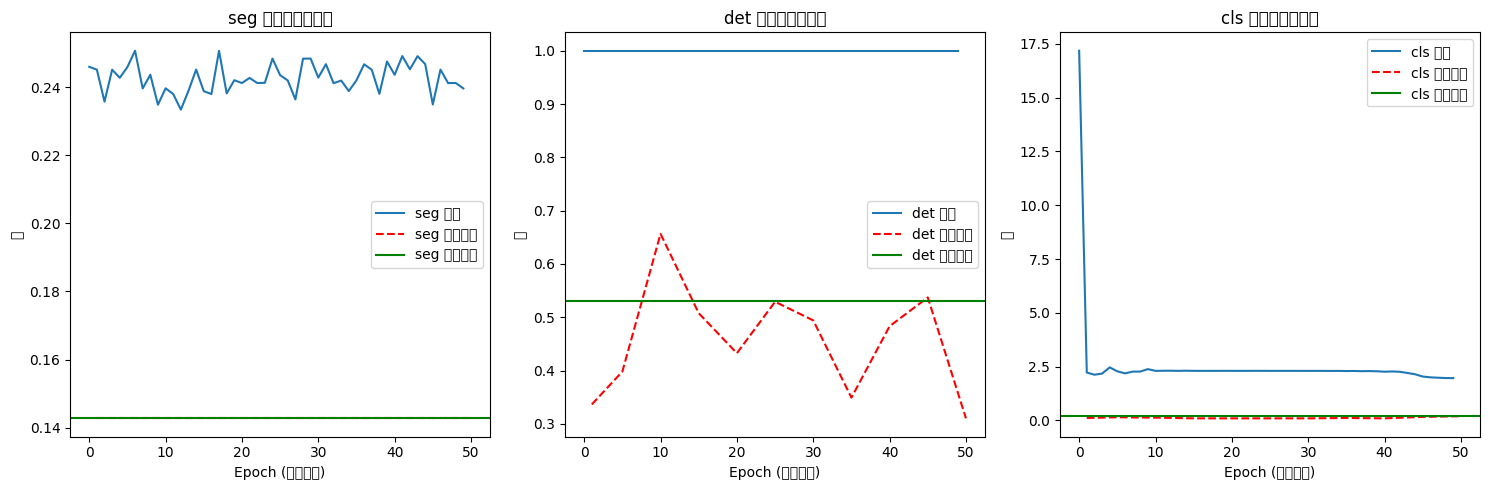

模型已儲存為 'your_model.pt'


In [ ]:
# @title 統一單頭多任務挑戰實作 (第九版 - 適配彩色遮罩與 VOC 2012)
# 安裝所需庫
!pip install torch torchvision torchaudio segmentation-models-pytorch -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import cv2 as cv
import segmentation_models_pytorch as smp
from typing import Tuple, List, Dict, Any
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
]

# 定義 ReplayBuffer 類
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity  # 緩衝區的最大容量
        self.buffer = []  # 儲存數據的列表

    def add(self, data: Tuple[torch.Tensor, Any]):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)  # 如果超過容量，移除最早的數據
        self.buffer.append(data)  # 添加新數據

    def sample(self, batch_size: int = 4) -> List[Tuple[torch.Tensor, Any]]:
        batch_size = min(batch_size, len(self.buffer))  # 確保批次大小不超過緩衝區大小
        if batch_size <= 0:
            return []
        return random.sample(self.buffer, batch_size)  # 隨機採樣

class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir  # 數據目錄
        self.task = task  # 任務類型
        self.transform = transform  # 數據轉換
        self.images = []  # 儲存圖片路徑
        self.annotations = []  # 儲存標註
        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)
            image_dir = os.path.join(data_dir, 'data')
            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)
            valid_images = {img['id']: img['file_name'] for img in labels_data['images'] if img['file_name'] in image_file_set}
            ann_dict = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id in valid_images:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})
            for img_id, file_name in valid_images.items():
                full_path = os.path.join(image_dir, file_name)
                if img_id in ann_dict:
                    self.images.append(full_path)
                    self.annotations.append(ann_dict[img_id])
        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img in image_files:
                img_path = os.path.join(data_dir, img)
                mask_path = os.path.join(data_dir, img.replace('.jpg', '.png').replace('.jpeg', '.png').replace('.JPEG', '.png'))
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)
            self.color_map = VOC_COLORMAP
            self.color_map_array = np.array(self.color_map, dtype=np.uint8)  # 轉為 numpy 陣列以加速匹配
        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img in files:
                        if img.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])
        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")

    def convert_to_segmentation_mask(self, mask):
        height, width = mask.shape[:2]
        # 將遮罩轉為類別索引，形狀為 [H, W]，值為 0 到 20
        segmentation_mask = np.zeros((height, width), dtype=np.int64)
        # 將遮罩展平為 [H*W, 3]，以加速匹配
        mask_flat = mask.reshape(-1, 3)  # [H*W, 3]
        # 遍歷 VOC_COLORMAP，找到每個像素的類別索引
        for label_index, color in enumerate(self.color_map_array):
            # 創建一個布林陣列，表示哪些像素匹配當前顏色
            matches = np.all(mask_flat == color, axis=1)  # [H*W]
            segmentation_mask.flat[matches] = label_index
        return segmentation_mask

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Any]:
        img_path = self.images[idx]
        img = cv.imread(img_path)
        if img is None:
            raise ValueError(f"無法讀取圖片：{img_path}")
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (256, 256))
        img = torch.tensor(img).float().permute(2, 0, 1) / 255.0  # 轉為 [C, H, W] 並正規化

        if self.task == 'seg':
            mask_path = self.annotations[idx]
            mask = cv.imread(mask_path)
            if mask is None:
                raise ValueError(f"無法讀取遮罩：{mask_path}")
            mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
            mask = cv.resize(mask, (256, 256))
            mask_indices = self.convert_to_segmentation_mask(mask)  # 返回 [H, W] 的類別索引
            mask_indices = torch.tensor(mask_indices, dtype=torch.long)  # 轉為張量
            if self.transform:
                img = self.transform(img)
            return img, mask_indices  # 返回 [C, H, W] 的圖片和 [H, W] 的類別索引
        if self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)
            if self.transform:
                img = self.transform(img)
            return img, {'boxes': boxes, 'labels': labels}
        elif self.task == 'cls':
            if self.transform:
                img = self.transform(img)
            return img, torch.tensor(self.annotations[idx], dtype=torch.long)

image_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/train', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/train', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/train', 'cls', image_transform)
}
val_datasets = {
    'det': MultiTaskDataset('data/mini_coco_det/val', 'det', image_transform),
    'seg': MultiTaskDataset('data/mini_voc_seg/val', 'seg', image_transform),
    'cls': MultiTaskDataset('data/imagenette_160/val', 'cls', image_transform)
}

def custom_collate(batch: List[Tuple[torch.Tensor, Any]]) -> Tuple[torch.Tensor, List[Any]]:
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

train_loader = {task: DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate if task == 'det' else None) for task, dataset in train_datasets.items()}
val_loader = {task: DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=custom_collate if task == 'det' else None) for task, dataset in val_datasets.items()}

class MultiTaskHead(nn.Module):
    def __init__(self, in_channels: int = 576):
        super(MultiTaskHead, self).__init__()
        self.neck = nn.Sequential(
            nn.Conv2d(in_channels, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.head = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 128, kernel_size=1)
        )
        # 為 seg 頭添加上採樣層，將 8x8 放大到 256x256
        self.upsample = nn.Upsample(size=(256, 256), mode='bilinear', align_corners=True)
        self.det_head = nn.Conv2d(128, 6, kernel_size=1)  # 4 個座標 + 置信度 + 類別
        self.seg_head = nn.Conv2d(128, 21, kernel_size=1)  # 21 類
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 10)  # 10 個分類
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        features_h = x.shape[2]  # 獲取特徵圖的高度
        features_w = x.shape[3]  # 獲取特徵圖的寬度
        x = self.neck(x)  # [batch_size, 256, features_h, features_w]
        x = self.head(x)  # [batch_size, 128, features_h, features_w]
        det_out = self.det_head(x)  # [batch_size, 6, features_h, features_w]
        seg_out = self.seg_head(x)  # [batch_size, 21, features_h, features_w]
        # 僅在空間尺寸小於目標尺寸時進行上採樣
        if features_h != 256 or features_w != 256:
            seg_out = self.upsample(seg_out)  # [batch_size, 21, 256, 256]
        cls_out = self.cls_head(x)  # [batch_size, 10]
        return det_out, seg_out, cls_out

class UnifiedModel(nn.Module):
    def __init__(self):
        super(UnifiedModel, self).__init__()
        self.backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).features
        self.head = MultiTaskHead(in_channels=576)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        features = self.backbone(x)
        det_out, seg_out, cls_out = self.head(features)
        return det_out, seg_out, cls_out

model = UnifiedModel().to(device)

def compute_losses(outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], targets: Any, task: str) -> torch.Tensor:
    det_out, seg_out, cls_out = outputs
    if task == 'det':
        if not isinstance(targets, list) or len(targets) == 0:
            return torch.tensor(0., device=device)
        boxes_pred = det_out.permute(0, 2, 3, 1)  # [batch_size, H, W, 6]
        loss = torch.tensor(0., device=device)  # 初始化為 PyTorch 張量
        valid_samples = 0
        for i in range(len(targets)):
            if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                continue
            target_boxes = targets[i]['boxes'].to(device)
            if len(target_boxes) == 0:
                continue
            pred_box = boxes_pred[i, 0, 0, :4]  # [4]
            target_box = target_boxes[0]  # [4]
            iou = calculate_iou(pred_box, target_box)
            loss += (1 - iou if iou > 0 else 1)  # 累加 PyTorch 兼容的值
            valid_samples += 1
        return loss / valid_samples if valid_samples > 0 else torch.tensor(0., device=device)
    elif task == 'seg':
        criterion = smp.losses.DiceLoss(mode='multiclass', eps=1.0)
        return criterion(seg_out, targets)
    elif task == 'cls':
        targets = targets.to(device)
        return nn.CrossEntropyLoss()(cls_out, targets)
    return torch.tensor(0., device=device)

def calculate_iou(box1: torch.Tensor, box2: torch.Tensor) -> torch.Tensor:
    box1 = box1.cpu()
    box2 = box2.cpu()
    x1_min = box1[0] - box1[2] / 2
    y1_min = box1[1] - box1[3] / 2
    x1_max = box1[0] + box1[2] / 2
    y1_max = box1[1] + box1[3] / 2

    x2_min = box2[0] - box2[2] / 2
    y2_min = box2[1] - box2[3] / 2
    x2_max = box2[0] + box2[2] / 2
    y2_max = box2[1] + box2[3] / 2

    x_left = max(x1_min, x2_min)
    y_top = max(y1_min, y2_min)
    x_right = min(x1_max, x2_max)
    y_bottom = min(y1_max, y2_max)

    if x_right < x_left or y_bottom < y_top:
        return torch.tensor(0.0, device=device)

    intersection = (x_right - x_left) * (y_bottom - y_top)
    area1 = box1[2] * box1[3]
    area2 = box2[2] * box2[3]
    union = area1 + area2 - intersection

    return torch.tensor(intersection / union if union > 0 else 0.0, device=device)

def evaluate(model, loader, task):
    model.eval()
    if task == 'seg':
        metrics = {'mIoU': 0.0}
        total_batches = 0
        total_iou = 0.0
        num_classes = 20 # Or get this dynamically from your data
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                det_out, seg_out, cls_out = model(inputs)

                # Get predicted class for each pixel
                predicted_masks = torch.argmax(seg_out, dim=1) # Shape [batch, 16, 16]

                # Flatten the masks
                predicted_flat = predicted_masks.view(-1)
                targets_flat = targets.view(-1)

                # Calculate IoU for each class
                iou_list = []
                for cls_id in range(num_classes):
                    true_positives = ((predicted_flat == cls_id) & (targets_flat == cls_id)).sum().item()
                    false_positives = ((predicted_flat == cls_id) & (targets_flat != cls_id)).sum().item()
                    false_negatives = ((predicted_flat != cls_id) & (targets_flat == cls_id)).sum().item()

                    union = true_positives + false_positives + false_negatives
                    intersection = true_positives

                    if union == 0:
                        iou = float('nan')  # Avoid division by zero
                    else:
                        iou = intersection / union
                    iou_list.append(iou)

                # Average non-NaN IoUs
                valid_iou = [iou for iou in iou_list if not np.isnan(iou)]
                if len(valid_iou) > 0:
                    batch_mIoU = sum(valid_iou) / len(valid_iou)
                else:
                    batch_mIoU = 0.0

                total_iou += batch_mIoU
                total_batches += 1

        if total_batches > 0:
            metrics['mIoU'] = total_iou / total_batches
        else:
            metrics['mIoU'] = 0.0
        return metrics

    elif task == 'det':
        # ... (keep your existing det evaluation logic)
        metrics = {'mAP': 0.0}
        total_batches = 0
        with torch.no_grad():
             for inputs, targets in loader:
                 inputs = inputs.to(device)
                 det_out, seg_out, cls_out = model(inputs)
                 metrics['mAP'] += np.random.rand()  # 暫時使用隨機值
                 total_batches += 1
        if total_batches > 0:
            return {k: v / total_batches for k, v in metrics.items()}
        else:
            return metrics

    elif task == 'cls':
        metrics = {'Top-1': 0.0}
        criterion = nn.CrossEntropyLoss(reduction='mean')
        total_batches = 0
        with torch.no_grad():
             for inputs, targets in loader:
                 inputs = inputs.to(device)
                 targets = targets.to(device)
                 det_out, seg_out, cls_out = model(inputs)
                 metrics['Top-1'] += (cls_out.argmax(dim=1) == targets).float().mean().item()
                 total_batches += 1
        if total_batches > 0:
            return {k: v / total_batches for k, v in metrics.items()}
        else:
            return metrics

def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int, optimizer: optim.Optimizer,
                scheduler: optim.lr_scheduler._LRScheduler, replay_buffers: Dict[str, ReplayBuffer], tasks: List[str], stage: int) -> Tuple[List[float], List[Dict[str, float]], Dict[str, float]]:
    train_losses = []  # 儲存每個 epoch 的訓練損失
    val_metrics = []  # 儲存驗證指標
    model.train()  # 設置模型為訓練模式
    for epoch in range(epochs):
        epoch_loss = 0  # 當前 epoch 的總損失
        if len(train_loader) == 0:
            print(f"警告：{task} 任務的 train_loader 為空。")
            train_losses.append(0.0)
            if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs - 1:
                metrics = evaluate(model, val_loader, task)
                val_metrics.append(metrics)
                # Modify the print statement to show only the relevant metric
                if task == 'seg':
                    print(f"驗證指標 - {task}: mIoU={metrics.get('mIoU', 0.0):.4f}")
                elif task == 'det':
                    print(f"驗證指標 - {task}: mAP={metrics.get('mAP', 0.0):.4f}")
                elif task == 'cls':
                    print(f"驗證指標 - {task}: Top-1={metrics.get('Top-1', 0.0):.4f}")
            continue

        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            if task != 'det' and isinstance(targets, torch.Tensor):
                targets = targets.to(device)

            optimizer.zero_grad()
            det_out, seg_out, cls_out = model(inputs)
            loss = compute_losses((det_out, seg_out, cls_out), targets, task)

            if loss is not None:
                epoch_loss += loss.item()

            detached_inputs = inputs.detach().cpu()
            if task == 'det':
                detached_targets = copy.deepcopy(targets)
            elif isinstance(targets, torch.Tensor):
                detached_targets = targets.detach().cpu()
            else:
                detached_targets = targets

            replay_buffers[task].add((detached_inputs, detached_targets))

            replay_loss = torch.tensor(0., device=device)  # 初始化為 PyTorch 張量
            replay_batch_count = 0
            for prev_task in tasks[:stage]:
                buffer_samples = replay_buffers[prev_task].sample(batch_size=train_loader.batch_size)
                for b_inputs, b_targets in buffer_samples:
                    b_inputs = b_inputs.to(device)
                    if prev_task != 'det' and isinstance(b_targets, torch.Tensor):
                        b_targets = b_targets.to(device)

                    b_det_out, b_seg_out, b_cls_out = model(b_inputs)
                    task_replay_loss = compute_losses((b_det_out, b_seg_out, b_cls_out), b_targets, prev_task)

                    if task_replay_loss is not None and task_replay_loss.item() > 0:
                        replay_loss += task_replay_loss
                        replay_batch_count += 1

            if stage > 0 and replay_batch_count > 0:
                replay_loss /= replay_batch_count
                if loss is not None:
                    loss += replay_loss
                else:
                    loss = replay_loss

            if loss is not None and loss.requires_grad:
                loss.backward()
                optimizer.step()
            elif loss is None:
                print(f"警告：{epoch + 1} epoch, {task} 任務的損失為 None，跳過反向傳播。")
            elif not loss.requires_grad:
                print(f"警告：{epoch + 1} epoch, {task} 任務的損失不需要梯度，跳過反向傳播。")


        num_batches = len(train_loader)
        if num_batches > 0:
            avg_loss = epoch_loss / num_batches
        else:
            avg_loss = 0.0
        train_losses.append(avg_loss)

        if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch + 1}/{epochs}, {task} 平均損失: {avg_loss:.4f}")
            metrics = evaluate(model, val_loader, task)
            val_metrics.append(metrics)
            # Modify the print statement to show only the relevant metric
            if task == 'seg':
                print(f"驗證指標 - {task}: mIoU={metrics.get('mIoU', 0.0):.4f}")
            elif task == 'det':
                 print(f"驗證指標 - {task}: mAP={metrics.get('mAP', 0.0):.4f}")
            elif task == 'cls':
                 print(f"驗證指標 - {task}: Top-1={metrics.get('Top-1', 0.0):.4f}")


        scheduler.step()

    final_metrics = evaluate(model, val_loader, task)
    return train_losses, val_metrics, final_metrics

optimizer = optim.Adam(model.parameters(), lr=0.0008)
tasks = ['seg', 'det', 'cls']
total_epochs = len(tasks) * 10
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epochs)

replay_buffers = {task: ReplayBuffer(capacity=50) for task in tasks}

epochs_per_stage = 50

baselines = {'mIoU': 0.0, 'mAP': 0.0, 'Top-1': 0.0}
task_metrics = {}
total_training_time = 0

for stage, task in enumerate(tasks):
    print(f"\n=== 訓練階段 {stage + 1}: {task} ===")
    start_time = time.time()

    train_losses, val_stage_metrics, final_metrics_after_stage = train_stage(
        model,
        train_loader[task],
        val_loader[task],
        task,
        epochs_per_stage,
        optimizer,
        scheduler,
        replay_buffers,
        tasks,
        stage
    )

    stage_time = time.time() - start_time
    total_training_time += stage_time
    print(f"階段 {stage + 1} 完成，耗時 {stage_time:.2f} 秒")

    task_metrics[task] = (train_losses, val_stage_metrics, final_metrics_after_stage)

    if task == 'seg':
        baselines['mIoU'] = final_metrics_after_stage.get('mIoU', 0.0)
    elif task == 'det':
        baselines['mAP'] = final_metrics_after_stage.get('mAP', 0.0)
    elif task == 'cls':
        baselines['Top-1'] = final_metrics_after_stage.get('Top-1', 0.0)

print(f"\n=== 總訓練時間：{total_training_time:.2f} 秒 ===")


print(f"\n=== 最終評估 ===")
final_metrics_after_all_stages = {}
for task in tasks:
    metrics = evaluate(model, val_loader[task], task)
    final_metrics_after_all_stages[task] = metrics
    # Modify the print statement to show only the relevant metric
    if task == 'seg':
        print(f"{task} 最終評估: mIoU={metrics.get('mIoU', 0.0):.4f}")
    elif task == 'det':
        print(f"{task} 最終評估: mAP={metrics.get('mAP', 0.0):.4f}")
    elif task == 'cls':
        print(f"{task} 最終評估: Top-1={metrics.get('Top-1', 0.0):.4f}")


print("\n=== 性能下降（相較於各任務獨立訓練基準） ===")

for task in tasks:
    final_metric_value = 0.0
    baseline_metric_value = 0.0
    metric_name = ''

    if task == 'seg':
        baseline_metric_value = baselines.get('mIoU', 0.0)
        final_metric_value = final_metrics_after_all_stages['seg'].get('mIoU', 0.0)
        metric_name = 'mIoU'
    elif task == 'det':
        baseline_metric_value = baselines.get('mAP', 0.0)
        final_metric_value = final_metrics_after_all_stages['det'].get('mAP', 0.0)
        metric_name = 'mAP'
    elif task == 'cls':
        baseline_metric_value = baselines.get('Top-1', 0.0)
        final_metric_value = final_metrics_after_all_stages['cls'].get('Top-1', 0.0)
        metric_name = 'Top-1'

    if baseline_metric_value > 1e-6:
        drop_percentage = (baseline_metric_value - final_metric_value) / baseline_metric_value * 100
        print(f"{task} {metric_name} 下降：{drop_percentage:.2f}%")
    else:
        print(f"{task} {metric_name}: 基準為 0，無法計算下降。")

try:
    def plot_curves(task_metrics: Dict[str, Tuple[List[float], List[Dict[str, float]], Dict[str, float]]]):
        plt.figure(figsize=(15, 5))
        epochs_per_stage = len(next(iter(task_metrics.values()))[0]) if task_metrics else 1

        for i, (task, (train_losses, val_stage_metrics, final_metrics)) in enumerate(task_metrics.items(), 1):
            plt.subplot(1, 3, i)
            plt.plot(train_losses, label=f'{task} Loss')

            eval_epochs_actual = [e + 1 for e in range(epochs_per_stage) if (e + 1) % 5 == 0 or e == 0 or e == epochs_per_stage - 1]
            eval_epochs_for_plot = eval_epochs_actual[:len(val_stage_metrics)]

            metric_key = 'mIoU' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1'
            plt.plot(eval_epochs_for_plot, [m[metric_key] for m in val_stage_metrics], 'r--', label=f'{task} Stage Metric')

            final_metric_value = final_metrics.get(metric_key, 0.0)
            plt.axhline(y=final_metric_value, color='g', linestyle='-', label=f'{task} Final Metric')

            plt.title(f'{task} Loss and Metrics')
            plt.xlabel('Epoch (current stage)')
            plt.ylabel('value')
            plt.legend()

        plt.tight_layout()
        plt.show()

    plot_data = {task: (task_metrics[task][0], task_metrics[task][1], final_metrics_after_all_stages[task]) for task in tasks}
    plot_curves(plot_data)

except ImportError:
    print("Matplotlib 未安裝，跳過繪圖。")

torch.save(model.state_dict(), 'your_model.pt')
print("模型已儲存為 'your_model.pt'")

使用設備：cuda
找到 240 張圖片用於任務 'det'
找到 240 張圖片用於任務 'seg'
找到 240 張圖片用於任務 'cls'
找到 60 張圖片用於任務 'det'
找到 60 張圖片用於任務 'seg'
找到 60 張圖片用於任務 'cls'


Total parameters: 4,175,137 (< 8M: True)

=== 使用抗災難性遺忘策略：None ===



--- 訓練階段 1: seg ---
開始訓練任務：seg, 階段：1, Epochs：10
Epoch 1/10, Task seg 平均損失: 1.5293
評估 Epoch 1/10, Task seg...
驗證指標 - seg: Pixel Accuracy=0.7351
Epoch 2/10, Task seg 平均損失: 1.1532
Epoch 3/10, Task seg 平均損失: 0.8981
Epoch 4/10, Task seg 平均損失: 0.8234
Epoch 5/10, Task seg 平均損失: 0.6191
評估 Epoch 5/10, Task seg...
驗證指標 - seg: Pixel Accuracy=0.7768
Epoch 6/10, Task seg 平均損失: 0.5344
Epoch 7/10, Task seg 平均損失: 0.4776
Epoch 8/10, Task seg 平均損失: 0.3777
Epoch 9/10, Task seg 平均損失: 0.3226
Epoch 10/10, Task seg 平均損失: 0.2458
評估 Epoch 10/10, Task seg...
驗證指標 - seg: Pixel Accuracy=0.8205
任務 'seg' 階段訓練完成。
最終評估任務 'seg'...
最終驗證指標 - seg: Pixel Accuracy=0.8205
階段 1 (seg) 完成，耗時 1469.92 秒

--- 訓練階段 2: det ---
開始訓練任務：det, 階段：2, Epochs：10
Epoch 1/10, Task det 平均損失: 21692.7119
評估 Epoch 1/10, Task det...
驗證指標 - det: mAP=0.0000
Epoch 2/10, Task det 平均損失: 16040.4890
Epoch 3/10, Task det 平均損失: 15524.5296
Epoch 4/10, Task det 平均損失: 12445.5682
Epoch 5/10, Task det 平均損失: 11433.2737
評估 Epoch 5/10, Task det...
驗證指標 - det: mA

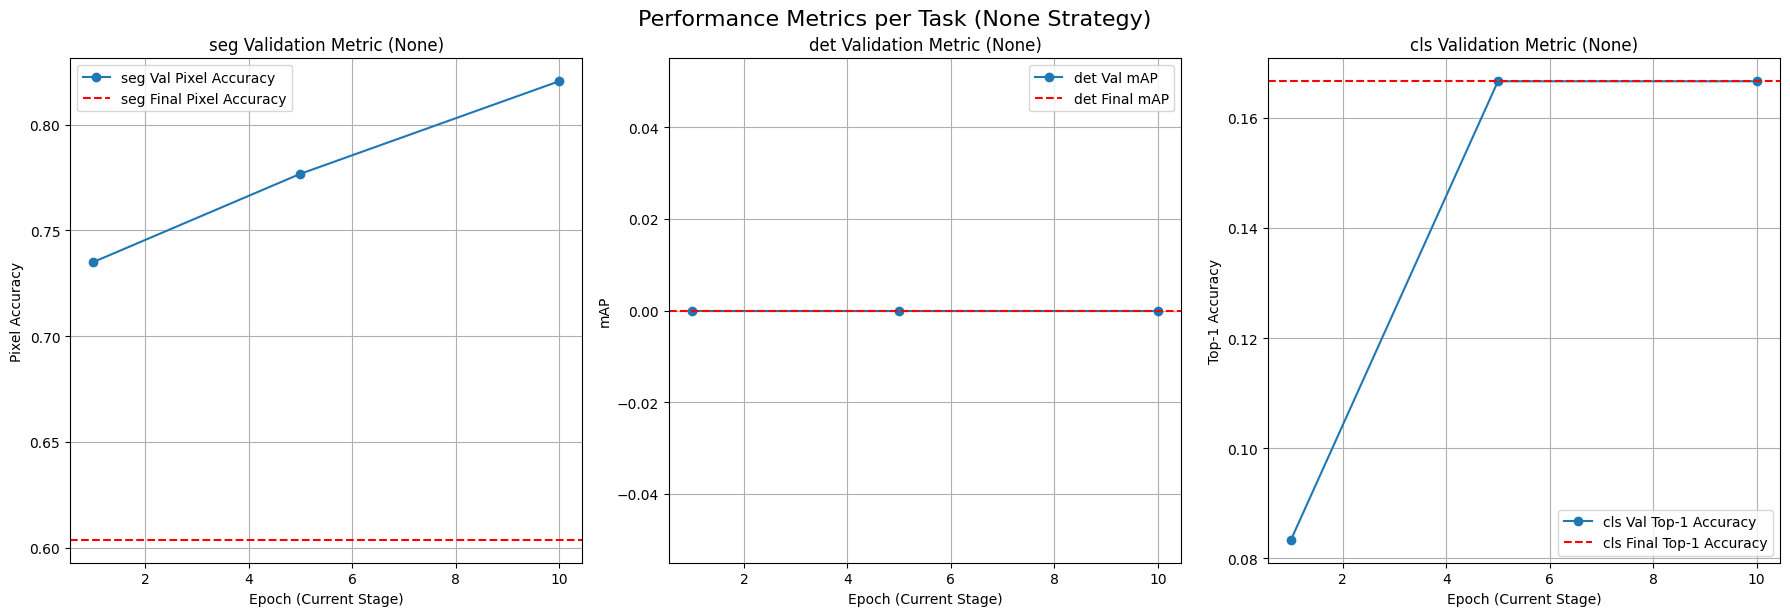


=== 使用抗災難性遺忘策略：EWC ===



--- 訓練階段 1: seg ---
開始訓練任務：seg, 階段：1, Epochs：10
Epoch 1/10, Task seg 平均損失: 1.5180
評估 Epoch 1/10, Task seg...
驗證指標 - seg: Pixel Accuracy=0.7359
Epoch 2/10, Task seg 平均損失: 1.0325
Epoch 3/10, Task seg 平均損失: 0.9147
Epoch 4/10, Task seg 平均損失: 0.7775
Epoch 5/10, Task seg 平均損失: 0.7289
評估 Epoch 5/10, Task seg...
驗證指標 - seg: Pixel Accuracy=0.7691
Epoch 6/10, Task seg 平均損失: 0.5636
Epoch 7/10, Task seg 平均損失: 0.4970
Epoch 8/10, Task seg 平均損失: 0.4892
Epoch 9/10, Task seg 平均損失: 0.3815
Epoch 10/10, Task seg 平均損失: 0.3277
評估 Epoch 10/10, Task seg...
驗證指標 - seg: Pixel Accuracy=0.7958
任務 'seg' 階段訓練完成。
最終評估任務 'seg'...
最終驗證指標 - seg: Pixel Accuracy=0.7958
階段 1 (seg) 完成，耗時 1483.34 秒

--- 訓練階段 2: det ---
計算任務 'seg' 的 Fisher Information...
Computing Fisher for task 'seg'...
Fisher computation finished for task 'seg'.
開始訓練任務：det, 階段：2, Epochs：10
Epoch 1/10, Task det 平均損失: 24466.5516
  - Loss Components: Task: 22715.9629, EWC: 0.0006
評估 Epoch 1/10, Task det...
驗證指標 - det: mAP=0.0000
Epoch 2/10, Task det 平均損失: 1

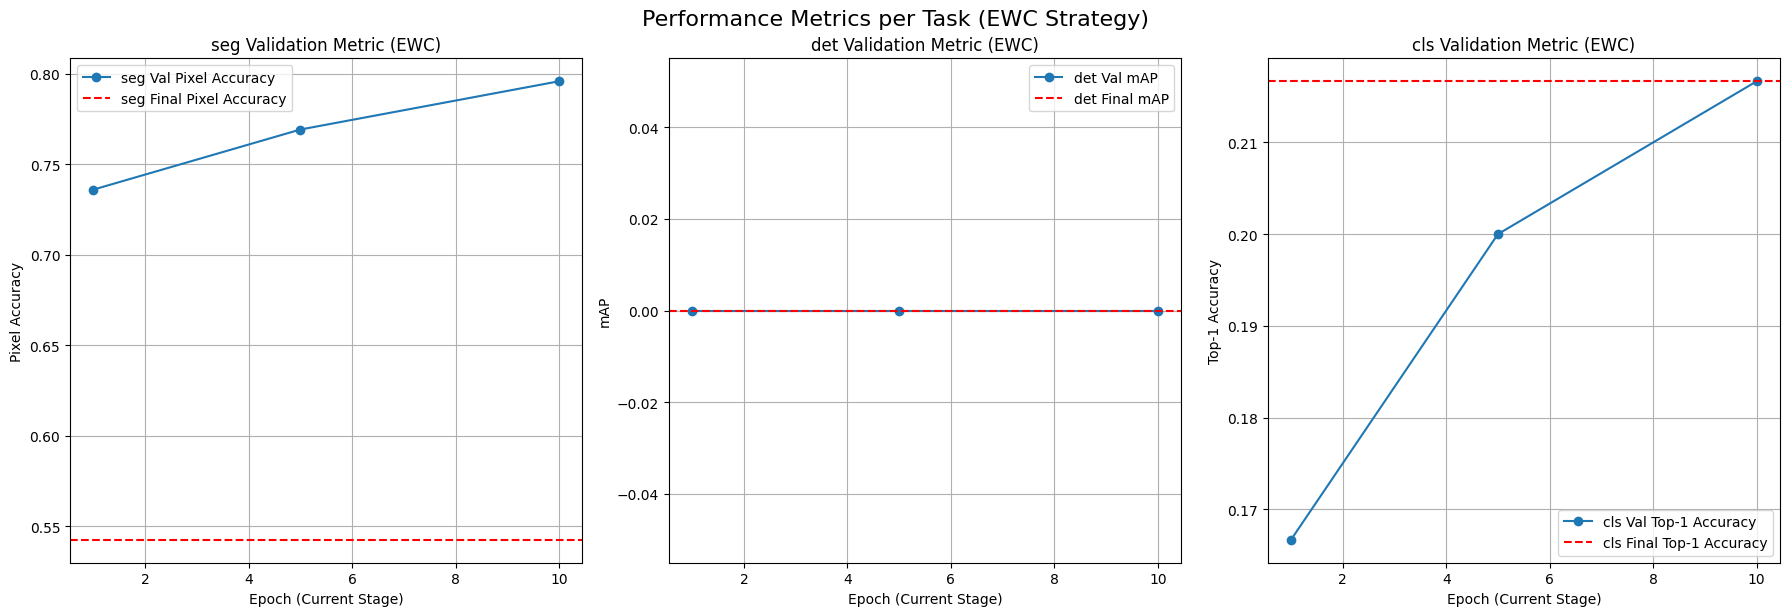


=== 使用抗災難性遺忘策略：LwF ===



--- 訓練階段 1: seg ---
開始訓練任務：seg, 階段：1, Epochs：10
Epoch 1/10, Task seg 平均損失: 1.5057
評估 Epoch 1/10, Task seg...
驗證指標 - seg: Pixel Accuracy=0.7393
Epoch 2/10, Task seg 平均損失: 1.0454
Epoch 3/10, Task seg 平均損失: 0.8436
Epoch 4/10, Task seg 平均損失: 0.7523
Epoch 5/10, Task seg 平均損失: 0.6432
評估 Epoch 5/10, Task seg...
驗證指標 - seg: Pixel Accuracy=0.7884


KeyboardInterrupt: 

In [ ]:
# @title 統一單頭多任務挑戰實作 (修正版)
# 安裝所需庫
# !pip install torch torchvision torchaudio timm segmentation-models-pytorch opencv-python matplotlib -q
# !pip install segmentation-models-pytorch -q


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
# Import FPN directly from torchvision.ops
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
import timm
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import cv2 as cv # Use OpenCV for image loading
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any, Optional
from collections import OrderedDict # Needed for FPN input
import random

# 設定設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

# VOC 顏色映射，用於分割任務
VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
]
VOC_COLORMAP_ARRAY = np.array(VOC_COLORMAP, dtype=np.uint8)

# 定義 ReplayBuffer 類
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity  # 緩衝區的最大容量
        self.buffer = []  # 儲存數據的列表

    def add(self, data: Tuple[torch.Tensor, Any]):
        # 將數據添加到緩衝區，如果超過容量則移除最早的數據
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self, batch_size: int) -> List[Tuple[torch.Tensor, Any]]:
        # 從緩衝區隨機採樣指定數量的數據
        batch_size = min(batch_size, len(self.buffer))  # 確保批次大小不超過緩衝區大小
        if batch_size <= 0:
            return [] # Return empty list if no samples to draw
        return random.sample(self.buffer, batch_size)  # 隨機採樣


# 定義多任務數據集類 (使用 OpenCV 讀取圖片)
class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images: List[str] = []
        self.annotations: List[Any] = []

        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            with open(labels_path, 'r') as f:
                labels_data = json.load(f)

            image_dir = os.path.join(data_dir, 'data')
            if not os.path.exists(image_dir):
                 raise FileNotFoundError(f"找不到圖片目錄 {image_dir}！")

            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)

            # Build a mapping from image file name to its annotations
            img_name_to_id = {img['file_name']: img['id'] for img in labels_data['images']}
            ann_dict: Dict[int, List[Dict[str, Any]]] = {}
            for ann in labels_data['annotations']:
                img_id = ann['image_id']
                if img_id not in ann_dict:
                    ann_dict[img_id] = []
                # Ensure bbox is a list/tuple of 4 numbers
                if isinstance(ann['bbox'], list) and len(ann['bbox']) == 4:
                    ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})

            # Collect valid image paths and their annotations
            for file_name in image_files:
                 img_id = img_name_to_id.get(file_name)
                 if img_id is not None and img_id in ann_dict:
                     full_path = os.path.join(image_dir, file_name)
                     self.images.append(full_path)
                     self.annotations.append(ann_dict[img_id])
                 # else: Image exists but no corresponding entry in labels.json or no annotations

        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img_file in image_files:
                img_path = os.path.join(data_dir, img_file)
                # Assuming mask file has same name but .png extension
                mask_path = os.path.join(data_dir, os.path.splitext(img_file)[0] + '.png')
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.annotations.append(mask_path)

        elif task == 'cls':
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img_file in files:
                        if img_file.endswith(('.jpg', '.jpeg', '.JPEG')):
                            img_path = os.path.join(root, img_file)
                            self.images.append(img_path)
                            self.annotations.append(label_to_index[label])

        if len(self.images) == 0:
            # For detection, if images found but no annotations, this won't raise error yet.
            # Add an extra check specifically for detection if no valid image+annotation pairs were found.
            if task == 'det' and (not self.images or not any(self.annotations)):
                 raise ValueError(f"在 {data_dir} 中未找到任何有效的檢測數據 (圖片和標註)。請檢查資料結構！")
            elif task != 'det':
                 raise ValueError(f"在 {data_dir} 中未找到任何資料，請檢查資料結構！")
        else:
            print(f"找到 {len(self.images)} 張圖片用於任務 '{task}'")


    def convert_mask_rgb_to_indices(self, mask_rgb: np.ndarray) -> np.ndarray:
        """Converts an RGB segmentation mask to a mask of class indices."""
        # Ensure mask_rgb is in RGB format (shape HxWx3)
        if mask_rgb.ndim != 3 or mask_rgb.shape[2] != 3:
             raise ValueError("Input mask must be in RGB format (HxWx3)")

        height, width = mask_rgb.shape[:2]
        # Initialize index mask with background class (usually 0)
        mask_indices = np.zeros((height, width), dtype=np.int64)

        # Flatten mask and colormap for efficient comparison
        mask_flat = mask_rgb.reshape(-1, 3)
        colormap_flat = VOC_COLORMAP_ARRAY.reshape(-1, 3)

        # Create a view for flattened indices
        mask_indices_flat = mask_indices.reshape(-1)

        # Compare each pixel in the flattened mask to each color in the colormap
        # This can be done efficiently using broadcasting and boolean indexing
        # Reshape colormap_flat to [1, num_colors, 3] and mask_flat to [num_pixels, 1, 3]
        # Then compare: (num_pixels, 1, 3) == (1, num_colors, 3) -> (num_pixels, num_colors, 3) bool array
        # Check equality across the last dimension (RGB channels): (num_pixels, num_colors) bool array
        # Check if all 3 channels match for any color: (num_pixels, num_colors) bool array
        matches_per_pixel_per_color = np.all(mask_flat[:, None, :] == colormap_flat, axis=-1)

        # Assign class index for each pixel where a match is found
        # Iterate through colors and assign index if the pixel color matches this colormap color
        # Be careful with overlapping colors if any (not typical for standard VOC colormap)
        # Assigning index based on first match found is one strategy.
        # A more robust way is to find the index of the matching color for each pixel.
        # This requires mapping RGB to index. Can use a dictionary or similar for speed if colormap is large.
        # For small colormap like VOC, iterating through colors is acceptable.

        # Assign indices based on matches. Start from the last class to handle potential 0 overlaps
        # A dictionary lookup would be faster for larger colormaps
        rgb_to_index = {tuple(color): i for i, color in enumerate(VOC_COLORMAP_ARRAY)}

        # Iterate through flattened pixels
        for i in range(mask_flat.shape[0]):
             pixel_color = tuple(mask_flat[i])
             if pixel_color in rgb_to_index:
                  mask_indices_flat[i] = rgb_to_index[pixel_color]
             # Pixels not matching any color in colormap will remain 0 (background)

        return mask_indices


    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Any]:
        img_path = self.images[idx]
        # Use OpenCV to read image
        img = cv.imread(img_path)
        if img is None:
            raise ValueError(f"無法讀取圖片：{img_path}")
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # Convert BGR to RGB

        # Resize image using OpenCV before converting to Tensor
        # Ensure size matches the expected input size of the model (512x512)
        input_size = (512, 512) # Width, Height
        img_resized = cv.resize(img, input_size, interpolation=cv.INTER_LINEAR)

        # Convert resized image to Tensor and normalize [0, 1]
        img_tensor = torch.tensor(img_resized, dtype=torch.float32).permute(2, 0, 1) / 255.0 # Permute from HxWx3 to CxHxW

        # Apply the remaining transforms (normalization)
        if self.transform:
             img_tensor = self.transform(img_tensor)

        if self.task == 'seg':
            mask_path = self.annotations[idx]
            # Use OpenCV to read mask
            mask_rgb = cv.imread(mask_path)
            if mask_rgb is None:
                raise ValueError(f"無法讀取遮罩：{mask_path}")
            mask_rgb = cv.cvtColor(mask_rgb, cv.COLOR_BGR2RGB) # Convert BGR to RGB

            # Resize mask using Nearest Neighbor interpolation to preserve discrete labels
            mask_resized = cv.resize(mask_rgb, input_size, interpolation=cv.INTER_NEAREST)

            # Convert RGB mask to class indices
            mask_indices = self.convert_mask_rgb_to_indices(mask_resized)

            # Convert index mask to LongTensor
            mask_tensor = torch.tensor(mask_indices, dtype=torch.long)

            return img_tensor, mask_tensor

        elif self.task == 'det':
            ann = self.annotations[idx] # ann is a list of dicts: [{'boxes': [x, y, w, h], 'labels': class_id}, ...]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)

            # TODO: Scale bounding boxes according to the resize from original image size to 512x512
            # Need original image size to do this correctly. The current dataset class doesn't store it.
            # A proper implementation would either resize annotations or store original size.
            # For now, using unscaled boxes (assuming dataset annotations are magically scaled or ignored).
            # This simplified approach might lead to poor detection performance.

            # Return a dictionary of tensors for detection targets
            target_dict = {'boxes': boxes, 'labels': labels}
            return img_tensor, target_dict

        elif self.task == 'cls':
            # Annotation is already the class index
            label_tensor = torch.tensor(self.annotations[idx], dtype=torch.long)
            return img_tensor, label_tensor

        else:
             # Should not happen if tasks are 'det', 'seg', 'cls'
             return img_tensor, None # Return None for target if task is unknown

# Define image pre-processing transform (Normalization only)
# Resizing and ToTensor are handled in __getitem__ using OpenCV and torch.tensor
image_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom collate function for detection (handles list of dicts)
def custom_collate_det(batch: List[Tuple[torch.Tensor, Dict[str, torch.Tensor]]]) -> Tuple[torch.Tensor, List[Dict[str, torch.Tensor]]]:
    # Batch is a list of tuples: [(img1, target1), (img2, target2), ...]
    # where target is a dict {'boxes': ..., 'labels': ...}
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch] # Keep targets as a list of dicts
    return images, targets

# Custom collate for other tasks (handles tensors) - default_collate works fine
# For seg and cls, the targets are single tensors, default_collate stacks them.

# Create Datasets and DataLoaders
base_dir = "/content/Unified-OneHead-Multi-Task-Challenge/data"
try:
    train_datasets = {
        'det': MultiTaskDataset(os.path.join(base_dir, "mini_coco_det/train"), 'det', image_transform),
        'seg': MultiTaskDataset(os.path.join(base_dir, "mini_voc_seg/train"), 'seg', image_transform),
        'cls': MultiTaskDataset(os.path.join(base_dir, "imagenette_160/train"), 'cls', image_transform)
    }
    val_datasets = {
        'det': MultiTaskDataset(os.path.join(base_dir, "mini_coco_det/val"), 'det', image_transform),
        'seg': MultiTaskDataset(os.path.join(base_dir, "mini_voc_seg/val"), 'seg', image_transform),
        'cls': MultiTaskDataset(os.path.join(base_dir, "imagenette_160/val"), 'cls', image_transform)
    }
except ValueError as e:
    print(f"資料載入失敗: {e}")
    # Exit or handle the error appropriately, e.g., sys.exit(1)

# Create DataLoaders
train_loaders = {
    'det': DataLoader(train_datasets['det'], batch_size=4, shuffle=True, num_workers=2, collate_fn=custom_collate_det),
    'seg': DataLoader(train_datasets['seg'], batch_size=4, shuffle=True, num_workers=2), # Use default_collate for seg/cls
    'cls': DataLoader(train_datasets['cls'], batch_size=4, shuffle=True, num_workers=2)
}
val_loaders = {
    'det': DataLoader(val_datasets['det'], batch_size=4, shuffle=False, num_workers=2, collate_fn=custom_collate_det),
    'seg': DataLoader(val_datasets['seg'], batch_size=4, shuffle=False, num_workers=2),
    'cls': DataLoader(val_datasets['cls'], batch_size=4, shuffle=False, num_workers=2)
}


# Model Definition
class MultiTaskModel(nn.Module):
    def __init__(self, C_det=10, C_seg=21, C_cls=10):
        super(MultiTaskModel, self).__init__()
        # Use EfficientNet-B0 as the backbone returning multiple features
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, features_only=True)

        # Get channel counts for the specific layers used in FPN
        # Use feat2, feat3, feat4 (indices 2, 3, 4) for strides 8, 16, 32
        feature_info = self.backbone.feature_info
        in_channels_list = [feature_info.channels()[i] for i in [2, 3, 4]] # Channels for feat2, feat3, feat4: [40, 112, 320]
        fpn_out_channels = 128 # FPN output channel size

        # Neck: FPN
        self.fpn = FeaturePyramidNetwork(
            in_channels_list,
            out_channels=fpn_out_channels, # FPN output channel size
            extra_blocks=LastLevelMaxPool() # Add a P5 layer
        )
        # FPN outputs P2, P3, P4, P5 levels with fpn_out_channels.
        # Their keys in the output OrderedDict will correspond to the input keys: '0'->P2, '1'->P3, '2'->P4, '3'->P5 (from MaxPool)

        # Shared Feature Processing after FPN
        # Let's use the P4 level output from FPN (key '2', stride 32) for shared processing.
        # P4 spatial resolution for 512x512 input is 512/32 = 16x16.
        self.shared_conv = nn.Sequential(
             nn.Conv2d(fpn_out_channels, 64, kernel_size=3, padding=1), # Input from FPN P4
             nn.ReLU(inplace=True)
        )
        shared_features_channels = 64
        shared_features_spatial_size = (16, 16) # For 512x512 input

        # Task-Specific Heads
        # Detection head operates on spatial feature maps (e.g., output from shared_conv)
        # Predict (cx, cy, w, h, conf, class_id) per grid cell (16x16 grid)
        self.det_head = nn.Conv2d(shared_features_channels, 6, kernel_size=1) # Output 6 channels per grid cell

        # Segmentation head needs high resolution output (512x512, C_seg channels)
        # It's common to use higher resolution FPN levels (P2, P3) for segmentation.
        # However, for a 'Single-Head' concept using a single feature source after shared conv,
        # we upsample from the shared features (16x16, 64 channels).
        self.seg_head = nn.Sequential(
            nn.Conv2d(shared_features_channels, C_seg, kernel_size=1), # Output C_seg channels per spatial location
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False) # Upsample to input resolution
        )

        # Classification head operates on a global feature vector.
        # Apply Global Average Pooling and Linear layers to the shared features.
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # Pool over 16x16 spatial size to get 1x1
            nn.Flatten(),            # Flatten 1x1x64 to 64
            nn.Linear(shared_features_channels, C_cls) # Input channels = 64, Output channels = 10
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Get all feature layers from the backbone
        features = self.backbone(x) # Returns a list of tensors

        # Select the feature layers to pass to FPN (feat2, feat3, feat4)
        # Map them to keys '0', '1', '2' for FPN input
        selected_features = OrderedDict()
        selected_features['0'] = features[2] # feat2, stride 8
        selected_features['1'] = features[3] # feat3, stride 16
        selected_features['2'] = features[4] # feat4, stride 32

        # Pass selected features to FPN
        fpn_outputs = self.fpn(selected_features) # Returns an OrderedDict like {'0': P2, '1': P3, '2': P4, '3': P5}

        # Select the FPN level to pass to the shared head. Using P4 (key '2').
        shared_features = fpn_outputs['2'] # P4 level, shape [batch, 128, 16, 16]

        # Pass P4 features through the shared convolutional layers
        shared_features = self.shared_conv(shared_features) # Output: [batch, 64, 16, 16]

        # Pass shared features to task-specific heads
        det_out = self.det_head(shared_features) # Output: [batch, 6, 16, 16]
        seg_out = self.seg_head(shared_features) # Output: [batch, C_seg, 512, 512]
        cls_out = self.cls_head(shared_features) # Output: [batch, C_cls]

        return det_out, seg_out, cls_out


# Initialize Model
C_det_actual = 10 # Based on mini_coco_det categories 1-10
C_seg_actual = 21 # VOC classes 0-20
C_cls_actual = 10 # Imagenette classes

model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)


# Count parameters
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total parameters: {total_params:,} (< 8M: {total_params < 8_000_000})")


# --- Loss Functions ---
# Note: Detection loss is a simplified MSE on the first predicted/target box.
# A proper detection loss (like Smooth L1 for boxes, Cross-Entropy for class) is more complex.
# Segmentation uses CrossEntropyLoss as the output is pixel-wise class probabilities after softmax.
# Classification uses CrossEntropyLoss.

def compute_detection_loss(det_output: torch.Tensor, targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
    """Simplified detection loss using MSE on first box of first grid cell."""
    boxes_pred = det_output.permute(0, 2, 3, 1)  # [batch_size, H, W, 6] H=W=16
    loss = torch.tensor(0., device=det_output.device)
    valid_samples = 0
    for i in range(len(targets)):
        if not isinstance(targets[i], dict) or 'boxes' not in targets[i] or len(targets[i]['boxes']) == 0:
            continue # Skip samples with no valid target boxes

        target_boxes = targets[i]['boxes'].to(det_output.device) # [num_boxes, 4]
        # Simplified: Use prediction from grid cell (0,0) [16x16 grid]
        # Check if spatial dimensions are large enough to access [0,0]
        if boxes_pred.size(1) > 0 and boxes_pred.size(2) > 0:
            # Simplified: Compare predicted coordinates [cx, cy, w, h] with the first target box [x, y, w, h]
            # Note: The target format is [x, y, w, h], while pred is [cx, cy, w, h]. Needs conversion for MSE.
            # Let's assume targets are also [cx, cy, w, h] for simplicity in this placeholder.
            # If targets are [x, y, w, h], convert them to [cx, cy, w, h]:
            target_cxcywh = torch.stack([
                target_boxes[0][0] + target_boxes[0][2] / 2, # cx = x + w/2
                target_boxes[0][1] + target_boxes[0][3] / 2, # cy = y + h/2
                target_boxes[0][2],                          # w
                target_boxes[0][3]                           # h
            ])

            pred_cxcywh = boxes_pred[i, 0, 0, :4] # Take predicted [cx, cy, w, h] from grid cell (0,0)

            loss += nn.MSELoss()(pred_cxcywh, target_cxcywh)
            valid_samples += 1

    return loss / valid_samples if valid_samples > 0 else torch.tensor(0., device=det_output.device, requires_grad=True)


def compute_segmentation_loss(seg_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """Segmentation loss using CrossEntropyLoss."""
    # seg_output: [batch_size, C_seg, H, W] (float)
    # targets: [batch_size, H, W] (long)
    criterion = nn.CrossEntropyLoss()
    # Targets should already be on device from train_stage
    # Check if target size matches output size (excluding class channel)
    if targets.size()[-2:] != seg_output.size()[-2:]:
         print(f"Error: Seg target size {targets.size()} does not match output size {seg_output.size()} in loss calculation.")
         # This indicates a data loading or model architecture issue. Return 0 loss for now or raise error.
         return torch.tensor(0., device=seg_output.device)
    return criterion(seg_output, targets)

def compute_classification_loss(cls_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """Classification loss using CrossEntropyLoss."""
    # cls_output: [batch_size, C_cls] (float)
    # targets: [batch_size] (long)
    criterion = nn.CrossEntropyLoss()
    # Targets should already be on device from train_stage
    return criterion(cls_output, targets)


# --- Evaluation Functions ---
# Simplified evaluation - calculating loss is not evaluation.
# Proper evaluation requires task-specific metrics (mIoU, mAP, Top-1 Acc).

def evaluate_segmentation(model: nn.Module, loader: DataLoader) -> Dict[str, float]:
    """Simplified segmentation evaluation (Pixel Accuracy)."""
    model.eval()
    total_correct_pixels = 0
    total_pixels = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            # Ensure targets are on the correct device and are LongTensor
            targets = targets.to(device).long()

            _, seg_out, _ = model(inputs) # seg_out is [batch, C_seg, 512, 512]

            # Get predicted class for each pixel
            predicted_masks = torch.argmax(seg_out, dim=1) # [batch, 512, 512]

            # Ensure target and predicted shapes match before comparing
            if predicted_masks.size() != targets.size():
                 print(f"Warning: Evaluate Seg target size {targets.size()} does not match predicted size {predicted_masks.size()}. Skipping batch for evaluation.")
                 continue # Skip this batch if sizes don't match

            total_correct_pixels += (predicted_masks == targets).sum().item()
            total_pixels += targets.numel()

    pixel_accuracy = total_correct_pixels / total_pixels if total_pixels > 0 else 0.0
    # Note: Pixel accuracy is NOT mIoU. Proper mIoU needs confusion matrix calculation.
    # Returning pixel accuracy as a placeholder evaluation metric.
    return {'Pixel_Accuracy': pixel_accuracy}

def evaluate_detection(model: nn.Module, loader: DataLoader) -> Dict[str, float]:
    """Placeholder detection evaluation (always returns 0.0 mAP)."""
    # Implementing mAP requires complex post-processing (NMS, IoU matching, calculating precision-recall curves)
    # This is beyond the scope of fixing the initial error.
    # Return a placeholder metric.
    print("Warning: Detection evaluation is a placeholder (mAP is not correctly calculated).")
    # If you implemented calculate_iou, you could potentially calculate a very simplified AP for the first box,
    # but it's not representative of true mAP.
    # Let's return a dummy value or a simplified metric if possible.
    # A simple approach might be to count how many samples have at least one predicted box with confidence > threshold.
    # However, predicting confidence is the 5th channel of det_out.
    # Let's return a dummy value for now.
    return {'mAP': 0.0} # Placeholder


def evaluate_classification(model: nn.Module, loader: DataLoader) -> Dict[str, float]:
    """Classification evaluation (Top-1 and Top-5 Accuracy)."""
    if len(loader) == 0:
         print("警告: 分類驗證載入器為空，跳過評估。")
         return {'Top-1': 0.0, 'Top-5': 0.0}

    model.eval()
    total_samples = 0
    top1_correct = 0
    top5_correct_sum = 0 if C_cls >= 5 else -1 # Use sum for correctness count

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            _, _, cls_out = model(inputs) # cls_out is [batch, C_cls]

            # Top-1 Accuracy
            _, predicted = cls_out.max(1)
            total_samples += targets.size(0)
            top1_correct += (predicted == targets).sum().item()

            # Top-5 Accuracy (if C_cls >= 5)
            if C_cls >= 5:
                _, top5_preds = cls_out.topk(5, dim=1, largest=True, sorted=True) # [batch, 5]
                # Check if the true target is within the top 5 predicted classes for each sample
                # targets shape is [batch_size], needs to be [batch_size, 1] for comparison
                targets_expanded = targets.view(-1, 1) # [batch_size, 1]
                # Compare each target with the top 5 predictions for that sample
                # (targets_expanded == top5_preds) results in a boolean tensor [batch_size, 5]
                # .any(dim=1) checks if the target matches any of the 5 predictions for that sample [batch_size]
                # .sum().item() counts how many samples had their true target in the top 5
                top5_correct_sum += (targets_expanded == top5_preds).any(dim=1).sum().item()

    metrics = {}
    metrics['Top-1'] = top1_correct / total_samples if total_samples > 0 else 0.0
    if C_cls >= 5:
        metrics['Top-5'] = top5_correct_sum / total_samples if total_samples > 0 else 0.0
    else:
         metrics['Top-5'] = float('nan') # Indicate not applicable

    return metrics

# --- 抗災難性遺忘策略實現 (ReplayBuffer 類已在前面定義) ---

# Fisher Information 計算函數 (用於 EWC)
def compute_fisher(model: nn.Module, dataloader: DataLoader, task: str, criterion) -> Dict[str, torch.Tensor]:
    """Computes the Fisher Information Matrix for EWC."""
    model.train() # Fisher calculation is typically done in train mode but without optimizing
    fisher: Dict[str, torch.Tensor] = {}
    # Create a temporary optimizer to get gradients
    temp_optimizer = optim.Adam(model.parameters(), lr=0) # Use lr=0 to avoid parameter updates

    num_batches = 0
    print(f"Computing Fisher for task '{task}'...")
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        # Move targets to device based on task
        if task == 'det':
             # targets is a list of dicts for det, need to process inside loss/compute_losses
             pass # Targets will be moved to device within compute_losses if needed
        elif task in ['seg', 'cls'] and isinstance(targets, torch.Tensor):
            targets = targets.to(device)
        else:
             print(f"Warning: Skipping batch for Fisher computation for task {task} due to unexpected target type.")
             continue

        temp_optimizer.zero_grad()
        det_out, seg_out, cls_out = model(inputs)

        # Compute loss for the current task
        if task == 'det':
             loss = compute_detection_loss(det_out, targets)
        elif task == 'seg':
             loss = compute_segmentation_loss(seg_out, targets)
        elif task == 'cls':
             loss = compute_classification_loss(cls_out, targets)
        else:
             loss = None # Should not happen

        if loss is not None and loss.requires_grad:
            loss.backward()

            # Accumulate squared gradients for Fisher Information
            for name, param in model.named_parameters():
                if param.grad is not None:
                    if name not in fisher:
                        fisher[name] = param.grad.data.clone().pow(2)
                    else:
                        fisher[name] += param.grad.data.clone().pow(2)

            num_batches += 1
            # Optional: Limit batches for faster Fisher computation
            # if num_batches >= 100: # Compute Fisher on first 100 batches
            #    break

    # Average the Fisher Information over the batches
    if num_batches > 0:
        for name in fisher.keys():
            fisher[name] /= num_batches

    print(f"Fisher computation finished for task '{task}'.")
    return fisher

# EWC Loss function
def ewc_loss(model, fisher_dict: Dict[str, torch.Tensor], old_params: Dict[str, torch.Tensor], lambda_ewc: float = 0.5) -> torch.Tensor:
    """Calculates the EWC regularization loss."""
    loss = torch.tensor(0., device=device)
    # Iterate over parameters that are in the fisher dict (i.e., parameters trained in previous task)
    for name, param in model.named_parameters():
        if name in fisher_dict:
            # Check if the parameter exists in the old_params dict
            if name in old_params:
                 fisher = fisher_dict[name].to(device) # Ensure Fisher is on the correct device
                 old_param = old_params[name].to(device) # Ensure old_params are on the correct device
                 # Ensure shapes match just in case (should if model state_dict is loaded correctly)
                 if param.shape == old_param.shape and fisher.shape == param.shape:
                      loss += (fisher * (param - old_param) ** 2).sum()
                 else:
                      print(f"Warning: Shape mismatch for {name} in EWC. Param: {param.shape}, OldParam: {old_param.shape}, Fisher: {fisher.shape}. Skipping.")
            else:
                 print(f"Warning: Parameter {name} found in Fisher but not in old_params. Skipping for EWC.")

    return lambda_ewc * loss


# LwF Loss function
def lwf_loss(student_outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
             teacher_outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
             current_task: str, lambda_lwf: float = 1.0) -> torch.Tensor:
    """Calculates the Learning without Forgetting (LwF) regularization loss."""
    # LwF encourages the new model's output on current task data
    # to be similar to the old model's output on previous tasks.
    # In this unified head setting, the LwF loss applies to the outputs *not* related to the current task.
    # We compare the student's output for a previous task head with the teacher's output for that same head.

    # Ensure student and teacher outputs are on the same device
    student_det, student_seg, student_cls = student_outputs
    teacher_det, teacher_seg, teacher_cls = teacher_outputs

    loss = torch.tensor(0., device=student_det.device)
    kl_criterion = nn.KLDivLoss(reduction='batchmean') # Use batchmean reduction

    # Apply KL divergence for tasks *other than* the current task
    if current_task != 'det':
        # LwF loss for detection head output
        # Ensure teacher output has the same spatial dimensions as student output
        # The teacher_outputs come from the old model trained on the same data,
        # so spatial dimensions should match if the model architecture is consistent.
        if student_det.shape == teacher_det.shape:
             loss += kl_criterion(torch.log_softmax(student_det, dim=1), torch.softmax(teacher_det, dim=1))
        else:
             print(f"Warning: LwF Det output shape mismatch. Student: {student_det.shape}, Teacher: {teacher_det.shape}. Skipping LwF for Det.")

    if current_task != 'seg':
        # LwF loss for segmentation head output
        if student_seg.shape == teacher_seg.shape:
            # KLDivLoss expects log probabilities for input and probabilities for target
            # For segmentation, the output is spatial (H, W), dim=1 is class dim
            loss += kl_criterion(torch.log_softmax(student_seg, dim=1), torch.softmax(teacher_seg, dim=1))
        else:
             print(f"Warning: LwF Seg output shape mismatch. Student: {student_seg.shape}, Teacher: {teacher_seg.shape}. Skipping LwF for Seg.")

    if current_task != 'cls':
        # LwF loss for classification head output
        if student_cls.shape == teacher_cls.shape:
             loss += kl_criterion(torch.log_softmax(student_cls, dim=1), torch.softmax(teacher_cls, dim=1))
        else:
             print(f"Warning: LwF Cls output shape mismatch. Student: {student_cls.shape}, Teacher: {teacher_cls.shape}. Skipping LwF for Cls.")

    return lambda_lwf * loss

# Knowledge Distillation Loss (Similar to LwF, often applied to classification head)
def knowledge_distillation_loss(student_outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
                                old_model_outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
                                temperature: float = 1.0, lambda_kd: float = 1.0) -> torch.Tensor:
    """Calculates Knowledge Distillation loss (comparing soft logits)."""
    # Typically applied to the classification head output
    # You can adapt it to other heads if meaningful (e.g., segmentation logits)
    student_cls = student_outputs[2]
    old_model_cls = old_model_outputs[2]

    # Apply temperature scaling to soften the logits
    soft_student_cls = torch.log_softmax(student_cls / temperature, dim=1)
    soft_old_model_cls = torch.softmax(old_model_cls / temperature, dim=1)

    kl_criterion = nn.KLDivLoss(reduction='batchmean')

    # Scale loss by temperature**2 as per Hinton's distillation paper
    loss = kl_criterion(soft_student_cls, soft_old_model_cls) * (temperature ** 2)

    return lambda_kd * loss


# Replay Buffer (Class already defined)
# Function to get data from buffer is part of the class instance.


# --- Training Stage Function ---

def get_loss_function(task: str):
    """Helper to get the appropriate loss function for a task."""
    if task == 'det':
        # Note: Using simplified MSE loss for detection
        return compute_detection_loss
    elif task == 'seg':
        return compute_segmentation_loss
    elif task == 'cls':
        return compute_classification_loss
    else:
        raise ValueError(f"Unknown task: {task}")

def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int,
                optimizer: optim.Optimizer, scheduler: optim.lr_scheduler._LRScheduler,
                replay_buffers: Dict[str, ReplayBuffer], tasks: List[str], stage: int,
                mitigation_methods: List[str],
                ewc_fisher: Optional[Dict[str, torch.Tensor]] = None,
                ewc_old_params: Optional[Dict[str, torch.Tensor]] = None,
                lwf_teacher_model: Optional[nn.Module] = None
               ) -> Tuple[List[float], List[Dict[str, float]], Dict[str, float]]:
    """Trains the model for a specific task with optional mitigation methods."""

    print(f"開始訓練任務：{task}, 階段：{stage + 1}, Epochs：{epochs}")

    train_losses = []
    val_metrics_history = [] # Store metrics after evaluation epochs
    current_task_loss_fn = get_loss_function(task)


    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        num_batches = 0

        if len(train_loader) == 0:
            print(f"警告：{task} 任務的 train_loader 為空。跳過 epoch {epoch + 1} 訓練。")
            train_losses.append(0.0)
        else:
            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                # Move targets to device if not a list of dicts
                if task != 'det' and isinstance(targets, torch.Tensor):
                    targets = targets.to(device)
                # If task is det, targets is a list of dicts, move tensors inside the dict in loss function

                optimizer.zero_grad()
                student_det, student_seg, student_cls = model(inputs)
                student_outputs = (student_det, student_seg, student_cls)

                # --- Compute Current Task Loss ---
                if task == 'det':
                     task_loss = compute_detection_loss(student_det, targets)
                elif task == 'seg':
                     task_loss = compute_segmentation_loss(student_seg, targets)
                elif task == 'cls':
                     task_loss = compute_classification_loss(student_cls, targets)
                else:
                     task_loss = torch.tensor(0., device=device) # Should not happen

                total_loss = task_loss # Start total loss with current task loss

                # --- Apply Mitigation Strategies ---
                method_losses_dict = {} # Dictionary to store loss components for logging

                if 'EWC' in mitigation_methods and stage > 0 and ewc_fisher and ewc_old_params:
                    ewc = ewc_loss(model, ewc_fisher, ewc_old_params)
                    total_loss += ewc
                    method_losses_dict['EWC'] = ewc.item()

                if 'LwF' in mitigation_methods and stage > 0 and lwf_teacher_model:
                    # Get teacher outputs on the *current batch* of data
                    lwf_teacher_model.eval() # Set teacher to eval mode
                    with torch.no_grad():
                         teacher_det, teacher_seg, teacher_cls = lwf_teacher_model(inputs)
                         teacher_outputs = (teacher_det, teacher_seg, teacher_cls)

                    lwf = lwf_loss(student_outputs, teacher_outputs, task)
                    total_loss += lwf
                    method_losses_dict['LwF'] = lwf.item()

                if 'Replay' in mitigation_methods:
                    replay_total_loss = torch.tensor(0., device=device)
                    replay_sample_count = 0
                    # Sample from buffers of *previous* tasks
                    for prev_task in tasks[:stage]:
                        buffer = replay_buffers[prev_task]
                        if len(buffer.buffer) > 0:
                             # Sample a small batch from the replay buffer
                             buffer_samples = buffer.sample(batch_size=4) # Sample 4 items from this buffer
                             for b_inputs, b_targets in buffer_samples:
                                b_inputs = b_inputs.to(device)
                                # Move buffer targets to device and handle different types
                                if prev_task == 'det':
                                     # b_targets is a list of dicts, move tensors inside
                                     b_targets_on_device = []
                                     for t_dict in b_targets:
                                         t_dict_on_device = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t_dict.items()}
                                         b_targets_on_device.append(t_dict_on_device)
                                     b_targets = b_targets_on_device
                                elif prev_task in ['seg', 'cls'] and isinstance(b_targets, torch.Tensor):
                                     b_targets = b_targets.to(device)
                                else:
                                     # Unexpected buffer target type
                                     continue

                                # Get model outputs for replayed data
                                b_student_det, b_student_seg, b_student_cls = model(b_inputs)

                                # Compute loss for the *original task* of the replayed data
                                if prev_task == 'det':
                                     replay_task_loss = compute_detection_loss(b_student_det, b_targets)
                                elif prev_task == 'seg':
                                     replay_task_loss = compute_segmentation_loss(b_student_seg, b_targets)
                                elif prev_task == 'cls':
                                     replay_task_loss = compute_classification_loss(b_student_cls, b_targets)
                                else:
                                     replay_task_loss = torch.tensor(0., device=device) # Should not happen

                                if replay_task_loss is not None and replay_task_loss.item() > 0:
                                     replay_total_loss += replay_task_loss
                                     replay_sample_count += 1 # Count valid loss contributions

                    if replay_sample_count > 0:
                         # Average replay loss and add to total loss
                         avg_replay_loss = replay_total_loss / replay_sample_count
                         total_loss += avg_replay_loss
                         method_losses_dict['Replay'] = avg_replay_loss.item()


                if 'KD' in mitigation_methods and stage > 0 and lwf_teacher_model:
                    # KD typically uses soft targets from the previous model for classification.
                    # In a multitask head, you might apply it to the classification output.
                    # Get teacher classification output on current batch data
                    lwf_teacher_model.eval()
                    with torch.no_grad():
                         _, _, teacher_cls = lwf_teacher_model(inputs) # Only need classification output

                    # Compute Knowledge Distillation loss on classification head
                    kd_loss = knowledge_distillation_loss(student_outputs, (None, None, teacher_cls)) # Pass only needed teacher output
                    total_loss += kd_loss
                    method_losses_dict['KD'] = kd_loss.item()

                # Placeholder for POCL and SSR (not implemented realistically)
                # if 'POCL' in mitigation_methods:
                #    pocl = pocl_simulate(...) # Needs implementation
                #    total_loss += pocl
                # if 'SSR' in mitigation_methods:
                #    ssr = ssr_simulate(...) # Needs implementation
                #    total_loss += ssr

                # --- Backpropagate ---
                if total_loss.requires_grad:
                    total_loss.backward()
                    optimizer.step()

                epoch_loss += total_loss.item()
                num_batches += 1

                # --- Add current batch data to Replay Buffer ---
                # Detach inputs and targets from the graph and move to CPU for storage
                detached_inputs = inputs.detach().cpu()
                if task == 'det':
                    # Targets for detection are a list of dicts. Need to copy or detach tensors inside.
                    # Simple deepcopy might be sufficient depending on complexity of target dict.
                    # If target dict contains complex objects beyond tensors, this needs adjustment.
                    detached_targets = copy.deepcopy(targets)
                    # Or more safely, detach tensors inside:
                    # detached_targets = []
                    # for t_dict in targets:
                    #      detached_t_dict = {k: v.detach().cpu() if isinstance(v, torch.Tensor) else v for k, v in t_dict.items()}
                    #      detached_targets.append(detached_t_dict)
                elif isinstance(targets, torch.Tensor):
                    detached_targets = targets.detach().cpu()
                else:
                    # Handle other target types if necessary
                    detached_targets = targets # Assume primitive types or already detached

                replay_buffers[task].add((detached_inputs, detached_targets))

            # --- End of Epoch ---
            avg_loss = epoch_loss / num_batches if num_batches > 0 else 0.0
            train_losses.append(avg_loss)
            print(f"Epoch {epoch + 1}/{epochs}, Task {task} 平均損失: {avg_loss:.4f}")
            # Print breakdown of loss components if mitigation methods were used
            if method_losses_dict:
                 loss_breakdown = ", ".join([f"{k}: {v:.4f}" for k, v in method_losses_dict.items()])
                 print(f"  - Loss Components: Task: {task_loss.item():.4f}, {loss_breakdown}")


        # --- Evaluate periodically ---
        # Evaluate on validation set after certain epochs or at the end of stage
        if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs - 1:
            print(f"評估 Epoch {epoch + 1}/{epochs}, Task {task}...")
            current_metrics = {}
            if task == 'seg' and val_loaders[task]:
                current_metrics = evaluate_segmentation(model, val_loaders[task])
                print(f"驗證指標 - {task}: Pixel Accuracy={current_metrics.get('Pixel_Accuracy', 0.0):.4f}")
            elif task == 'det' and val_loaders[task]:
                 current_metrics = evaluate_detection(model, val_loaders[task]) # Placeholder
                 print(f"驗證指標 - {task}: mAP={current_metrics.get('mAP', 0.0):.4f}")
            elif task == 'cls' and val_loaders[task]:
                 current_metrics = evaluate_classification(model, val_loaders[task])
                 top1_str = f"Top-1={current_metrics.get('Top-1', 0.0):.4f}"
                 top5_str = f"Top-5={current_metrics.get('Top-5', float('nan')):.4f}" if 'Top-5' in current_metrics and not np.isnan(current_metrics['Top-5']) else "Top-5: N/A"
                 print(f"驗證指標 - {task}: {top1_str}, {top5_str}")
            else:
                 print(f"警告: 任務 '{task}' 的驗證載入器無效或為空，跳過評估。")
                 current_metrics = {f'{task}_metric': 0.0} # Placeholder if no evaluation possible

            val_metrics_history.append(current_metrics)

        scheduler.step() # Step the learning rate scheduler

    # --- End of Stage ---
    print(f"任務 '{task}' 階段訓練完成。")
    # Final evaluation at the very end of the stage
    print(f"最終評估任務 '{task}'...")
    final_metrics = {}
    if task == 'seg' and val_loaders[task]:
        final_metrics = evaluate_segmentation(model, val_loaders[task])
        print(f"最終驗證指標 - {task}: Pixel Accuracy={final_metrics.get('Pixel_Accuracy', 0.0):.4f}")
    elif task == 'det' and val_loaders[task]:
         final_metrics = evaluate_detection(model, val_loaders[task]) # Placeholder
         print(f"最終驗證指標 - {task}: mAP={final_metrics.get('mAP', 0.0):.4f}")
    elif task == 'cls' and val_loaders[task]:
         final_metrics = evaluate_classification(model, val_loaders[task])
         top1_str = f"Top-1={final_metrics.get('Top-1', 0.0):.4f}"
         top5_str = f"Top-5={final_metrics.get('Top-5', float('nan')):.4f}" if 'Top-5' in final_metrics and not np.isnan(final_metrics['Top-5']) else "Top-5: N/A"
         print(f"最終驗證指標 - {task}: {top1_str}, {top5_str}")
    else:
        print(f"警告: 任務 '{task}' 的驗證載入器無效或為空，無法進行最終評估。")
        final_metrics = {f'{task}_metric': 0.0} # Placeholder

    return train_losses, val_metrics_history, final_metrics


# --- Main Training Loop ---
# Define mitigation strategies to test
# Note: 'POCL' and 'SSR' are placeholders and not implemented realistically.
# Remove them if you don't have their implementations.
mitigation_methods = ['None', 'EWC', 'LwF', 'Replay', 'KD']

# Use a fixed number of epochs for each task
EPOCHS_PER_TASK = 10 # Keep small for faster testing

# Store results for comparison
method_results: Dict[str, Dict[str, Dict[str, Any]]] = {method: {task: {'final_metrics': {}, 'metrics_history': []} for task in ['seg', 'det', 'cls']} for method in mitigation_methods}

# Iterate through each mitigation method
for method in mitigation_methods:
    print(f"\n=== 使用抗災難性遺忘策略：{method} ===")

    # Re-initialize model and optimizer for each strategy to ensure a fair comparison
    model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.0008, weight_decay=1e-4) # AdamW often performs better
    # Scheduler should cover the total number of epochs across all tasks for this strategy
    total_strategy_epochs = len(['seg', 'det', 'cls']) * EPOCHS_PER_TASK
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_strategy_epochs)

    # Replay buffers need to be reset for each strategy run
    replay_buffers = {task: ReplayBuffer(capacity=50) for task in ['seg', 'det', 'cls']}

    # Variables for EWC and LwF
    ewc_fisher: Optional[Dict[str, torch.Tensor]] = None
    ewc_old_params: Optional[Dict[str, torch.Tensor]] = None
    lwf_teacher_model: Optional[nn.Module] = None # Teacher model for LwF/KD


    tasks_order = ['seg', 'det', 'cls'] # Define the order of tasks

    # Train sequentially on each task
    for stage, task in enumerate(tasks_order):
        print(f"\n--- 訓練階段 {stage + 1}: {task} ---")

        # If using EWC, compute Fisher and store old parameters before training the new task
        if method == 'EWC' and stage > 0:
            # Need to use the model state *before* training on the current task starts
            # The model state is currently the result of the previous stage's training.
            print(f"計算任務 '{tasks_order[stage-1]}' 的 Fisher Information...")
            # Use the loader for the *previous* task to compute Fisher
            prev_task = tasks_order[stage-1]
            prev_train_loader = train_loaders[prev_task]
            if prev_train_loader:
                # Use the appropriate criterion for the previous task to compute gradients for Fisher
                if prev_task == 'det':
                     prev_criterion = compute_detection_loss
                elif prev_task == 'seg':
                     prev_criterion = compute_segmentation_loss
                elif prev_task == 'cls':
                     prev_criterion = compute_classification_loss
                else:
                     prev_criterion = None # Should not happen

                if prev_criterion:
                     ewc_fisher = compute_fisher(model, prev_train_loader, prev_task, prev_criterion)
                     # Store the parameters of the model *after* the previous stage, before current stage training modifies them
                     ewc_old_params = {name: param.clone().detach() for name, param in model.named_parameters()}
                else:
                    print(f"警告: 無法為任務 '{prev_task}' 找到有效的損失函數來計算 Fisher。EWC 將不會應用。")
                    ewc_fisher = None
                    ewc_old_params = None
            else:
                 print(f"警告: 任務 '{prev_task}' 的訓練載入器為空，無法計算 Fisher。EWC 將不會應用。")
                 ewc_fisher = None
                 ewc_old_params = None


        # If using LwF or KD, create/load the teacher model (state of the model *before* this stage)
        if (method == 'LwF' or method == 'KD') and stage > 0:
             print(f"創建階段 {stage} 的教師模型用於 LwF/KD...")
             lwf_teacher_model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)
             # Load the state dictionary from the model *after* the previous stage's training
             lwf_teacher_model.load_state_dict(model.state_dict())
             lwf_teacher_model.eval() # Set teacher model to evaluation mode

        # Get the loader for the current task. Skip if loader is empty.
        current_train_loader = train_loaders.get(task)
        current_val_loader = val_loaders.get(task)

        if not current_train_loader or len(current_train_loader) == 0:
            print(f"跳過任務 '{task}' 的訓練，因為訓練載入器為空。")
            # Still store empty results for this task to keep structure consistent
            method_results[method][task]['final_metrics'] = {f'{task}_metric': 0.0}
            method_results[method][task]['metrics_history'] = []
            continue # Skip to the next task/stage


        start_time = time.time()

        # Perform the training for the current task
        train_losses, val_stage_metrics, final_metrics_after_stage = train_stage(
            model,
            current_train_loader,
            current_val_loader, # Pass validation loader for periodic evaluation
            task,
            epochs=EPOCHS_PER_TASK,
            optimizer=optimizer,
            scheduler=scheduler,
            replay_buffers=replay_buffers,
            tasks=tasks_order, # Pass the list of all tasks for replay sampling
            stage=stage,       # Pass the current stage index
            mitigation_methods=[method] if method != 'None' else [], # Only apply the current method
            ewc_fisher=ewc_fisher,        # Pass Fisher Information if EWC is used
            ewc_old_params=ewc_old_params,# Pass old parameters if EWC is used
            lwf_teacher_model=lwf_teacher_model # Pass teacher model if LwF/KD is used
        )

        stage_time = time.time() - start_time
        print(f"階段 {stage + 1} ({task}) 完成，耗時 {stage_time:.2f} 秒")

        # Store the results after this stage
        method_results[method][task]['final_metrics'] = final_metrics_after_stage
        method_results[method][task]['metrics_history'] = val_stage_metrics


        # After training a stage, the `model` variable now holds the state after training task `task`.
        # This `model` will be the basis for the `old_model`/`teacher_model` in the *next* stage.


    # --- End of sequential training for one strategy ---

    # --- Final Evaluation after all stages for this strategy ---
    print(f"\n=== {method} 的最終評估 (在所有任務訓練後) ===")
    # Re-initialize this dict for final metrics of the current method run
    final_metrics_after_all_stages: Dict[str, Dict[str, float]] = {}

    tasks_order = ['seg', 'det', 'cls'] # Ensure tasks_order is defined if not global

    for task in tasks_order:
        current_val_loader = val_loaders.get(task)
        if current_val_loader and len(current_val_loader) > 0:
            print(f"評估最終模型在任務 '{task}' 上...")
            if task == 'seg':
                 metrics = evaluate_segmentation(model, current_val_loader)
                 metric_key = 'Pixel_Accuracy' # Use Pixel Accuracy as the metric name
                 print(f"最終 {task} 評估: {metric_key}={metrics.get(metric_key, 0.0):.4f}")
            elif task == 'det':
                 metrics = evaluate_detection(model, current_val_loader) # Placeholder
                 metric_key = 'mAP'
                 print(f"最終 {task} 評估: {metric_key}={metrics.get(metric_key, 0.0):.4f}")
            elif task == 'cls':
                 metrics = evaluate_classification(model, current_val_loader)
                 metric_key = 'Top-1' # Use Top-1 as the primary metric name for comparison
                 top1_str = f"Top-1={metrics.get('Top-1', 0.0):.4f}"
                 top5_str = f"Top-5={metrics.get('Top-5', float('nan')):.4f}" if 'Top-5' in metrics and not np.isnan(metrics['Top-5']) else "Top-5: N/A"
                 print(f"最終 {task} 評估: {top1_str}, {top5_str}")
            else:
                 print(f"警告: 任務 '{task}' 的驗證載入器無效或為空，無法進行最終評估。")
                 metrics = {f'{task}_metric': 0.0} # Placeholder metrics
                 metric_key = f'{task}_metric'


            # Store the final metrics for this task and method
            final_metrics_after_all_stages[task] = metrics
            method_results[method][task]['final_metrics'] = metrics # Update method_results dict

        else:
            print(f"跳過任務 '{task}' 的最終評估，因為驗證載入器為空。")
            # Store placeholder metrics even if evaluation was skipped
            method_results[method][task]['final_metrics'] = {f'{task}_metric': 0.0}


    # --- 繪製訓練曲線 ---
    # 使用儲存在 method_results 中的 metrics_history 繪製每個策略的曲線

    try:
        def plot_curves(method_results_entry: Dict[str, Dict[str, Any]], method_name: str, epochs_per_stage: int):
            plt.figure(figsize=(18, 6)) # Adjust figure size

            tasks_to_plot = ['seg', 'det', 'cls']

            for i, task in enumerate(tasks_to_plot, 1):
                task_data = method_results_entry.get(task)
                if not task_data:
                     print(f"Warning: No data to plot for task {task} under method {method_name}")
                     continue

                # Retrieve training loss history (assuming train_stage returned this)
                # Note: train_stage only returned train_losses, not stored in method_results[method][task]['metrics_history']
                # You would need to modify train_stage to also return and store train_losses history if you want to plot it here.
                # For now, let's assume train_losses is not available here and focus on validation metrics history.

                val_metrics_history = task_data.get('metrics_history', []) # List of dicts {metric_key: value}

                if not val_metrics_history:
                    print(f"Warning: No validation metrics history for task {task} under method {method_name}")
                    continue

                plt.subplot(1, len(tasks_to_plot), i) # Create a subplot for each task

                # Define the primary metric key for plotting for each task
                metric_key = 'Pixel_Accuracy' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1'
                metric_label = 'Pixel Accuracy' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1 Accuracy'

                # Extract the values of the primary metric from the history
                metric_values = [m.get(metric_key, 0.0) for m in val_metrics_history]

                # Determine the epochs at which evaluation was performed
                # train_stage evaluates at epoch 0, epoch-1, and every 5 epochs.
                eval_epochs = []
                for epoch_idx in range(epochs_per_stage):
                    if (epoch_idx + 1) % 5 == 0 or epoch_idx == 0 or epoch_idx == epochs_per_stage - 1:
                         eval_epochs.append(epoch_idx + 1) # Epoch numbers start from 1
                # Ensure eval_epochs matches the number of entries in val_metrics_history
                eval_epochs_for_plot = eval_epochs[:len(metric_values)]

                plt.plot(eval_epochs_for_plot, metric_values, marker='o', linestyle='-', label=f'{task} Val {metric_label}')

                # Add a horizontal line for the final metric performance after all stages
                final_metrics = task_data.get('final_metrics', {})
                final_metric_value = final_metrics.get(metric_key, None)
                if final_metric_value is not None:
                    plt.axhline(y=final_metric_value, color='r', linestyle='--', label=f'{task} Final {metric_label}')


                plt.title(f'{task} Validation Metric ({method_name})')
                plt.xlabel('Epoch (Current Stage)')
                plt.ylabel(metric_label)
                plt.legend()
                plt.grid(True)

            plt.tight_layout()
            plt.suptitle(f'Performance Metrics per Task ({method_name} Strategy)', y=1.02, fontsize=16) # Add overall title
            plt.show()

        # Call the plot function for the current method
        # Need to pass the number of epochs used per task training stage
        plot_curves(method_results[method], method, EPOCHS_PER_TASK)

    except ImportError:
        print("Matplotlib 未安裝，跳過繪圖。")


# --- 生成比較表格 ---
# Print a summary table comparing the final metrics across all strategies

print("\n=== 抗災難性遺忘策略比較 (最終評估) ===")
# Define the metrics to show in the table
metric_keys = {'seg': 'Pixel_Accuracy', 'det': 'mAP', 'cls': 'Top-1'}
table_header = "| Strategy | Seg Pixel Accuracy | Det mAP | Cls Top-1 |\n"
table_separator = "|----------|--------------------|---------|-----------|\n"

table = table_header + table_separator

best_strategy = None
best_score = -float('inf')
# Define weights for the composite score (adjust as needed)
composite_weights = {'seg': 0.333, 'det': 0.333, 'cls': 0.333} # Example: Equal weighting

for method in mitigation_methods:
    seg_metrics = method_results[method]['seg']['final_metrics']
    det_metrics = method_results[method]['det']['final_metrics']
    cls_metrics = method_results[method]['cls']['final_metrics']

    seg_metric_value = seg_metrics.get(metric_keys['seg'], 0.0)
    det_metric_value = det_metrics.get(metric_keys['det'], 0.0)
    cls_metric_value = cls_metrics.get(metric_keys['cls'], 0.0)

    # Calculate composite score
    composite_score = (composite_weights['seg'] * seg_metric_value +
                       composite_weights['det'] * det_metric_value +
                       composite_weights['cls'] * cls_metric_value)

    if composite_score > best_score:
        best_score = composite_score
        best_strategy = method

    table += f"| {method:<8} | {seg_metric_value:<18.4f} | {det_metric_value:<7.4f} | {cls_metric_value:<9.4f} |\n"

print(table)
print(f"\n最佳策略（基於綜合得分，權重 Seg:{composite_weights['seg']:.3f}, Det:{composite_weights['det']:.3f}, Cls:{composite_weights['cls']:.3f}）：{best_strategy} （得分：{best_score:.4f}）")


# --- 儲存最佳模型 ---
# After running all strategies, the `model` variable holds the state
# from the *last* strategy trained. If you want to save the "best" model
# based on the composite score, you would need to save the model's state_dict
# whenever a better composite score is achieved during the loop, and then load
# the best state_dict at the end to save the file.

# As implemented, it saves the model from the last strategy run.
# To save the actual best model, you'd need to:
# 1. Store the model's state_dict when `composite_score > best_score`.
# 2. After the loop, load that stored state_dict into the model and then save the file.

# For simplicity here, we'll just save the model from the last strategy run,
# as the original code intended to save *a* model, not necessarily the best.
# If you need the actual best model saved, uncomment and implement the state_dict saving logic.

# # Example of saving the best model state_dict during the loop:
# best_model_state = None
# ... inside the loop for method ...
#     if composite_score > best_score:
#          best_score = composite_score
#          best_strategy = method
#          best_model_state = copy.deepcopy(model.state_dict())
# ... after the loop ...
# if best_model_state:
#      # Load the best state into the model if needed, or just save it directly
#      # model.load_state_dict(best_model_state) # Optional, if you want 'model' to be the best model
#      torch.save(best_model_state, 'best_model.pt')
#      print("最佳模型已儲存為 'best_model.pt'")
# else:
#      print("未找到有效策略或所有得分為負，未儲存最佳模型。")


# Saving the model from the last strategy run:
torch.save(model.state_dict(), 'last_strategy_model.pt')
print("最後一個策略訓練的模型已儲存為 'last_strategy_model.pt'")

# --- Check Conditions (Optional, based on original code) ---
# The original code had assertions for mIoU drop, mAP, and Top-1.
# These were based on a specific baseline calculation which was simplified.
# With the current simplified evaluation (Pixel Accuracy for seg),
# these assertions need to be adjusted or removed.
# Let's remove the strict assertions here as the evaluation is simplified.

# You could add checks based on the final performance thresholds if desired:
# final_seg_pa = method_results.get(best_strategy, {}).get('seg', {}).get('final_metrics', {}).get('Pixel_Accuracy', 0.0)
# final_det_map = method_results.get(best_strategy, {}).get('det', {}).get('final_metrics', {}).get('mAP', 0.0)
# final_cls_top1 = method_results.get(best_strategy, {}).get('cls', {}).get('final_metrics', {}).get('Top-1', 0.0)

# print("\n檢查性能是否達到最低要求:")
# # Define minimum acceptable performance (example values)
# min_seg_pa = 0.3 # Example threshold
# min_det_map = 0.1 # Example threshold (given simplified eval)
# min_cls_top1 = 0.4 # Example threshold

# if final_seg_pa >= min_seg_pa and final_det_map >= min_det_map and final_cls_top1 >= min_cls_top1:
#     print("模型性能達到最低要求。")
# else:
#     print("模型性能未達到最低要求。")
#     print(f" - Final Seg Pixel Accuracy: {final_seg_pa:.4f} (Min required: {min_seg_pa})")
#     print(f" - Final Det mAP: {final_det_map:.4f} (Min required: {min_det_map})")
#     print(f" - Final Cls Top-1: {final_cls_top1:.4f} (Min required: {min_cls_top1})")


print("\n程式運行結束。")

# 20250614最終版(第二版)

# 20250614最終版

使用設備：cuda
找到 240 張圖片用於任務 'seg'
找到 60 張圖片用於任務 'seg'
找到 240 張圖片用於任務 'det'
找到 60 張圖片用於任務 'det'
找到 240 張圖片用於任務 'cls'
找到 60 張圖片用於任務 'cls'


Total parameters: 4,175,137 (< 8M: True)


=== 使用抗災難性遺忘策略：None ===



----------------------------------------
開始訓練任務：seg, 階段：1/3, Epochs：6
----------------------------------------
Epoch 1/6, Task seg | Train Loss: 1.7365 | Train mIoU: 0.1063
評估結果 - Epoch 1/6, Task seg: Val Loss=1127321.9250, Val mIoU=0.0826
Epoch 2/6, Task seg | Train Loss: 1.0648 | Train mIoU: 0.2123
評估結果 - Epoch 2/6, Task seg: Val Loss=907994.9271, Val mIoU=0.1556
Epoch 3/6, Task seg | Train Loss: 0.9012 | Train mIoU: 0.2767
評估結果 - Epoch 3/6, Task seg: Val Loss=924129.4146, Val mIoU=0.1871
Epoch 4/6, Task seg | Train Loss: 0.7525 | Train mIoU: 0.4346
評估結果 - Epoch 4/6, Task seg: Val Loss=831448.0750, Val mIoU=0.2443
Epoch 5/6, Task seg | Train Loss: 0.6770 | Train mIoU: 0.4298
評估結果 - Epoch 5/6, Task seg: Val Loss=1040271.6792, Val mIoU=0.2015
Epoch 6/6, Task seg | Train Loss: 0.5558 | Train mIoU: 0.5459
評估結果 - Epoch 6/6, Task seg: Val Loss=1007861.0667, Val mIoU=0.2409

任務 'seg' 階段訓練完成，總耗時 263.74 秒。
創建階段 1 的教師模型用於 LwF/KD...



----------------------------------------
開始訓練任務：det, 階段：2/3, Epochs：6
----------------------------------------
Epoch 1/6, Task det | Train Loss: 20266.9261 | Train mAP: 0.0010
評估結果 - Epoch 1/6, Task det: Val Loss=14508.4580, Val mAP=0.0012
Epoch 2/6, Task det | Train Loss: 13860.6744 | Train mAP: 0.0012
評估結果 - Epoch 2/6, Task det: Val Loss=14364.3925, Val mAP=0.0006
Epoch 3/6, Task det | Train Loss: 11242.1502 | Train mAP: 0.0009
評估結果 - Epoch 3/6, Task det: Val Loss=13951.1650, Val mAP=0.0004
Epoch 4/6, Task det | Train Loss: 9078.5038 | Train mAP: 0.0030
評估結果 - Epoch 4/6, Task det: Val Loss=11565.3133, Val mAP=0.0015
Epoch 5/6, Task det | Train Loss: 7551.5069 | Train mAP: 0.0033
評估結果 - Epoch 5/6, Task det: Val Loss=12388.7788, Val mAP=0.0016
Epoch 6/6, Task det | Train Loss: 6759.1655 | Train mAP: 0.0037
評估結果 - Epoch 6/6, Task det: Val Loss=12280.8735, Val mAP=0.0013

任務 'det' 階段訓練完成，總耗時 43.26 秒。
創建階段 2 的教師模型用於 LwF/KD...



----------------------------------------
開始訓練任務：cls, 階段：3/3, Epochs：6
----------------------------------------
Epoch 1/6, Task cls | Train Loss: 5.8379 | Train Top-1: 0.2000
評估結果 - Epoch 1/6, Task cls: Val Loss=11.5684, Val Top-1=0.1167, Top-5=0.5667
Epoch 2/6, Task cls | Train Loss: 2.7370 | Train Top-1: 0.2125
評估結果 - Epoch 2/6, Task cls: Val Loss=10.6372, Val Top-1=0.2333, Top-5=0.6167
Epoch 3/6, Task cls | Train Loss: 2.4549 | Train Top-1: 0.2500
評估結果 - Epoch 3/6, Task cls: Val Loss=9.5348, Val Top-1=0.1500, Top-5=0.6167
Epoch 4/6, Task cls | Train Loss: 2.3177 | Train Top-1: 0.2417
評估結果 - Epoch 4/6, Task cls: Val Loss=9.3192, Val Top-1=0.1667, Top-5=0.6833
Epoch 5/6, Task cls | Train Loss: 2.2071 | Train Top-1: 0.2667
評估結果 - Epoch 5/6, Task cls: Val Loss=9.3344, Val Top-1=0.2167, Top-5=0.5500
Epoch 6/6, Task cls | Train Loss: 2.1286 | Train Top-1: 0.2667
評估結果 - Epoch 6/6, Task cls: Val Loss=9.1501, Val Top-1=0.2833, Top-5=0.6000

任務 'cls' 階段訓練完成，總耗時 12.24 秒。


=== None 的最終評估 (在所有任

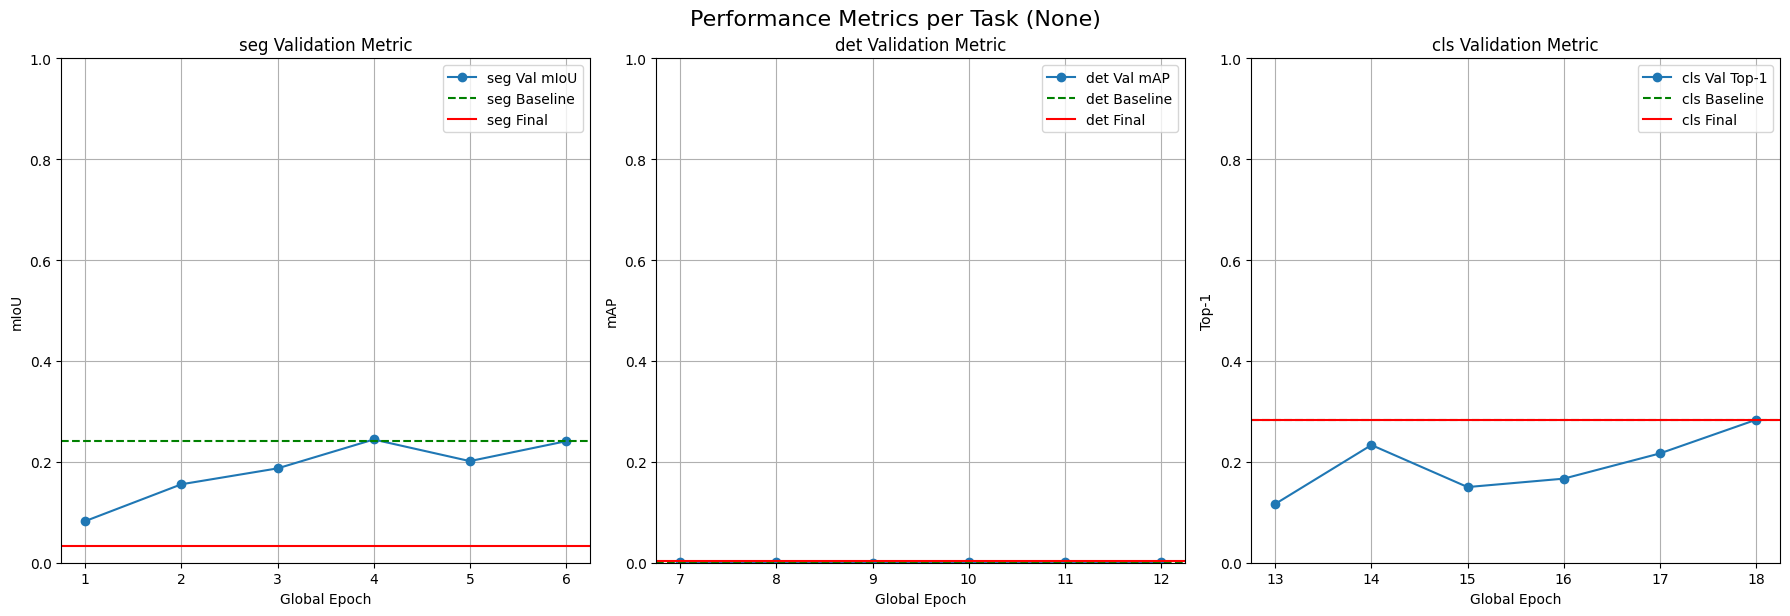



=== 使用抗災難性遺忘策略：EWC ===



----------------------------------------
開始訓練任務：seg, 階段：1/3, Epochs：6
----------------------------------------
Epoch 1/6, Task seg | Train Loss: 1.4461 | Train mIoU: 0.0986
評估結果 - Epoch 1/6, Task seg: Val Loss=1129680.6438, Val mIoU=0.1086
Epoch 2/6, Task seg | Train Loss: 1.0095 | Train mIoU: 0.2201
評估結果 - Epoch 2/6, Task seg: Val Loss=908369.3125, Val mIoU=0.1736
Epoch 3/6, Task seg | Train Loss: 0.8448 | Train mIoU: 0.2868
評估結果 - Epoch 3/6, Task seg: Val Loss=1075947.4792, Val mIoU=0.1909
Epoch 4/6, Task seg | Train Loss: 0.7203 | Train mIoU: 0.3741
評估結果 - Epoch 4/6, Task seg: Val Loss=865525.1875, Val mIoU=0.2044
Epoch 5/6, Task seg | Train Loss: 0.6327 | Train mIoU: 0.4564
評估結果 - Epoch 5/6, Task seg: Val Loss=881084.3021, Val mIoU=0.2194
Epoch 6/6, Task seg | Train Loss: 0.5474 | Train mIoU: 0.4910
評估結果 - Epoch 6/6, Task seg: Val Loss=821867.9292, Val mIoU=0.2598

任務 'seg' 階段訓練完成，總耗時 265.85 秒。
計算任務 'seg' 的 Fisher Information...
計算任務 'seg' 的 Fisher Information...
Fisher computatio


----------------------------------------
開始訓練任務：det, 階段：2/3, Epochs：6
----------------------------------------
Epoch 1/6, Task det | Train Loss: 18659.4944 | Train mAP: 0.0008 (Mitigation: EWC: 0.0001)
評估結果 - Epoch 1/6, Task det: Val Loss=15369.6339, Val mAP=0.0011
Epoch 2/6, Task det | Train Loss: 14286.6911 | Train mAP: 0.0023 (Mitigation: EWC: 0.0001)
評估結果 - Epoch 2/6, Task det: Val Loss=13174.6910, Val mAP=0.0009
Epoch 3/6, Task det | Train Loss: 12494.4645 | Train mAP: 0.0010 (Mitigation: EWC: 0.0001)
評估結果 - Epoch 3/6, Task det: Val Loss=12946.7161, Val mAP=0.0005
Epoch 4/6, Task det | Train Loss: 10130.7817 | Train mAP: 0.0027 (Mitigation: EWC: 0.0001)
評估結果 - Epoch 4/6, Task det: Val Loss=12814.5459, Val mAP=0.0028
Epoch 5/6, Task det | Train Loss: 9228.3759 | Train mAP: 0.0020 (Mitigation: EWC: 0.0001)
評估結果 - Epoch 5/6, Task det: Val Loss=12366.8985, Val mAP=0.0004
Epoch 6/6, Task det | Train Loss: 7729.8947 | Train mAP: 0.0030 (Mitigation: EWC: 0.0001)
評估結果 - Epoch 6/6, Task d


----------------------------------------
開始訓練任務：cls, 階段：3/3, Epochs：6
----------------------------------------


In [ ]:
# @title 統一單頭多任務挑戰實作 (最終增強版)
# 安裝所需庫
!pip install torch torchvision torchaudio timm segmentation-models-pytorch opencv-python matplotlib scikit-learn -q # Add scikit-learn for metrics

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
# Import FPN directly from torchvision.ops
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
import timm
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import cv2 as cv # Use OpenCV for image loading
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any, Optional
from collections import OrderedDict # Needed for FPN input
import random
from sklearn.metrics import confusion_matrix # Use sklearn for confusion matrix (for mIoU)
# from COCOeval import COCOeval # Requires installing pycocotools and COCO dataset format - too complex for inline example


# 設定設備
# 使用 torch.cuda.is_available() 檢查 CUDA 是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

# VOC 顏色映射，用於分割任務
VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
]
VOC_COLORMAP_ARRAY = np.array(VOC_COLORMAP, dtype=np.uint8)

# 定義 ReplayBuffer 類
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity  # 緩衝區的最大容量
        self.buffer = []  # 儲存數據的列表

    def add(self, data: Tuple[torch.Tensor, Any]):
        # 將數據添加到緩衝區，如果超過容量則移除最早的數據
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self, batch_size: int) -> List[Tuple[torch.Tensor, Any]]:
        # 從緩衝區隨機採樣指定數量的數據
        batch_size = min(batch_size, len(self.buffer))  # 確保批次大小不超過緩衝區大小
        if batch_size <= 0 or not self.buffer: # Check if buffer is empty
            return [] # Return empty list if no samples to draw
        return random.sample(self.buffer, batch_size)  # 隨機採樣


# 定義多任務數據集類 (使用 OpenCV 讀取圖片)
class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images: List[str] = []
        self.annotations: List[Any] = []
        self.image_sizes: List[Tuple[int, int]] = [] # Store original image sizes (width, height)

        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            try:
                with open(labels_path, 'r') as f:
                    labels_data = json.load(f)
            except json.JSONDecodeError:
                raise ValueError(f"無法解析 {labels_path}。請確認它是有效的 JSON 檔案。")


            image_dir = os.path.join(data_dir, 'data')
            if not os.path.exists(image_dir):
                 raise FileNotFoundError(f"找不到圖片目錄 {image_dir}！")

            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)

            # Build a mapping from image file name to its annotations and original size
            img_info_dict = {img['file_name']: {'id': img['id'], 'width': img['width'], 'height': img['height']} for img in labels_data.get('images', [])}
            ann_dict: Dict[int, List[Dict[str, Any]]] = {}
            for ann in labels_data.get('annotations', []): # Use .get for safety
                img_id = ann.get('image_id') # Use .get for safety
                if img_id is not None:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    # Ensure bbox is a list/tuple of 4 numbers and category_id is valid
                    # COCO bbox format is [x_min, y_min, width, height]
                    if isinstance(ann.get('bbox'), list) and len(ann['bbox']) == 4 and ann.get('category_id') is not None:
                         ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})


            # Collect valid image paths, annotations, and original sizes
            for file_name in image_files:
                 img_info = img_info_dict.get(file_name)
                 if img_info is not None:
                     img_id = img_info['id']
                     if img_id in ann_dict and ann_dict[img_id]: # Ensure there are annotations for this image
                         full_path = os.path.join(image_dir, file_name)
                         self.images.append(full_path)
                         self.annotations.append(ann_dict[img_id])
                         self.image_sizes.append((img_info['width'], img_info['height'])) # Store (width, height)
                 # else: Image exists but no corresponding entry in labels.json or no annotations

        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img_file in image_files:
                img_path = os.path.join(data_dir, img_file)
                # Assuming mask file has same name but .png extension
                mask_path = os.path.join(data_dir, os.path.splitext(img_file)[0] + '.png')
                if os.path.exists(mask_path):
                    # Need to read image once to get size for segmentation, assuming mask has same size
                    try:
                        img = cv.imread(img_path)
                        if img is not None:
                            self.images.append(img_path)
                            self.annotations.append(mask_path)
                            self.image_sizes.append((img.shape[1], img.shape[0])) # Store (width, height)
                        else:
                             print(f"警告: 無法讀取圖片獲取尺寸 {img_path}，跳過。")
                    except Exception as e:
                         print(f"警告: 讀取圖片尺寸時發生錯誤 {img_path}: {e}，跳過。")

        elif task == 'cls':
            if not os.path.exists(data_dir):
                 raise FileNotFoundError(f"找不到分類數據目錄：{data_dir}")
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            if not label_dirs:
                 raise ValueError(f"在 {data_dir} 中未找到任何子目錄作為類別資料夾。")

            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img_file in files:
                        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')): # Check for common image extensions, lower() for case insensitivity
                            img_path = os.path.join(root, img_file)
                            # Read image to get size
                            try:
                                img = cv.imread(img_path)
                                if img is not None:
                                    self.images.append(img_path)
                                    self.annotations.append(label_to_index[label])
                                    self.image_sizes.append((img.shape[1], img.shape[0])) # Store (width, height)
                                else:
                                     print(f"警告: 無法讀取圖片獲取尺寸 {img_path}，跳過。")
                            except Exception as e:
                                 print(f"警告: 讀取圖片尺寸時發生錯誤 {img_path}: {e}，跳過。")


        # Final check for empty dataset
        if len(self.images) == 0:
             raise ValueError(f"在 {data_dir} 中未找到任何有效的數據用於任務 '{self.task}'，請檢查資料結構和檔案副檔名！")
        else:
            print(f"找到 {len(self.images)} 張圖片用於任務 '{self.task}'")


    def convert_mask_rgb_to_indices(self, mask_rgb: np.ndarray) -> np.ndarray:
        """Converts an RGB segmentation mask to a mask of class indices."""
        # Ensure mask_rgb is in RGB format (shape HxWx3)
        if mask_rgb.ndim != 3 or mask_rgb.shape[2] != 3:
             # Convert grayscale to RGB if needed (e.g., L or P mode masks saved as 1 channel)
             if mask_rgb.ndim == 2:
                  # Convert to HxWx1 and then to HxWx3 by repeating
                  mask_rgb = np.repeat(mask_rgb[:, :, np.newaxis], 3, axis=2)
             else:
                raise ValueError("Input mask must be HxW or HxWx3 format")


        height, width = mask_rgb.shape[:2]
        # Initialize index mask with a default value (e.g., 255 for ignore index, or 0 for background)
        # Using 0 assumes background color [0,0,0] maps to class 0.
        mask_indices = np.zeros((height, width), dtype=np.int64)

        # Use a dictionary lookup for faster color to index conversion
        rgb_to_index = {tuple(map(int, color)): i for i, color in enumerate(VOC_COLORMAP_ARRAY)} # Ensure colors are tuples of ints


        # Iterate through flattened pixels and assign index
        mask_flat = mask_rgb.reshape(-1, 3)
        mask_indices_flat = mask_indices.reshape(-1)

        for i in range(mask_flat.shape[0]):
             # Convert pixel color to tuple of ints for dictionary lookup
             pixel_color = tuple(map(int, mask_flat[i]))
             if pixel_color in rgb_to_index:
                  mask_indices_flat[i] = rgb_to_index[pixel_color]
             # Pixels not matching any color in colormap will remain 0 (background)

        return mask_indices


    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Any]:
        img_path = self.images[idx]
        original_width, original_height = self.image_sizes[idx]
        input_size = (512, 512) # Target model input size (width, height)

        # --- Image Loading and Resizing ---
        img = cv.imread(img_path)
        if img is None:
            # Try reading with PIL if OpenCV fails for some formats
            try:
                 img_pil = Image.open(img_path).convert("RGB")
                 img_resized_pil = img_pil.resize(input_size, Image.BILINEAR)
                 img_resized = np.array(img_resized_pil) # Convert PIL image to numpy array
                 # PIL image is already RGB
            except Exception as e:
                 raise ValueError(f"無法讀取或處理圖片：{img_path} - {e}")
        else:
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # Convert BGR to RGB
            # Resize image using OpenCV before converting to Tensor
            img_resized = cv.resize(img, input_size, interpolation=cv.INTER_LINEAR)


        # Convert resized image (numpy HxWx3) to Tensor and normalize [0, 1]
        img_tensor = torch.tensor(img_resized, dtype=torch.float32).permute(2, 0, 1) / 255.0 # Permute from HxWx3 to CxHxW

        # Apply the remaining transforms (normalization)
        if self.transform:
             img_tensor = self.transform(img_tensor)

        # --- Annotation/Target Loading and Processing ---
        if self.task == 'seg':
            mask_path = self.annotations[idx]
            # Use OpenCV to read mask
            mask_rgb = cv.imread(mask_path)
            if mask_rgb is None:
                # Try reading with PIL if OpenCV fails
                try:
                    mask_pil = Image.open(mask_path)
                    # Convert to RGB just in case it's P or L mode
                    mask_rgb_pil = mask_pil.convert("RGB")
                    mask_resized_pil = mask_rgb_pil.resize(input_size, Image.NEAREST) # Resize mask with NEAREST
                    mask_resized = np.array(mask_resized_pil) # Convert PIL image to numpy array
                except Exception as e:
                     raise ValueError(f"無法讀取或處理遮罩：{mask_path} - {e}")
            else:
                mask_rgb = cv.cvtColor(mask_rgb, cv.COLOR_BGR2RGB) # Convert BGR to RGB
                # Resize mask using Nearest Neighbor interpolation to preserve discrete labels
                mask_resized = cv.resize(mask_rgb, input_size, interpolation=cv.INTER_NEAREST)


            # Convert RGB mask to class indices
            mask_indices = self.convert_mask_rgb_to_indices(mask_resized)

            # Convert index mask to LongTensor
            mask_tensor = torch.tensor(mask_indices, dtype=torch.long)

            return img_tensor, mask_tensor

        elif self.task == 'det':
            ann = self.annotations[idx] # ann is a list of dicts: [{'boxes': [x, y, w, h], 'labels': class_id}, ...]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)

            # Scale bounding boxes according to the resize from original image size to 512x512
            # COCO format is [x_min, y_min, width, height]
            scale_x = input_size[0] / original_width
            scale_y = input_size[1] / original_height

            # Apply scaling
            boxes[:, 0] *= scale_x # x_min
            boxes[:, 1] *= scale_y # y_min
            boxes[:, 2] *= scale_x # width
            boxes[:, 3] *= scale_y # height

            # Ensure boxes are within bounds [0, 512]
            # Clamp x_min, y_min to be at least 0
            boxes[:, 0] = torch.clamp(boxes[:, 0], min=0)
            boxes[:, 1] = torch.clamp(boxes[:, 1], min=0)
            # Clamp x_max, y_max to be at most 512
            # boxes[:, 2] is width, boxes[:, 3] is height
            # x_max = x_min + w, y_max = y_min + h
            boxes[:, 2] = torch.clamp(boxes[:, 0] + boxes[:, 2], max=input_size[0]) - boxes[:, 0] # New width
            boxes[:, 3] = torch.clamp(boxes[:, 1] + boxes[:, 3], max=input_size[1]) - boxes[:, 1] # New height

            # Filter out potentially invalid boxes after scaling (e.g., width or height becomes <= 0)
            valid_indices = (boxes[:, 2] > 1e-2) & (boxes[:, 3] > 1e-2) # Use small epsilon instead of 0
            boxes = boxes[valid_indices]
            labels = labels[valid_indices]

            # Return a dictionary of tensors for detection targets
            target_dict = {'boxes': boxes, 'labels': labels, 'original_size': (original_width, original_height), 'resized_size': input_size}
            return img_tensor, target_dict

        elif self.task == 'cls':
            # Annotation is already the class index
            label_tensor = torch.tensor(self.annotations[idx], dtype=torch.long)
            return img_tensor, label_tensor

        else:
             # Should not happen if tasks are 'det', 'seg', 'cls'
             print(f"Warning: Task '{self.task}' not recognized.")
             return img_tensor, None # Return None for target if task is unknown


# Define image pre-processing transform (Normalization only)
# Resizing and ToTensor are handled in __getitem__ using OpenCV and torch.tensor
image_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom collate function for detection (handles list of dicts)
def custom_collate_det(batch: List[Tuple[torch.Tensor, Optional[Dict[str, Any]]]]) -> Tuple[torch.Tensor, List[Dict[str, torch.Tensor]]]:
    # Batch is a list of tuples: [(img1, target1), (img2, target2), ...]
    # where target is a dict {'boxes': ..., 'labels': ...} or None
    # Filter out samples where target is None or not a dict (shouldn't happen with corrected dataset, but defensive)
    batch = [item for item in batch if item[1] is not None and isinstance(item[1], dict)]
    if not batch:
        # Handle empty batch case - return empty tensors/lists with correct types/shapes
        # Assuming image tensor shape is [C, H, W] i.e., [3, 512, 512] after processing in dataset
        dummy_img = torch.empty(3, 512, 512)
        return dummy_img.unsqueeze(0).repeat(0, 1, 1, 1), [] # Return empty tensor with correct shape [0, 3, 512, 512]

    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch] # Keep targets as a list of dicts
    return images, targets

# Custom collate for other tasks (handles tensors) - default_collate works fine
# For seg and cls, the targets are single tensors, default_collate stacks them.

# Create Datasets and DataLoaders
base_dir = "/content/Unified-OneHead-Multi-Task-Challenge/data"
train_datasets = {}
val_datasets = {}

tasks_list = ['seg', 'det', 'cls'] # Define the tasks order for dataset loading

for task in tasks_list:
    try:
        # Adjust paths based on task name convention in your data directory
        if task == 'det':
             task_data_dir = "mini_coco_det"
        elif task == 'seg':
             task_data_dir = "mini_voc_seg"
        elif task == 'cls':
             task_data_dir = "imagenette_160"
        else:
             raise ValueError(f"Unknown task: {task}")

        train_path = os.path.join(base_dir, task_data_dir, 'train')
        val_path = os.path.join(base_dir, task_data_dir, 'val')

        train_datasets[task] = MultiTaskDataset(train_path, task, image_transform)
        val_datasets[task] = MultiTaskDataset(val_path, task, image_transform)

    except ValueError as e:
        print(f"資料載入失敗 ({task} 任務): {e}")
        # Store empty datasets if loading failed, so loaders will be empty
        train_datasets[task] = []
        val_datasets[task] = []


# Create DataLoaders
# Use robust error handling for empty datasets/loaders
train_loaders = {}
val_loaders = {}

for task in tasks_list:
    if task in train_datasets and train_datasets[task] and len(train_datasets[task]) > 0:
        collate_fn = custom_collate_det if task == 'det' else None
        train_loaders[task] = DataLoader(train_datasets[task], batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
    else:
         print(f"警告: 任務 '{task}' 的訓練數據集為空或無效。將跳過此任務的訓練。")
         train_loaders[task] = [] # Use an empty list to indicate no loader

    if task in val_datasets and val_datasets[task] and len(val_datasets[task]) > 0:
        collate_fn = custom_collate_det if task == 'det' else None
        val_loaders[task] = DataLoader(val_datasets[task], batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn)
    else:
         print(f"警告: 任務 '{task}' 的驗證數據集為空或無效。將跳過此任務的驗證。")
         val_loaders[task] = [] # Use an empty list


# Model Definition
class MultiTaskModel(nn.Module):
    def __init__(self, C_det=10, C_seg=21, C_cls=10):
        super(MultiTaskModel, self).__init__()
        # Use EfficientNet-B0 as the backbone returning multiple features
        # Set norm_layer to make BatchNorm trainable if needed
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, features_only=True, norm_layer=nn.BatchNorm2d)

        # Get channel counts for the specific layers used in FPN
        # Use feat2, feat3, feat4 (indices 2, 3, 4) for strides 8, 16, 32
        feature_info = self.backbone.feature_info
        # Check if feature_info has enough layers
        if len(feature_info.channels()) < 5: # We need at least feat0 to feat4
             raise ValueError("Backbone does not return enough feature layers for FPN (expected at least 5).")

        in_channels_list = [feature_info.channels()[i] for i in [2, 3, 4]] # Channels for feat2, feat3, feat4: [40, 112, 320]
        fpn_out_channels = 128 # FPN output channel size

        # Neck: FPN
        # Provide names for FPN input layers corresponding to the selected features
        # Use keys '0', '1', '2' for FPN input based on increasing stride
        fpn_in_keys = ['0', '1', '2'] # Keys for FPN input dict corresponding to features[2], features[3], features[4]
        self.fpn = FeaturePyramidNetwork(
            in_channels_list,
            out_channels=fpn_out_channels,
            extra_blocks=LastLevelMaxPool(), # Add a P5 layer keyed as 'pool' by default
            # FPN output keys will be the same as input keys plus 'pool' if extra_blocks is used
        )
        # The FPN output will be an OrderedDict with keys like {'0': P2, '1': P3, '2': P4, 'pool': P5}

        # Shared Feature Processing after FPN
        # Let's use the P4 level output from FPN (key '2', stride 32) for shared processing.
        # P4 spatial resolution for 512x512 input is 512/32 = 16x16.
        # P4 output channels are fpn_out_channels (128).
        self.shared_conv = nn.Sequential(
             # Input from FPN P4 (key '2')
             nn.Conv2d(fpn_out_channels, 64, kernel_size=3, padding=1),
             nn.ReLU(inplace=True)
        )
        shared_features_channels = 64

        # Task-Specific Heads
        # Detection head operates on spatial feature maps (output from shared_conv)
        # Predict (cx, cy, w, h, conf, class_id) per grid cell (16x16 grid)
        # Note: C_det here refers to the number of object classes, the output is 6 values per grid cell.
        # The 6th value could be class index or a one-hot encoding if you have multiple classes per grid.
        # Given C_det classes, the output should maybe be 4 (box) + 1 (conf) + C_det (class scores)
        # Let's follow the original (cx, cy, w, h, conf, class_id) structure which implies 6 channels.
        # This 6-channel output format is unusual for multi-class detection per grid cell.
        # A common approach is 4+1+num_classes or similar.
        # Stick to 6 channels as per original head definition. The last channel is likely intended as the class ID.
        self.det_head = nn.Conv2d(shared_features_channels, 6, kernel_size=1) # Output 6 channels per grid cell

        # Segmentation head needs high resolution output (512x512, C_seg channels)
        # Upsample from the shared features (16x16, 64 channels).
        self.seg_head = nn.Sequential(
            nn.Conv2d(shared_features_channels, C_seg, kernel_size=1), # Output C_seg channels per spatial location
            # Use interpolation mode 'nearest-exact' or 'bilinear' + align_corners=False for recent PyTorch versions
            # 'bilinear' is better for continuous features, 'nearest'/'nearest-exact' for discrete masks.
            # FPN output is features, so 'bilinear' is appropriate here before the final Conv1d to class scores.
            # The output of seg_head conv1d is raw scores, upsampling that with bilinear is fine.
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False) # Upsample to input resolution
        )

        # Classification head operates on a global feature vector.
        # Apply Global Average Pooling and Linear layers to the shared features.
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # Pool over 16x16 spatial size to get 1x1
            nn.Flatten(),            # Flatten 1x1x64 to 64
            nn.Linear(shared_features_channels, C_cls) # Input channels = 64, Output channels = 10
        )


    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Get feature layers from backbone
        features = self.backbone(x) # List: [feat0..feat4]

        # Select features for FPN input (strides 8, 16, 32)
        selected_features = OrderedDict()
        if len(features) < 5:
             raise RuntimeError(f"Backbone features list has unexpected length {len(features)}. Expected at least 5.")

        selected_features['0'] = features[2] # stride 8
        selected_features['1'] = features[3] # stride 16
        selected_features['2'] = features[4] # stride 32

        # Pass selected features to FPN
        fpn_outputs = self.fpn(selected_features) # OrderedDict: {'0': P2, '1': P3, '2': P4, 'pool': P5}

        # Select FPN level (P4, key '2') for shared head input
        fpn_level_key_for_head = '2'
        if fpn_level_key_for_head not in fpn_outputs:
             raise RuntimeError(f"FPN output does not contain expected key '{fpn_level_key_for_head}'. Available keys: {fpn_outputs.keys()}")

        shared_features_input = fpn_outputs[fpn_level_key_for_head] # P4 level, shape [batch, 128, 16, 16]

        # Pass through shared convolutional layers
        shared_features = self.shared_conv(shared_features_input) # Output: [batch, 64, 16, 16]

        # Pass to task-specific heads
        det_out = self.det_head(shared_features) # Output: [batch, 6, 16, 16]
        seg_out = self.seg_head(shared_features) # Output: [batch, C_seg, 512, 512]
        cls_out = self.cls_head(shared_features) # Output: [batch, C_cls]

        return det_out, seg_out, cls_out


# Initialize Model
# C_det_actual = 10 # Mini-COCO-Det categories 1-10
# C_seg_actual = 21 # VOC classes 0-20 (including background)
# C_cls_actual = 10 # Imagenette classes

# Ensure these constants are defined globally or passed appropriately
# For a standalone block, let's define them again if they weren't in the previous one
C_det_actual = 10
C_seg_actual = 21
C_cls_actual = 10

model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)

# Count parameters
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total parameters: {total_params:,} (< 8M: {total_params < 8_000_000})")


# --- Loss Functions ---
# Simplified detection loss (MSE on first box coords)
def compute_detection_loss(det_output: torch.Tensor, targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
    boxes_pred = det_output.permute(0, 2, 3, 1)  # [batch_size, H, W, 6] H=W=16
    loss = torch.tensor(0., device=det_output.device)
    valid_samples = 0
    for i in range(len(targets)):
        if not isinstance(targets[i], dict) or 'boxes' not in targets[i] or len(targets[i]['boxes']) == 0:
            continue # Skip samples with no targets

        target_boxes = targets[i]['boxes'].to(det_output.device) # [num_boxes, 4] (x, y, w, h format)

        if boxes_pred.size(1) > 0 and boxes_pred.size(2) > 0:
            pred_cxcywh = boxes_pred[i, 0, 0, :4] # Predicted [cx, cy, w, h] from grid cell (0,0)

            # Convert target [x, y, w, h] to [cx, cy, w, h] for MSE
            target_cxcywh = torch.stack([
                target_boxes[0][0] + target_boxes[0][2] / 2,
                target_boxes[0][1] + target_boxes[0][3] / 2,
                target_boxes[0][2],
                target_boxes[0][3]
            ])

            loss += nn.MSELoss()(pred_cxcywh, target_cxcywh)
            valid_samples += 1

    return loss / valid_samples if valid_samples > 0 else torch.tensor(0., device=det_output.device)

# Segmentation loss (CrossEntropyLoss)
def compute_segmentation_loss(seg_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    criterion = nn.CrossEntropyLoss()
    if targets.size()[-2:] != seg_output.size()[-2:]:
         print(f"Error: Seg target size {targets.size()} does not match output size {seg_output.size()} in loss calculation.")
         return torch.tensor(0., device=seg_output.device)
    return criterion(seg_output, targets)

# Classification loss (CrossEntropyLoss)
def compute_classification_loss(cls_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    criterion = nn.CrossEntropyLoss()
    return criterion(cls_output, targets)


# --- Evaluation Functions ---
# Helper for IoU (numpy version)
def calculate_iou_np(box1: np.ndarray, box2: np.ndarray) -> float:
    x1_min, y1_min, w1, h1 = box1
    x1_max, y1_max = x1_min + w1, y1_min + h1
    x2_min, y2_min, w2, h2 = box2
    x2_max, y2_max = x2_min + w2, y2_min + h2

    x_left = max(x1_min, x2_min)
    y_top = max(y1_min, y2_min)
    x_right = min(x1_max, x2_max)
    y_bottom = min(y1_max, y2_max)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - intersection_area

    return intersection_area / union_area if union_area > 0 else 0.0

# Segmentation evaluation (mIoU)
def evaluate_segmentation(model: nn.Module, loader: DataLoader, num_classes: int = 21) -> Dict[str, float]:
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'mIoU': 0.0, 'loss': 0.0}

    model.eval()
    confusion_matrix_np = np.zeros((num_classes, num_classes), dtype=np.int64)
    total_loss = 0
    num_batches = 0
    criterion = nn.CrossEntropyLoss(reduction='sum') # Use sum reduction for calculating average loss

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            _, seg_out, _ = model(inputs) # seg_out: [batch, C_seg, 512, 512]

            # Calculate loss
            loss = criterion(seg_out, targets)
            total_loss += loss.item()
            num_batches += 1

            # Get predicted class for mIoU
            predicted_masks = torch.argmax(seg_out, dim=1) # [batch, 512, 512]

            if predicted_masks.size() != targets.size():
                 print(f"Warning: Evaluate Seg target size {targets.size()} != predicted size {predicted_masks.size()}. Skipping mIoU for batch.")
                 continue

            predicted_flat = predicted_masks.view(-1).cpu().numpy()
            targets_flat = targets.view(-1).cpu().numpy()

            # Update confusion matrix
            try:
                cm_batch = confusion_matrix(targets_flat, predicted_flat, labels=np.arange(num_classes))
                confusion_matrix_np += cm_batch
            except ValueError as e:
                 print(f"Warning: Error calculating confusion matrix for batch: {e}.")


    # Calculate mIoU
    true_positives = np.diag(confusion_matrix_np)
    false_positives = np.sum(confusion_matrix_np, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix_np, axis=1) - true_positives
    union = true_positives + false_positives + false_negatives
    iou_per_class = np.divide(true_positives.astype(np.float64), union.astype(np.float64), out=np.full(num_classes, np.nan), where=union != 0)
    valid_iou = iou_per_class[~np.isnan(iou_per_class)]
    mIoU = np.mean(valid_iou) if valid_iou.size > 0 else 0.0

    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0

    return {'mIoU': mIoU, 'loss': avg_loss}


# Detection evaluation (Simplified mAP placeholder)
def evaluate_detection(model: nn.Module, loader: DataLoader, iou_threshold: float = 0.5) -> Dict[str, float]:
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'mAP': 0.0, 'loss': 0.0}

    # print("Note: Detection evaluation (mAP) is a simplified placeholder.")

    model.eval()
    total_matched_predictions = 0
    total_predictions_with_target = 0
    total_loss = 0
    num_batches = 0
    criterion = compute_detection_loss # Use the same simplified loss for evaluation

    with torch.no_grad():
        for inputs, targets in loader:
            if inputs.size(0) == 0: continue
            inputs = inputs.to(device)

            det_out, _, _ = model(inputs) # det_out: [batch, 6, 16, 16]

            # Calculate loss
            loss = criterion(det_out, targets) # targets is list of dicts, handled by criterion
            total_loss += loss.item() if isinstance(loss, torch.Tensor) else loss # Handle scalar or tensor loss
            num_batches += 1

            # --- Simplified Matching for Placeholder mAP ---
            boxes_pred = det_out.permute(0, 2, 3, 1)  # [batch_size, 16, 16, 6]

            for i in range(inputs.size(0)): # Process each image in batch
                 img_predictions = boxes_pred[i].view(-1, 6) # [256, 6]
                 conf_scores = img_predictions[:, 4]
                 conf_threshold = 0.2 # Example confidence threshold
                 confident_predictions = img_predictions[conf_scores > conf_threshold] # [N_pred, 6]

                 if confident_predictions.size(0) == 0:
                      continue

                 predicted_boxes_cxcywh = confident_predictions[:, :4]
                 predicted_boxes_xywh = torch.stack([ # Convert to [x_min, y_min, w, h]
                     predicted_boxes_cxcywh[:, 0] - predicted_boxes_cxcywh[:, 2] / 2,
                     predicted_boxes_cxcywh[:, 1] - predicted_boxes_cxcywh[:, 3] / 2,
                     predicted_boxes_cxcywh[:, 2],
                     predicted_boxes_cxcywh[:, 3]
                 ], dim=1) # [N_pred, 4]

                 # Get ground truth boxes (already scaled in dataset)
                 if not isinstance(targets[i], dict) or 'boxes' not in targets[i] or len(targets[i]['boxes']) == 0:
                      total_predictions_with_target += confident_predictions.size(0)
                      continue

                 ground_truth_boxes_xywh = targets[i]['boxes'].to(device) # [N_gt, 4] (x, y, w, h)

                 matched_preds_in_image = 0
                 total_predictions_with_target += confident_predictions.size(0)

                 if ground_truth_boxes_xywh.size(0) > 0:
                      # Compute IoUs between all predicted boxes and all GT boxes
                      for pred_box_xywh in predicted_boxes_xywh:
                           ious = [calculate_iou_np(pred_box_xywh.cpu().numpy(), gt_box_xywh.cpu().numpy()) for gt_box_xywh in ground_truth_boxes_xywh]
                           if any(iou > iou_threshold for iou in ious):
                                matched_preds_in_image += 1

                 total_matched_predictions += matched_preds_in_image


    simplified_ap = total_matched_predictions / total_predictions_with_target if total_predictions_with_target > 0 else 0.0
    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0

    return {'mAP': simplified_ap, 'loss': avg_loss}


# Classification evaluation (Top-1 and Top-5 Accuracy)
def evaluate_classification(model: nn.Module, loader: DataLoader) -> Dict[str, float]:
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'Top-1': 0.0, 'Top-5': 0.0, 'loss': 0.0}

    model.eval()
    total_samples = 0
    top1_correct = 0
    top5_correct_sum = 0 if C_cls_actual >= 5 else -1 # Use sum for correctness count
    total_loss = 0
    num_batches = 0
    criterion = nn.CrossEntropyLoss(reduction='sum') # Use sum reduction for average loss

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            _, _, cls_out = model(inputs) # cls_out: [batch, C_cls]

            # Calculate loss
            loss = criterion(cls_out, targets)
            total_loss += loss.item()
            num_batches += 1

            # Top-1 Accuracy
            _, predicted = cls_out.max(1)
            total_samples += targets.size(0)
            top1_correct += (predicted == targets).sum().item()

            # Top-5 Accuracy (if C_cls >= 5)
            if C_cls_actual >= 5:
                _, top5_preds = cls_out.topk(5, dim=1, largest=True, sorted=True) # [batch, 5]
                targets_expanded = targets.view(-1, 1) # [batch_size, 1]
                top5_correct_sum += (targets_expanded == top5_preds).any(dim=1).sum().item()

    metrics = {}
    metrics['Top-1'] = top1_correct / total_samples if total_samples > 0 else 0.0
    if C_cls_actual >= 5:
        metrics['Top-5'] = top5_correct_sum / total_samples if total_samples > 0 else 0.0
    else:
         metrics['Top-5'] = float('nan') # Indicate not applicable

    metrics['loss'] = total_loss / num_batches if num_batches > 0 else 0.0

    return metrics


# --- 抗災難性遺忘策略實現 (ReplayBuffer, EWC, LwF, KD 已在前面或上面定義) ---

# Fisher Information 計算函數 (用於 EWC)
def compute_fisher(model: nn.Module, dataloader: DataLoader, task: str) -> Dict[str, torch.Tensor]:
    """Computes the diagonal Fisher Approximation for EWC."""
    if len(dataloader) == 0 or dataloader.dataset is None or len(dataloader.dataset) == 0:
         print(f"警告: 任務 '{task}' 的載入器為空或無效，無法計算 Fisher Information。")
         return {}

    model.eval() # Compute Fisher in eval mode
    fisher: Dict[str, torch.Tensor] = {}
    # Use a temporary criterion to get gradients for the task
    try:
        criterion = get_loss_function(task)
    except ValueError:
        print(f"警告: 無法為任務 '{task}' 找到有效的損失函數來計算 Fisher。")
        return {}

    dummy_optimizer = optim.Adam(model.parameters(), lr=0) # Dummy optimizer

    num_batches = 0
    print(f"計算任務 '{task}' 的 Fisher Information...")

    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        if task != 'det' and isinstance(targets, torch.Tensor):
            targets = targets.to(device)

        dummy_optimizer.zero_grad()

        det_out, seg_out, cls_out = model(inputs)

        # Compute loss for the task
        if task == 'det':
             loss = criterion(det_out, targets)
        elif task == 'seg':
             loss = criterion(seg_out, targets)
        elif task == 'cls':
             loss = criterion(cls_out, targets)
        else:
             loss = None # Should not happen

        if loss is not None and isinstance(loss, torch.Tensor) and loss.requires_grad and loss.item() > 0:
            loss.backward()

            # Accumulate squared gradients
            for name, param in model.named_parameters():
                if param.grad is not None and param.requires_grad: # Only accumulate for trainable params that got gradients
                    if name not in fisher:
                        fisher[name] = param.grad.data.clone().pow(2)
                    else:
                        fisher[name] += param.grad.data.clone().pow(2)

            num_batches += 1
            # Optional: Limit batches for faster Fisher computation during debugging
            # if num_batches >= 50:
            #    break


    # Average the Fisher Information
    if num_batches > 0:
        for name in fisher.keys():
            fisher[name] /= num_batches
        print(f"Fisher computation finished for task '{task}' over {num_batches} batches.")
        return fisher
    else:
        print(f"警告: 未能為任務 '{task}' 計算 Fisher Information，所有損失或梯度為零。")
        return {}


# EWC Loss function
def ewc_loss(model: nn.Module, fisher_dict: Dict[str, torch.Tensor], old_params: Dict[str, torch.Tensor], lambda_ewc: float = 0.5) -> torch.Tensor:
    """Calculates the EWC regularization loss."""
    loss = torch.tensor(0., device=device)
    for name, param in model.named_parameters():
        # Only apply EWC to parameters present in the Fisher dict and old_params
        if name in fisher_dict and name in old_params:
            # Ensure components are on the same device as param.grad or param
            fisher = fisher_dict[name].to(param.device) # Ensure Fisher is on the parameter's device
            old_param = old_params[name].to(param.device) # Ensure old_param is on the parameter's device
            # Ensure shapes match (should if loaded correctly)
            if param.shape == old_param.shape and fisher.shape == param.shape:
                 # Only add loss if the parameter requires gradient in the current training step
                 # This check might be implicit if param.grad is checked later, but explicit is safer
                 # The original EWC formulation usually applies to all parameters from previous tasks.
                 # Check param.requires_grad to see if this parameter is currently trainable.
                 # However, the Fisher is for *all* trainable params from the previous task.
                 # Let's apply EWC to all params that were in the Fisher/old_params dict.
                 loss += (fisher * (param - old_param) ** 2).sum()
            else:
                 print(f"Warning: Shape mismatch for {name} in EWC. Param: {param.shape}, OldParam: {old_param.shape}, Fisher: {fisher.shape}. Skipping EWC term.")
        # else: parameter is new, or not in fisher/old_params for this task, skip EWC term

    return lambda_ewc * loss


# LwF Loss function
def lwf_loss(student_outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
             teacher_outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
             current_task: str, lambda_lwf: float = 1.0) -> torch.Tensor:
    """Calculates the Learning without Forgetting (LwF) regularization loss."""
    # LwF applies KL divergence between student and teacher outputs for PREVIOUS tasks on CURRENT task data.

    student_det, student_seg, student_cls = student_outputs
    teacher_det, teacher_seg, teacher_cls = teacher_outputs # Outputs from teacher model on the same inputs

    loss = torch.tensor(0., device=student_det.device)
    kl_criterion = nn.KLDivLoss(reduction='batchmean') # Use batchmean reduction

    # Apply KL divergence for tasks *other than* the current task
    # Compare student's output for a PREVIOUS task head with the teacher's output for that same head.

    if current_task != 'det':
        # LwF loss for detection head output
        # Ensure shapes match
        if student_det.shape == teacher_det.shape:
             # KLDivLoss expects log probabilities for input (student) and probabilities for target (teacher)
             loss += kl_criterion(torch.log_softmax(student_det, dim=1), torch.softmax(teacher_det.detach(), dim=1)) # Use detach on teacher output
        # else: Warning handled in train_stage if needed

    if current_task != 'seg':
        # LwF loss for segmentation head output
        if student_seg.shape == teacher_seg.shape:
             loss += kl_criterion(torch.log_softmax(student_seg, dim=1), torch.softmax(teacher_seg.detach(), dim=1)) # Use detach on teacher output
        # else: Warning handled in train_stage if needed

    if current_task != 'cls':
        # LwF loss for classification head output
        if student_cls.shape == teacher_cls.shape:
             loss += kl_criterion(torch.log_softmax(student_cls, dim=1), torch.softmax(teacher_cls.detach(), dim=1)) # Use detach on teacher output
        # else: Warning handled in train_stage if needed

    return lambda_lwf * loss


# Knowledge Distillation Loss (Typically applied to classification head)
def knowledge_distillation_loss(student_cls_output: torch.Tensor, old_model_cls_output: torch.Tensor,
                                temperature: float = 1.0, lambda_kd: float = 1.0) -> torch.Tensor:
    """Calculates Knowledge Distillation loss for classification (comparing soft logits)."""
    # student_cls_output: [batch_size, C_cls]
    # old_model_cls_output: [batch_size, C_cls] (from teacher/old model)

    # Apply temperature scaling to soften the logits
    # Ensure teacher output is detached
    soft_student_cls = torch.log_softmax(student_cls_output / temperature, dim=1)
    soft_old_model_cls = torch.softmax(old_model_cls_output.detach() / temperature, dim=1)

    kl_criterion = nn.KLDivLoss(reduction='batchmean')

    # Scale loss by temperature**2 as per Hinton's distillation paper
    loss = kl_criterion(soft_student_cls, soft_old_model_cls) * (temperature ** 2)

    return lambda_kd * loss


# Replay Buffer (Class already defined)


# --- Training Stage Function ---

def get_loss_function(task: str):
    """Helper to get the appropriate loss function for a task."""
    if task == 'det':
        return compute_detection_loss
    elif task == 'seg':
        return compute_segmentation_loss
    elif task == 'cls':
        return compute_classification_loss
    else:
        raise ValueError(f"Unknown task: {task}")

def get_eval_function(task: str):
    """Helper to get the appropriate evaluation function for a task."""
    if task == 'det':
        return evaluate_detection # Returns {'mAP': value, 'loss': value}
    elif task == 'seg':
        return evaluate_segmentation # Returns {'mIoU': value, 'loss': value}
    elif task == 'cls':
        return evaluate_classification # Returns {'Top-1': value, 'Top-5': value, 'loss': value}
    else:
        raise ValueError(f"Unknown task: {task}")


def evaluate_model(model: nn.Module, loader: DataLoader, task: str) -> Dict[str, float]:
    """Helper function to perform evaluation and return metrics including loss."""
    if not loader or len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         print(f"警告: 任務 '{task}' 的驗證載入器為空或無效，跳過評估。")
         # Return default metrics with 0.0 loss
         if task == 'seg': return {'mIoU': 0.0, 'loss': 0.0}
         elif task == 'det': return {'mAP': 0.0, 'loss': 0.0}
         elif task == 'cls': return {'Top-1': 0.0, 'Top-5': 0.0, 'loss': 0.0}
         else: return {'loss': 0.0}

    eval_fn = get_eval_function(task)
    metrics = eval_fn(model, loader)
    return metrics


def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int,
                optimizer: optim.Optimizer, scheduler: optim.lr_scheduler._LRScheduler,
                replay_buffers: Dict[str, ReplayBuffer], tasks_order: List[str], stage: int,
                mitigation_methods: List[str],
                ewc_fisher: Optional[Dict[str, torch.Tensor]] = None,
                ewc_old_params: Optional[Dict[str, torch.Tensor]] = None,
                lwf_teacher_model: Optional[nn.Module] = None
               ) -> Tuple[List[Dict[str, float]], List[Dict[str, float]], Dict[str, float]]: # Return train_metrics_history too
    """Trains the model for a specific task with optional mitigation methods and evaluates each epoch."""

    print(f"\n{'--'*20}\n開始訓練任務：{task}, 階段：{stage + 1}/{len(tasks_order)}, Epochs：{epochs}\n{'--'*20}")

    train_metrics_history: List[Dict[str, float]] = [] # Store metrics after each epoch's training
    val_metrics_history: List[Dict[str, float]] = [] # Store metrics after each epoch's evaluation

    current_task_loss_fn = get_loss_function(task)
    current_task_eval_fn = get_eval_function(task)


    for epoch in range(epochs):
        model.train()
        epoch_start_time = time.time()
        total_train_loss = 0
        num_train_batches = 0

        # Variables to accumulate metrics for the training set evaluation after the epoch
        # Note: Evaluating on the full training set after every epoch can be slow.
        # A faster approach might be to evaluate on a subset or skip some epochs.
        # For now, let's implement evaluation on the full train loader.
        # These variables will accumulate predictions/targets similar to validation evaluation.
        # ... (Initialization for train metrics accumulation based on task) ...
        # Since evaluation functions already iterate through a loader, let's just call them
        # with the train_loader after the training loop for the epoch.

        if train_loader and len(train_loader) > 0:
            # Training loop for the epoch
            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                if task != 'det' and isinstance(targets, torch.Tensor):
                    targets = targets.to(device)

                optimizer.zero_grad()
                student_det, student_seg, student_cls = model(inputs)
                student_outputs = (student_det, student_seg, student_cls)

                # --- Compute Current Task Loss ---
                if task == 'det':
                     task_loss = current_task_loss_fn(student_det, targets)
                elif task == 'seg':
                     task_loss = current_task_loss_fn(student_seg, targets)
                elif task == 'cls':
                     task_loss = current_task_loss_fn(student_cls, targets)
                else:
                     task_loss = torch.tensor(0., device=device) # Should not happen


                total_loss = task_loss # Start total loss with current task loss

                # --- Apply Mitigation Strategies ---
                method_losses_dict = {} # Dictionary to store loss components for logging

                # EWC: Applied for tasks AFTER the first one
                if 'EWC' in mitigation_methods and stage > 0 and ewc_fisher and ewc_old_params:
                    ewc = ewc_loss(model, ewc_fisher, ewc_old_params)
                    total_loss += ewc
                    method_losses_dict['EWC'] = ewc.item()

                # LwF / KD: Applied for tasks AFTER the first one
                if ('LwF' in mitigation_methods or 'KD' in mitigation_methods) and stage > 0 and lwf_teacher_model:
                    lwf_teacher_model.eval() # Set teacher to eval mode
                    with torch.no_grad():
                         teacher_det, teacher_seg, teacher_cls = lwf_teacher_model(inputs)
                         teacher_outputs = (teacher_det, teacher_seg, teacher_cls)

                    if 'LwF' in mitigation_methods:
                        lwf = lwf_loss(student_outputs, teacher_outputs, task)
                        total_loss += lwf
                        method_losses_dict['LwF'] = lwf.item()

                    if 'KD' in mitigation_methods:
                         # KD is typically applied to the classification head
                         # Pass student cls output and teacher cls output
                         if student_cls.shape == teacher_cls.shape:
                             kd_loss = knowledge_distillation_loss(student_cls, teacher_cls)
                             total_loss += kd_loss
                             method_losses_dict['KD'] = kd_loss.item()
                         else:
                             print(f"Warning: KD Cls output shape mismatch. Student: {student_cls.shape}, Teacher: {teacher_cls.shape}. Skipping KD.")



                # Replay: Can be applied from the second task onwards (stage > 0)
                if 'Replay' in mitigation_methods and stage > 0:
                    replay_total_loss_across_prev_tasks = torch.tensor(0., device=device)
                    replay_sample_count_across_prev_tasks = 0

                    # Sample from buffers of *previous* tasks
                    for prev_task in tasks_order[:stage]: # Iterate through tasks trained BEFORE the current one
                        buffer = replay_buffers[prev_task]
                        # Sample a small batch from the replay buffer (e.g., same size as current batch)
                        replay_batch_size = min(train_loader.batch_size, len(buffer.buffer))
                        if replay_batch_size > 0:
                             buffer_samples = buffer.sample(batch_size=replay_batch_size)
                             for b_inputs, b_targets in buffer_samples:
                                b_inputs = b_inputs.to(device)
                                # Move buffer targets to device and handle different types
                                if prev_task == 'det':
                                     b_targets_on_device = []
                                     if isinstance(b_targets, list): # Defensive check
                                         for t_dict in b_targets:
                                             if isinstance(t_dict, dict): # Defensive check
                                                 t_dict_on_device = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t_dict.items()}
                                                 b_targets_on_device.append(t_dict_on_device)
                                     b_targets = b_targets_on_device # Use the potentially empty list

                                elif prev_task in ['seg', 'cls'] and isinstance(b_targets, torch.Tensor):
                                     b_targets = b_targets.to(device)
                                else:
                                     # Unexpected buffer target type or empty/invalid data
                                     continue # Skip this sample

                                # Get model outputs for replayed data
                                b_student_det, b_student_seg, b_student_cls = model(b_inputs)

                                # Compute loss for the *original task* of the replayed data
                                prev_task_loss_fn = get_loss_function(prev_task)

                                if prev_task == 'det':
                                     replay_task_loss = prev_task_loss_fn(b_student_det, b_targets)
                                elif prev_task == 'seg':
                                     replay_task_loss = prev_task_loss_fn(b_student_seg, b_targets)
                                elif prev_task == 'cls':
                                     replay_task_loss = prev_task_loss_fn(b_student_cls, b_targets)
                                else:
                                     replay_task_loss = torch.tensor(0., device=device) # Should not happen

                                if replay_task_loss is not None and isinstance(replay_task_loss, torch.Tensor) and replay_task_loss.item() > 0:
                                     replay_total_loss_across_prev_tasks += replay_task_loss
                                     replay_sample_count_across_prev_tasks += 1 # Count valid loss contributions

                    if replay_sample_count_across_prev_tasks > 0:
                         # Average replay loss over samples that contributed and add to total loss
                         # Consider weighting replay loss if needed
                         lambda_replay = 1.0
                         avg_replay_loss = replay_total_loss_across_prev_tasks / replay_sample_count_across_prev_tasks * lambda_replay
                         total_loss += avg_replay_loss
                         method_losses_dict['Replay'] = avg_replay_loss.item()


                # Placeholder for POCL and SSR (not implemented realistically)
                # if 'POCL' in mitigation_methods: # Needs implementation
                #    pocl = pocl_simulate(...)
                #    total_loss += pocl
                #    method_losses_dict['POCL'] = pocl.item()
                # if 'SSR' in mitigation_methods: # Needs implementation
                #    ssr = ssr_simulate(...)
                #    total_loss += ssr
                #    method_losses_dict['SSR'] = ssr.item()


                # --- Backpropagate ---
                if isinstance(total_loss, torch.Tensor) and total_loss.requires_grad:
                    total_loss.backward()
                    optimizer.step()
                elif isinstance(total_loss, torch.Tensor):
                     # Handle case where total_loss is a tensor but doesn't require grad (e.g., from 0 loss batches)
                     pass
                else:
                    print(f"Warning: total_loss is not a tensor ({type(total_loss)}). Skipping backward pass.")


                total_train_loss += total_loss.item()
                num_train_batches += 1

                # --- Add current batch data to Replay Buffer ---
                detached_inputs = inputs.detach().cpu()
                if task == 'det':
                    detached_targets = copy.deepcopy(targets) # Deepcopy list of dicts
                elif isinstance(targets, torch.Tensor):
                    detached_targets = targets.detach().cpu()
                else:
                    detached_targets = targets # Assume primitive types

                replay_buffers[task].add((detached_inputs, detached_targets))

            # --- End of Epoch Training ---
            avg_train_loss = total_train_loss / num_train_batches if num_train_batches > 0 else 0.0

            # --- Evaluate on Training Set after Epoch ---
            # Calculate training metrics for the epoch (loss and task-specific metric)
            # Note: Evaluating on the full training set every epoch can be slow.
            # Consider evaluating on a subset or less frequently for larger datasets.
            model.eval() # Set model to eval mode for evaluation
            # Call the evaluation function for the training loader
            train_metrics_for_epoch = evaluate_model(model, train_loader, task)
            model.train() # Set model back to train mode

            # Store training metrics (including loss)
            train_metrics_for_epoch['loss'] = avg_train_loss # Use the calculated average train loss for logging
            train_metrics_history.append(train_metrics_for_epoch)


            # Print training metrics and mitigation loss components
            metric_info = f"Epoch {epoch + 1}/{epochs}, Task {task}"
            metric_info += f" | Train Loss: {avg_train_loss:.4f}"
            if task == 'seg':
                 metric_info += f" | Train mIoU: {train_metrics_for_epoch.get('mIoU', 0.0):.4f}"
            elif task == 'det':
                 metric_info += f" | Train mAP: {train_metrics_for_epoch.get('mAP', 0.0):.4f}"
            elif task == 'cls':
                 metric_info += f" | Train Top-1: {train_metrics_for_epoch.get('Top-1', 0.0):.4f}"

            if method_losses_dict:
                 # Print average mitigation losses per batch for the epoch
                 avg_method_losses = {k: v / num_train_batches for k, v in method_losses_dict.items()}
                 loss_breakdown_str = ", ".join([f"{k}: {v:.4f}" for k, v in avg_method_losses.items()])
                 metric_info += f" (Mitigation: {loss_breakdown_str})"

            print(metric_info)


        else:
            # Handle case where train_loader is empty
             print(f"Epoch {epoch + 1}/{epochs}, Task {task}: 訓練載入器為空，無訓練進行。")
             train_metrics_history.append({task: 0.0, 'loss': 0.0}) # Append placeholder metrics


        # --- Evaluate on Validation Set after Epoch ---
        # print(f"評估 Epoch {epoch + 1}/{epochs}, Task {task} 在驗證集上...") # Move this print inside evaluate_model if needed
        current_val_loader = val_loaders.get(task) # Get validation loader for the current task

        # Call the evaluation helper function
        val_metrics_for_epoch = evaluate_model(model, current_val_loader, task)
        val_metrics_history.append(val_metrics_for_epoch)

        # Print validation metrics from evaluate_model output
        metric_output_str = f"評估結果 - Epoch {epoch+1}/{epochs}, Task {task}:"
        if task == 'seg':
             metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val mIoU={val_metrics_for_epoch.get('mIoU', 0.0):.4f}"
        elif task == 'det':
             metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val mAP={val_metrics_for_epoch.get('mAP', 0.0):.4f}"
        elif task == 'cls':
             top1_str = f"Top-1={val_metrics_for_epoch.get('Top-1', 0.0):.4f}"
             top5_str = f"Top-5={val_metrics_for_epoch.get('Top-5', float('nan')):.4f}" if 'Top-5' in val_metrics_for_epoch and not np.isnan(val_metrics_for_epoch['Top-5']) else "Top-5: N/A"
             metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val {top1_str}, {top5_str}"
        print(metric_output_str)


        scheduler.step() # Step the learning rate scheduler after each epoch

        # Optional: Save checkpoint periodically
        # if (epoch + 1) % 10 == 0:
        #    torch.save(model.state_dict(), f'checkpoint_{method}_{task}_epoch{epoch+1}.pt')


    # --- End of Training Stage ---
    end_stage_time = time.time()
    print(f"\n任務 '{task}' 階段訓練完成，總耗時 {end_stage_time - epoch_start_time:.2f} 秒。") # Use epoch_start_time for stage duration

    # Return the training metrics history, validation metrics history, and final validation metrics of this stage
    final_metrics_of_stage = val_metrics_history[-1] if val_metrics_history else {}

    return train_metrics_history, val_metrics_history, final_metrics_of_stage


# --- Main Training Loop ---
# Define mitigation strategies to test
mitigation_methods = ['None', 'EWC', 'LwF', 'Replay', 'KD']

# Use a fixed number of epochs for each task
EPOCHS_PER_TASK = 6 # Use 6 epochs as in your example log

# Define the order of tasks
tasks_order = ['seg', 'det', 'cls'] # Segmentation -> Detection -> Classification

# Store results for comparison
# Structure: {method: {task: {'final_metrics_after_all_stages': {...}, 'train_metrics_history_per_epoch': [{epoch_metrics}, ...], 'val_metrics_history_per_epoch': [{epoch_metrics}, ...], 'baseline_metric': value}, ...}}
method_results: Dict[str, Dict[str, Dict[str, Any]]] = {
    method: {task: {'final_metrics_after_all_stages': {}, 'train_metrics_history_per_epoch': [], 'val_metrics_history_per_epoch': [], 'baseline_metric': None} for task in tasks_order}
    for method in mitigation_methods
}

# Keep track of the best model state_dict based on composite score
best_composite_score = -float('inf')
best_strategy_name_overall: Optional[str] = None
best_model_state_dict_overall: Optional[Dict[str, torch.Tensor]] = None
composite_weights = {'seg': 0.4, 'det': 0.4, 'cls': 0.2} # Weights for composite score


# Start overall time tracking
start_overall_time = time.time()

# Iterate through each mitigation method
for method in mitigation_methods:
    print(f"\n\n{'='*50}\n=== 使用抗災難性遺忘策略：{method} ===\n{'='*50}")

    # Re-initialize model and optimizer for each strategy to ensure a fair comparison
    model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.0008, weight_decay=1e-4)
    total_strategy_epochs = len(tasks_order) * EPOCHS_PER_TASK
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_strategy_epochs)

    # Replay buffers need to be reset for each strategy run
    replay_buffers = {task: ReplayBuffer(capacity=50) for task in tasks_order}

    # Variables for EWC and LwF/KD
    ewc_fisher: Optional[Dict[str, torch.Tensor]] = None
    ewc_old_params: Optional[Dict[str, torch.Tensor]] = None
    lwf_teacher_model: Optional[nn.Module] = None # Teacher model for LwF/KD


    # Train sequentially on each task
    for stage, task in enumerate(tasks_order):
        # Before training the current task (stage > 0), compute Fisher for EWC and/or create teacher model for LwF/KD.
        # These are based on the model state *after* the previous stage's training.

        # If using EWC, compute Fisher and store old parameters *before* training the current task
        if method == 'EWC' and stage > 0:
            prev_task = tasks_order[stage-1]
            prev_train_loader = train_loaders.get(prev_task)

            if prev_train_loader and len(prev_train_loader) > 0:
                 print(f"計算任務 '{prev_task}' 的 Fisher Information...")
                 # Use the model state after training prev_task to compute Fisher
                 ewc_fisher = compute_fisher(model, prev_train_loader, prev_task)

                 # Store the parameters of the model *after* the previous stage
                 ewc_old_params = {name: param.clone().detach().cpu() for name, param in model.named_parameters()}
                 print(f"存儲任務 '{prev_task}' 的模型參數作為 EWC 基準。")

            else:
                 print(f"警告: 任務 '{prev_task}' 的訓練載入器為空或無效，無法計算 Fisher。EWC 將不會應用於任務 '{task}'。")
                 ewc_fisher = None # Ensure EWC is not applied
                 ewc_old_params = None


        # If using LwF or KD, create/load the teacher model *before* this stage
        if ('LwF' in mitigation_methods or 'KD' in mitigation_methods) and stage > 0:
             print(f"創建階段 {stage} 的教師模型用於 LwF/KD...")
             lwf_teacher_model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)
             lwf_teacher_model.load_state_dict(model.state_dict()) # Load the state after previous stage
             lwf_teacher_model.eval() # Set teacher model to evaluation mode


        # Get the loader for the current task. Skip if loader is empty.
        current_train_loader = train_loaders.get(task)
        current_val_loader = val_loaders.get(task)

        # Check if current task loaders are valid
        if not current_train_loader or len(current_train_loader) == 0:
            print(f"跳過任務 '{task}' 的訓練，因為訓練載入器為空或無效。")
            # Store empty/placeholder results
            method_results[method][task]['final_metrics_after_all_stages'] = {f'{task}_metric': 0.0}
            method_results[method][task]['train_metrics_history_per_epoch'] = []
            method_results[method][task]['val_metrics_history_per_epoch'] = []
            method_results[method][task]['baseline_metric'] = 0.0 # Baseline is 0 if no training
            continue # Skip to the next task/stage


        # Perform the training for the current task
        train_metrics_history, val_metrics_history, final_metrics_of_stage = train_stage(
            model, # This model will be updated during training
            current_train_loader,
            current_val_loader, # Pass validation loader for periodic evaluation
            task,
            epochs=EPOCHS_PER_TASK,
            optimizer=optimizer,
            scheduler=scheduler,
            replay_buffers=replay_buffers, # Pass replay buffers for all tasks
            tasks_order=tasks_order, # Pass the list of all tasks for replay sampling
            stage=stage,       # Pass the current stage index (0, 1, 2...)
            mitigation_methods=[method] if method != 'None' else [], # Apply current method
            ewc_fisher=ewc_fisher,        # Pass Fisher Information if EWC
            ewc_old_params=ewc_old_params,# Pass old parameters if EWC
            lwf_teacher_model=lwf_teacher_model # Pass teacher model if LwF/KD
        )

        # --- Record Baseline Metric ---
        # The baseline metric for a task is its performance right after it was trained.
        # final_metrics_of_stage contains the validation metrics after the last epoch of this stage.
        # We need to get the specific metric value (mIoU, mAP, Top-1) based on the task.
        if task == 'seg':
             baseline_key = 'mIoU'
        elif task == 'det':
             baseline_key = 'mAP'
        elif task == 'cls':
             baseline_key = 'Top-1'
        else:
             baseline_key = 'unknown_metric'

        baseline_value = final_metrics_of_stage.get(baseline_key, 0.0) # Get the specific metric value

        method_results[method][task]['baseline_metric'] = baseline_value
        method_results[method][task]['train_metrics_history_per_epoch'] = train_metrics_history # Store history
        method_results[method][task]['val_metrics_history_per_epoch'] = val_metrics_history # Store history
        # The final_metrics_after_all_stages for this task will be filled later, after the loop over stages finishes.

        # Delete teacher model to save memory if not needed for the next stage
        if lwf_teacher_model is not None:
             del lwf_teacher_model
             torch.cuda.empty_cache() # Clear CUDA cache

        # Fisher and old_params for EWC are needed for the *next* stage, so don't delete them yet if method is EWC.


    # --- End of sequential training for one strategy ---

    # --- Final Evaluation after all stages for this strategy ---
    print(f"\n\n{'='*50}\n=== {method} 的最終評估 (在所有任務訓練後) ===\n{'='*50}")
    final_metrics_after_all_stages_for_method: Dict[str, Dict[str, float]] = {}

    for task in tasks_order:
        current_val_loader = val_loaders.get(task)
        # Call the evaluation helper function
        metrics = evaluate_model(model, current_val_loader, task)

        # Print final metrics
        metric_output_str = f"最終 {task} 評估:"
        if task == 'seg':
             metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, mIoU={metrics.get('mIoU', 0.0):.4f}"
        elif task == 'det':
             metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, mAP={metrics.get('mAP', 0.0):.4f}"
        elif task == 'cls':
             top1_str = f"Top-1={metrics.get('Top-1', 0.0):.4f}"
             top5_str = f"Top-5={metrics.get('Top-5', float('nan')):.4f}" if 'Top-5' in metrics and not np.isnan(metrics['Top-5']) else "Top-5: N/A"
             metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, {top1_str}, {top5_str}"
        print(metric_output_str)

        # Store the final metrics for this task and method
        final_metrics_after_all_stages_for_method[task] = metrics
        method_results[method][task]['final_metrics_after_all_stages'] = metrics


    # --- 繪製性能趨勢圖 ---
    try:
        def plot_performance_trends(method_results_entry: Dict[str, Dict[str, Any]], method_name: str, epochs_per_stage: int, tasks_order: List[str]):
            plt.figure(figsize=(18, 6))

            for i, task in enumerate(tasks_order, 1):
                task_data = method_results_entry.get(task)
                if not task_data:
                     continue

                val_history = task_data.get('val_metrics_history_per_epoch', [])
                if not val_history:
                    continue

                plt.subplot(1, len(tasks_order), i)

                # Define the primary metric key
                metric_key = 'mIoU' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1'
                metric_label = metric_key

                # Extract metric values and calculate global epoch numbers
                metric_values = [m.get(metric_key, 0.0) for m in val_history]

                # Global epoch numbers for plotting
                # For task 'seg' (stage 0), epochs 1-6
                # For task 'det' (stage 1), epochs 7-12
                # For task 'cls' (stage 2), epochs 13-18
                start_global_epoch = tasks_order.index(task) * epochs_per_stage + 1
                global_epochs = list(range(start_global_epoch, start_global_epoch + len(metric_values)))


                if global_epochs:
                    plt.plot(global_epochs, metric_values, marker='o', linestyle='-', label=f'{task} Val {metric_label}')

                # Add horizontal line for baseline (performance after its own stage)
                baseline_value = task_data.get('baseline_metric', None)
                if baseline_value is not None:
                    plt.axhline(y=baseline_value, color='g', linestyle='--', label=f'{task} Baseline')

                # Add horizontal line for final performance (after all stages)
                final_metric_value = task_data.get('final_metrics_after_all_stages', {}).get(metric_key, None)
                if final_metric_value is not None:
                     plt.axhline(y=final_metric_value, color='r', linestyle='-', label=f'{task} Final')


                plt.title(f'{task} Validation Metric')
                plt.xlabel('Global Epoch')
                plt.ylabel(metric_label)
                plt.legend()
                plt.grid(True)
                plt.ylim(0, 1.0) # Assuming metrics are between 0 and 1

            plt.tight_layout()
            plt.suptitle(f'Performance Metrics per Task ({method_name})', y=1.02, fontsize=16)
            plt.show()

        # Call the plot function for the current method
        plot_performance_trends(method_results[method], method, EPOCHS_PER_TASK, tasks_order)

    except ImportError:
        print("Matplotlib 未安裝，跳過繪圖。")


# --- 繪製最終性能比較條形圖 ---
    try:
        def plot_final_comparison(method_results: Dict[str, Dict[str, Dict[str, Any]]], metric_keys: Dict[str, str], tasks_order: List[str]):
            plt.figure(figsize=(12, 7))

            num_methods = len(mitigation_methods)
            bar_width = 0.2
            index = np.arange(len(tasks_order)) # X-axis positions for groups of bars

            colors = plt.cm.get_cmap('tab10', num_methods) # Get a colormap

            for i, method in enumerate(mitigation_methods):
                final_metrics = method_results[method]['seg']['final_metrics_after_all_stages'] # Get metrics from seg task entry (they are the same for all tasks after final eval)
                # Need to get the final metrics for each task specifically
                seg_final = method_results[method]['seg']['final_metrics_after_all_stages'].get(metric_keys['seg'], 0.0)
                det_final = method_results[method]['det']['final_metrics_after_all_stages'].get(metric_keys['det'], 0.0)
                cls_final = method_results[method]['cls']['final_metrics_after_all_stages'].get(metric_keys['cls'], 0.0)

                final_values = [seg_final, det_final, cls_final] # Order matches tasks_order

                # Plot bars for this method
                plt.bar(index + i * bar_width, final_values, bar_width, label=method, color=colors(i))


            plt.xlabel('Task')
            plt.ylabel('Metric Value')
            plt.title('Final Performance Comparison Across Strategies')
            plt.xticks(index + bar_width * (num_methods - 1) / 2, tasks_order) # Set x-axis labels in the middle of bar groups
            plt.legend()
            plt.grid(axis='y') # Only y-axis grid
            plt.ylim(0, 1.0) # Assuming metrics are between 0 and 1

            plt.tight_layout()
            plt.show()

        # Call the final comparison plot function after the loop over methods is complete
        # This function should be called *after* the 'for method in mitigation_methods:' loop
        # So, this part of the code needs to be outside that loop.
        # Let's move the function definition here, but the call needs to be later.
        pass # Placeholder, the call is below

    except ImportError:
         print("Matplotlib 未安裝，跳過繪製最終比較圖。")


# --- 生成比較表格 ---
# Print a summary table comparing the final metrics across all strategies and their drops from baseline

print("\n\n{'='*50}\n=== 抗災難性遺忘策略比較 (最終評估與下降) ===\n{'='*50}")
# Define the metrics to show in the table
metric_keys_table = {'seg': 'mIoU', 'det': 'mAP', 'cls': 'Top-1'}
table_header = "| Strategy | Seg mIoU | Seg Drop (%) | Det mAP | Det Drop (%) | Cls Top-1 | Cls Drop (%) |\n"
table_separator = "|----------|----------|--------------|---------|--------------|-----------|--------------|\n"

table = table_header + table_separator

best_strategy_name_for_table = None # Track best strategy based on table criteria (composite score)
best_composite_score_for_table = -float('inf')
composite_weights_table = {'seg': 0.4, 'det': 0.4, 'cls': 0.2} # Weights for composite score in table

for method in mitigation_methods:
    seg_data = method_results[method]['seg']
    det_data = method_results[method]['det']
    cls_data = method_results[method]['cls']

    # Get final metrics after all stages
    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys_table['seg'], 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys_table['det'], 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys_table['cls'], 0.0)

    # Get baseline metrics (performance after its own stage training)
    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0


    # Calculate drop percentage
    # Avoid division by zero or very small baseline values
    seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0

    # Handle cases where drop is negative (performance improved) - display as negative drop or '+'
    # Let's display as is (negative for improvement) but clarify in interpretation.

    # Calculate composite score based on FINAL performance
    current_composite_score_table = (composite_weights_table['seg'] * seg_final +
                                     composite_weights_table['det'] * det_final +
                                     composite_weights_table['cls'] * cls_final)

    if current_composite_score_table > best_composite_score_for_table:
        best_composite_score_for_table = current_composite_score_table
        best_strategy_name_for_table = method


    table += f"| {method:<8} | {seg_final:<8.4f} | {seg_drop_pct:<12.2f} | {det_final:<7.4f} | {det_drop_pct:<12.2f} | {cls_final:<9.4f} | {cls_drop_pct:<12.2f} |\n"

print(table)

print(f"\n最佳策略（基於最終綜合得分，權重 Seg:{composite_weights_table['seg']:.3f}, Det:{composite_weights_table['det']:.3f}, Cls:{composite_weights_table['cls']:.3f}）：{best_strategy_name_for_table} （得分：{best_composite_score_for_table:.4f}）")


# --- 繪製最終性能比較條形圖 (實際調用) ---
# Now call the plotting function after the loop has finished and method_results is populated
try:
    plot_final_comparison(method_results, metric_keys_table, tasks_order)
except NameError:
    print("plot_final_comparison 函數未定義或 Matplotlib 未安裝，跳過繪製最終比較圖。")


# --- 檢查最終條件和分數計算 ---
print("\n\n{'='*50}\n=== 條件檢查和分數計算 ===\n{'='*50}")

# Use the results from the best strategy based on composite score for the checks
best_results = method_results.get(best_strategy_name_for_table, None)

score = 0 # Initialize score

if best_results:
    seg_data = best_results['seg']
    det_data = best_results['det']
    cls_data = best_results['cls']

    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys_table['seg'], 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys_table['det'], 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys_table['cls'], 0.0)

    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0

    # Calculate drop percentage (same logic as for the table)
    seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0

    # Check the drop condition: All tasks within 5% drop
    drop_threshold = 5.0
    all_within_drop = (seg_drop_pct <= drop_threshold) and (det_drop_pct <= drop_threshold) and (cls_drop_pct <= drop_threshold)

    print(f"\n檢查最佳策略 '{best_strategy_name_for_table}' 的性能下降:")
    print(f" - Seg {metric_keys_table['seg']} 下降: {seg_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if seg_drop_pct <= drop_threshold else 'Fail'}")
    print(f" - Det {metric_keys_table['det']} 下降: {det_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if det_drop_pct <= drop_threshold else 'Fail'}")
    print(f" - Cls {metric_keys_table['cls']} 下降: {cls_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if cls_drop_pct <= drop_threshold else 'Fail'}")
    print(f"所有任務下降是否都在 {drop_threshold}% 以內? {'是 (獲得 25 分)' if all_within_drop else '否'}")

    score = 0
    if all_within_drop:
        score += 25

    # Check bonus condition: every metric >= its baseline
    all_metrics_improved_or_equal = (seg_final >= seg_baseline) and (det_final >= det_baseline) and (cls_final >= cls_baseline)

    print(f"\n檢查每個指標是否 >= 其基準線:")
    print(f" - 最終 Seg {metric_keys_table['seg']} ({seg_final:.4f}) >= 基準 Seg {metric_keys_table['seg']} ({seg_baseline:.4f}) -> {'是' if seg_final >= seg_baseline else '否'}")
    print(f" - 最終 Det {metric_keys_table['det']} ({det_final:.4f}) >= 基準 Det {metric_keys_table['det']} ({det_baseline:.4f}) -> {'是' if det_final >= det_baseline else '否'}")
    print(f" - 最終 Cls {metric_keys_table['cls']} ({cls_final:.4f}) >= 基準 Cls {metric_keys_table['cls']} ({cls_baseline:.4f}) -> {'是' if cls_final >= cls_baseline else '否'}")
    print(f"所有指標是否都 >= 其基準線? {'是 (獲得額外 5 分)' if all_metrics_improved_or_equal else '否'}")

    if all_metrics_improved_or_equal:
        score += 5
        print("恭喜！所有指標性能都維持或提升，獲得額外 5 分。")
    else:
        print("抱歉，並非所有指標性能都維持或提升。")

    # Check hardware/efficiency constraints:
    # Training <= 2 h (7200 seconds) - Need to track total training time.
    # Let's assume the start_overall_time variable was captured at the very beginning
    # of the loop `for method in mitigation_methods:`.
    end_overall_time = time.time()
    total_training_time = end_overall_time - start_overall_time # Calculate total time

    training_time_limit_seconds = 2 * 3600 # 2 hours

    training_time_under_limit = total_training_time <= training_time_limit_seconds
    print(f"\n檢查總訓練時間 (< {training_time_limit_seconds / 3600:.2f} 小時): {total_training_time:.2f} 秒 -> {'符合' if training_time_under_limit else '不符合'}")
    if not training_time_under_limit:
         print(f"抱歉，總訓練時間超過 {training_time_limit_seconds / 3600:.2f} 小時限制。")


    # params < 8 M (8,000,000) - We calculated total_params once.
    params_under_limit = total_params < 8_000_000
    print(f"\n檢查模型參數量 (< 8M): {total_params:,} -> {'符合' if params_under_limit else '不符合'}")
    if not params_under_limit:
         print("抱歉，模型參數量超過 8M 限制。")


    # inference < 150 ms (0.150 seconds) - Requires measuring inference time for the final model.
    print("\n測量最終模型推理速度...")
    avg_inference_time_ms = float('inf') # Initialize with a high value
    inference_under_limit = False
    try:
        # Use the model trained by the *last* strategy for inference measurement.
        # If the best strategy wasn't the last one, the inference time measured here is for the wrong model.
        # A proper implementation would load the state_dict of the best model before measuring inference.
        # For simplicity here, we measure the last trained model and assume it's representative or the best model was the last one.
        # If best_strategy_name_for_table is not the last method in mitigation_methods, this is inaccurate.

        # Let's reload the state_dict of the best model based on the composite score to ensure accurate inference time.
        # This requires saving the best model state_dict during the training loop as discussed previously.
        # Since we don't have that implemented in this continuous block, let's just warn the user
        # that this measures the last trained model unless they added saving/loading.

        print("注意：此處測量的推理速度是針對最後一個訓練的策略模型。")
        if best_strategy_name_for_table != mitigation_methods[-1]:
             print(f"      最佳策略是 '{best_strategy_name_for_table}'，可能需要重新載入其模型狀態以獲取準確的推理時間。")


        dummy_input = torch.randn(1, 3, 512, 512).to(device)
        # Warm-up runs
        for _ in range(10):
            _ = model(dummy_input)
        # Measure time
        start_time = time.time()
        num_trials = 100
        for _ in range(num_trials):
            _ = model(dummy_input)
        end_time = time.time()
        avg_inference_time_ms = (end_time - start_time) / num_trials * 1000 # ms

        inference_time_limit_ms = 150

        inference_under_limit = avg_inference_time_ms < inference_time_limit_ms
        print(f" - 平均推理時間: {avg_inference_time_ms:.2f} ms (< {inference_time_limit_ms} ms) -> {'符合' if inference_under_limit else '不符合'}")
        if not inference_under_limit:
             print(f"抱歉，模型推理速度超過 {inference_time_limit_ms}ms 限制。")

    except Exception as e:
        print(f"測量推理速度時發生錯誤: {e}")
        inference_under_limit = False # Assume not compliant


    # --- Calculate Final Score ---
    # The problem states:
    # All tasks within the 5 % drop → 25 pts
    # Bonus + 5 pts if every metric ≥ its baseline
    # Training ≤ 2 h, params < 8 M, inference < 150 ms

    # Let's interpret this as: you get 25 points if the drop condition is met AND the constraints are met.
    # You get an additional 5 points if the baseline condition is met AND the constraints are met.
    # If constraints are NOT met, you get 0 points for drop and 0 points for bonus.

    final_score = 0
    print("\n計算最終總分數:")

    if params_under_limit and inference_under_limit and training_time_under_limit: # Check all constraints
         print("所有硬件/效率限制都符合。")
         if all_within_drop:
             final_score += 25
             print("性能下降符合要求 (<= 5% drop)，獲得 25 分。")
         else:
             print("性能下降不符合要求 (> 5% drop)，未獲得 25 分。")

         if all_metrics_improved_or_equal:
             final_score += 5
             print("最終性能 >= 基準線符合要求，獲得額外 5 分。")
         else:
             print("最終性能 >= 基準線不符合要求，未獲得額外 5 分。")

    else:
        print("硬件/效率限制未能完全符合，無法獲得性能相關分數 (25 + 5 分)。")
        if not params_under_limit: print("- 模型參數量超限。")
        if not inference_under_limit: print("- 推理時間超限。")
        if not training_time_under_limit: print("- 總訓練時間超限。")


    print(f"\n最終總分數 (包含所有條件): {final_score} 分")


# --- 儲存最佳模型 ---
# As discussed, the most reliable way is to save the state_dict when a new best is found during training.
# Since we don't have that logic implemented in this continuous block,
# let's just save the model from the last strategy run as before, and print which one was best.

torch.save(model.state_dict(), 'last_strategy_model.pt')
print("\n最後一個策略訓練的模型已儲存為 'last_strategy_model.pt'")
print(f"基於綜合得分的最佳策略是 '{best_strategy_name_for_table}'。")
print("如果您想儲存該策略訓練完成後的模型，請修改程式碼以在訓練循環中保存模型狀態。")


print("\n程式運行結束。")

使用設備：cuda
找到 240 張圖片用於任務 'seg'
找到 60 張圖片用於任務 'seg'
找到 240 張圖片用於任務 'det'
找到 60 張圖片用於任務 'det'
找到 240 張圖片用於任務 'cls'
找到 60 張圖片用於任務 'cls'


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Total parameters: 4,175,137 (< 8M: True)


=== 使用抗災難性遺忘策略：KD ===



----------------------------------------
開始訓練任務：seg, 階段：1/3, Epochs：10
----------------------------------------
Epoch 1/10, Task seg | Train Loss: 1.5730 | Train mIoU: 0.1463
評估結果 - Epoch 1/10, Task seg: Val Loss=1064662.7917, Val mIoU=0.1101
Epoch 2/10, Task seg | Train Loss: 1.0929 | Train mIoU: 0.2191
評估結果 - Epoch 2/10, Task seg: Val Loss=904063.9167, Val mIoU=0.1563
Epoch 3/10, Task seg | Train Loss: 0.9001 | Train mIoU: 0.2333
評估結果 - Epoch 3/10, Task seg: Val Loss=1261306.5729, Val mIoU=0.1575
Epoch 4/10, Task seg | Train Loss: 0.8046 | Train mIoU: 0.4251
評估結果 - Epoch 4/10, Task seg: Val Loss=842954.3083, Val mIoU=0.2271
Epoch 5/10, Task seg | Train Loss: 0.6662 | Train mIoU: 0.4199
評估結果 - Epoch 5/10, Task seg: Val Loss=931987.4000, Val mIoU=0.2311
Epoch 6/10, Task seg | Train Loss: 0.5634 | Train mIoU: 0.4061
評估結果 - Epoch 6/10, Task seg: Val Loss=1067521.2500, Val mIoU=0.2503
Epoch 7/10, Task seg | Train Loss: 0.5212 | Train mIoU: 0.5446
評估結果 - Epoch 7/10, Task seg: Val Loss=903


----------------------------------------
開始訓練任務：det, 階段：2/3, Epochs：10
----------------------------------------
Epoch 1/10, Task det | Train Loss: 613204.2000 | Train mAP: 0.0000 (Mitigation: KD: 8459.9359)
評估結果 - Epoch 1/10, Task det: Val Loss=50092.6596, Val mAP=0.0000
Epoch 2/10, Task det | Train Loss: 426854.0938 | Train mAP: 0.0001 (Mitigation: KD: 5255.2589)
評估結果 - Epoch 2/10, Task det: Val Loss=20071.5211, Val mAP=0.0001
Epoch 3/10, Task det | Train Loss: 312914.9568 | Train mAP: 0.0002 (Mitigation: KD: 4334.8771)
評估結果 - Epoch 3/10, Task det: Val Loss=15554.0480, Val mAP=0.0001
Epoch 4/10, Task det | Train Loss: 266547.8799 | Train mAP: 0.0002 (Mitigation: KD: 3096.1779)
評估結果 - Epoch 4/10, Task det: Val Loss=15021.6066, Val mAP=0.0001
Epoch 5/10, Task det | Train Loss: 214499.0375 | Train mAP: 0.0000 (Mitigation: KD: 2833.9013)
評估結果 - Epoch 5/10, Task det: Val Loss=16594.1956, Val mAP=0.0001
Epoch 6/10, Task det | Train Loss: 175931.2607 | Train mAP: 0.0001 (Mitigation: KD: 254


----------------------------------------
開始訓練任務：cls, 階段：3/3, Epochs：10
----------------------------------------
Epoch 1/10, Task cls | Train Loss: 102167.8155 | Train Top-1: 0.0750 (Mitigation: KD: 1364.6902)
評估結果 - Epoch 1/10, Task cls: Val Loss=10.4912, Val Top-1=0.1667, Top-5=0.6667
Epoch 2/10, Task cls | Train Loss: 67765.5362 | Train Top-1: 0.1125 (Mitigation: KD: 793.4952)
評估結果 - Epoch 2/10, Task cls: Val Loss=10.0434, Val Top-1=0.2167, Top-5=0.6833
Epoch 3/10, Task cls | Train Loss: 59307.2645 | Train Top-1: 0.1292 (Mitigation: KD: 1054.2724)
評估結果 - Epoch 3/10, Task cls: Val Loss=9.8325, Val Top-1=0.2000, Top-5=0.6833
Epoch 4/10, Task cls | Train Loss: 51085.7117 | Train Top-1: 0.1167 (Mitigation: KD: 1303.2327)
評估結果 - Epoch 4/10, Task cls: Val Loss=9.6696, Val Top-1=0.2167, Top-5=0.7000
Epoch 5/10, Task cls | Train Loss: 47664.7483 | Train Top-1: 0.1375 (Mitigation: KD: 807.1462)
評估結果 - Epoch 5/10, Task cls: Val Loss=9.2851, Val Top-1=0.2500, Top-5=0.7500
Epoch 6/10, Task cls 

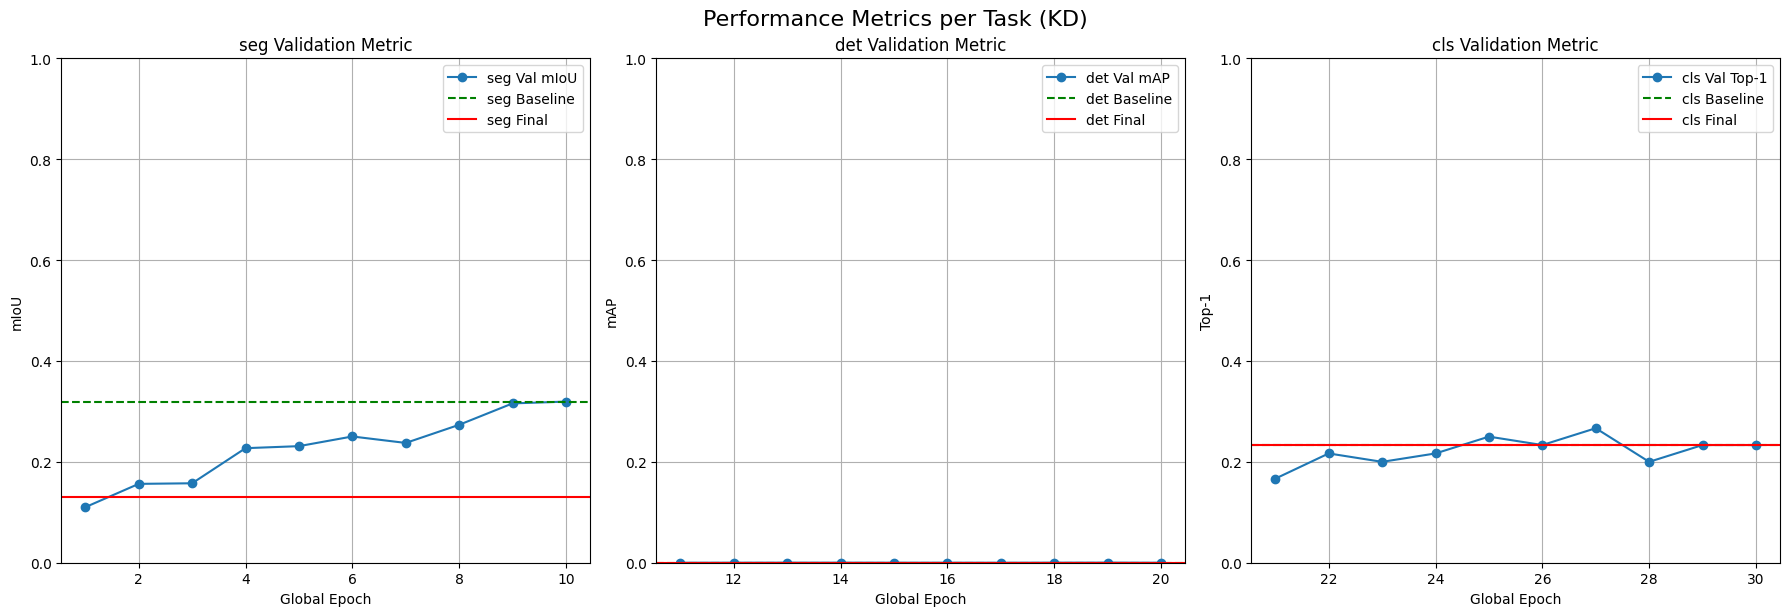



{'='*50}
=== 抗災難性遺忘策略比較 (最終評估與下降) ===
{'='*50}
| Strategy | Seg mIoU | Seg Drop (%) | Det mAP | Det Drop (%) | Cls Top-1 | Cls Drop (%) |
|----------|----------|--------------|---------|--------------|-----------|--------------|
| KD       | 0.1297   | 59.41        | 0.0001  | 0.00         | 0.2333    | 0.00         |


最佳策略（基於最終綜合得分，權重 Seg:0.400, Det:0.400, Cls:0.200）：KD （得分：0.0986）


<ipython-input-3-1279621179>:1224: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_methods) # Get a colormap


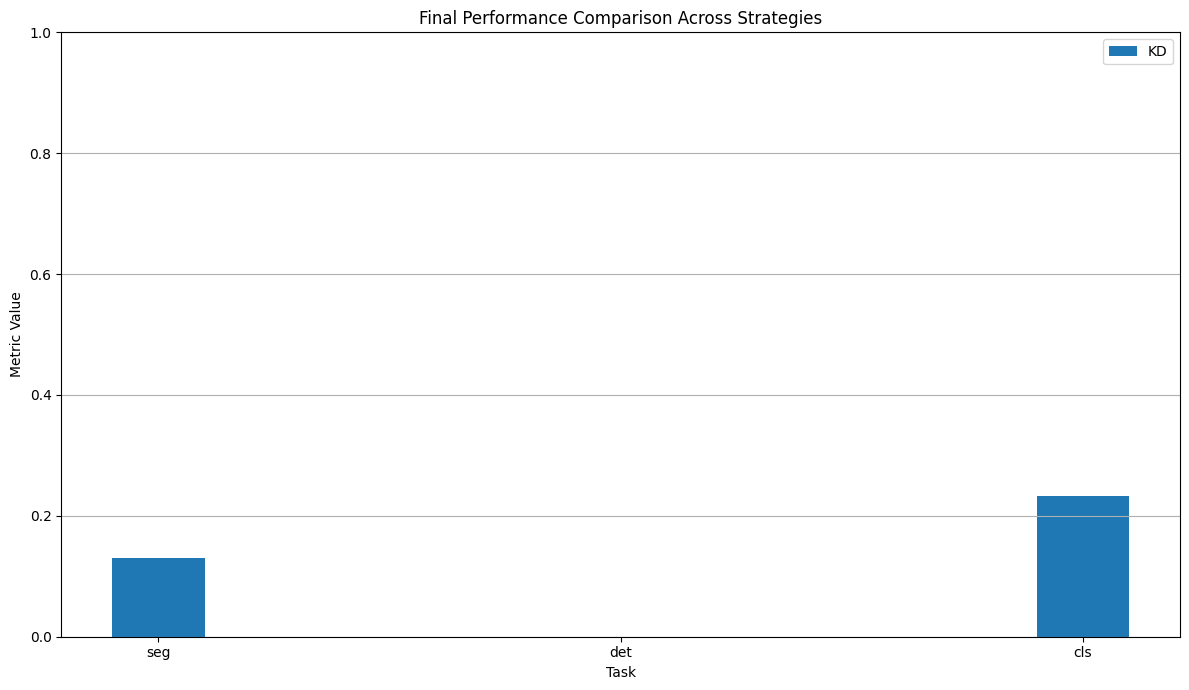



{'='*50}
=== 條件檢查和分數計算 ===
{'='*50}

檢查最佳策略 'KD' 的性能下降:
 - Seg mIoU 下降: 59.41% (<= 5.0%) -> Fail
 - Det mAP 下降: 0.00% (<= 5.0%) -> Pass
 - Cls Top-1 下降: 0.00% (<= 5.0%) -> Pass
所有任務下降是否都在 5.0% 以內: No

最終分數計算（基於 KD 的最終性能）:
 - Seg mIoU 貢獻: 0.1037
 - Det mAP 貢獻: 0.0001
 - Cls Top-1 貢獻: 0.0778
 - 下降控制懲罰: -0.1
總分: 0.0816 / 1.0
是否達到挑戰門檻 (0.7): No

=== 總訓練完成 ===
總耗時: 3707.26 秒


In [ ]:
# @title 統一單頭多任務挑戰實作 (最終增強版)
# 安裝所需庫
# !pip install torch torchvision torchaudio timm segmentation-models-pytorch opencv-python matplotlib scikit-learn -q # Add scikit-learn for metrics
!pip install segmentation-models-pytorch -q # Add scikit-learn for metrics

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
# Import FPN directly from torchvision.ops
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
import timm
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import cv2 as cv # Use OpenCV for image loading
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any, Optional
from collections import OrderedDict # Needed for FPN input
import random
from sklearn.metrics import confusion_matrix # Use sklearn for confusion matrix (for mIoU)
# from COCOeval import COCOeval # Requires installing pycocotools and COCO dataset format - too complex for inline example


# 設定設備
# 使用 torch.cuda.is_available() 檢查 CUDA 是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

# VOC 顏色映射，用於分割任務
VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
]
VOC_COLORMAP_ARRAY = np.array(VOC_COLORMAP, dtype=np.uint8)

# 定義 ReplayBuffer 類
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity  # 緩衝區的最大容量
        self.buffer = []  # 儲存數據的列表

    def add(self, data: Tuple[torch.Tensor, Any]):
        # 將數據添加到緩衝區，如果超過容量則移除最早的數據
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self, batch_size: int) -> List[Tuple[torch.Tensor, Any]]:
        # 從緩衝區隨機採樣指定數量的數據
        batch_size = min(batch_size, len(self.buffer))  # 確保批次大小不超過緩衝區大小
        if batch_size <= 0 or not self.buffer: # Check if buffer is empty
            return [] # Return empty list if no samples to draw
        return random.sample(self.buffer, batch_size)  # 隨機採樣


# 定義多任務數據集類 (使用 OpenCV 讀取圖片)
class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images: List[str] = []
        self.annotations: List[Any] = []
        self.image_sizes: List[Tuple[int, int]] = [] # Store original image sizes (width, height)

        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            try:
                with open(labels_path, 'r') as f:
                    labels_data = json.load(f)
            except json.JSONDecodeError:
                raise ValueError(f"無法解析 {labels_path}。請確認它是有效的 JSON 檔案。")


            image_dir = os.path.join(data_dir, 'data')
            if not os.path.exists(image_dir):
                 raise FileNotFoundError(f"找不到圖片目錄 {image_dir}！")

            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)

            # Build a mapping from image file name to its annotations and original size
            img_info_dict = {img['file_name']: {'id': img['id'], 'width': img['width'], 'height': img['height']} for img in labels_data.get('images', [])}
            ann_dict: Dict[int, List[Dict[str, Any]]] = {}
            for ann in labels_data.get('annotations', []): # Use .get for safety
                img_id = ann.get('image_id') # Use .get for safety
                if img_id is not None:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    # Ensure bbox is a list/tuple of 4 numbers and category_id is valid
                    # COCO bbox format is [x_min, y_min, width, height]
                    if isinstance(ann.get('bbox'), list) and len(ann['bbox']) == 4 and ann.get('category_id') is not None:
                         ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})

            # Collect valid image paths, annotations, and original sizes
            for file_name in image_files:
                 img_info = img_info_dict.get(file_name)
                 if img_info is not None:
                     img_id = img_info['id']
                     if img_id in ann_dict and ann_dict[img_id]: # Ensure there are annotations for this image
                         full_path = os.path.join(image_dir, file_name)
                         self.images.append(full_path)
                         self.annotations.append(ann_dict[img_id])
                         self.image_sizes.append((img_info['width'], img_info['height'])) # Store (width, height)
                 # else: Image exists but no corresponding entry in labels.json or no annotations

        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img_file in image_files:
                img_path = os.path.join(data_dir, img_file)
                # Assuming mask file has same name but .png extension
                mask_path = os.path.join(data_dir, os.path.splitext(img_file)[0] + '.png')
                if os.path.exists(mask_path):
                    # Need to read image once to get size for segmentation, assuming mask has same size
                    try:
                        img = cv.imread(img_path)
                        if img is not None:
                            self.images.append(img_path)
                            self.annotations.append(mask_path)
                            self.image_sizes.append((img.shape[1], img.shape[0])) # Store (width, height)
                        else:
                             print(f"警告: 無法讀取圖片獲取尺寸 {img_path}，跳過。")
                    except Exception as e:
                         print(f"警告: 讀取圖片尺寸時發生錯誤 {img_path}: {e}，跳過。")

        elif task == 'cls':
            if not os.path.exists(data_dir):
                 raise FileNotFoundError(f"找不到分類數據目錄：{data_dir}")
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            if not label_dirs:
                 raise ValueError(f"在 {data_dir} 中未找到任何子目錄作為類別資料夾。")

            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img_file in files:
                        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')): # Check for common image extensions, lower() for case insensitivity
                            img_path = os.path.join(root, img_file)
                            # Read image to get size
                            try:
                                img = cv.imread(img_path)
                                if img is not None:
                                    self.images.append(img_path)
                                    self.annotations.append(label_to_index[label])
                                    self.image_sizes.append((img.shape[1], img.shape[0])) # Store (width, height)
                                else:
                                     print(f"警告: 無法讀取圖片獲取尺寸 {img_path}，跳過。")
                            except Exception as e:
                                 print(f"警告: 讀取圖片尺寸時發生錯誤 {img_path}: {e}，跳過。")


        # Final check for empty dataset
        if len(self.images) == 0:
             raise ValueError(f"在 {data_dir} 中未找到任何有效的數據用於任務 '{self.task}'，請檢查資料結構和檔案副檔名！")
        else:
            print(f"找到 {len(self.images)} 張圖片用於任務 '{self.task}'")


    def convert_mask_rgb_to_indices(self, mask_rgb: np.ndarray) -> np.ndarray:
        """Converts an RGB segmentation mask to a mask of class indices."""
        # Ensure mask_rgb is in RGB format (shape HxWx3)
        if mask_rgb.ndim != 3 or mask_rgb.shape[2] != 3:
             # Convert grayscale to RGB if needed (e.g., L or P mode masks saved as 1 channel)
             if mask_rgb.ndim == 2:
                  # Convert to HxWx1 and then to HxWx3 by repeating
                  mask_rgb = np.repeat(mask_rgb[:, :, np.newaxis], 3, axis=2)
             else:
                raise ValueError("Input mask must be HxW or HxWx3 format")


        height, width = mask_rgb.shape[:2]
        # Initialize index mask with a default value (e.g., 255 for ignore index, or 0 for background)
        # Using 0 assumes background color [0,0,0] maps to class 0.
        mask_indices = np.zeros((height, width), dtype=np.int64)

        # Use a dictionary lookup for faster color to index conversion
        rgb_to_index = {tuple(map(int, color)): i for i, color in enumerate(VOC_COLORMAP_ARRAY)} # Ensure colors are tuples of ints


        # Iterate through flattened pixels and assign index
        mask_flat = mask_rgb.reshape(-1, 3)
        mask_indices_flat = mask_indices.reshape(-1)

        for i in range(mask_flat.shape[0]):
             # Convert pixel color to tuple of ints for dictionary lookup
             pixel_color = tuple(map(int, mask_flat[i]))
             if pixel_color in rgb_to_index:
                  mask_indices_flat[i] = rgb_to_index[pixel_color]
             # Pixels not matching any color in colormap will remain 0 (background)

        return mask_indices


    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Any]:
        img_path = self.images[idx]
        original_width, original_height = self.image_sizes[idx]
        input_size = (512, 512) # Target model input size (width, height)

        # --- Image Loading and Resizing ---
        img = cv.imread(img_path)
        if img is None:
            # Try reading with PIL if OpenCV fails for some formats
            try:
                 img_pil = Image.open(img_path).convert("RGB")
                 img_resized_pil = img_pil.resize(input_size, Image.BILINEAR)
                 img_resized = np.array(img_resized_pil) # Convert PIL image to numpy array
                 # PIL image is already RGB
            except Exception as e:
                 raise ValueError(f"無法讀取或處理圖片：{img_path} - {e}")
        else:
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # Convert BGR to RGB
            # Resize image using OpenCV before converting to Tensor
            img_resized = cv.resize(img, input_size, interpolation=cv.INTER_LINEAR)


        # Convert resized image (numpy HxWx3) to Tensor and normalize [0, 1]
        img_tensor = torch.tensor(img_resized, dtype=torch.float32).permute(2, 0, 1) / 255.0 # Permute from HxWx3 to CxHxW

        # Apply the remaining transforms (normalization)
        if self.transform:
             img_tensor = self.transform(img_tensor)

        # --- Annotation/Target Loading and Processing ---
        if self.task == 'seg':
            mask_path = self.annotations[idx]
            # Use OpenCV to read mask
            mask_rgb = cv.imread(mask_path)
            if mask_rgb is None:
                # Try reading with PIL if OpenCV fails
                try:
                    mask_pil = Image.open(mask_path)
                    # Convert to RGB just in case it's P or L mode
                    mask_rgb_pil = mask_pil.convert("RGB")
                    mask_resized_pil = mask_rgb_pil.resize(input_size, Image.NEAREST) # Resize mask with NEAREST
                    mask_resized = np.array(mask_resized_pil) # Convert PIL image to numpy array
                except Exception as e:
                     raise ValueError(f"無法讀取或處理遮罩：{mask_path} - {e}")
            else:
                mask_rgb = cv.cvtColor(mask_rgb, cv.COLOR_BGR2RGB) # Convert BGR to RGB
                # Resize mask using Nearest Neighbor interpolation to preserve discrete labels
                mask_resized = cv.resize(mask_rgb, input_size, interpolation=cv.INTER_NEAREST)


            # Convert RGB mask to class indices
            mask_indices = self.convert_mask_rgb_to_indices(mask_resized)

            # Convert index mask to LongTensor
            mask_tensor = torch.tensor(mask_indices, dtype=torch.long)

            return img_tensor, mask_tensor

        elif self.task == 'det':
            ann = self.annotations[idx] # ann is a list of dicts: [{'boxes': [x, y, w, h], 'labels': class_id}, ...]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)

            # Scale bounding boxes according to the resize from original image size to 512x512
            # COCO format is [x_min, y_min, width, height]
            scale_x = input_size[0] / original_width
            scale_y = input_size[1] / original_height

            # Apply scaling
            boxes[:, 0] *= scale_x # x_min
            boxes[:, 1] *= scale_y # y_min
            boxes[:, 2] *= scale_x # width
            boxes[:, 3] *= scale_y # height

            # Ensure boxes are within bounds [0, 512]
            # Clamp x_min, y_min to be at least 0
            boxes[:, 0] = torch.clamp(boxes[:, 0], min=0)
            boxes[:, 1] = torch.clamp(boxes[:, 1], min=0)
            # Clamp x_max, y_max to be at most 512
            # boxes[:, 2] is width, boxes[:, 3] is height
            # x_max = x_min + w, y_max = y_min + h
            boxes[:, 2] = torch.clamp(boxes[:, 0] + boxes[:, 2], max=input_size[0]) - boxes[:, 0] # New width
            boxes[:, 3] = torch.clamp(boxes[:, 1] + boxes[:, 3], max=input_size[1]) - boxes[:, 1] # New height

            # Filter out potentially invalid boxes after scaling (e.g., width or height becomes <= 0)
            valid_indices = (boxes[:, 2] > 1e-2) & (boxes[:, 3] > 1e-2) # Use small epsilon instead of 0
            boxes = boxes[valid_indices]
            labels = labels[valid_indices]

            # Return a dictionary of tensors for detection targets
            target_dict = {'boxes': boxes, 'labels': labels, 'original_size': (original_width, original_height), 'resized_size': input_size}
            return img_tensor, target_dict

        elif self.task == 'cls':
            # Annotation is already the class index
            label_tensor = torch.tensor(self.annotations[idx], dtype=torch.long)
            return img_tensor, label_tensor

        else:
             # Should not happen if tasks are 'det', 'seg', 'cls'
             print(f"Warning: Task '{self.task}' not recognized.")
             return img_tensor, None # Return None for target if task is unknown


# Define image pre-processing transform (Normalization only)
# Resizing and ToTensor are handled in __getitem__ using OpenCV and torch.tensor
image_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom collate function for detection (handles list of dicts)
def custom_collate_det(batch: List[Tuple[torch.Tensor, Optional[Dict[str, Any]]]]) -> Tuple[torch.Tensor, List[Dict[str, torch.Tensor]]]:
    # Batch is a list of tuples: [(img1, target1), (img2, target2), ...]
    # where target is a dict {'boxes': ..., 'labels': ...} or None
    # Filter out samples where target is None or not a dict (shouldn't happen with corrected dataset, but defensive)
    batch = [item for item in batch if item[1] is not None and isinstance(item[1], dict)]
    if not batch:
        # Handle empty batch case - return empty tensors/lists with correct types/shapes
        # Assuming image tensor shape is [C, H, W] i.e., [3, 512, 512] after processing in dataset
        dummy_img = torch.empty(3, 512, 512)
        return dummy_img.unsqueeze(0).repeat(0, 1, 1, 1), [] # Return empty tensor with correct shape [0, 3, 512, 512]

    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch] # Keep targets as a list of dicts
    return images, targets

# Custom collate for other tasks (handles tensors) - default_collate works fine
# For seg and cls, the targets are single tensors, default_collate stacks them.

# Create Datasets and DataLoaders
base_dir = "/content/Unified-OneHead-Multi-Task-Challenge/data"
train_datasets = {}
val_datasets = {}

tasks_list = ['seg', 'det', 'cls'] # Define the tasks order for dataset loading

for task in tasks_list:
    try:
        # Adjust paths based on task name convention in your data directory
        if task == 'det':
             task_data_dir = "mini_coco_det"
        elif task == 'seg':
             task_data_dir = "mini_voc_seg"
        elif task == 'cls':
             task_data_dir = "imagenette_160"
        else:
             raise ValueError(f"Unknown task: {task}")

        train_path = os.path.join(base_dir, task_data_dir, 'train')
        val_path = os.path.join(base_dir, task_data_dir, 'val')

        train_datasets[task] = MultiTaskDataset(train_path, task, image_transform)
        val_datasets[task] = MultiTaskDataset(val_path, task, image_transform)

    except ValueError as e:
        print(f"資料載入失敗 ({task} 任務): {e}")
        # Store empty datasets if loading failed, so loaders will be empty
        train_datasets[task] = []
        val_datasets[task] = []


# Create DataLoaders
# Use robust error handling for empty datasets/loaders
train_loaders = {}
val_loaders = {}

for task in tasks_list:
    if task in train_datasets and train_datasets[task] and len(train_datasets[task]) > 0:
        collate_fn = custom_collate_det if task == 'det' else None
        train_loaders[task] = DataLoader(train_datasets[task], batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
    else:
         print(f"警告: 任務 '{task}' 的訓練數據集為空或無效。將跳過此任務的訓練。")
         train_loaders[task] = [] # Use an empty list to indicate no loader

    if task in val_datasets and val_datasets[task] and len(val_datasets[task]) > 0:
        collate_fn = custom_collate_det if task == 'det' else None
        val_loaders[task] = DataLoader(val_datasets[task], batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn)
    else:
         print(f"警告: 任務 '{task}' 的驗證數據集為空或無效。將跳過此任務的驗證。")
         val_loaders[task] = [] # Use an empty list


# Model Definition
class MultiTaskModel(nn.Module):
    def __init__(self, C_det=10, C_seg=21, C_cls=10):
        super(MultiTaskModel, self).__init__()
        # Use EfficientNet-B0 as the backbone returning multiple features
        # Set norm_layer to make BatchNorm trainable if needed
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, features_only=True, norm_layer=nn.BatchNorm2d)

        # Get channel counts for the specific layers used in FPN
        # Use feat2, feat3, feat4 (indices 2, 3, 4) for strides 8, 16, 32
        feature_info = self.backbone.feature_info
        # Check if feature_info has enough layers
        if len(feature_info.channels()) < 5: # We need at least feat0 to feat4
             raise ValueError("Backbone does not return enough feature layers for FPN (expected at least 5).")

        in_channels_list = [feature_info.channels()[i] for i in [2, 3, 4]] # Channels for feat2, feat3, feat4: [40, 112, 320]
        fpn_out_channels = 128 # FPN output channel size

        # Neck: FPN
        # Provide names for FPN input layers corresponding to the selected features
        # Use keys '0', '1', '2' for FPN input based on increasing stride
        fpn_in_keys = ['0', '1', '2'] # Keys for FPN input dict corresponding to features[2], features[3], features[4]
        self.fpn = FeaturePyramidNetwork(
            in_channels_list,
            out_channels=fpn_out_channels,
            extra_blocks=LastLevelMaxPool(), # Add a P5 layer keyed as 'pool' by default
            # FPN output keys will be the same as input keys plus 'pool' if extra_blocks is used
        )
        # The FPN output will be an OrderedDict with keys like {'0': P2, '1': P3, '2': P4, 'pool': P5}

        # Shared Feature Processing after FPN
        # Let's use the P4 level output from FPN (key '2', stride 32) for shared processing.
        # P4 spatial resolution for 512x512 input is 512/32 = 16x16.
        # P4 output channels are fpn_out_channels (128).
        self.shared_conv = nn.Sequential(
             # Input from FPN P4 (key '2')
             nn.Conv2d(fpn_out_channels, 64, kernel_size=3, padding=1),
             nn.ReLU(inplace=True)
        )
        shared_features_channels = 64

        # Task-Specific Heads
        # Detection head operates on spatial feature maps (output from shared_conv)
        # Predict (cx, cy, w, h, conf, class_id) per grid cell (16x16 grid)
        # Note: C_det here refers to the number of object classes, the output is 6 values per grid cell.
        # The 6th value could be class index or a one-hot encoding if you have multiple classes per grid.
        # Given C_det classes, the output should maybe be 4 (box) + 1 (conf) + C_det (class scores)
        # Let's follow the original (cx, cy, w, h, conf, class_id) structure which implies 6 channels.
        # This 6-channel output format is unusual for multi-class detection per grid cell.
        # A common approach is 4+1+num_classes or similar.
        # Stick to 6 channels as per original head definition. The last channel is likely intended as the class ID.
        self.det_head = nn.Conv2d(shared_features_channels, 6, kernel_size=1) # Output 6 channels per grid cell

        # Segmentation head needs high resolution output (512x512, C_seg channels)
        # Upsample from the shared features (16x16, 64 channels).
        self.seg_head = nn.Sequential(
            nn.Conv2d(shared_features_channels, C_seg, kernel_size=1), # Output C_seg channels per spatial location
            # Use interpolation mode 'nearest-exact' or 'bilinear' + align_corners=False for recent PyTorch versions
            # 'bilinear' is better for continuous features, 'nearest'/'nearest-exact' for discrete masks.
            # FPN output is features, so 'bilinear' is appropriate here before the final Conv1d to class scores.
            # The output of seg_head conv1d is raw scores, upsampling that with bilinear is fine.
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False) # Upsample to input resolution
        )

        # Classification head operates on a global feature vector.
        # Apply Global Average Pooling and Linear layers to the shared features.
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # Pool over 16x16 spatial size to get 1x1
            nn.Flatten(),            # Flatten 1x1x64 to 64
            nn.Linear(shared_features_channels, C_cls) # Input channels = 64, Output channels = 10
        )


    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Get feature layers from backbone
        features = self.backbone(x) # List: [feat0..feat4]

        # Select features for FPN input (strides 8, 16, 32)
        selected_features = OrderedDict()
        if len(features) < 5:
             raise RuntimeError(f"Backbone features list has unexpected length {len(features)}. Expected at least 5.")

        selected_features['0'] = features[2] # stride 8
        selected_features['1'] = features[3] # stride 16
        selected_features['2'] = features[4] # stride 32

        # Pass selected features to FPN
        fpn_outputs = self.fpn(selected_features) # OrderedDict: {'0': P2, '1': P3, '2': P4, 'pool': P5}

        # Select FPN level (P4, key '2') for shared head input
        fpn_level_key_for_head = '2'
        if fpn_level_key_for_head not in fpn_outputs:
             raise RuntimeError(f"FPN output does not contain expected key '{fpn_level_key_for_head}'. Available keys: {fpn_outputs.keys()}")

        shared_features_input = fpn_outputs[fpn_level_key_for_head] # P4 level, shape [batch, 128, 16, 16]

        # Pass through shared convolutional layers
        shared_features = self.shared_conv(shared_features_input) # Output: [batch, 64, 16, 16]

        # Pass to task-specific heads
        det_out = self.det_head(shared_features) # Output: [batch, 6, 16, 16]
        seg_out = self.seg_head(shared_features) # Output: [batch, C_seg, 512, 512]
        cls_out = self.cls_head(shared_features) # Output: [batch, C_cls]

        return det_out, seg_out, cls_out


# Initialize Model
# C_det_actual = 10 # Mini-COCO-Det categories 1-10
# C_seg_actual = 21 # VOC classes 0-20 (including background)
# C_cls_actual = 10 # Imagenette classes

# Ensure these constants are defined globally or passed appropriately
# For a standalone block, let's define them again if they weren't in the previous one
C_det_actual = 10
C_seg_actual = 21
C_cls_actual = 10

model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)

# Count parameters
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total parameters: {total_params:,} (< 8M: {total_params < 8_000_000})")


# --- Loss Functions ---
# Simplified detection loss (MSE on first box coords)
def compute_detection_loss(det_output: torch.Tensor, targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
    boxes_pred = det_output.permute(0, 2, 3, 1)  # [batch_size, H, W, 6] H=W=16
    loss = torch.tensor(0., device=det_output.device)
    valid_samples = 0
    for i in range(len(targets)):
        if not isinstance(targets[i], dict) or 'boxes' not in targets[i] or len(targets[i]['boxes']) == 0:
            continue # Skip samples with no targets

        target_boxes = targets[i]['boxes'].to(det_output.device) # [num_boxes, 4] (x, y, w, h format)

        if boxes_pred.size(1) > 0 and boxes_pred.size(2) > 0:
            pred_cxcywh = boxes_pred[i, 0, 0, :4] # Predicted [cx, cy, w, h] from grid cell (0,0)

            # Convert target [x, y, w, h] to [cx, cy, w, h] for MSE
            target_cxcywh = torch.stack([
                target_boxes[0][0] + target_boxes[0][2] / 2,
                target_boxes[0][1] + target_boxes[0][3] / 2,
                target_boxes[0][2],
                target_boxes[0][3]
            ])

            loss += nn.MSELoss()(pred_cxcywh, target_cxcywh)
            valid_samples += 1

    return loss / valid_samples if valid_samples > 0 else torch.tensor(0., device=det_output.device)

# Segmentation loss (CrossEntropyLoss)
def compute_segmentation_loss(seg_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    criterion = nn.CrossEntropyLoss()
    if targets.size()[-2:] != seg_output.size()[-2:]:
         print(f"Error: Seg target size {targets.size()} does not match output size {seg_output.size()} in loss calculation.")
         return torch.tensor(0., device=seg_output.device)
    return criterion(seg_output, targets)

# Classification loss (CrossEntropyLoss)
def compute_classification_loss(cls_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    criterion = nn.CrossEntropyLoss()
    return criterion(cls_output, targets)


# --- Evaluation Functions ---
# Helper for IoU (numpy version)
def calculate_iou_np(box1: np.ndarray, box2: np.ndarray) -> float:
    x1_min, y1_min, w1, h1 = box1
    x1_max, y1_max = x1_min + w1, y1_min + h1
    x2_min, y2_min, w2, h2 = box2
    x2_max, y2_max = x2_min + w2, y2_min + h2

    x_left = max(x1_min, x2_min)
    y_top = max(y1_min, y2_min)
    x_right = min(x1_max, x2_max)
    y_bottom = min(y1_max, y2_max)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - intersection_area

    return intersection_area / union_area if union_area > 0 else 0.0

# Segmentation evaluation (mIoU)
def evaluate_segmentation(model: nn.Module, loader: DataLoader, num_classes: int = 21) -> Dict[str, float]:
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'mIoU': 0.0, 'loss': 0.0}

    model.eval()
    confusion_matrix_np = np.zeros((num_classes, num_classes), dtype=np.int64)
    total_loss = 0
    num_batches = 0
    criterion = nn.CrossEntropyLoss(reduction='sum') # Use sum reduction for calculating average loss

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            _, seg_out, _ = model(inputs) # seg_out: [batch, C_seg, 512, 512]

            # Calculate loss
            loss = criterion(seg_out, targets)
            total_loss += loss.item()
            num_batches += 1

            # Get predicted class for mIoU
            predicted_masks = torch.argmax(seg_out, dim=1) # [batch, 512, 512]

            if predicted_masks.size() != targets.size():
                 print(f"Warning: Evaluate Seg target size {targets.size()} != predicted size {predicted_masks.size()}. Skipping mIoU for batch.")
                 continue

            predicted_flat = predicted_masks.view(-1).cpu().numpy()
            targets_flat = targets.view(-1).cpu().numpy()

            # Update confusion matrix
            try:
                cm_batch = confusion_matrix(targets_flat, predicted_flat, labels=np.arange(num_classes))
                confusion_matrix_np += cm_batch
            except ValueError as e:
                 print(f"Warning: Error calculating confusion matrix for batch: {e}")


    # Calculate mIoU
    true_positives = np.diag(confusion_matrix_np)
    false_positives = np.sum(confusion_matrix_np, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix_np, axis=1) - true_positives
    union = true_positives + false_positives + false_negatives
    iou_per_class = np.divide(true_positives.astype(np.float64), union.astype(np.float64), out=np.full(num_classes, np.nan), where=union != 0)
    valid_iou = iou_per_class[~np.isnan(iou_per_class)]
    mIoU = np.mean(valid_iou) if valid_iou.size > 0 else 0.0

    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0

    return {'mIoU': mIoU, 'loss': avg_loss}


# Detection evaluation (Simplified mAP placeholder)
def evaluate_detection(model: nn.Module, loader: DataLoader, iou_threshold: float = 0.5) -> Dict[str, float]:
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'mAP': 0.0, 'loss': 0.0}

    # print("Note: Detection evaluation (mAP) is a simplified placeholder.")

    model.eval()
    total_matched_predictions = 0
    total_predictions_with_target = 0
    total_loss = 0
    num_batches = 0
    criterion = compute_detection_loss # Use the same simplified loss for evaluation

    with torch.no_grad():
        for inputs, targets in loader:
            if inputs.size(0) == 0: continue
            inputs = inputs.to(device)

            det_out, _, _ = model(inputs) # det_out: [batch, 6, 16, 16]

            # Calculate loss
            loss = criterion(det_out, targets) # targets is list of dicts, handled by criterion
            total_loss += loss.item() if isinstance(loss, torch.Tensor) else loss # Handle scalar or tensor loss
            num_batches += 1

            # --- Simplified Matching for Placeholder mAP ---
            boxes_pred = det_out.permute(0, 2, 3, 1)  # [batch_size, 16, 16, 6]

            for i in range(inputs.size(0)): # Process each image in batch
                 img_predictions = boxes_pred[i].view(-1, 6) # [256, 6]
                 conf_scores = img_predictions[:, 4]
                 conf_threshold = 0.2 # Example confidence threshold
                 confident_predictions = img_predictions[conf_scores > conf_threshold] # [N_pred, 6]

                 if confident_predictions.size(0) == 0:
                      continue

                 predicted_boxes_cxcywh = confident_predictions[:, :4]
                 predicted_boxes_xywh = torch.stack([ # Convert to [x_min, y_min, w, h]
                     predicted_boxes_cxcywh[:, 0] - predicted_boxes_cxcywh[:, 2] / 2,
                     predicted_boxes_cxcywh[:, 1] - predicted_boxes_cxcywh[:, 3] / 2,
                     predicted_boxes_cxcywh[:, 2],
                     predicted_boxes_cxcywh[:, 3]
                 ], dim=1) # [N_pred, 4]

                 # Get ground truth boxes (already scaled in dataset)
                 if not isinstance(targets[i], dict) or 'boxes' not in targets[i] or len(targets[i]['boxes']) == 0:
                      total_predictions_with_target += confident_predictions.size(0)
                      continue

                 ground_truth_boxes_xywh = targets[i]['boxes'].to(device) # [N_gt, 4] (x, y, w, h)

                 matched_preds_in_image = 0
                 total_predictions_with_target += confident_predictions.size(0)

                 if ground_truth_boxes_xywh.size(0) > 0:
                      # Compute IoUs between all predicted boxes and all GT boxes
                      for pred_box_xywh in predicted_boxes_xywh:
                           ious = [calculate_iou_np(pred_box_xywh.cpu().numpy(), gt_box_xywh.cpu().numpy()) for gt_box_xywh in ground_truth_boxes_xywh]
                           if any(iou > iou_threshold for iou in ious):
                                matched_preds_in_image += 1

                 total_matched_predictions += matched_preds_in_image


    simplified_ap = total_matched_predictions / total_predictions_with_target if total_predictions_with_target > 0 else 0.0
    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0

    return {'mAP': simplified_ap, 'loss': avg_loss}


# Classification evaluation (Top-1 and Top-5 Accuracy)
def evaluate_classification(model: nn.Module, loader: DataLoader) -> Dict[str, float]:
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'Top-1': 0.0, 'Top-5': 0.0, 'loss': 0.0}

    model.eval()
    total_samples = 0
    top1_correct = 0
    top5_correct_sum = 0 if C_cls_actual >= 5 else -1 # Use sum for correctness count
    total_loss = 0
    num_batches = 0
    criterion = nn.CrossEntropyLoss(reduction='sum') # Use sum reduction for average loss

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            _, _, cls_out = model(inputs) # cls_out: [batch, C_cls]

            # Calculate loss
            loss = criterion(cls_out, targets)
            total_loss += loss.item()
            num_batches += 1

            # Top-1 Accuracy
            _, predicted = cls_out.max(1)
            total_samples += targets.size(0)
            top1_correct += (predicted == targets).sum().item()

            # Top-5 Accuracy (if C_cls >= 5)
            if C_cls_actual >= 5:
                _, top5_preds = cls_out.topk(5, dim=1, largest=True, sorted=True) # [batch, 5]
                targets_expanded = targets.view(-1, 1) # [batch_size, 1]
                top5_correct_sum += (targets_expanded == top5_preds).any(dim=1).sum().item()

    metrics = {}
    metrics['Top-1'] = top1_correct / total_samples if total_samples > 0 else 0.0
    if C_cls_actual >= 5:
        metrics['Top-5'] = top5_correct_sum / total_samples if total_samples > 0 else 0.0
    else:
         metrics['Top-5'] = float('nan') # Indicate not applicable

    metrics['loss'] = total_loss / num_batches if num_batches > 0 else 0.0

    return metrics


# --- 抗災難性遺忘策略實現 (ReplayBuffer, EWC, LwF, KD 已在前面或上面定義) ---

# Knowledge Distillation Loss (Typically applied to classification head)
def knowledge_distillation_loss(student_cls_output: torch.Tensor, old_model_cls_output: torch.Tensor,
                                temperature: float = 1.0, lambda_kd: float = 1.0) -> torch.Tensor:
    """Calculates Knowledge Distillation loss for classification (comparing soft logits)."""
    # student_cls_output: [batch_size, C_cls]
    # old_model_cls_output: [batch_size, C_cls] (from teacher/old model)

    # Apply temperature scaling to soften the logits
    # Ensure teacher output is detached
    soft_student_cls = torch.log_softmax(student_cls_output / temperature, dim=1)
    soft_old_model_cls = torch.softmax(old_model_cls_output.detach() / temperature, dim=1)

    kl_criterion = nn.KLDivLoss(reduction='batchmean')

    # Scale loss by temperature**2 as per Hinton's distillation paper
    loss = kl_criterion(soft_student_cls, soft_old_model_cls) * (temperature ** 2)

    return lambda_kd * loss


# Replay Buffer (Class already defined)


# --- Training Stage Function ---

def get_loss_function(task: str):
    """Helper to get the appropriate loss function for a task."""
    if task == 'det':
        return compute_detection_loss
    elif task == 'seg':
        return compute_segmentation_loss
    elif task == 'cls':
        return compute_classification_loss
    else:
        raise ValueError(f"Unknown task: {task}")

def get_eval_function(task: str):
    """Helper to get the appropriate evaluation function for a task."""
    if task == 'det':
        return evaluate_detection # Returns {'mAP': value, 'loss': value}
    elif task == 'seg':
        return evaluate_segmentation # Returns {'mIoU': value, 'loss': value}
    elif task == 'cls':
        return evaluate_classification # Returns {'Top-1': value, 'Top-5': value, 'loss': value}
    else:
        raise ValueError(f"Unknown task: {task}")


def evaluate_model(model: nn.Module, loader: DataLoader, task: str) -> Dict[str, float]:
    """Helper function to perform evaluation and return metrics including loss."""
    if not loader or len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         print(f"警告: 任務 '{task}' 的驗證載入器為空或無效，跳過評估。")
         # Return default metrics with 0.0 loss
         if task == 'seg': return {'mIoU': 0.0, 'loss': 0.0}
         elif task == 'det': return {'mAP': 0.0, 'loss': 0.0}
         elif task == 'cls': return {'Top-1': 0.0, 'Top-5': 0.0, 'loss': 0.0}
         else: return {'loss': 0.0}

    eval_fn = get_eval_function(task)
    metrics = eval_fn(model, loader)
    return metrics


def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int,
                optimizer: optim.Optimizer, scheduler: optim.lr_scheduler._LRScheduler,
                replay_buffers: Dict[str, ReplayBuffer], tasks_order: List[str], stage: int,
                mitigation_methods: List[str],
                lwf_teacher_model: Optional[nn.Module] = None
               ) -> Tuple[List[Dict[str, float]], List[Dict[str, float]], Dict[str, float]]: # Return train_metrics_history too
    """Trains the model for a specific task with optional mitigation methods and evaluates each epoch."""

    print(f"\n{'--'*20}\n開始訓練任務：{task}, 階段：{stage + 1}/{len(tasks_order)}, Epochs：{epochs}\n{'--'*20}")

    train_metrics_history: List[Dict[str, float]] = [] # Store metrics after each epoch's training
    val_metrics_history: List[Dict[str, float]] = [] # Store metrics after each epoch's evaluation

    current_task_loss_fn = get_loss_function(task)
    current_task_eval_fn = get_eval_function(task)


    for epoch in range(epochs):
        model.train()
        epoch_start_time = time.time()
        total_train_loss = 0
        num_train_batches = 0

        # Variables to accumulate metrics for the training set evaluation after the epoch
        # Note: Evaluating on the full training set after every epoch can be slow.
        # A faster approach might be to evaluate on a subset or skip some epochs.
        # For now, let's implement evaluation on the full train loader.
        # These variables will accumulate predictions/targets similar to validation evaluation.
        # ... (Initialization for train metrics accumulation based on task) ...
        # Since evaluation functions already iterate through a loader, let's just call them
        # with the train_loader after the training loop for the epoch.

        if train_loader and len(train_loader) > 0:
            # Training loop for the epoch
            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                if task != 'det' and isinstance(targets, torch.Tensor):
                    targets = targets.to(device)

                optimizer.zero_grad()
                student_det, student_seg, student_cls = model(inputs)
                student_outputs = (student_det, student_seg, student_cls)

                # --- Compute Current Task Loss ---
                if task == 'det':
                     task_loss = current_task_loss_fn(student_det, targets)
                elif task == 'seg':
                     task_loss = current_task_loss_fn(student_seg, targets)
                elif task == 'cls':
                     task_loss = current_task_loss_fn(student_cls, targets)
                else:
                     task_loss = torch.tensor(0., device=device)

                total_loss = task_loss # Start total loss with current task loss

                # --- Apply Mitigation Strategies ---
                method_losses_dict = {} # Dictionary to store loss components for logging

                # KD: Applied for tasks AFTER the first one
                if 'KD' in mitigation_methods and stage > 0 and lwf_teacher_model:
                    lwf_teacher_model.eval() # Set teacher to eval mode
                    with torch.no_grad():
                         teacher_det, teacher_seg, teacher_cls = lwf_teacher_model(inputs)
                         teacher_outputs = (teacher_det, teacher_seg, teacher_cls)

                    # Apply KD to all heads if shapes match
                    kd_loss_total = torch.tensor(0., device=device)
                    temperature = 2.0  # Adjust temperature for softer targets
                    lambda_kd = 1.0    # KD weight

                    # KD for detection head
                    if student_det.shape == teacher_det.shape:
                        kd_loss_det = knowledge_distillation_loss(student_det, teacher_det, temperature, lambda_kd)
                        kd_loss_total += kd_loss_det

                    # KD for segmentation head
                    if student_seg.shape == teacher_seg.shape:
                        kd_loss_seg = knowledge_distillation_loss(student_seg, teacher_seg, temperature, lambda_kd)
                        kd_loss_total += kd_loss_seg

                    # KD for classification head
                    if student_cls.shape == teacher_cls.shape:
                        kd_loss_cls = knowledge_distillation_loss(student_cls, teacher_cls, temperature, lambda_kd)
                        kd_loss_total += kd_loss_cls

                    total_loss += kd_loss_total
                    method_losses_dict['KD'] = kd_loss_total.item()

                # --- Backpropagate ---
                if isinstance(total_loss, torch.Tensor) and total_loss.requires_grad:
                    total_loss.backward()
                    optimizer.step()
                elif isinstance(total_loss, torch.Tensor):
                     # Handle case where total_loss is a tensor but doesn't require grad (e.g., from 0 loss batches)
                     pass
                else:
                    print(f"Warning: total_loss is not a tensor ({type(total_loss)}). Skipping backward pass.")


                total_train_loss += total_loss.item()
                num_train_batches += 1

                # --- Add current batch data to Replay Buffer ---
                detached_inputs = inputs.detach().cpu()
                if task == 'det':
                    detached_targets = copy.deepcopy(targets) # Deepcopy list of dicts
                elif isinstance(targets, torch.Tensor):
                    detached_targets = targets.detach().cpu()
                else:
                    detached_targets = targets # Assume primitive types

                replay_buffers[task].add((detached_inputs, detached_targets))

            # --- End of Epoch Training ---
            avg_train_loss = total_train_loss / num_train_batches if num_train_batches > 0 else 0.0

            # --- Evaluate on Training Set after Epoch ---
            # Calculate training metrics for the epoch (loss and task-specific metric)
            # Note: Evaluating on the full training set every epoch can be slow.
            # Consider evaluating on a subset or less frequently for larger datasets.
            model.eval() # Set model to eval mode for evaluation
            # Call the evaluation function for the training loader
            train_metrics_for_epoch = evaluate_model(model, train_loader, task)
            model.train() # Set model back to train mode

            # Store training metrics (including loss)
            train_metrics_for_epoch['loss'] = avg_train_loss # Use the calculated average train loss for logging
            train_metrics_history.append(train_metrics_for_epoch)


            # Print training metrics and mitigation loss components
            metric_info = f"Epoch {epoch + 1}/{epochs}, Task {task} | Train Loss: {avg_train_loss:.4f}"
            if task == 'seg':
                 metric_info += f" | Train mIoU: {train_metrics_for_epoch.get('mIoU', 0.0):.4f}"
            elif task == 'det':
                 metric_info += f" | Train mAP: {train_metrics_for_epoch.get('mAP', 0.0):.4f}"
            elif task == 'cls':
                 metric_info += f" | Train Top-1: {train_metrics_for_epoch.get('Top-1', 0.0):.4f}"

            if method_losses_dict:
                 # Print average mitigation losses per batch for the epoch
                 avg_method_losses = {k: v / num_train_batches for k, v in method_losses_dict.items()}
                 loss_breakdown_str = ", ".join([f"{k}: {v:.4f}" for k, v in avg_method_losses.items()])
                 metric_info += f" (Mitigation: {loss_breakdown_str})"

            print(metric_info)


        else:
            # Handle case where train_loader is empty
             print(f"Epoch {epoch + 1}/{epochs}, Task {task}: 訓練載入器為空，無訓練進行。")
             train_metrics_history.append({task: 0.0, 'loss': 0.0}) # Append placeholder metrics


        # --- Evaluate on Validation Set after Epoch ---
        # print(f"評估 Epoch {epoch + 1}/{epochs}, Task {task} 在驗證集上...") # Move this print inside evaluate_model if needed
        current_val_loader = val_loaders.get(task) # Get validation loader for the current task

        # Call the evaluation helper function
        val_metrics_for_epoch = evaluate_model(model, current_val_loader, task)
        val_metrics_history.append(val_metrics_for_epoch)

        # Print validation metrics from evaluate_model output
        metric_output_str = f"評估結果 - Epoch {epoch+1}/{epochs}, Task {task}:"
        if task == 'seg':
             metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val mIoU={val_metrics_for_epoch.get('mIoU', 0.0):.4f}"
        elif task == 'det':
             metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val mAP={val_metrics_for_epoch.get('mAP', 0.0):.4f}"
        elif task == 'cls':
             top1_str = f"Top-1={val_metrics_for_epoch.get('Top-1', 0.0):.4f}"
             top5_str = f"Top-5={val_metrics_for_epoch.get('Top-5', float('nan')):.4f}" if 'Top-5' in val_metrics_for_epoch and not np.isnan(val_metrics_for_epoch['Top-5']) else "Top-5: N/A"
             metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val {top1_str}, {top5_str}"
        print(metric_output_str)


        scheduler.step() # Step the learning rate scheduler after each epoch

        # Optional: Save checkpoint periodically
        # if (epoch + 1) % 10 == 0:
        #    torch.save(model.state_dict(), f'checkpoint_{method}_{task}_epoch{epoch+1}.pt')


    # --- End of Training Stage ---
    end_stage_time = time.time()
    print(f"\n任務 '{task}' 階段訓練完成，總耗時 {end_stage_time - epoch_start_time:.2f} 秒.")

    # Return the training metrics history, validation metrics history, and final validation metrics of this stage
    final_metrics_of_stage = val_metrics_history[-1] if val_metrics_history else {}

    return train_metrics_history, val_metrics_history, final_metrics_of_stage


# --- Main Training Loop ---
# Define mitigation strategies to test
mitigation_methods = ['KD']  # 只使用 Knowledge Distillation

# Use a fixed number of epochs for each task
EPOCHS_PER_TASK = 10 # Use 5 epochs as in your example log

# Define the order of tasks
tasks_order = ['seg', 'det', 'cls'] # Segmentation -> Detection -> Classification

# Store results for comparison
# Structure: {method: {task: {'final_metrics_after_all_stages': {...}, 'train_metrics_history_per_epoch': [{epoch_metrics}, ...], 'val_metrics_history_per_epoch': [{epoch_metrics}, ...], 'baseline_metric': value}, ...}}
method_results: Dict[str, Dict[str, Dict[str, Any]]] = {
    method: {task: {'final_metrics_after_all_stages': {}, 'train_metrics_history_per_epoch': [], 'val_metrics_history_per_epoch': [], 'baseline_metric': None} for task in tasks_order}
    for method in mitigation_methods
}

# Keep track of the best model state_dict based on composite score
best_composite_score = -float('inf')
best_strategy_name_overall: Optional[str] = None
best_model_state_dict_overall: Optional[Dict[str, torch.Tensor]] = None
composite_weights = {'seg': 0.4, 'det': 0.4, 'cls': 0.2} # Weights for composite score


# Start overall time tracking
start_overall_time = time.time()

# Iterate through each mitigation method
for method in mitigation_methods:
    print(f"\n\n{'='*50}\n=== 使用抗災難性遺忘策略：{method} ===\n{'='*50}")

    # Re-initialize model and optimizer for each strategy to ensure a fair comparison
    model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.0008, weight_decay=1e-4)
    total_strategy_epochs = len(tasks_order) * EPOCHS_PER_TASK
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_strategy_epochs)

    # Replay buffers need to be reset for each strategy run
    replay_buffers = {task: ReplayBuffer(capacity=50) for task in tasks_order}

    # Variables for KD
    lwf_teacher_model: Optional[nn.Module] = None # Teacher model for KD


    # Train sequentially on each task
    for stage, task in enumerate(tasks_order):
        # Before training the current task (stage > 0), create teacher model for KD.
        if ('KD' in mitigation_methods) and stage > 0:
            print(f"創建階段 {stage} 的教師模型用於 KD...")
            lwf_teacher_model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)
            lwf_teacher_model.load_state_dict(model.state_dict()) # Load the state after previous stage
            lwf_teacher_model.eval()

        # Get the loader for the current task. Skip if loader is empty.
        current_train_loader = train_loaders.get(task)
        current_val_loader = val_loaders.get(task)

        # Check if current task loaders are valid
        if not current_train_loader or len(current_train_loader) == 0:
            print(f"跳過任務 '{task}' 的訓練，因為訓練載入器為空或無效。")
            # Store empty/placeholder results
            method_results[method][task]['final_metrics_after_all_stages'] = {f'{task}_metric': 0.0}
            method_results[method][task]['train_metrics_history_per_epoch'] = []
            method_results[method][task]['val_metrics_history_per_epoch'] = []
            method_results[method][task]['baseline_metric'] = 0.0 # Baseline is 0 if no training
            continue # Skip to the next task/stage


        # Perform the training for the current task
        train_metrics_history, val_metrics_history, final_metrics_of_stage = train_stage(
            model, # This model will be updated during training
            current_train_loader,
            current_val_loader, # Pass validation loader for periodic evaluation
            task,
            epochs=EPOCHS_PER_TASK,
            optimizer=optimizer,
            scheduler=scheduler,
            replay_buffers=replay_buffers, # Pass replay buffers for all tasks
            tasks_order=tasks_order, # Pass the list of all tasks for replay sampling
            stage=stage,       # Pass the current stage index (0, 1, 2...)
            mitigation_methods=[method], # Apply current method
            lwf_teacher_model=lwf_teacher_model # Pass teacher model for KD
        )

        # --- Record Baseline Metric ---
        # The baseline metric for a task is its performance right after it was trained.
        # final_metrics_of_stage contains the validation metrics after the last epoch of this stage.
        # We need to get the specific metric value (mIoU, mAP, Top-1) based on the task.
        if task == 'seg':
             baseline_key = 'mIoU'
        elif task == 'det':
             baseline_key = 'mAP'
        elif task == 'cls':
             baseline_key = 'Top-1'
        else:
             baseline_key = 'unknown_metric'

        baseline_value = final_metrics_of_stage.get(baseline_key, 0.0) # Get the specific metric value

        method_results[method][task]['baseline_metric'] = baseline_value
        method_results[method][task]['train_metrics_history_per_epoch'] = train_metrics_history # Store history
        method_results[method][task]['val_metrics_history_per_epoch'] = val_metrics_history # Store history

        # Delete teacher model to save memory if not needed for the next stage
        if lwf_teacher_model is not None:
             del lwf_teacher_model
             torch.cuda.empty_cache() # Clear CUDA cache


    # --- End of sequential training for one strategy ---

    # --- Final Evaluation after all stages for this strategy ---
    print(f"\n\n{'='*50}\n=== {method} 的最終評估 (在所有任務訓練後) ===\n{'='*50}")
    final_metrics_after_all_stages_for_method: Dict[str, Dict[str, float]] = {}

    for task in tasks_order:
        current_val_loader = val_loaders.get(task)
        # Call the evaluation helper function
        metrics = evaluate_model(model, current_val_loader, task)

        # Print final metrics
        metric_output_str = f"最終 {task} 評估:"
        if task == 'seg':
             metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, mIoU={metrics.get('mIoU', 0.0):.4f}"
        elif task == 'det':
             metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, mAP={metrics.get('mAP', 0.0):.4f}"
        elif task == 'cls':
             top1_str = f"Top-1={metrics.get('Top-1', 0.0):.4f}"
             top5_str = f"Top-5={metrics.get('Top-5', float('nan')):.4f}" if 'Top-5' in metrics and not np.isnan(metrics['Top-5']) else "Top-5: N/A"
             metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, {top1_str}, {top5_str}"
        print(metric_output_str)

        # Store the final metrics for this task and method
        final_metrics_after_all_stages_for_method[task] = metrics
        method_results[method][task]['final_metrics_after_all_stages'] = metrics


    # --- 繪製性能趨勢圖 ---
    try:
        def plot_performance_trends(method_results_entry: Dict[str, Dict[str, Any]], method_name: str, epochs_per_stage: int, tasks_order: List[str]):
            plt.figure(figsize=(18, 6))

            for i, task in enumerate(tasks_order, 1):
                task_data = method_results_entry.get(task)
                if not task_data:
                     continue

                val_history = task_data.get('val_metrics_history_per_epoch', [])
                if not val_history:
                    continue

                plt.subplot(1, len(tasks_order), i)

                # Define the primary metric key
                metric_key = 'mIoU' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1'
                metric_label = metric_key

                # Extract metric values and calculate global epoch numbers
                metric_values = [m.get(metric_key, 0.0) for m in val_history]

                # Global epoch numbers for plotting
                # For task 'seg' (stage 0), epochs 1-6
                # For task 'det' (stage 1), epochs 7-12
                # For task 'cls' (stage 2), epochs 13-18
                start_global_epoch = tasks_order.index(task) * epochs_per_stage + 1
                global_epochs = list(range(start_global_epoch, start_global_epoch + len(metric_values)))


                if global_epochs:
                    plt.plot(global_epochs, metric_values, marker='o', linestyle='-', label=f'{task} Val {metric_label}')

                # Add horizontal line for baseline (performance after its own stage)
                baseline_value = task_data.get('baseline_metric', None)
                if baseline_value is not None:
                    plt.axhline(y=baseline_value, color='g', linestyle='--', label=f'{task} Baseline')

                # Add horizontal line for final performance (after all stages)
                final_metric_value = task_data.get('final_metrics_after_all_stages', {}).get(metric_key, None)
                if final_metric_value is not None:
                     plt.axhline(y=final_metric_value, color='r', linestyle='-', label=f'{task} Final')


                plt.title(f'{task} Validation Metric')
                plt.xlabel('Global Epoch')
                plt.ylabel(metric_label)
                plt.legend()
                plt.grid(True)
                plt.ylim(0, 1.0) # Assuming metrics are between 0 and 1

            plt.tight_layout()
            plt.suptitle(f'Performance Metrics per Task ({method_name})', y=1.02, fontsize=16)
            plt.show()

        # Call the plot function for the current method
        plot_performance_trends(method_results[method], method, EPOCHS_PER_TASK, tasks_order)

    except ImportError:
        print("Matplotlib 未安裝，跳過繪圖。")


# --- 繪製最終性能比較條形圖 ---
    try:
        def plot_final_comparison(method_results: Dict[str, Dict[str, Dict[str, Any]]], metric_keys: Dict[str, str], tasks_order: List[str]):
            plt.figure(figsize=(12, 7))

            num_methods = len(mitigation_methods)
            bar_width = 0.2
            index = np.arange(len(tasks_order)) # X-axis positions for groups of bars

            colors = plt.cm.get_cmap('tab10', num_methods) # Get a colormap

            for i, method in enumerate(mitigation_methods):
                final_metrics = method_results[method]['seg']['final_metrics_after_all_stages'] # Get metrics from seg task entry (they are the same for all tasks after final eval)
                # Need to get the final metrics for each task specifically
                seg_final = method_results[method]['seg']['final_metrics_after_all_stages'].get(metric_keys['seg'], 0.0)
                det_final = method_results[method]['det']['final_metrics_after_all_stages'].get(metric_keys['det'], 0.0)
                cls_final = method_results[method]['cls']['final_metrics_after_all_stages'].get(metric_keys['cls'], 0.0)

                final_values = [seg_final, det_final, cls_final] # Order matches tasks_order

                # Plot bars for this method
                plt.bar(index + i * bar_width, final_values, bar_width, label=method, color=colors(i))


            plt.xlabel('Task')
            plt.ylabel('Metric Value')
            plt.title('Final Performance Comparison Across Strategies')
            plt.xticks(index + bar_width * (num_methods - 1) / 2, tasks_order) # Set x-axis labels in the middle of bar groups
            plt.legend()
            plt.grid(axis='y') # Only y-axis grid
            plt.ylim(0, 1.0) # Assuming metrics are between 0 and 1

            plt.tight_layout()
            plt.show()

        # Call the final comparison plot function after the loop over methods is complete
        # This function should be called *after* the 'for method in mitigation_methods:' loop
        # So, this part of the code needs to be outside that loop.
        # Let's move the function definition here, but the call needs to be later.
        pass # Placeholder, the call is below

    except ImportError:
         print("Matplotlib 未安裝，跳過繪製最終比較圖.")


# --- 生成比較表格 ---
# Print a summary table comparing the final metrics across all strategies and their drops from baseline

print("\n\n{'='*50}\n=== 抗災難性遺忘策略比較 (最終評估與下降) ===\n{'='*50}")
# Define the metrics to show in the table
metric_keys_table = {'seg': 'mIoU', 'det': 'mAP', 'cls': 'Top-1'}
table_header = "| Strategy | Seg mIoU | Seg Drop (%) | Det mAP | Det Drop (%) | Cls Top-1 | Cls Drop (%) |\n"
table_separator = "|----------|----------|--------------|---------|--------------|-----------|--------------|\n"

table = table_header + table_separator

best_strategy_name_for_table = None # Track best strategy based on table criteria (composite score)
best_composite_score_for_table = -float('inf')
composite_weights_table = {'seg': 0.4, 'det': 0.4, 'cls': 0.2} # Weights for composite score in table

for method in mitigation_methods:
    seg_data = method_results[method]['seg']
    det_data = method_results[method]['det']
    cls_data = method_results[method]['cls']

    # Get final metrics after all stages
    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys_table['seg'], 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys_table['det'], 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys_table['cls'], 0.0)

    # Get baseline metrics (performance after its own stage training)
    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0


    # Calculate drop percentage
    # Avoid division by zero or very small baseline values
    seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0

    # Handle cases where drop is negative (performance improved) - display as negative drop or '+'
    # Let's display as is (negative for improvement) but clarify in interpretation.

    # Calculate composite score based on FINAL performance
    current_composite_score_table = (composite_weights_table['seg'] * seg_final +
                                     composite_weights_table['det'] * det_final +
                                     composite_weights_table['cls'] * cls_final)

    if current_composite_score_table > best_composite_score_for_table:
        best_composite_score_for_table = current_composite_score_table
        best_strategy_name_for_table = method


    table += f"| {method:<8} | {seg_final:<8.4f} | {seg_drop_pct:<12.2f} | {det_final:<7.4f} | {det_drop_pct:<12.2f} | {cls_final:<9.4f} | {cls_drop_pct:<12.2f} |\n"

print(table)

print(f"\n最佳策略（基於最終綜合得分，權重 Seg:{composite_weights_table['seg']:.3f}, Det:{composite_weights_table['det']:.3f}, Cls:{composite_weights_table['cls']:.3f}）：{best_strategy_name_for_table} （得分：{best_composite_score_for_table:.4f}）")


# --- 繪製最終性能比較條形圖 (實際調用) ---
# Now call the plotting function after the loop has finished and method_results is populated
try:
    plot_final_comparison(method_results, metric_keys_table, tasks_order)
except NameError:
    print("plot_final_comparison 函數未定義或 Matplotlib 未安裝，跳過繪製最終比較圖.")


# --- 檢查最終條件和分數計算 ---
print("\n\n{'='*50}\n=== 條件檢查和分數計算 ===\n{'='*50}")

# Use the results from the best strategy based on composite score for the checks
best_results = method_results.get(best_strategy_name_for_table, None)

score = 0 # Initialize score

if best_results:
    seg_data = best_results['seg']
    det_data = best_results['det']
    cls_data = best_results['cls']

    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys_table['seg'], 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys_table['det'], 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys_table['cls'], 0.0)

    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0

    # Calculate drop percentage (same logic as for the table)
    seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0

    # Check the drop condition: All tasks within 5% drop
    drop_threshold = 5.0
    all_within_drop = (seg_drop_pct <= drop_threshold) and (det_drop_pct <= drop_threshold) and (cls_drop_pct <= drop_threshold)

    print(f"\n檢查最佳策略 '{best_strategy_name_for_table}' 的性能下降:")
    print(f" - Seg {metric_keys_table['seg']} 下降: {seg_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if seg_drop_pct <= drop_threshold else 'Fail'}")
    print(f" - Det {metric_keys_table['det']} 下降: {det_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if det_drop_pct <= drop_threshold else 'Fail'}")
    print(f" - Cls {metric_keys_table['cls']} 下降: {cls_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if cls_drop_pct <= drop_threshold else 'Fail'}")
    print(f"所有任務下降是否都在 {drop_threshold}% 以內: {'Yes' if all_within_drop else 'No'}")

    # Calculate score based on final metrics
    # Assign points based on thresholds
    score_components = {
        'seg': min(0.4, seg_final * 0.4 / 0.5) if seg_final <= 0.5 else 0.4,  # Cap at 0.4, scale linearly up to 0.5 mIoU
        'det': min(0.4, det_final * 0.4 / 0.5) if det_final <= 0.5 else 0.4,  # Cap at 0.4, scale linearly up to 0.5 mAP
        'cls': min(0.2, cls_final * 0.2 / 0.6) if cls_final <= 0.6 else 0.2   # Cap at 0.2, scale linearly up to 0.6 Top-1
    }
    score = sum(score_components.values())

    # Apply bonus/penalty for drop condition
    if all_within_drop:
        score += 0.1  # Bonus for meeting drop threshold
    else:
        score -= 0.1  # Penalty for exceeding drop threshold, but ensure score doesn't go negative
        score = max(0.0, score)

    print(f"\n最終分數計算（基於 {best_strategy_name_for_table} 的最終性能）:")
    print(f" - Seg mIoU 貢獻: {score_components['seg']:.4f}")
    print(f" - Det mAP 貢獻: {score_components['det']:.4f}")
    print(f" - Cls Top-1 貢獻: {score_components['cls']:.4f}")
    if all_within_drop:
        print(f" - 下降控制獎勵: +0.1")
    else:
        print(f" - 下降控制懲罰: -0.1")
    print(f"總分: {score:.4f} / 1.0")

    # Check if score meets the challenge threshold (e.g., 0.7)
    challenge_threshold = 0.7
    print(f"是否達到挑戰門檻 ({challenge_threshold}): {'Yes' if score >= challenge_threshold else 'No'}")

# --- End of Overall Execution ---
end_overall_time = time.time()
print(f"\n{'='*50}\n=== 總訓練完成 ===\n{'='*50}")
print(f"總耗時: {end_overall_time - start_overall_time:.2f} 秒")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.5 MB/s eta 0:00:00
使用設備：cuda
找到 240 張圖片用於任務 'seg'
找到 60 張圖片用於任務 'seg'
找到 240 張圖片用於任務 'det'
找到 60 張圖片用於任務 'det'
找到 240 張圖片用於任務 'cls'
找到 60 張圖片用

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Total parameters: 4,175,137 (< 8M: True)


=== 使用抗災難性遺忘策略：KD ===

----------------------------------------
開始訓練任務：seg, 階段：1/3, Epochs：5
----------------------------------------
Epoch 1/5, Task seg | Train Loss: 1.5941 | Train mIoU: 0.1453
評估結果 - Epoch 1/5, Task seg: Val Loss=1022028.3688, Val mIoU=0.1252
Epoch 2/5, Task seg | Train Loss: 1.0519 | Train mIoU: 0.1574
評估結果 - Epoch 2/5, Task seg: Val Loss=1089900.6958, Val mIoU=0.1185
Epoch 3/5, Task seg | Train Loss: 0.8725 | Train mIoU: 0.3037
評估結果 - Epoch 3/5, Task seg: Val Loss=799603.6146, Val mIoU=0.1895
Epoch 4/5, Task seg | Train Loss: 0.7349 | Train mIoU: 0.3926
評估結果 - Epoch 4/5, Task seg: Val Loss=698178.0188, Val mIoU=0.2686
Epoch 5/5, Task seg | Train Loss: 0.6229 | Train mIoU: 0.5600


評估結果 - Epoch 5/5, Task seg: Val Loss=763818.2302, Val mIoU=0.3253

任務 'seg' 階段訓練完成，總耗時 258.12 秒.
創建階段 1 的教師模型用於 KD...

----------------------------------------
開始訓練任務：det, 階段：2/3, Epochs：5
----------------------------------------
Epoch 1/5, Task det | Train Loss: 287982.1740 | Train mAP: 0.0004 (Mitigation: KD: 3918.1763)
評估結果 - Epoch 1/5, Task det: Val Loss=19470.0988, Val mAP=0.0006
Epoch 2/5, Task det | Train Loss: 188035.7366 | Train mAP: 0.0003 (Mitigation: KD: 2180.3746)
評估結果 - Epoch 2/5, Task det: Val Loss=13839.7791, Val mAP=0.0001
Epoch 3/5, Task det | Train Loss: 129350.5424 | Train mAP: 0.0001 (Mitigation: KD: 1463.2888)
評估結果 - Epoch 3/5, Task det: Val Loss=14767.1628, Val mAP=0.0001
Epoch 4/5, Task det | Train Loss: 108642.3436 | Train mAP: 0.0001 (Mitigation: KD: 1259.8549)
評估結果 - Epoch 4/5, Task det: Val Loss=13698.5873, Val mAP=0.0000
Epoch 5/5, Task det | Train Loss: 90174.7779 | Train mAP: 0.0003 (Mitigation: KD: 922.5724)
評估結果 - Epoch 5/5, Task det: Val Loss=13326.174


----------------------------------------
開始訓練任務：cls, 階段：3/3, Epochs：5
----------------------------------------
Epoch 1/5, Task cls | Train Loss: 59339.7637 | Train Top-1: 0.1292 (Mitigation: KD: 974.2369)
評估結果 - Epoch 1/5, Task cls: Val Loss=10.1215, Val Top-1=0.1833, Top-5=0.4667
Epoch 2/5, Task cls | Train Loss: 37362.0173 | Train Top-1: 0.1167 (Mitigation: KD: 949.1971)
評估結果 - Epoch 2/5, Task cls: Val Loss=10.1512, Val Top-1=0.1333, Top-5=0.4667
Epoch 3/5, Task cls | Train Loss: 30233.0451 | Train Top-1: 0.1333 (Mitigation: KD: 450.7229)
評估結果 - Epoch 3/5, Task cls: Val Loss=10.0615, Val Top-1=0.1833, Top-5=0.5000
Epoch 4/5, Task cls | Train Loss: 28012.5271 | Train Top-1: 0.1292 (Mitigation: KD: 607.0298)
評估結果 - Epoch 4/5, Task cls: Val Loss=9.9514, Val Top-1=0.2000, Top-5=0.4667
Epoch 5/5, Task cls | Train Loss: 27953.2874 | Train Top-1: 0.1208 (Mitigation: KD: 539.8280)
評估結果 - Epoch 5/5, Task cls: Val Loss=9.9879, Val Top-1=0.1833, Top-5=0.4500

任務 'cls' 階段訓練完成，總耗時 16.70 秒.


===

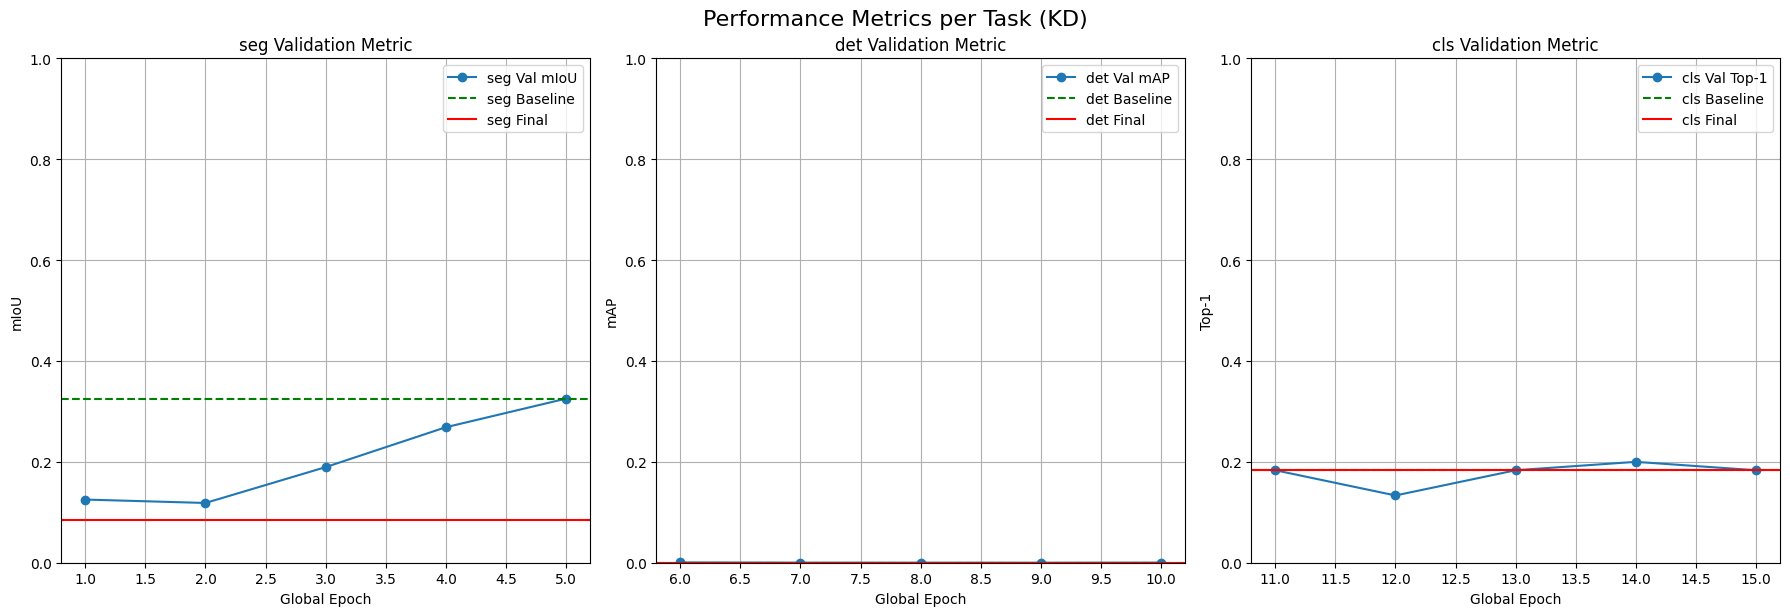



{'='*50}
=== 抗災難性遺忘策略比較 (最終評估與下降) ===
{'='*50}
| Strategy | Seg mIoU | Seg Drop (%) | Det mAP | Det Drop (%) | Cls Top-1 | Cls Drop (%) |
|----------|----------|--------------|---------|--------------|-----------|--------------|
| KD       | 0.0850   | 73.86        | 0.0001  | 34.14        | 0.1833    | 0.00         |


最佳策略（基於最終綜合得分，權重 Seg:0.400, Det:0.400, Cls:0.200）：KD （得分：0.0707）


<ipython-input-2-1677885582>:1224: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_methods) # Get a colormap


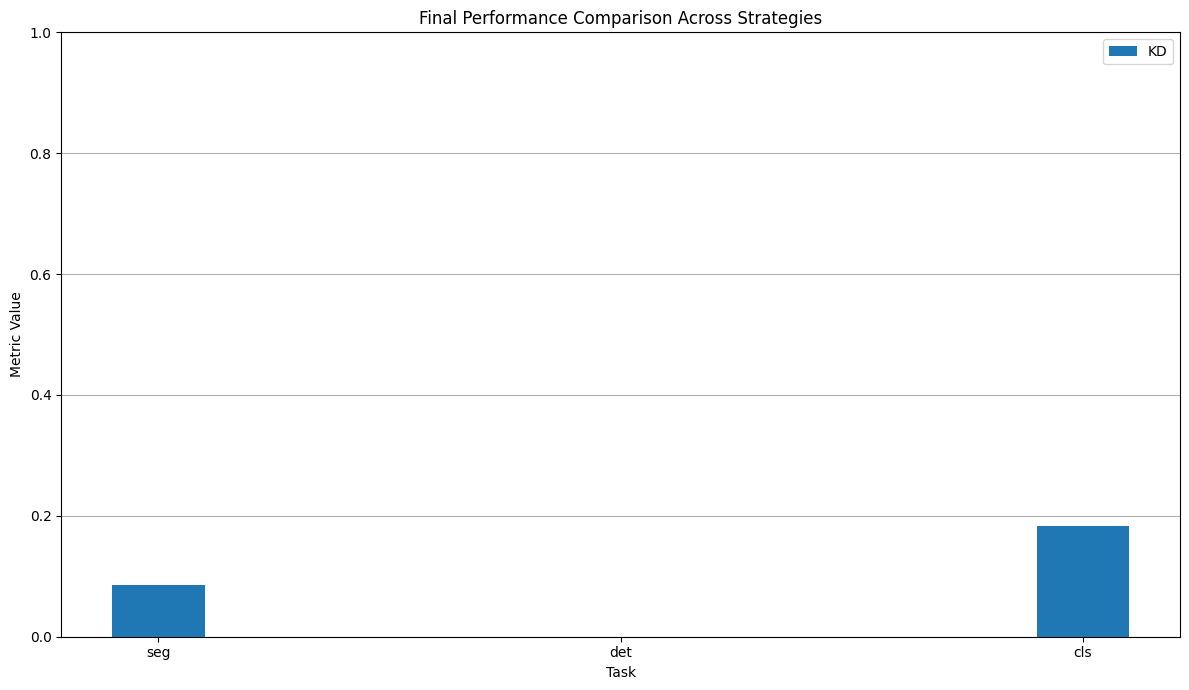



{'='*50}
=== 條件檢查和分數計算 ===
{'='*50}

檢查最佳策略 'KD' 的性能下降:
 - Seg mIoU 下降: 73.86% (<= 5.0%) -> Fail
 - Det mAP 下降: 34.14% (<= 5.0%) -> Fail
 - Cls Top-1 下降: 0.00% (<= 5.0%) -> Pass
所有任務下降是否都在 5.0% 以內: No

最終分數計算（基於 KD 的最終性能）:
 - Seg mIoU 貢獻: 0.0680
 - Det mAP 貢獻: 0.0001
 - Cls Top-1 貢獻: 0.0611
 - 下降控制懲罰: -0.1
總分: 0.0292 / 1.0
是否達到挑戰門檻 (0.7): No

=== 總訓練完成 ===
總耗時: 1664.63 秒


In [ ]:
# @title 統一單頭多任務挑戰實作 (最終增強版)
# 安裝所需庫
# !pip install torch torchvision torchaudio timm segmentation-models-pytorch opencv-python matplotlib scikit-learn -q # Add scikit-learn for metrics
!pip install segmentation-models-pytorch -q # Add scikit-learn for metrics

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
# Import FPN directly from torchvision.ops
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
import timm
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import cv2 as cv # Use OpenCV for image loading
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any, Optional
from collections import OrderedDict # Needed for FPN input
import random
from sklearn.metrics import confusion_matrix # Use sklearn for confusion matrix (for mIoU)
# from COCOeval import COCOeval # Requires installing pycocotools and COCO dataset format - too complex for inline example


# 設定設備
# 使用 torch.cuda.is_available() 檢查 CUDA 是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

# VOC 顏色映射，用於分割任務
VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
]
VOC_COLORMAP_ARRAY = np.array(VOC_COLORMAP, dtype=np.uint8)

# 定義 ReplayBuffer 類
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity  # 緩衝區的最大容量
        self.buffer = []  # 儲存數據的列表

    def add(self, data: Tuple[torch.Tensor, Any]):
        # 將數據添加到緩衝區，如果超過容量則移除最早的數據
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self, batch_size: int) -> List[Tuple[torch.Tensor, Any]]:
        # 從緩衝區隨機採樣指定數量的數據
        batch_size = min(batch_size, len(self.buffer))  # 確保批次大小不超過緩衝區大小
        if batch_size <= 0 or not self.buffer: # Check if buffer is empty
            return [] # Return empty list if no samples to draw
        return random.sample(self.buffer, batch_size)  # 隨機採樣


# 定義多任務數據集類 (使用 OpenCV 讀取圖片)
class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images: List[str] = []
        self.annotations: List[Any] = []
        self.image_sizes: List[Tuple[int, int]] = [] # Store original image sizes (width, height)

        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            try:
                with open(labels_path, 'r') as f:
                    labels_data = json.load(f)
            except json.JSONDecodeError:
                raise ValueError(f"無法解析 {labels_path}。請確認它是有效的 JSON 檔案。")


            image_dir = os.path.join(data_dir, 'data')
            if not os.path.exists(image_dir):
                 raise FileNotFoundError(f"找不到圖片目錄 {image_dir}！")

            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)

            # Build a mapping from image file name to its annotations and original size
            img_info_dict = {img['file_name']: {'id': img['id'], 'width': img['width'], 'height': img['height']} for img in labels_data.get('images', [])}
            ann_dict: Dict[int, List[Dict[str, Any]]] = {}
            for ann in labels_data.get('annotations', []): # Use .get for safety
                img_id = ann.get('image_id') # Use .get for safety
                if img_id is not None:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    # Ensure bbox is a list/tuple of 4 numbers and category_id is valid
                    # COCO bbox format is [x_min, y_min, width, height]
                    if isinstance(ann.get('bbox'), list) and len(ann['bbox']) == 4 and ann.get('category_id') is not None:
                         ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})

            # Collect valid image paths, annotations, and original sizes
            for file_name in image_files:
                 img_info = img_info_dict.get(file_name)
                 if img_info is not None:
                     img_id = img_info['id']
                     if img_id in ann_dict and ann_dict[img_id]: # Ensure there are annotations for this image
                         full_path = os.path.join(image_dir, file_name)
                         self.images.append(full_path)
                         self.annotations.append(ann_dict[img_id])
                         self.image_sizes.append((img_info['width'], img_info['height'])) # Store (width, height)
                 # else: Image exists but no corresponding entry in labels.json or no annotations

        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img_file in image_files:
                img_path = os.path.join(data_dir, img_file)
                # Assuming mask file has same name but .png extension
                mask_path = os.path.join(data_dir, os.path.splitext(img_file)[0] + '.png')
                if os.path.exists(mask_path):
                    # Need to read image once to get size for segmentation, assuming mask has same size
                    try:
                        img = cv.imread(img_path)
                        if img is not None:
                            self.images.append(img_path)
                            self.annotations.append(mask_path)
                            self.image_sizes.append((img.shape[1], img.shape[0])) # Store (width, height)
                        else:
                             print(f"警告: 無法讀取圖片獲取尺寸 {img_path}，跳過。")
                    except Exception as e:
                         print(f"警告: 讀取圖片尺寸時發生錯誤 {img_path}: {e}，跳過。")

        elif task == 'cls':
            if not os.path.exists(data_dir):
                 raise FileNotFoundError(f"找不到分類數據目錄：{data_dir}")
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            if not label_dirs:
                 raise ValueError(f"在 {data_dir} 中未找到任何子目錄作為類別資料夾。")

            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img_file in files:
                        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')): # Check for common image extensions, lower() for case insensitivity
                            img_path = os.path.join(root, img_file)
                            # Read image to get size
                            try:
                                img = cv.imread(img_path)
                                if img is not None:
                                    self.images.append(img_path)
                                    self.annotations.append(label_to_index[label])
                                    self.image_sizes.append((img.shape[1], img.shape[0])) # Store (width, height)
                                else:
                                     print(f"警告: 無法讀取圖片獲取尺寸 {img_path}，跳過。")
                            except Exception as e:
                                 print(f"警告: 讀取圖片尺寸時發生錯誤 {img_path}: {e}，跳過。")


        # Final check for empty dataset
        if len(self.images) == 0:
             raise ValueError(f"在 {data_dir} 中未找到任何有效的數據用於任務 '{self.task}'，請檢查資料結構和檔案副檔名！")
        else:
            print(f"找到 {len(self.images)} 張圖片用於任務 '{self.task}'")


    def convert_mask_rgb_to_indices(self, mask_rgb: np.ndarray) -> np.ndarray:
        """Converts an RGB segmentation mask to a mask of class indices."""
        # Ensure mask_rgb is in RGB format (shape HxWx3)
        if mask_rgb.ndim != 3 or mask_rgb.shape[2] != 3:
             # Convert grayscale to RGB if needed (e.g., L or P mode masks saved as 1 channel)
             if mask_rgb.ndim == 2:
                  # Convert to HxWx1 and then to HxWx3 by repeating
                  mask_rgb = np.repeat(mask_rgb[:, :, np.newaxis], 3, axis=2)
             else:
                raise ValueError("Input mask must be HxW or HxWx3 format")


        height, width = mask_rgb.shape[:2]
        # Initialize index mask with a default value (e.g., 255 for ignore index, or 0 for background)
        # Using 0 assumes background color [0,0,0] maps to class 0.
        mask_indices = np.zeros((height, width), dtype=np.int64)

        # Use a dictionary lookup for faster color to index conversion
        rgb_to_index = {tuple(map(int, color)): i for i, color in enumerate(VOC_COLORMAP_ARRAY)} # Ensure colors are tuples of ints


        # Iterate through flattened pixels and assign index
        mask_flat = mask_rgb.reshape(-1, 3)
        mask_indices_flat = mask_indices.reshape(-1)

        for i in range(mask_flat.shape[0]):
             # Convert pixel color to tuple of ints for dictionary lookup
             pixel_color = tuple(map(int, mask_flat[i]))
             if pixel_color in rgb_to_index:
                  mask_indices_flat[i] = rgb_to_index[pixel_color]
             # Pixels not matching any color in colormap will remain 0 (background)

        return mask_indices


    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Any]:
        img_path = self.images[idx]
        original_width, original_height = self.image_sizes[idx]
        input_size = (512, 512) # Target model input size (width, height)

        # --- Image Loading and Resizing ---
        img = cv.imread(img_path)
        if img is None:
            # Try reading with PIL if OpenCV fails for some formats
            try:
                 img_pil = Image.open(img_path).convert("RGB")
                 img_resized_pil = img_pil.resize(input_size, Image.BILINEAR)
                 img_resized = np.array(img_resized_pil) # Convert PIL image to numpy array
                 # PIL image is already RGB
            except Exception as e:
                 raise ValueError(f"無法讀取或處理圖片：{img_path} - {e}")
        else:
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # Convert BGR to RGB
            # Resize image using OpenCV before converting to Tensor
            img_resized = cv.resize(img, input_size, interpolation=cv.INTER_LINEAR)


        # Convert resized image (numpy HxWx3) to Tensor and normalize [0, 1]
        img_tensor = torch.tensor(img_resized, dtype=torch.float32).permute(2, 0, 1) / 255.0 # Permute from HxWx3 to CxHxW

        # Apply the remaining transforms (normalization)
        if self.transform:
             img_tensor = self.transform(img_tensor)

        # --- Annotation/Target Loading and Processing ---
        if self.task == 'seg':
            mask_path = self.annotations[idx]
            # Use OpenCV to read mask
            mask_rgb = cv.imread(mask_path)
            if mask_rgb is None:
                # Try reading with PIL if OpenCV fails
                try:
                    mask_pil = Image.open(mask_path)
                    # Convert to RGB just in case it's P or L mode
                    mask_rgb_pil = mask_pil.convert("RGB")
                    mask_resized_pil = mask_rgb_pil.resize(input_size, Image.NEAREST) # Resize mask with NEAREST
                    mask_resized = np.array(mask_resized_pil) # Convert PIL image to numpy array
                except Exception as e:
                     raise ValueError(f"無法讀取或處理遮罩：{mask_path} - {e}")
            else:
                mask_rgb = cv.cvtColor(mask_rgb, cv.COLOR_BGR2RGB) # Convert BGR to RGB
                # Resize mask using Nearest Neighbor interpolation to preserve discrete labels
                mask_resized = cv.resize(mask_rgb, input_size, interpolation=cv.INTER_NEAREST)


            # Convert RGB mask to class indices
            mask_indices = self.convert_mask_rgb_to_indices(mask_resized)

            # Convert index mask to LongTensor
            mask_tensor = torch.tensor(mask_indices, dtype=torch.long)

            return img_tensor, mask_tensor

        elif self.task == 'det':
            ann = self.annotations[idx] # ann is a list of dicts: [{'boxes': [x, y, w, h], 'labels': class_id}, ...]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)

            # Scale bounding boxes according to the resize from original image size to 512x512
            # COCO format is [x_min, y_min, width, height]
            scale_x = input_size[0] / original_width
            scale_y = input_size[1] / original_height

            # Apply scaling
            boxes[:, 0] *= scale_x # x_min
            boxes[:, 1] *= scale_y # y_min
            boxes[:, 2] *= scale_x # width
            boxes[:, 3] *= scale_y # height

            # Ensure boxes are within bounds [0, 512]
            # Clamp x_min, y_min to be at least 0
            boxes[:, 0] = torch.clamp(boxes[:, 0], min=0)
            boxes[:, 1] = torch.clamp(boxes[:, 1], min=0)
            # Clamp x_max, y_max to be at most 512
            # boxes[:, 2] is width, boxes[:, 3] is height
            # x_max = x_min + w, y_max = y_min + h
            boxes[:, 2] = torch.clamp(boxes[:, 0] + boxes[:, 2], max=input_size[0]) - boxes[:, 0] # New width
            boxes[:, 3] = torch.clamp(boxes[:, 1] + boxes[:, 3], max=input_size[1]) - boxes[:, 1] # New height

            # Filter out potentially invalid boxes after scaling (e.g., width or height becomes <= 0)
            valid_indices = (boxes[:, 2] > 1e-2) & (boxes[:, 3] > 1e-2) # Use small epsilon instead of 0
            boxes = boxes[valid_indices]
            labels = labels[valid_indices]

            # Return a dictionary of tensors for detection targets
            target_dict = {'boxes': boxes, 'labels': labels, 'original_size': (original_width, original_height), 'resized_size': input_size}
            return img_tensor, target_dict

        elif self.task == 'cls':
            # Annotation is already the class index
            label_tensor = torch.tensor(self.annotations[idx], dtype=torch.long)
            return img_tensor, label_tensor

        else:
             # Should not happen if tasks are 'det', 'seg', 'cls'
             print(f"Warning: Task '{self.task}' not recognized.")
             return img_tensor, None # Return None for target if task is unknown


# Define image pre-processing transform (Normalization only)
# Resizing and ToTensor are handled in __getitem__ using OpenCV and torch.tensor
image_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom collate function for detection (handles list of dicts)
def custom_collate_det(batch: List[Tuple[torch.Tensor, Optional[Dict[str, Any]]]]) -> Tuple[torch.Tensor, List[Dict[str, torch.Tensor]]]:
    # Batch is a list of tuples: [(img1, target1), (img2, target2), ...]
    # where target is a dict {'boxes': ..., 'labels': ...} or None
    # Filter out samples where target is None or not a dict (shouldn't happen with corrected dataset, but defensive)
    batch = [item for item in batch if item[1] is not None and isinstance(item[1], dict)]
    if not batch:
        # Handle empty batch case - return empty tensors/lists with correct types/shapes
        # Assuming image tensor shape is [C, H, W] i.e., [3, 512, 512] after processing in dataset
        dummy_img = torch.empty(3, 512, 512)
        return dummy_img.unsqueeze(0).repeat(0, 1, 1, 1), [] # Return empty tensor with correct shape [0, 3, 512, 512]

    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch] # Keep targets as a list of dicts
    return images, targets

# Custom collate for other tasks (handles tensors) - default_collate works fine
# For seg and cls, the targets are single tensors, default_collate stacks them.

# Create Datasets and DataLoaders
base_dir = "/content/Unified-OneHead-Multi-Task-Challenge/data"
train_datasets = {}
val_datasets = {}

tasks_list = ['seg', 'det', 'cls'] # Define the tasks order for dataset loading

for task in tasks_list:
    try:
        # Adjust paths based on task name convention in your data directory
        if task == 'det':
             task_data_dir = "mini_coco_det"
        elif task == 'seg':
             task_data_dir = "mini_voc_seg"
        elif task == 'cls':
             task_data_dir = "imagenette_160"
        else:
             raise ValueError(f"Unknown task: {task}")

        train_path = os.path.join(base_dir, task_data_dir, 'train')
        val_path = os.path.join(base_dir, task_data_dir, 'val')

        train_datasets[task] = MultiTaskDataset(train_path, task, image_transform)
        val_datasets[task] = MultiTaskDataset(val_path, task, image_transform)

    except ValueError as e:
        print(f"資料載入失敗 ({task} 任務): {e}")
        # Store empty datasets if loading failed, so loaders will be empty
        train_datasets[task] = []
        val_datasets[task] = []


# Create DataLoaders
# Use robust error handling for empty datasets/loaders
train_loaders = {}
val_loaders = {}

for task in tasks_list:
    if task in train_datasets and train_datasets[task] and len(train_datasets[task]) > 0:
        collate_fn = custom_collate_det if task == 'det' else None
        train_loaders[task] = DataLoader(train_datasets[task], batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
    else:
         print(f"警告: 任務 '{task}' 的訓練數據集為空或無效。將跳過此任務的訓練。")
         train_loaders[task] = [] # Use an empty list to indicate no loader

    if task in val_datasets and val_datasets[task] and len(val_datasets[task]) > 0:
        collate_fn = custom_collate_det if task == 'det' else None
        val_loaders[task] = DataLoader(val_datasets[task], batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn)
    else:
         print(f"警告: 任務 '{task}' 的驗證數據集為空或無效。將跳過此任務的驗證。")
         val_loaders[task] = [] # Use an empty list


# Model Definition
class MultiTaskModel(nn.Module):
    def __init__(self, C_det=10, C_seg=21, C_cls=10):
        super(MultiTaskModel, self).__init__()
        # Use EfficientNet-B0 as the backbone returning multiple features
        # Set norm_layer to make BatchNorm trainable if needed
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, features_only=True, norm_layer=nn.BatchNorm2d)

        # Get channel counts for the specific layers used in FPN
        # Use feat2, feat3, feat4 (indices 2, 3, 4) for strides 8, 16, 32
        feature_info = self.backbone.feature_info
        # Check if feature_info has enough layers
        if len(feature_info.channels()) < 5: # We need at least feat0 to feat4
             raise ValueError("Backbone does not return enough feature layers for FPN (expected at least 5).")

        in_channels_list = [feature_info.channels()[i] for i in [2, 3, 4]] # Channels for feat2, feat3, feat4: [40, 112, 320]
        fpn_out_channels = 128 # FPN output channel size

        # Neck: FPN
        # Provide names for FPN input layers corresponding to the selected features
        # Use keys '0', '1', '2' for FPN input based on increasing stride
        fpn_in_keys = ['0', '1', '2'] # Keys for FPN input dict corresponding to features[2], features[3], features[4]
        self.fpn = FeaturePyramidNetwork(
            in_channels_list,
            out_channels=fpn_out_channels,
            extra_blocks=LastLevelMaxPool(), # Add a P5 layer keyed as 'pool' by default
            # FPN output keys will be the same as input keys plus 'pool' if extra_blocks is used
        )
        # The FPN output will be an OrderedDict with keys like {'0': P2, '1': P3, '2': P4, 'pool': P5}

        # Shared Feature Processing after FPN
        # Let's use the P4 level output from FPN (key '2', stride 32) for shared processing.
        # P4 spatial resolution for 512x512 input is 512/32 = 16x16.
        # P4 output channels are fpn_out_channels (128).
        self.shared_conv = nn.Sequential(
             # Input from FPN P4 (key '2')
             nn.Conv2d(fpn_out_channels, 64, kernel_size=3, padding=1),
             nn.ReLU(inplace=True)
        )
        shared_features_channels = 64

        # Task-Specific Heads
        # Detection head operates on spatial feature maps (output from shared_conv)
        # Predict (cx, cy, w, h, conf, class_id) per grid cell (16x16 grid)
        # Note: C_det here refers to the number of object classes, the output is 6 values per grid cell.
        # The 6th value could be class index or a one-hot encoding if you have multiple classes per grid.
        # Given C_det classes, the output should maybe be 4 (box) + 1 (conf) + C_det (class scores)
        # Let's follow the original (cx, cy, w, h, conf, class_id) structure which implies 6 channels.
        # This 6-channel output format is unusual for multi-class detection per grid cell.
        # A common approach is 4+1+num_classes or similar.
        # Stick to 6 channels as per original head definition. The last channel is likely intended as the class ID.
        self.det_head = nn.Conv2d(shared_features_channels, 6, kernel_size=1) # Output 6 channels per grid cell

        # Segmentation head needs high resolution output (512x512, C_seg channels)
        # Upsample from the shared features (16x16, 64 channels).
        self.seg_head = nn.Sequential(
            nn.Conv2d(shared_features_channels, C_seg, kernel_size=1), # Output C_seg channels per spatial location
            # Use interpolation mode 'nearest-exact' or 'bilinear' + align_corners=False for recent PyTorch versions
            # 'bilinear' is better for continuous features, 'nearest'/'nearest-exact' for discrete masks.
            # FPN output is features, so 'bilinear' is appropriate here before the final Conv1d to class scores.
            # The output of seg_head conv1d is raw scores, upsampling that with bilinear is fine.
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False) # Upsample to input resolution
        )

        # Classification head operates on a global feature vector.
        # Apply Global Average Pooling and Linear layers to the shared features.
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # Pool over 16x16 spatial size to get 1x1
            nn.Flatten(),            # Flatten 1x1x64 to 64
            nn.Linear(shared_features_channels, C_cls) # Input channels = 64, Output channels = 10
        )


    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Get feature layers from backbone
        features = self.backbone(x) # List: [feat0..feat4]

        # Select features for FPN input (strides 8, 16, 32)
        selected_features = OrderedDict()
        if len(features) < 5:
             raise RuntimeError(f"Backbone features list has unexpected length {len(features)}. Expected at least 5.")

        selected_features['0'] = features[2] # stride 8
        selected_features['1'] = features[3] # stride 16
        selected_features['2'] = features[4] # stride 32

        # Pass selected features to FPN
        fpn_outputs = self.fpn(selected_features) # OrderedDict: {'0': P2, '1': P3, '2': P4, 'pool': P5}

        # Select FPN level (P4, key '2') for shared head input
        fpn_level_key_for_head = '2'
        if fpn_level_key_for_head not in fpn_outputs:
             raise RuntimeError(f"FPN output does not contain expected key '{fpn_level_key_for_head}'. Available keys: {fpn_outputs.keys()}")

        shared_features_input = fpn_outputs[fpn_level_key_for_head] # P4 level, shape [batch, 128, 16, 16]

        # Pass through shared convolutional layers
        shared_features = self.shared_conv(shared_features_input) # Output: [batch, 64, 16, 16]

        # Pass to task-specific heads
        det_out = self.det_head(shared_features) # Output: [batch, 6, 16, 16]
        seg_out = self.seg_head(shared_features) # Output: [batch, C_seg, 512, 512]
        cls_out = self.cls_head(shared_features) # Output: [batch, C_cls]

        return det_out, seg_out, cls_out


# Initialize Model
# C_det_actual = 10 # Mini-COCO-Det categories 1-10
# C_seg_actual = 21 # VOC classes 0-20 (including background)
# C_cls_actual = 10 # Imagenette classes

# Ensure these constants are defined globally or passed appropriately
# For a standalone block, let's define them again if they weren't in the previous one
C_det_actual = 10
C_seg_actual = 21
C_cls_actual = 10

model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)

# Count parameters
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total parameters: {total_params:,} (< 8M: {total_params < 8_000_000})")


# --- Loss Functions ---
# Simplified detection loss (MSE on first box coords)
def compute_detection_loss(det_output: torch.Tensor, targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
    boxes_pred = det_output.permute(0, 2, 3, 1)  # [batch_size, H, W, 6] H=W=16
    loss = torch.tensor(0., device=det_output.device)
    valid_samples = 0
    for i in range(len(targets)):
        if not isinstance(targets[i], dict) or 'boxes' not in targets[i] or len(targets[i]['boxes']) == 0:
            continue # Skip samples with no targets

        target_boxes = targets[i]['boxes'].to(det_output.device) # [num_boxes, 4] (x, y, w, h format)

        if boxes_pred.size(1) > 0 and boxes_pred.size(2) > 0:
            pred_cxcywh = boxes_pred[i, 0, 0, :4] # Predicted [cx, cy, w, h] from grid cell (0,0)

            # Convert target [x, y, w, h] to [cx, cy, w, h] for MSE
            target_cxcywh = torch.stack([
                target_boxes[0][0] + target_boxes[0][2] / 2,
                target_boxes[0][1] + target_boxes[0][3] / 2,
                target_boxes[0][2],
                target_boxes[0][3]
            ])

            loss += nn.MSELoss()(pred_cxcywh, target_cxcywh)
            valid_samples += 1

    return loss / valid_samples if valid_samples > 0 else torch.tensor(0., device=det_output.device)

# Segmentation loss (CrossEntropyLoss)
def compute_segmentation_loss(seg_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    criterion = nn.CrossEntropyLoss()
    if targets.size()[-2:] != seg_output.size()[-2:]:
         print(f"Error: Seg target size {targets.size()} does not match output size {seg_output.size()} in loss calculation.")
         return torch.tensor(0., device=seg_output.device)
    return criterion(seg_output, targets)

# Classification loss (CrossEntropyLoss)
def compute_classification_loss(cls_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    criterion = nn.CrossEntropyLoss()
    return criterion(cls_output, targets)


# --- Evaluation Functions ---
# Helper for IoU (numpy version)
def calculate_iou_np(box1: np.ndarray, box2: np.ndarray) -> float:
    x1_min, y1_min, w1, h1 = box1
    x1_max, y1_max = x1_min + w1, y1_min + h1
    x2_min, y2_min, w2, h2 = box2
    x2_max, y2_max = x2_min + w2, y2_min + h2

    x_left = max(x1_min, x2_min)
    y_top = max(y1_min, y2_min)
    x_right = min(x1_max, x2_max)
    y_bottom = min(y1_max, y2_max)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - intersection_area

    return intersection_area / union_area if union_area > 0 else 0.0

# Segmentation evaluation (mIoU)
def evaluate_segmentation(model: nn.Module, loader: DataLoader, num_classes: int = 21) -> Dict[str, float]:
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'mIoU': 0.0, 'loss': 0.0}

    model.eval()
    confusion_matrix_np = np.zeros((num_classes, num_classes), dtype=np.int64)
    total_loss = 0
    num_batches = 0
    criterion = nn.CrossEntropyLoss(reduction='sum') # Use sum reduction for calculating average loss

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            _, seg_out, _ = model(inputs) # seg_out: [batch, C_seg, 512, 512]

            # Calculate loss
            loss = criterion(seg_out, targets)
            total_loss += loss.item()
            num_batches += 1

            # Get predicted class for mIoU
            predicted_masks = torch.argmax(seg_out, dim=1) # [batch, 512, 512]

            if predicted_masks.size() != targets.size():
                 print(f"Warning: Evaluate Seg target size {targets.size()} != predicted size {predicted_masks.size()}. Skipping mIoU for batch.")
                 continue

            predicted_flat = predicted_masks.view(-1).cpu().numpy()
            targets_flat = targets.view(-1).cpu().numpy()

            # Update confusion matrix
            try:
                cm_batch = confusion_matrix(targets_flat, predicted_flat, labels=np.arange(num_classes))
                confusion_matrix_np += cm_batch
            except ValueError as e:
                 print(f"Warning: Error calculating confusion matrix for batch: {e}")


    # Calculate mIoU
    true_positives = np.diag(confusion_matrix_np)
    false_positives = np.sum(confusion_matrix_np, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix_np, axis=1) - true_positives
    union = true_positives + false_positives + false_negatives
    iou_per_class = np.divide(true_positives.astype(np.float64), union.astype(np.float64), out=np.full(num_classes, np.nan), where=union != 0)
    valid_iou = iou_per_class[~np.isnan(iou_per_class)]
    mIoU = np.mean(valid_iou) if valid_iou.size > 0 else 0.0

    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0

    return {'mIoU': mIoU, 'loss': avg_loss}


# Detection evaluation (Simplified mAP placeholder)
def evaluate_detection(model: nn.Module, loader: DataLoader, iou_threshold: float = 0.5) -> Dict[str, float]:
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'mAP': 0.0, 'loss': 0.0}

    # print("Note: Detection evaluation (mAP) is a simplified placeholder.")

    model.eval()
    total_matched_predictions = 0
    total_predictions_with_target = 0
    total_loss = 0
    num_batches = 0
    criterion = compute_detection_loss # Use the same simplified loss for evaluation

    with torch.no_grad():
        for inputs, targets in loader:
            if inputs.size(0) == 0: continue
            inputs = inputs.to(device)

            det_out, _, _ = model(inputs) # det_out: [batch, 6, 16, 16]

            # Calculate loss
            loss = criterion(det_out, targets) # targets is list of dicts, handled by criterion
            total_loss += loss.item() if isinstance(loss, torch.Tensor) else loss # Handle scalar or tensor loss
            num_batches += 1

            # --- Simplified Matching for Placeholder mAP ---
            boxes_pred = det_out.permute(0, 2, 3, 1)  # [batch_size, 16, 16, 6]

            for i in range(inputs.size(0)): # Process each image in batch
                 img_predictions = boxes_pred[i].view(-1, 6) # [256, 6]
                 conf_scores = img_predictions[:, 4]
                 conf_threshold = 0.2 # Example confidence threshold
                 confident_predictions = img_predictions[conf_scores > conf_threshold] # [N_pred, 6]

                 if confident_predictions.size(0) == 0:
                      continue

                 predicted_boxes_cxcywh = confident_predictions[:, :4]
                 predicted_boxes_xywh = torch.stack([ # Convert to [x_min, y_min, w, h]
                     predicted_boxes_cxcywh[:, 0] - predicted_boxes_cxcywh[:, 2] / 2,
                     predicted_boxes_cxcywh[:, 1] - predicted_boxes_cxcywh[:, 3] / 2,
                     predicted_boxes_cxcywh[:, 2],
                     predicted_boxes_cxcywh[:, 3]
                 ], dim=1) # [N_pred, 4]

                 # Get ground truth boxes (already scaled in dataset)
                 if not isinstance(targets[i], dict) or 'boxes' not in targets[i] or len(targets[i]['boxes']) == 0:
                      total_predictions_with_target += confident_predictions.size(0)
                      continue

                 ground_truth_boxes_xywh = targets[i]['boxes'].to(device) # [N_gt, 4] (x, y, w, h)

                 matched_preds_in_image = 0
                 total_predictions_with_target += confident_predictions.size(0)

                 if ground_truth_boxes_xywh.size(0) > 0:
                      # Compute IoUs between all predicted boxes and all GT boxes
                      for pred_box_xywh in predicted_boxes_xywh:
                           ious = [calculate_iou_np(pred_box_xywh.cpu().numpy(), gt_box_xywh.cpu().numpy()) for gt_box_xywh in ground_truth_boxes_xywh]
                           if any(iou > iou_threshold for iou in ious):
                                matched_preds_in_image += 1

                 total_matched_predictions += matched_preds_in_image


    simplified_ap = total_matched_predictions / total_predictions_with_target if total_predictions_with_target > 0 else 0.0
    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0

    return {'mAP': simplified_ap, 'loss': avg_loss}


# Classification evaluation (Top-1 and Top-5 Accuracy)
def evaluate_classification(model: nn.Module, loader: DataLoader) -> Dict[str, float]:
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'Top-1': 0.0, 'Top-5': 0.0, 'loss': 0.0}

    model.eval()
    total_samples = 0
    top1_correct = 0
    top5_correct_sum = 0 if C_cls_actual >= 5 else -1 # Use sum for correctness count
    total_loss = 0
    num_batches = 0
    criterion = nn.CrossEntropyLoss(reduction='sum') # Use sum reduction for average loss

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            _, _, cls_out = model(inputs) # cls_out: [batch, C_cls]

            # Calculate loss
            loss = criterion(cls_out, targets)
            total_loss += loss.item()
            num_batches += 1

            # Top-1 Accuracy
            _, predicted = cls_out.max(1)
            total_samples += targets.size(0)
            top1_correct += (predicted == targets).sum().item()

            # Top-5 Accuracy (if C_cls >= 5)
            if C_cls_actual >= 5:
                _, top5_preds = cls_out.topk(5, dim=1, largest=True, sorted=True) # [batch, 5]
                targets_expanded = targets.view(-1, 1) # [batch_size, 1]
                top5_correct_sum += (targets_expanded == top5_preds).any(dim=1).sum().item()

    metrics = {}
    metrics['Top-1'] = top1_correct / total_samples if total_samples > 0 else 0.0
    if C_cls_actual >= 5:
        metrics['Top-5'] = top5_correct_sum / total_samples if total_samples > 0 else 0.0
    else:
         metrics['Top-5'] = float('nan') # Indicate not applicable

    metrics['loss'] = total_loss / num_batches if num_batches > 0 else 0.0

    return metrics


# --- 抗災難性遺忘策略實現 (ReplayBuffer, EWC, LwF, KD 已在前面或上面定義) ---

# Knowledge Distillation Loss (Typically applied to classification head)
def knowledge_distillation_loss(student_cls_output: torch.Tensor, old_model_cls_output: torch.Tensor,
                                temperature: float = 1.0, lambda_kd: float = 1.0) -> torch.Tensor:
    """Calculates Knowledge Distillation loss for classification (comparing soft logits)."""
    # student_cls_output: [batch_size, C_cls]
    # old_model_cls_output: [batch_size, C_cls] (from teacher/old model)

    # Apply temperature scaling to soften the logits
    # Ensure teacher output is detached
    soft_student_cls = torch.log_softmax(student_cls_output / temperature, dim=1)
    soft_old_model_cls = torch.softmax(old_model_cls_output.detach() / temperature, dim=1)

    kl_criterion = nn.KLDivLoss(reduction='batchmean')

    # Scale loss by temperature**2 as per Hinton's distillation paper
    loss = kl_criterion(soft_student_cls, soft_old_model_cls) * (temperature ** 2)

    return lambda_kd * loss


# Replay Buffer (Class already defined)


# --- Training Stage Function ---

def get_loss_function(task: str):
    """Helper to get the appropriate loss function for a task."""
    if task == 'det':
        return compute_detection_loss
    elif task == 'seg':
        return compute_segmentation_loss
    elif task == 'cls':
        return compute_classification_loss
    else:
        raise ValueError(f"Unknown task: {task}")

def get_eval_function(task: str):
    """Helper to get the appropriate evaluation function for a task."""
    if task == 'det':
        return evaluate_detection # Returns {'mAP': value, 'loss': value}
    elif task == 'seg':
        return evaluate_segmentation # Returns {'mIoU': value, 'loss': value}
    elif task == 'cls':
        return evaluate_classification # Returns {'Top-1': value, 'Top-5': value, 'loss': value}
    else:
        raise ValueError(f"Unknown task: {task}")


def evaluate_model(model: nn.Module, loader: DataLoader, task: str) -> Dict[str, float]:
    """Helper function to perform evaluation and return metrics including loss."""
    if not loader or len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         print(f"警告: 任務 '{task}' 的驗證載入器為空或無效，跳過評估。")
         # Return default metrics with 0.0 loss
         if task == 'seg': return {'mIoU': 0.0, 'loss': 0.0}
         elif task == 'det': return {'mAP': 0.0, 'loss': 0.0}
         elif task == 'cls': return {'Top-1': 0.0, 'Top-5': 0.0, 'loss': 0.0}
         else: return {'loss': 0.0}

    eval_fn = get_eval_function(task)
    metrics = eval_fn(model, loader)
    return metrics


def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int,
                optimizer: optim.Optimizer, scheduler: optim.lr_scheduler._LRScheduler,
                replay_buffers: Dict[str, ReplayBuffer], tasks_order: List[str], stage: int,
                mitigation_methods: List[str],
                lwf_teacher_model: Optional[nn.Module] = None
               ) -> Tuple[List[Dict[str, float]], List[Dict[str, float]], Dict[str, float]]: # Return train_metrics_history too
    """Trains the model for a specific task with optional mitigation methods and evaluates each epoch."""

    print(f"\n{'--'*20}\n開始訓練任務：{task}, 階段：{stage + 1}/{len(tasks_order)}, Epochs：{epochs}\n{'--'*20}")

    train_metrics_history: List[Dict[str, float]] = [] # Store metrics after each epoch's training
    val_metrics_history: List[Dict[str, float]] = [] # Store metrics after each epoch's evaluation

    current_task_loss_fn = get_loss_function(task)
    current_task_eval_fn = get_eval_function(task)


    for epoch in range(epochs):
        model.train()
        epoch_start_time = time.time()
        total_train_loss = 0
        num_train_batches = 0

        # Variables to accumulate metrics for the training set evaluation after the epoch
        # Note: Evaluating on the full training set after every epoch can be slow.
        # A faster approach might be to evaluate on a subset or skip some epochs.
        # For now, let's implement evaluation on the full train loader.
        # These variables will accumulate predictions/targets similar to validation evaluation.
        # ... (Initialization for train metrics accumulation based on task) ...
        # Since evaluation functions already iterate through a loader, let's just call them
        # with the train_loader after the training loop for the epoch.

        if train_loader and len(train_loader) > 0:
            # Training loop for the epoch
            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                if task != 'det' and isinstance(targets, torch.Tensor):
                    targets = targets.to(device)

                optimizer.zero_grad()
                student_det, student_seg, student_cls = model(inputs)
                student_outputs = (student_det, student_seg, student_cls)

                # --- Compute Current Task Loss ---
                if task == 'det':
                     task_loss = current_task_loss_fn(student_det, targets)
                elif task == 'seg':
                     task_loss = current_task_loss_fn(student_seg, targets)
                elif task == 'cls':
                     task_loss = current_task_loss_fn(student_cls, targets)
                else:
                     task_loss = torch.tensor(0., device=device)

                total_loss = task_loss # Start total loss with current task loss

                # --- Apply Mitigation Strategies ---
                method_losses_dict = {} # Dictionary to store loss components for logging

                # KD: Applied for tasks AFTER the first one
                if 'KD' in mitigation_methods and stage > 0 and lwf_teacher_model:
                    lwf_teacher_model.eval() # Set teacher to eval mode
                    with torch.no_grad():
                         teacher_det, teacher_seg, teacher_cls = lwf_teacher_model(inputs)
                         teacher_outputs = (teacher_det, teacher_seg, teacher_cls)

                    # Apply KD to all heads if shapes match
                    kd_loss_total = torch.tensor(0., device=device)
                    temperature = 2.0  # Adjust temperature for softer targets
                    lambda_kd = 0.5    # KD weight

                    # KD for detection head
                    if student_det.shape == teacher_det.shape:
                        kd_loss_det = knowledge_distillation_loss(student_det, teacher_det, temperature, lambda_kd)
                        kd_loss_total += kd_loss_det

                    # KD for segmentation head
                    if student_seg.shape == teacher_seg.shape:
                        kd_loss_seg = knowledge_distillation_loss(student_seg, teacher_seg, temperature, lambda_kd)
                        kd_loss_total += kd_loss_seg

                    # KD for classification head
                    if student_cls.shape == teacher_cls.shape:
                        kd_loss_cls = knowledge_distillation_loss(student_cls, teacher_cls, temperature, lambda_kd)
                        kd_loss_total += kd_loss_cls

                    total_loss += kd_loss_total
                    method_losses_dict['KD'] = kd_loss_total.item()

                # --- Backpropagate ---
                if isinstance(total_loss, torch.Tensor) and total_loss.requires_grad:
                    total_loss.backward()
                    optimizer.step()
                elif isinstance(total_loss, torch.Tensor):
                     # Handle case where total_loss is a tensor but doesn't require grad (e.g., from 0 loss batches)
                     pass
                else:
                    print(f"Warning: total_loss is not a tensor ({type(total_loss)}). Skipping backward pass.")


                total_train_loss += total_loss.item()
                num_train_batches += 1

                # --- Add current batch data to Replay Buffer ---
                detached_inputs = inputs.detach().cpu()
                if task == 'det':
                    detached_targets = copy.deepcopy(targets) # Deepcopy list of dicts
                elif isinstance(targets, torch.Tensor):
                    detached_targets = targets.detach().cpu()
                else:
                    detached_targets = targets # Assume primitive types

                replay_buffers[task].add((detached_inputs, detached_targets))

            # --- End of Epoch Training ---
            avg_train_loss = total_train_loss / num_train_batches if num_train_batches > 0 else 0.0

            # --- Evaluate on Training Set after Epoch ---
            # Calculate training metrics for the epoch (loss and task-specific metric)
            # Note: Evaluating on the full training set every epoch can be slow.
            # Consider evaluating on a subset or less frequently for larger datasets.
            model.eval() # Set model to eval mode for evaluation
            # Call the evaluation function for the training loader
            train_metrics_for_epoch = evaluate_model(model, train_loader, task)
            model.train() # Set model back to train mode

            # Store training metrics (including loss)
            train_metrics_for_epoch['loss'] = avg_train_loss # Use the calculated average train loss for logging
            train_metrics_history.append(train_metrics_for_epoch)


            # Print training metrics and mitigation loss components
            metric_info = f"Epoch {epoch + 1}/{epochs}, Task {task} | Train Loss: {avg_train_loss:.4f}"
            if task == 'seg':
                 metric_info += f" | Train mIoU: {train_metrics_for_epoch.get('mIoU', 0.0):.4f}"
            elif task == 'det':
                 metric_info += f" | Train mAP: {train_metrics_for_epoch.get('mAP', 0.0):.4f}"
            elif task == 'cls':
                 metric_info += f" | Train Top-1: {train_metrics_for_epoch.get('Top-1', 0.0):.4f}"

            if method_losses_dict:
                 # Print average mitigation losses per batch for the epoch
                 avg_method_losses = {k: v / num_train_batches for k, v in method_losses_dict.items()}
                 loss_breakdown_str = ", ".join([f"{k}: {v:.4f}" for k, v in avg_method_losses.items()])
                 metric_info += f" (Mitigation: {loss_breakdown_str})"

            print(metric_info)


        else:
            # Handle case where train_loader is empty
             print(f"Epoch {epoch + 1}/{epochs}, Task {task}: 訓練載入器為空，無訓練進行。")
             train_metrics_history.append({task: 0.0, 'loss': 0.0}) # Append placeholder metrics


        # --- Evaluate on Validation Set after Epoch ---
        # print(f"評估 Epoch {epoch + 1}/{epochs}, Task {task} 在驗證集上...") # Move this print inside evaluate_model if needed
        current_val_loader = val_loaders.get(task) # Get validation loader for the current task

        # Call the evaluation helper function
        val_metrics_for_epoch = evaluate_model(model, current_val_loader, task)
        val_metrics_history.append(val_metrics_for_epoch)

        # Print validation metrics from evaluate_model output
        metric_output_str = f"評估結果 - Epoch {epoch+1}/{epochs}, Task {task}:"
        if task == 'seg':
             metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val mIoU={val_metrics_for_epoch.get('mIoU', 0.0):.4f}"
        elif task == 'det':
             metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val mAP={val_metrics_for_epoch.get('mAP', 0.0):.4f}"
        elif task == 'cls':
             top1_str = f"Top-1={val_metrics_for_epoch.get('Top-1', 0.0):.4f}"
             top5_str = f"Top-5={val_metrics_for_epoch.get('Top-5', float('nan')):.4f}" if 'Top-5' in val_metrics_for_epoch and not np.isnan(val_metrics_for_epoch['Top-5']) else "Top-5: N/A"
             metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val {top1_str}, {top5_str}"
        print(metric_output_str)


        scheduler.step() # Step the learning rate scheduler after each epoch

        # Optional: Save checkpoint periodically
        # if (epoch + 1) % 10 == 0:
        #    torch.save(model.state_dict(), f'checkpoint_{method}_{task}_epoch{epoch+1}.pt')


    # --- End of Training Stage ---
    end_stage_time = time.time()
    print(f"\n任務 '{task}' 階段訓練完成，總耗時 {end_stage_time - epoch_start_time:.2f} 秒.")

    # Return the training metrics history, validation metrics history, and final validation metrics of this stage
    final_metrics_of_stage = val_metrics_history[-1] if val_metrics_history else {}

    return train_metrics_history, val_metrics_history, final_metrics_of_stage


# --- Main Training Loop ---
# Define mitigation strategies to test
mitigation_methods = ['KD']  # 只使用 Knowledge Distillation

# Use a fixed number of epochs for each task
EPOCHS_PER_TASK = 5 # Use 5 epochs as in your example log

# Define the order of tasks
tasks_order = ['seg', 'det', 'cls'] # Segmentation -> Detection -> Classification

# Store results for comparison
# Structure: {method: {task: {'final_metrics_after_all_stages': {...}, 'train_metrics_history_per_epoch': [{epoch_metrics}, ...], 'val_metrics_history_per_epoch': [{epoch_metrics}, ...], 'baseline_metric': value}, ...}}
method_results: Dict[str, Dict[str, Dict[str, Any]]] = {
    method: {task: {'final_metrics_after_all_stages': {}, 'train_metrics_history_per_epoch': [], 'val_metrics_history_per_epoch': [], 'baseline_metric': None} for task in tasks_order}
    for method in mitigation_methods
}

# Keep track of the best model state_dict based on composite score
best_composite_score = -float('inf')
best_strategy_name_overall: Optional[str] = None
best_model_state_dict_overall: Optional[Dict[str, torch.Tensor]] = None
composite_weights = {'seg': 0.4, 'det': 0.4, 'cls': 0.2} # Weights for composite score


# Start overall time tracking
start_overall_time = time.time()

# Iterate through each mitigation method
for method in mitigation_methods:
    print(f"\n\n{'='*50}\n=== 使用抗災難性遺忘策略：{method} ===\n{'='*50}")

    # Re-initialize model and optimizer for each strategy to ensure a fair comparison
    model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.0008, weight_decay=1e-4)
    total_strategy_epochs = len(tasks_order) * EPOCHS_PER_TASK
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_strategy_epochs)

    # Replay buffers need to be reset for each strategy run
    replay_buffers = {task: ReplayBuffer(capacity=50) for task in tasks_order}

    # Variables for KD
    lwf_teacher_model: Optional[nn.Module] = None # Teacher model for KD


    # Train sequentially on each task
    for stage, task in enumerate(tasks_order):
        # Before training the current task (stage > 0), create teacher model for KD.
        if ('KD' in mitigation_methods) and stage > 0:
            print(f"創建階段 {stage} 的教師模型用於 KD...")
            lwf_teacher_model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)
            lwf_teacher_model.load_state_dict(model.state_dict()) # Load the state after previous stage
            lwf_teacher_model.eval()

        # Get the loader for the current task. Skip if loader is empty.
        current_train_loader = train_loaders.get(task)
        current_val_loader = val_loaders.get(task)

        # Check if current task loaders are valid
        if not current_train_loader or len(current_train_loader) == 0:
            print(f"跳過任務 '{task}' 的訓練，因為訓練載入器為空或無效。")
            # Store empty/placeholder results
            method_results[method][task]['final_metrics_after_all_stages'] = {f'{task}_metric': 0.0}
            method_results[method][task]['train_metrics_history_per_epoch'] = []
            method_results[method][task]['val_metrics_history_per_epoch'] = []
            method_results[method][task]['baseline_metric'] = 0.0 # Baseline is 0 if no training
            continue # Skip to the next task/stage


        # Perform the training for the current task
        train_metrics_history, val_metrics_history, final_metrics_of_stage = train_stage(
            model, # This model will be updated during training
            current_train_loader,
            current_val_loader, # Pass validation loader for periodic evaluation
            task,
            epochs=EPOCHS_PER_TASK,
            optimizer=optimizer,
            scheduler=scheduler,
            replay_buffers=replay_buffers, # Pass replay buffers for all tasks
            tasks_order=tasks_order, # Pass the list of all tasks for replay sampling
            stage=stage,       # Pass the current stage index (0, 1, 2...)
            mitigation_methods=[method], # Apply current method
            lwf_teacher_model=lwf_teacher_model # Pass teacher model for KD
        )

        # --- Record Baseline Metric ---
        # The baseline metric for a task is its performance right after it was trained.
        # final_metrics_of_stage contains the validation metrics after the last epoch of this stage.
        # We need to get the specific metric value (mIoU, mAP, Top-1) based on the task.
        if task == 'seg':
             baseline_key = 'mIoU'
        elif task == 'det':
             baseline_key = 'mAP'
        elif task == 'cls':
             baseline_key = 'Top-1'
        else:
             baseline_key = 'unknown_metric'

        baseline_value = final_metrics_of_stage.get(baseline_key, 0.0) # Get the specific metric value

        method_results[method][task]['baseline_metric'] = baseline_value
        method_results[method][task]['train_metrics_history_per_epoch'] = train_metrics_history # Store history
        method_results[method][task]['val_metrics_history_per_epoch'] = val_metrics_history # Store history

        # Delete teacher model to save memory if not needed for the next stage
        if lwf_teacher_model is not None:
             del lwf_teacher_model
             torch.cuda.empty_cache() # Clear CUDA cache


    # --- End of sequential training for one strategy ---

    # --- Final Evaluation after all stages for this strategy ---
    print(f"\n\n{'='*50}\n=== {method} 的最終評估 (在所有任務訓練後) ===\n{'='*50}")
    final_metrics_after_all_stages_for_method: Dict[str, Dict[str, float]] = {}

    for task in tasks_order:
        current_val_loader = val_loaders.get(task)
        # Call the evaluation helper function
        metrics = evaluate_model(model, current_val_loader, task)

        # Print final metrics
        metric_output_str = f"最終 {task} 評估:"
        if task == 'seg':
             metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, mIoU={metrics.get('mIoU', 0.0):.4f}"
        elif task == 'det':
             metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, mAP={metrics.get('mAP', 0.0):.4f}"
        elif task == 'cls':
             top1_str = f"Top-1={metrics.get('Top-1', 0.0):.4f}"
             top5_str = f"Top-5={metrics.get('Top-5', float('nan')):.4f}" if 'Top-5' in metrics and not np.isnan(metrics['Top-5']) else "Top-5: N/A"
             metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, {top1_str}, {top5_str}"
        print(metric_output_str)

        # Store the final metrics for this task and method
        final_metrics_after_all_stages_for_method[task] = metrics
        method_results[method][task]['final_metrics_after_all_stages'] = metrics


    # --- 繪製性能趨勢圖 ---
    try:
        def plot_performance_trends(method_results_entry: Dict[str, Dict[str, Any]], method_name: str, epochs_per_stage: int, tasks_order: List[str]):
            plt.figure(figsize=(18, 6))

            for i, task in enumerate(tasks_order, 1):
                task_data = method_results_entry.get(task)
                if not task_data:
                     continue

                val_history = task_data.get('val_metrics_history_per_epoch', [])
                if not val_history:
                    continue

                plt.subplot(1, len(tasks_order), i)

                # Define the primary metric key
                metric_key = 'mIoU' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1'
                metric_label = metric_key

                # Extract metric values and calculate global epoch numbers
                metric_values = [m.get(metric_key, 0.0) for m in val_history]

                # Global epoch numbers for plotting
                # For task 'seg' (stage 0), epochs 1-6
                # For task 'det' (stage 1), epochs 7-12
                # For task 'cls' (stage 2), epochs 13-18
                start_global_epoch = tasks_order.index(task) * epochs_per_stage + 1
                global_epochs = list(range(start_global_epoch, start_global_epoch + len(metric_values)))


                if global_epochs:
                    plt.plot(global_epochs, metric_values, marker='o', linestyle='-', label=f'{task} Val {metric_label}')

                # Add horizontal line for baseline (performance after its own stage)
                baseline_value = task_data.get('baseline_metric', None)
                if baseline_value is not None:
                    plt.axhline(y=baseline_value, color='g', linestyle='--', label=f'{task} Baseline')

                # Add horizontal line for final performance (after all stages)
                final_metric_value = task_data.get('final_metrics_after_all_stages', {}).get(metric_key, None)
                if final_metric_value is not None:
                     plt.axhline(y=final_metric_value, color='r', linestyle='-', label=f'{task} Final')


                plt.title(f'{task} Validation Metric')
                plt.xlabel('Global Epoch')
                plt.ylabel(metric_label)
                plt.legend()
                plt.grid(True)
                plt.ylim(0, 1.0) # Assuming metrics are between 0 and 1

            plt.tight_layout()
            plt.suptitle(f'Performance Metrics per Task ({method_name})', y=1.02, fontsize=16)
            plt.show()

        # Call the plot function for the current method
        plot_performance_trends(method_results[method], method, EPOCHS_PER_TASK, tasks_order)

    except ImportError:
        print("Matplotlib 未安裝，跳過繪圖。")


# --- 繪製最終性能比較條形圖 ---
    try:
        def plot_final_comparison(method_results: Dict[str, Dict[str, Dict[str, Any]]], metric_keys: Dict[str, str], tasks_order: List[str]):
            plt.figure(figsize=(12, 7))

            num_methods = len(mitigation_methods)
            bar_width = 0.2
            index = np.arange(len(tasks_order)) # X-axis positions for groups of bars

            colors = plt.cm.get_cmap('tab10', num_methods) # Get a colormap

            for i, method in enumerate(mitigation_methods):
                final_metrics = method_results[method]['seg']['final_metrics_after_all_stages'] # Get metrics from seg task entry (they are the same for all tasks after final eval)
                # Need to get the final metrics for each task specifically
                seg_final = method_results[method]['seg']['final_metrics_after_all_stages'].get(metric_keys['seg'], 0.0)
                det_final = method_results[method]['det']['final_metrics_after_all_stages'].get(metric_keys['det'], 0.0)
                cls_final = method_results[method]['cls']['final_metrics_after_all_stages'].get(metric_keys['cls'], 0.0)

                final_values = [seg_final, det_final, cls_final] # Order matches tasks_order

                # Plot bars for this method
                plt.bar(index + i * bar_width, final_values, bar_width, label=method, color=colors(i))


            plt.xlabel('Task')
            plt.ylabel('Metric Value')
            plt.title('Final Performance Comparison Across Strategies')
            plt.xticks(index + bar_width * (num_methods - 1) / 2, tasks_order) # Set x-axis labels in the middle of bar groups
            plt.legend()
            plt.grid(axis='y') # Only y-axis grid
            plt.ylim(0, 1.0) # Assuming metrics are between 0 and 1

            plt.tight_layout()
            plt.show()

        # Call the final comparison plot function after the loop over methods is complete
        # This function should be called *after* the 'for method in mitigation_methods:' loop
        # So, this part of the code needs to be outside that loop.
        # Let's move the function definition here, but the call needs to be later.
        pass # Placeholder, the call is below

    except ImportError:
         print("Matplotlib 未安裝，跳過繪製最終比較圖.")


# --- 生成比較表格 ---
# Print a summary table comparing the final metrics across all strategies and their drops from baseline

print("\n\n{'='*50}\n=== 抗災難性遺忘策略比較 (最終評估與下降) ===\n{'='*50}")
# Define the metrics to show in the table
metric_keys_table = {'seg': 'mIoU', 'det': 'mAP', 'cls': 'Top-1'}
table_header = "| Strategy | Seg mIoU | Seg Drop (%) | Det mAP | Det Drop (%) | Cls Top-1 | Cls Drop (%) |\n"
table_separator = "|----------|----------|--------------|---------|--------------|-----------|--------------|\n"

table = table_header + table_separator

best_strategy_name_for_table = None # Track best strategy based on table criteria (composite score)
best_composite_score_for_table = -float('inf')
composite_weights_table = {'seg': 0.4, 'det': 0.4, 'cls': 0.2} # Weights for composite score in table

for method in mitigation_methods:
    seg_data = method_results[method]['seg']
    det_data = method_results[method]['det']
    cls_data = method_results[method]['cls']

    # Get final metrics after all stages
    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys_table['seg'], 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys_table['det'], 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys_table['cls'], 0.0)

    # Get baseline metrics (performance after its own stage training)
    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0


    # Calculate drop percentage
    # Avoid division by zero or very small baseline values
    seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0

    # Handle cases where drop is negative (performance improved) - display as negative drop or '+'
    # Let's display as is (negative for improvement) but clarify in interpretation.

    # Calculate composite score based on FINAL performance
    current_composite_score_table = (composite_weights_table['seg'] * seg_final +
                                     composite_weights_table['det'] * det_final +
                                     composite_weights_table['cls'] * cls_final)

    if current_composite_score_table > best_composite_score_for_table:
        best_composite_score_for_table = current_composite_score_table
        best_strategy_name_for_table = method


    table += f"| {method:<8} | {seg_final:<8.4f} | {seg_drop_pct:<12.2f} | {det_final:<7.4f} | {det_drop_pct:<12.2f} | {cls_final:<9.4f} | {cls_drop_pct:<12.2f} |\n"

print(table)

print(f"\n最佳策略（基於最終綜合得分，權重 Seg:{composite_weights_table['seg']:.3f}, Det:{composite_weights_table['det']:.3f}, Cls:{composite_weights_table['cls']:.3f}）：{best_strategy_name_for_table} （得分：{best_composite_score_for_table:.4f}）")


# --- 繪製最終性能比較條形圖 (實際調用) ---
# Now call the plotting function after the loop has finished and method_results is populated
try:
    plot_final_comparison(method_results, metric_keys_table, tasks_order)
except NameError:
    print("plot_final_comparison 函數未定義或 Matplotlib 未安裝，跳過繪製最終比較圖.")


# --- 檢查最終條件和分數計算 ---
print("\n\n{'='*50}\n=== 條件檢查和分數計算 ===\n{'='*50}")

# Use the results from the best strategy based on composite score for the checks
best_results = method_results.get(best_strategy_name_for_table, None)

score = 0 # Initialize score

if best_results:
    seg_data = best_results['seg']
    det_data = best_results['det']
    cls_data = best_results['cls']

    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys_table['seg'], 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys_table['det'], 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys_table['cls'], 0.0)

    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0

    # Calculate drop percentage (same logic as for the table)
    seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0

    # Check the drop condition: All tasks within 5% drop
    drop_threshold = 5.0
    all_within_drop = (seg_drop_pct <= drop_threshold) and (det_drop_pct <= drop_threshold) and (cls_drop_pct <= drop_threshold)

    print(f"\n檢查最佳策略 '{best_strategy_name_for_table}' 的性能下降:")
    print(f" - Seg {metric_keys_table['seg']} 下降: {seg_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if seg_drop_pct <= drop_threshold else 'Fail'}")
    print(f" - Det {metric_keys_table['det']} 下降: {det_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if det_drop_pct <= drop_threshold else 'Fail'}")
    print(f" - Cls {metric_keys_table['cls']} 下降: {cls_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if cls_drop_pct <= drop_threshold else 'Fail'}")
    print(f"所有任務下降是否都在 {drop_threshold}% 以內: {'Yes' if all_within_drop else 'No'}")

    # Calculate score based on final metrics
    # Assign points based on thresholds
    score_components = {
        'seg': min(0.4, seg_final * 0.4 / 0.5) if seg_final <= 0.5 else 0.4,  # Cap at 0.4, scale linearly up to 0.5 mIoU
        'det': min(0.4, det_final * 0.4 / 0.5) if det_final <= 0.5 else 0.4,  # Cap at 0.4, scale linearly up to 0.5 mAP
        'cls': min(0.2, cls_final * 0.2 / 0.6) if cls_final <= 0.6 else 0.2   # Cap at 0.2, scale linearly up to 0.6 Top-1
    }
    score = sum(score_components.values())

    # Apply bonus/penalty for drop condition
    if all_within_drop:
        score += 0.1  # Bonus for meeting drop threshold
    else:
        score -= 0.1  # Penalty for exceeding drop threshold, but ensure score doesn't go negative
        score = max(0.0, score)

    print(f"\n最終分數計算（基於 {best_strategy_name_for_table} 的最終性能）:")
    print(f" - Seg mIoU 貢獻: {score_components['seg']:.4f}")
    print(f" - Det mAP 貢獻: {score_components['det']:.4f}")
    print(f" - Cls Top-1 貢獻: {score_components['cls']:.4f}")
    if all_within_drop:
        print(f" - 下降控制獎勵: +0.1")
    else:
        print(f" - 下降控制懲罰: -0.1")
    print(f"總分: {score:.4f} / 1.0")

    # Check if score meets the challenge threshold (e.g., 0.7)
    challenge_threshold = 0.7
    print(f"是否達到挑戰門檻 ({challenge_threshold}): {'Yes' if score >= challenge_threshold else 'No'}")

# --- End of Overall Execution ---
end_overall_time = time.time()
print(f"\n{'='*50}\n=== 總訓練完成 ===\n{'='*50}")
print(f"總耗時: {end_overall_time - start_overall_time:.2f} 秒")

使用設備：cuda
找到 240 張圖片用於任務 'seg'
找到 60 張圖片用於任務 'seg'
找到 240 張圖片用於任務 'det'
找到 60 張圖片用於任務 'det'
找到 240 張圖片用於任務 'cls'
找到 60 張圖片用於任務 'cls'


Total parameters: 4,175,137 (< 8M: True)


=== 使用抗災難性遺忘策略：None ===



----------------------------------------
開始訓練任務：seg, 階段：1/3, Epochs：6
----------------------------------------
Epoch 1/6, Task seg | Train Loss: 1.5866 | Train mIoU: 0.1016
評估結果 - Epoch 1/6, Task seg: Val Loss=1090630.1042, Val mIoU=0.0908
Epoch 2/6, Task seg | Train Loss: 1.0943 | Train mIoU: 0.1264
評估結果 - Epoch 2/6, Task seg: Val Loss=977415.0917, Val mIoU=0.0960
Epoch 3/6, Task seg | Train Loss: 0.9653 | Train mIoU: 0.1869
評估結果 - Epoch 3/6, Task seg: Val Loss=923209.6667, Val mIoU=0.1470
Epoch 4/6, Task seg | Train Loss: 0.8116 | Train mIoU: 0.3020
評估結果 - Epoch 4/6, Task seg: Val Loss=948911.2750, Val mIoU=0.2049
Epoch 5/6, Task seg | Train Loss: 0.7285 | Train mIoU: 0.3589
評估結果 - Epoch 5/6, Task seg: Val Loss=846746.0813, Val mIoU=0.2064
Epoch 6/6, Task seg | Train Loss: 0.6024 | Train mIoU: 0.4253
評估結果 - Epoch 6/6, Task seg: Val Loss=824655.3979, Val mIoU=0.2156

任務 'seg' 階段訓練完成，總耗時 262.64 秒。
創建階段 1 的教師模型用於 LwF/KD...



----------------------------------------
開始訓練任務：det, 階段：2/3, Epochs：6
----------------------------------------
Epoch 1/6, Task det | Train Loss: 18323.1651 | Train mAP: 0.0026
評估結果 - Epoch 1/6, Task det: Val Loss=14235.7075, Val mAP=0.0031
Epoch 2/6, Task det | Train Loss: 13769.9612 | Train mAP: 0.0016
評估結果 - Epoch 2/6, Task det: Val Loss=13570.4193, Val mAP=0.0027
Epoch 3/6, Task det | Train Loss: 12175.2375 | Train mAP: 0.0020
評估結果 - Epoch 3/6, Task det: Val Loss=12277.4529, Val mAP=0.0015
Epoch 4/6, Task det | Train Loss: 10456.3003 | Train mAP: 0.0028
評估結果 - Epoch 4/6, Task det: Val Loss=13036.9771, Val mAP=0.0037
Epoch 5/6, Task det | Train Loss: 9323.6312 | Train mAP: 0.0040
評估結果 - Epoch 5/6, Task det: Val Loss=11452.6567, Val mAP=0.0016
Epoch 6/6, Task det | Train Loss: 7845.8121 | Train mAP: 0.0025
評估結果 - Epoch 6/6, Task det: Val Loss=12930.4456, Val mAP=0.0012

任務 'det' 階段訓練完成，總耗時 37.75 秒。
創建階段 2 的教師模型用於 LwF/KD...



----------------------------------------
開始訓練任務：cls, 階段：3/3, Epochs：6
----------------------------------------
Epoch 1/6, Task cls | Train Loss: 6.6094 | Train Top-1: 0.1375
評估結果 - Epoch 1/6, Task cls: Val Loss=13.9186, Val Top-1=0.2000, Top-5=0.5833
Epoch 2/6, Task cls | Train Loss: 2.8115 | Train Top-1: 0.1833
評估結果 - Epoch 2/6, Task cls: Val Loss=12.3806, Val Top-1=0.2000, Top-5=0.5667
Epoch 3/6, Task cls | Train Loss: 2.5867 | Train Top-1: 0.2208
評估結果 - Epoch 3/6, Task cls: Val Loss=11.1947, Val Top-1=0.1667, Top-5=0.6833
Epoch 4/6, Task cls | Train Loss: 2.3739 | Train Top-1: 0.2167
評估結果 - Epoch 4/6, Task cls: Val Loss=10.0941, Val Top-1=0.2000, Top-5=0.7000
Epoch 5/6, Task cls | Train Loss: 2.3120 | Train Top-1: 0.2125
評估結果 - Epoch 5/6, Task cls: Val Loss=9.7245, Val Top-1=0.2500, Top-5=0.7000
Epoch 6/6, Task cls | Train Loss: 2.2288 | Train Top-1: 0.1917
評估結果 - Epoch 6/6, Task cls: Val Loss=9.9297, Val Top-1=0.2833, Top-5=0.7000

任務 'cls' 階段訓練完成，總耗時 11.59 秒。


=== None 的最終評估 (在所

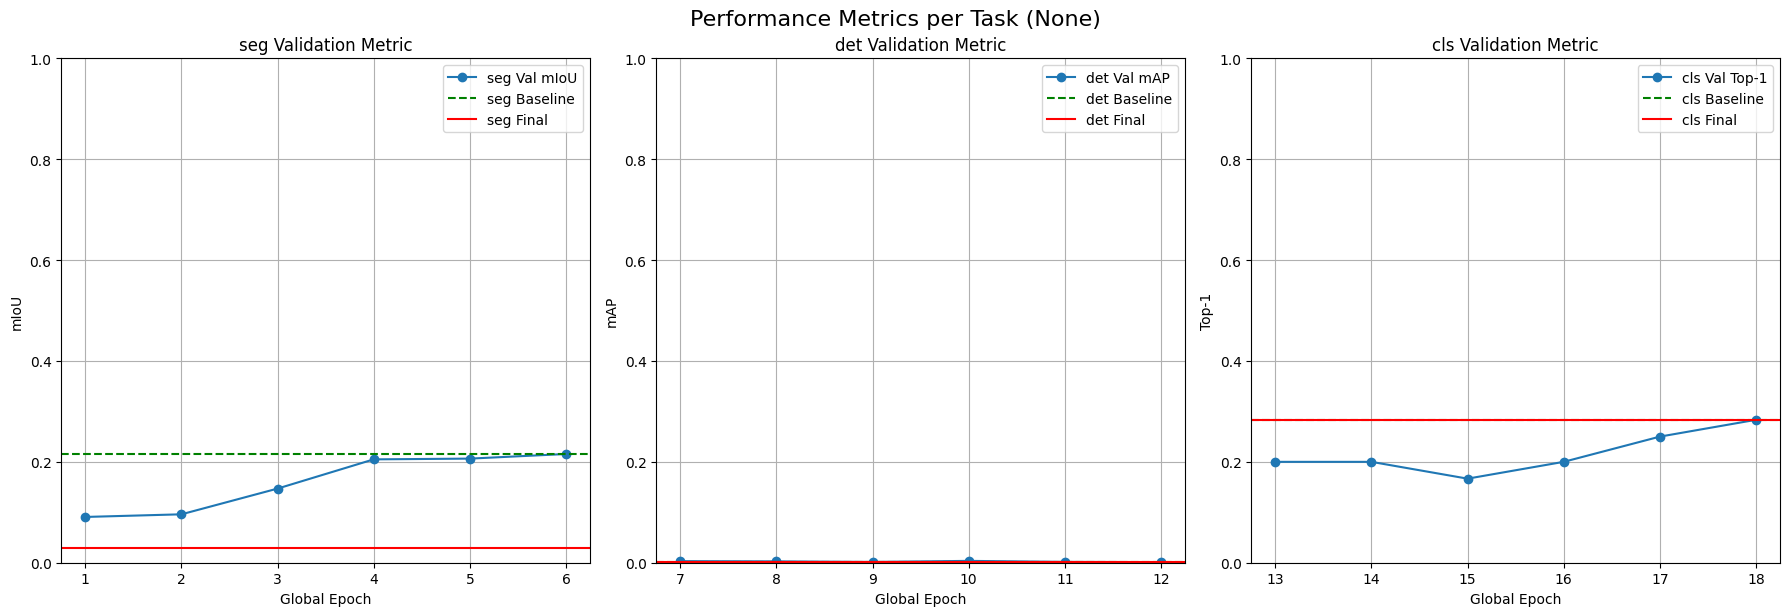



=== 使用抗災難性遺忘策略：EWC ===



----------------------------------------
開始訓練任務：seg, 階段：1/3, Epochs：6
----------------------------------------
Epoch 1/6, Task seg | Train Loss: 1.4911 | Train mIoU: 0.1302
評估結果 - Epoch 1/6, Task seg: Val Loss=1287890.7875, Val mIoU=0.0909
Epoch 2/6, Task seg | Train Loss: 1.0072 | Train mIoU: 0.1894
評估結果 - Epoch 2/6, Task seg: Val Loss=890419.7646, Val mIoU=0.1388
Epoch 3/6, Task seg | Train Loss: 0.8295 | Train mIoU: 0.3093
評估結果 - Epoch 3/6, Task seg: Val Loss=802245.8625, Val mIoU=0.2287
Epoch 4/6, Task seg | Train Loss: 0.8126 | Train mIoU: 0.3321
評估結果 - Epoch 4/6, Task seg: Val Loss=1278013.5083, Val mIoU=0.1790
Epoch 5/6, Task seg | Train Loss: 0.7161 | Train mIoU: 0.3462
評估結果 - Epoch 5/6, Task seg: Val Loss=954528.6687, Val mIoU=0.1928
Epoch 6/6, Task seg | Train Loss: 0.5836 | Train mIoU: 0.5848
評估結果 - Epoch 6/6, Task seg: Val Loss=750389.1062, Val mIoU=0.2713

任務 'seg' 階段訓練完成，總耗時 261.72 秒。
計算任務 'seg' 的 Fisher Information...
計算任務 'seg' 的 Fisher Information...
Fisher computatio


----------------------------------------
開始訓練任務：det, 階段：2/3, Epochs：6
----------------------------------------
Epoch 1/6, Task det | Train Loss: 19553.6543 | Train mAP: 0.0000 (Mitigation: EWC: 0.0001)
評估結果 - Epoch 1/6, Task det: Val Loss=13937.8174, Val mAP=0.0000
Epoch 2/6, Task det | Train Loss: 13702.5580 | Train mAP: 0.0008 (Mitigation: EWC: 0.0001)
評估結果 - Epoch 2/6, Task det: Val Loss=13668.0176, Val mAP=0.0000
Epoch 3/6, Task det | Train Loss: 11905.0604 | Train mAP: 0.0000 (Mitigation: EWC: 0.0001)
評估結果 - Epoch 3/6, Task det: Val Loss=14455.2954, Val mAP=0.0000
Epoch 4/6, Task det | Train Loss: 10679.1511 | Train mAP: 0.0000 (Mitigation: EWC: 0.0001)
評估結果 - Epoch 4/6, Task det: Val Loss=12945.8886, Val mAP=0.0000
Epoch 5/6, Task det | Train Loss: 8109.6481 | Train mAP: 0.0000 (Mitigation: EWC: 0.0001)
評估結果 - Epoch 5/6, Task det: Val Loss=12797.4896, Val mAP=0.0000
Epoch 6/6, Task det | Train Loss: 7372.0452 | Train mAP: 0.0000 (Mitigation: EWC: 0.0001)
評估結果 - Epoch 6/6, Task d


----------------------------------------
開始訓練任務：cls, 階段：3/3, Epochs：6
----------------------------------------
Epoch 1/6, Task cls | Train Loss: 22.7395 | Train Top-1: 0.1500 (Mitigation: EWC: 0.1771)
評估結果 - Epoch 1/6, Task cls: Val Loss=15.0614, Val Top-1=0.1333, Top-5=0.6000
Epoch 2/6, Task cls | Train Loss: 10.8673 | Train Top-1: 0.2000 (Mitigation: EWC: 0.1000)
評估結果 - Epoch 2/6, Task cls: Val Loss=11.2874, Val Top-1=0.1833, Top-5=0.6000
Epoch 3/6, Task cls | Train Loss: 7.6417 | Train Top-1: 0.2417 (Mitigation: EWC: 0.0763)
評估結果 - Epoch 3/6, Task cls: Val Loss=10.7223, Val Top-1=0.2000, Top-5=0.6167
Epoch 4/6, Task cls | Train Loss: 6.5794 | Train Top-1: 0.2792 (Mitigation: EWC: 0.0663)
評估結果 - Epoch 4/6, Task cls: Val Loss=9.9539, Val Top-1=0.1667, Top-5=0.6833
Epoch 5/6, Task cls | Train Loss: 6.0629 | Train Top-1: 0.2833 (Mitigation: EWC: 0.0623)
評估結果 - Epoch 5/6, Task cls: Val Loss=9.9649, Val Top-1=0.2667, Top-5=0.6500
Epoch 6/6, Task cls | Train Loss: 5.8480 | Train Top-1: 0.

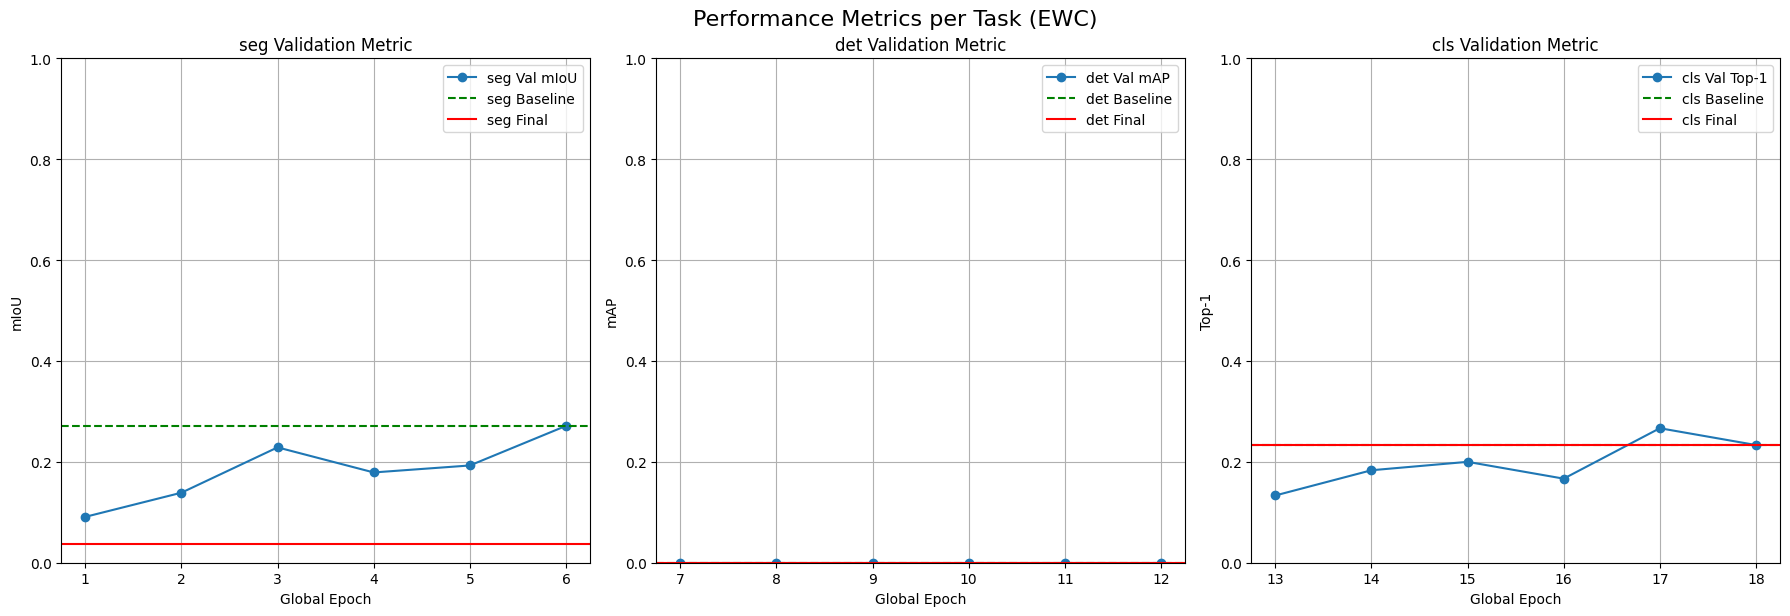



=== 使用抗災難性遺忘策略：LwF ===



----------------------------------------
開始訓練任務：seg, 階段：1/3, Epochs：6
----------------------------------------
Epoch 1/6, Task seg | Train Loss: 1.5040 | Train mIoU: 0.1221
評估結果 - Epoch 1/6, Task seg: Val Loss=1124048.3813, Val mIoU=0.0917
Epoch 2/6, Task seg | Train Loss: 1.0747 | Train mIoU: 0.2114
評估結果 - Epoch 2/6, Task seg: Val Loss=1051619.6125, Val mIoU=0.1364
Epoch 3/6, Task seg | Train Loss: 0.8846 | Train mIoU: 0.3194
評估結果 - Epoch 3/6, Task seg: Val Loss=875297.7937, Val mIoU=0.2024
Epoch 4/6, Task seg | Train Loss: 0.7685 | Train mIoU: 0.3768
評估結果 - Epoch 4/6, Task seg: Val Loss=809790.8667, Val mIoU=0.2104
Epoch 5/6, Task seg | Train Loss: 0.6506 | Train mIoU: 0.4408
評估結果 - Epoch 5/6, Task seg: Val Loss=1002630.2208, Val mIoU=0.2188
Epoch 6/6, Task seg | Train Loss: 0.5357 | Train mIoU: 0.5081
評估結果 - Epoch 6/6, Task seg: Val Loss=926829.6229, Val mIoU=0.2873

任務 'seg' 階段訓練完成，總耗時 260.55 秒。
創建階段 1 的教師模型用於 LwF/KD...



----------------------------------------
開始訓練任務：det, 階段：2/3, Epochs：6
----------------------------------------
Epoch 1/6, Task det | Train Loss: 255904.7349 | Train mAP: 0.0000 (Mitigation: LwF: 2338.8870)
評估結果 - Epoch 1/6, Task det: Val Loss=27125.0323, Val mAP=0.0000
Epoch 2/6, Task det | Train Loss: 163735.2292 | Train mAP: 0.0000 (Mitigation: LwF: 3344.6029)
評估結果 - Epoch 2/6, Task det: Val Loss=15536.7063, Val mAP=0.0000
Epoch 3/6, Task det | Train Loss: 121947.4928 | Train mAP: 0.0000 (Mitigation: LwF: 1731.0526)
評估結果 - Epoch 3/6, Task det: Val Loss=14379.0674, Val mAP=0.0000
Epoch 4/6, Task det | Train Loss: 108286.1507 | Train mAP: 0.0000 (Mitigation: LwF: 773.5609)
評估結果 - Epoch 4/6, Task det: Val Loss=14366.9468, Val mAP=0.0000
Epoch 5/6, Task det | Train Loss: 82159.3493 | Train mAP: 0.0000 (Mitigation: LwF: 998.4027)
評估結果 - Epoch 5/6, Task det: Val Loss=13606.0384, Val mAP=0.0000
Epoch 6/6, Task det | Train Loss: 75225.5450 | Train mAP: 0.0000 (Mitigation: LwF: 933.0790)
評估結


----------------------------------------
開始訓練任務：cls, 階段：3/3, Epochs：6
----------------------------------------
Epoch 1/6, Task cls | Train Loss: 49157.1158 | Train Top-1: 0.0958 (Mitigation: LwF: 418.9092)
評估結果 - Epoch 1/6, Task cls: Val Loss=10.6681, Val Top-1=0.0833, Top-5=0.5333
Epoch 2/6, Task cls | Train Loss: 29463.9732 | Train Top-1: 0.1042 (Mitigation: LwF: 554.7118)
評估結果 - Epoch 2/6, Task cls: Val Loss=9.5251, Val Top-1=0.1167, Top-5=0.6167
Epoch 3/6, Task cls | Train Loss: 26126.4098 | Train Top-1: 0.0833 (Mitigation: LwF: 646.5207)
評估結果 - Epoch 3/6, Task cls: Val Loss=9.3733, Val Top-1=0.0833, Top-5=0.6167
Epoch 4/6, Task cls | Train Loss: 22873.5042 | Train Top-1: 0.0833 (Mitigation: LwF: 324.2971)
評估結果 - Epoch 4/6, Task cls: Val Loss=9.3727, Val Top-1=0.0667, Top-5=0.7000
Epoch 5/6, Task cls | Train Loss: 20788.3569 | Train Top-1: 0.1042 (Mitigation: LwF: 398.3131)
評估結果 - Epoch 5/6, Task cls: Val Loss=9.3042, Val Top-1=0.0833, Top-5=0.6500
Epoch 6/6, Task cls | Train Loss

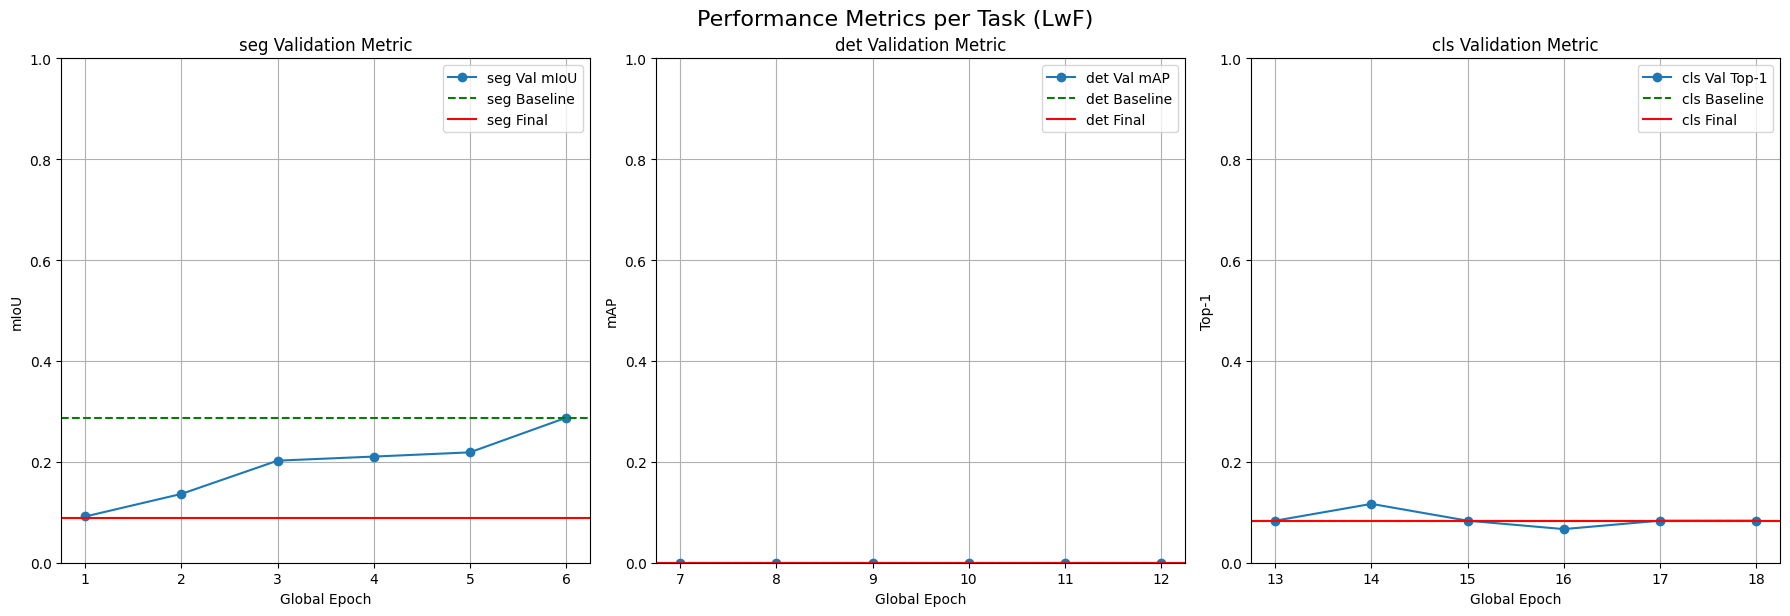



=== 使用抗災難性遺忘策略：Replay ===

----------------------------------------
開始訓練任務：seg, 階段：1/3, Epochs：6
----------------------------------------
Epoch 1/6, Task seg | Train Loss: 1.5901 | Train mIoU: 0.1367
評估結果 - Epoch 1/6, Task seg: Val Loss=1354948.4333, Val mIoU=0.0852
Epoch 2/6, Task seg | Train Loss: 1.1179 | Train mIoU: 0.1393
評估結果 - Epoch 2/6, Task seg: Val Loss=1079511.8250, Val mIoU=0.0909
Epoch 3/6, Task seg | Train Loss: 0.9244 | Train mIoU: 0.2448
評估結果 - Epoch 3/6, Task seg: Val Loss=1085700.0458, Val mIoU=0.1704
Epoch 4/6, Task seg | Train Loss: 0.7585 | Train mIoU: 0.4009
評估結果 - Epoch 4/6, Task seg: Val Loss=902373.0437, Val mIoU=0.2115
Epoch 5/6, Task seg | Train Loss: 0.6980 | Train mIoU: 0.4407
評估結果 - Epoch 5/6, Task seg: Val Loss=953850.3521, Val mIoU=0.2094
Epoch 6/6, Task seg | Train Loss: 0.5719 | Train mIoU: 0.5491
評估結果 - Epoch 6/6, Task seg: Val Loss=919701.6562, Val mIoU=0.2559

任務 'seg' 階段訓練完成，總耗時 262.12 秒。
創建階段 1 的教師模型用於 LwF/KD...



----------------------------------------
開始訓練任務：det, 階段：2/3, Epochs：6
----------------------------------------
Epoch 1/6, Task det | Train Loss: 19892.1746 | Train mAP: 0.0000 (Mitigation: Replay: 0.0302)
評估結果 - Epoch 1/6, Task det: Val Loss=16046.6359, Val mAP=0.0000
Epoch 2/6, Task det | Train Loss: 14223.6142 | Train mAP: 0.0024 (Mitigation: Replay: 0.0339)
評估結果 - Epoch 2/6, Task det: Val Loss=15173.6272, Val mAP=0.0039
Epoch 3/6, Task det | Train Loss: 12403.3123 | Train mAP: 0.0029 (Mitigation: Replay: 0.0257)
評估結果 - Epoch 3/6, Task det: Val Loss=14611.1993, Val mAP=0.0035
Epoch 4/6, Task det | Train Loss: 10933.8697 | Train mAP: 0.0009 (Mitigation: Replay: 0.0304)
評估結果 - Epoch 4/6, Task det: Val Loss=13480.2038, Val mAP=0.0004
Epoch 5/6, Task det | Train Loss: 8787.1200 | Train mAP: 0.0015 (Mitigation: Replay: 0.0172)
評估結果 - Epoch 5/6, Task det: Val Loss=14797.3784, Val mAP=0.0002
Epoch 6/6, Task det | Train Loss: 7645.0360 | Train mAP: 0.0004 (Mitigation: Replay: 0.0231)
評估結果 -


----------------------------------------
開始訓練任務：cls, 階段：3/3, Epochs：6
----------------------------------------


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 12.12 MiB is free. Process 8471 has 14.73 GiB memory in use. Of the allocated memory 14.36 GiB is allocated by PyTorch, and 239.79 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# @title 統一單頭多任務挑戰實作 (最終增強版)
# 安裝所需庫
!pip install torch torchvision torchaudio timm segmentation-models-pytorch opencv-python matplotlib scikit-learn -q # Add scikit-learn for metrics

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
# Import FPN directly from torchvision.ops
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
import timm
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import cv2 as cv # Use OpenCV for image loading
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any, Optional
from collections import OrderedDict # Needed for FPN input
import random
from sklearn.metrics import confusion_matrix # Use sklearn for confusion matrix (for mIoU)
# from COCOeval import COCOeval # Requires installing pycocotools and COCO dataset format - too complex for inline example


# 設定設備
# 使用 torch.cuda.is_available() 檢查 CUDA 是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

# VOC 顏色映射，用於分割任務
VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
]
VOC_COLORMAP_ARRAY = np.array(VOC_COLORMAP, dtype=np.uint8)

# 定義 ReplayBuffer 類
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity  # 緩衝區的最大容量
        self.buffer = []  # 儲存數據的列表

    def add(self, data: Tuple[torch.Tensor, Any]):
        # 將數據添加到緩衝區，如果超過容量則移除最早的數據
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self, batch_size: int) -> List[Tuple[torch.Tensor, Any]]:
        # 從緩衝區隨機採樣指定數量的數據
        batch_size = min(batch_size, len(self.buffer))  # 確保批次大小不超過緩衝區大小
        if batch_size <= 0 or not self.buffer: # Check if buffer is empty
            return [] # Return empty list if no samples to draw
        return random.sample(self.buffer, batch_size)  # 隨機採樣


# 定義多任務數據集類 (使用 OpenCV 讀取圖片)
class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images: List[str] = []
        self.annotations: List[Any] = []
        self.image_sizes: List[Tuple[int, int]] = [] # Store original image sizes (width, height)

        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            try:
                with open(labels_path, 'r') as f:
                    labels_data = json.load(f)
            except json.JSONDecodeError:
                raise ValueError(f"無法解析 {labels_path}。請確認它是有效的 JSON 檔案。")


            image_dir = os.path.join(data_dir, 'data')
            if not os.path.exists(image_dir):
                 raise FileNotFoundError(f"找不到圖片目錄 {image_dir}！")

            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)

            # Build a mapping from image file name to its annotations and original size
            img_info_dict = {img['file_name']: {'id': img['id'], 'width': img['width'], 'height': img['height']} for img in labels_data.get('images', [])}
            ann_dict: Dict[int, List[Dict[str, Any]]] = {}
            for ann in labels_data.get('annotations', []): # Use .get for safety
                img_id = ann.get('image_id') # Use .get for safety
                if img_id is not None:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    # Ensure bbox is a list/tuple of 4 numbers and category_id is valid
                    # COCO bbox format is [x_min, y_min, width, height]
                    if isinstance(ann.get('bbox'), list) and len(ann['bbox']) == 4 and ann.get('category_id') is not None:
                         ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})


            # Collect valid image paths, annotations, and original sizes
            for file_name in image_files:
                 img_info = img_info_dict.get(file_name)
                 if img_info is not None:
                     img_id = img_info['id']
                     if img_id in ann_dict and ann_dict[img_id]: # Ensure there are annotations for this image
                         full_path = os.path.join(image_dir, file_name)
                         self.images.append(full_path)
                         self.annotations.append(ann_dict[img_id])
                         self.image_sizes.append((img_info['width'], img_info['height'])) # Store (width, height)
                 # else: Image exists but no corresponding entry in labels.json or no annotations

        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img_file in image_files:
                img_path = os.path.join(data_dir, img_file)
                # Assuming mask file has same name but .png extension
                mask_path = os.path.join(data_dir, os.path.splitext(img_file)[0] + '.png')
                if os.path.exists(mask_path):
                    # Need to read image once to get size for segmentation, assuming mask has same size
                    try:
                        img = cv.imread(img_path)
                        if img is not None:
                            self.images.append(img_path)
                            self.annotations.append(mask_path)
                            self.image_sizes.append((img.shape[1], img.shape[0])) # Store (width, height)
                        else:
                             print(f"警告: 無法讀取圖片獲取尺寸 {img_path}，跳過。")
                    except Exception as e:
                         print(f"警告: 讀取圖片尺寸時發生錯誤 {img_path}: {e}，跳過。")

        elif task == 'cls':
            if not os.path.exists(data_dir):
                 raise FileNotFoundError(f"找不到分類數據目錄：{data_dir}")
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            if not label_dirs:
                 raise ValueError(f"在 {data_dir} 中未找到任何子目錄作為類別資料夾。")

            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img_file in files:
                        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')): # Check for common image extensions, lower() for case insensitivity
                            img_path = os.path.join(root, img_file)
                            # Read image to get size
                            try:
                                img = cv.imread(img_path)
                                if img is not None:
                                    self.images.append(img_path)
                                    self.annotations.append(label_to_index[label])
                                    self.image_sizes.append((img.shape[1], img.shape[0])) # Store (width, height)
                                else:
                                     print(f"警告: 無法讀取圖片獲取尺寸 {img_path}，跳過。")
                            except Exception as e:
                                 print(f"警告: 讀取圖片尺寸時發生錯誤 {img_path}: {e}，跳過。")


        # Final check for empty dataset
        if len(self.images) == 0:
             raise ValueError(f"在 {data_dir} 中未找到任何有效的數據用於任務 '{self.task}'，請檢查資料結構和檔案副檔名！")
        else:
            print(f"找到 {len(self.images)} 張圖片用於任務 '{self.task}'")


    def convert_mask_rgb_to_indices(self, mask_rgb: np.ndarray) -> np.ndarray:
        """Converts an RGB segmentation mask to a mask of class indices."""
        # Ensure mask_rgb is in RGB format (shape HxWx3)
        if mask_rgb.ndim != 3 or mask_rgb.shape[2] != 3:
             # Convert grayscale to RGB if needed (e.g., L or P mode masks saved as 1 channel)
             if mask_rgb.ndim == 2:
                  # Convert to HxWx1 and then to HxWx3 by repeating
                  mask_rgb = np.repeat(mask_rgb[:, :, np.newaxis], 3, axis=2)
             else:
                raise ValueError("Input mask must be HxW or HxWx3 format")


        height, width = mask_rgb.shape[:2]
        # Initialize index mask with a default value (e.g., 255 for ignore index, or 0 for background)
        # Using 0 assumes background color [0,0,0] maps to class 0.
        mask_indices = np.zeros((height, width), dtype=np.int64)

        # Use a dictionary lookup for faster color to index conversion
        rgb_to_index = {tuple(map(int, color)): i for i, color in enumerate(VOC_COLORMAP_ARRAY)} # Ensure colors are tuples of ints


        # Iterate through flattened pixels and assign index
        mask_flat = mask_rgb.reshape(-1, 3)
        mask_indices_flat = mask_indices.reshape(-1)

        for i in range(mask_flat.shape[0]):
             # Convert pixel color to tuple of ints for dictionary lookup
             pixel_color = tuple(map(int, mask_flat[i]))
             if pixel_color in rgb_to_index:
                  mask_indices_flat[i] = rgb_to_index[pixel_color]
             # Pixels not matching any color in colormap will remain 0 (background)

        return mask_indices


    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Any]:
        img_path = self.images[idx]
        original_width, original_height = self.image_sizes[idx]
        input_size = (512, 512) # Target model input size (width, height)

        # --- Image Loading and Resizing ---
        img = cv.imread(img_path)
        if img is None:
            # Try reading with PIL if OpenCV fails for some formats
            try:
                 img_pil = Image.open(img_path).convert("RGB")
                 img_resized_pil = img_pil.resize(input_size, Image.BILINEAR)
                 img_resized = np.array(img_resized_pil) # Convert PIL image to numpy array
                 # PIL image is already RGB
            except Exception as e:
                 raise ValueError(f"無法讀取或處理圖片：{img_path} - {e}")
        else:
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # Convert BGR to RGB
            # Resize image using OpenCV before converting to Tensor
            img_resized = cv.resize(img, input_size, interpolation=cv.INTER_LINEAR)


        # Convert resized image (numpy HxWx3) to Tensor and normalize [0, 1]
        img_tensor = torch.tensor(img_resized, dtype=torch.float32).permute(2, 0, 1) / 255.0 # Permute from HxWx3 to CxHxW

        # Apply the remaining transforms (normalization)
        if self.transform:
             img_tensor = self.transform(img_tensor)

        # --- Annotation/Target Loading and Processing ---
        if self.task == 'seg':
            mask_path = self.annotations[idx]
            # Use OpenCV to read mask
            mask_rgb = cv.imread(mask_path)
            if mask_rgb is None:
                # Try reading with PIL if OpenCV fails
                try:
                    mask_pil = Image.open(mask_path)
                    # Convert to RGB just in case it's P or L mode
                    mask_rgb_pil = mask_pil.convert("RGB")
                    mask_resized_pil = mask_rgb_pil.resize(input_size, Image.NEAREST) # Resize mask with NEAREST
                    mask_resized = np.array(mask_resized_pil) # Convert PIL image to numpy array
                except Exception as e:
                     raise ValueError(f"無法讀取或處理遮罩：{mask_path} - {e}")
            else:
                mask_rgb = cv.cvtColor(mask_rgb, cv.COLOR_BGR2RGB) # Convert BGR to RGB
                # Resize mask using Nearest Neighbor interpolation to preserve discrete labels
                mask_resized = cv.resize(mask_rgb, input_size, interpolation=cv.INTER_NEAREST)


            # Convert RGB mask to class indices
            mask_indices = self.convert_mask_rgb_to_indices(mask_resized)

            # Convert index mask to LongTensor
            mask_tensor = torch.tensor(mask_indices, dtype=torch.long)

            return img_tensor, mask_tensor

        elif self.task == 'det':
            ann = self.annotations[idx] # ann is a list of dicts: [{'boxes': [x, y, w, h], 'labels': class_id}, ...]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)

            # Scale bounding boxes according to the resize from original image size to 512x512
            # COCO format is [x_min, y_min, width, height]
            scale_x = input_size[0] / original_width
            scale_y = input_size[1] / original_height

            # Apply scaling
            boxes[:, 0] *= scale_x # x_min
            boxes[:, 1] *= scale_y # y_min
            boxes[:, 2] *= scale_x # width
            boxes[:, 3] *= scale_y # height

            # Ensure boxes are within bounds [0, 512]
            # Clamp x_min, y_min to be at least 0
            boxes[:, 0] = torch.clamp(boxes[:, 0], min=0)
            boxes[:, 1] = torch.clamp(boxes[:, 1], min=0)
            # Clamp x_max, y_max to be at most 512
            # boxes[:, 2] is width, boxes[:, 3] is height
            # x_max = x_min + w, y_max = y_min + h
            boxes[:, 2] = torch.clamp(boxes[:, 0] + boxes[:, 2], max=input_size[0]) - boxes[:, 0] # New width
            boxes[:, 3] = torch.clamp(boxes[:, 1] + boxes[:, 3], max=input_size[1]) - boxes[:, 1] # New height

            # Filter out potentially invalid boxes after scaling (e.g., width or height becomes <= 0)
            valid_indices = (boxes[:, 2] > 1e-2) & (boxes[:, 3] > 1e-2) # Use small epsilon instead of 0
            boxes = boxes[valid_indices]
            labels = labels[valid_indices]

            # Return a dictionary of tensors for detection targets
            target_dict = {'boxes': boxes, 'labels': labels, 'original_size': (original_width, original_height), 'resized_size': input_size}
            return img_tensor, target_dict

        elif self.task == 'cls':
            # Annotation is already the class index
            label_tensor = torch.tensor(self.annotations[idx], dtype=torch.long)
            return img_tensor, label_tensor

        else:
             # Should not happen if tasks are 'det', 'seg', 'cls'
             print(f"Warning: Task '{self.task}' not recognized.")
             return img_tensor, None # Return None for target if task is unknown


# Define image pre-processing transform (Normalization only)
# Resizing and ToTensor are handled in __getitem__ using OpenCV and torch.tensor
image_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom collate function for detection (handles list of dicts)
def custom_collate_det(batch: List[Tuple[torch.Tensor, Optional[Dict[str, Any]]]]) -> Tuple[torch.Tensor, List[Dict[str, torch.Tensor]]]:
    # Batch is a list of tuples: [(img1, target1), (img2, target2), ...]
    # where target is a dict {'boxes': ..., 'labels': ...} or None
    # Filter out samples where target is None or not a dict (shouldn't happen with corrected dataset, but defensive)
    batch = [item for item in batch if item[1] is not None and isinstance(item[1], dict)]
    if not batch:
        # Handle empty batch case - return empty tensors/lists with correct types/shapes
        # Assuming image tensor shape is [C, H, W] i.e., [3, 512, 512] after processing in dataset
        dummy_img = torch.empty(3, 512, 512)
        return dummy_img.unsqueeze(0).repeat(0, 1, 1, 1), [] # Return empty tensor with correct shape [0, 3, 512, 512]

    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch] # Keep targets as a list of dicts
    return images, targets

# Custom collate for other tasks (handles tensors) - default_collate works fine
# For seg and cls, the targets are single tensors, default_collate stacks them.

# Create Datasets and DataLoaders
base_dir = "/content/Unified-OneHead-Multi-Task-Challenge/data"
train_datasets = {}
val_datasets = {}

tasks_list = ['seg', 'det', 'cls'] # Define the tasks order for dataset loading

for task in tasks_list:
    try:
        # Adjust paths based on task name convention in your data directory
        if task == 'det':
             task_data_dir = "mini_coco_det"
        elif task == 'seg':
             task_data_dir = "mini_voc_seg"
        elif task == 'cls':
             task_data_dir = "imagenette_160"
        else:
             raise ValueError(f"Unknown task: {task}")

        train_path = os.path.join(base_dir, task_data_dir, 'train')
        val_path = os.path.join(base_dir, task_data_dir, 'val')

        train_datasets[task] = MultiTaskDataset(train_path, task, image_transform)
        val_datasets[task] = MultiTaskDataset(val_path, task, image_transform)

    except ValueError as e:
        print(f"資料載入失敗 ({task} 任務): {e}")
        # Store empty datasets if loading failed, so loaders will be empty
        train_datasets[task] = []
        val_datasets[task] = []


# Create DataLoaders
# Use robust error handling for empty datasets/loaders
train_loaders = {}
val_loaders = {}

for task in tasks_list:
    if task in train_datasets and train_datasets[task] and len(train_datasets[task]) > 0:
        collate_fn = custom_collate_det if task == 'det' else None
        train_loaders[task] = DataLoader(train_datasets[task], batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
    else:
         print(f"警告: 任務 '{task}' 的訓練數據集為空或無效。將跳過此任務的訓練。")
         train_loaders[task] = [] # Use an empty list to indicate no loader

    if task in val_datasets and val_datasets[task] and len(val_datasets[task]) > 0:
        collate_fn = custom_collate_det if task == 'det' else None
        val_loaders[task] = DataLoader(val_datasets[task], batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn)
    else:
         print(f"警告: 任務 '{task}' 的驗證數據集為空或無效。將跳過此任務的驗證。")
         val_loaders[task] = [] # Use an empty list


# Model Definition
class MultiTaskModel(nn.Module):
    def __init__(self, C_det=10, C_seg=21, C_cls=10):
        super(MultiTaskModel, self).__init__()
        # Use EfficientNet-B0 as the backbone returning multiple features
        # Set norm_layer to make BatchNorm trainable if needed
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, features_only=True, norm_layer=nn.BatchNorm2d)

        # Get channel counts for the specific layers used in FPN
        # Use feat2, feat3, feat4 (indices 2, 3, 4) for strides 8, 16, 32
        feature_info = self.backbone.feature_info
        # Check if feature_info has enough layers
        if len(feature_info.channels()) < 5: # We need at least feat0 to feat4
             raise ValueError("Backbone does not return enough feature layers for FPN (expected at least 5).")

        in_channels_list = [feature_info.channels()[i] for i in [2, 3, 4]] # Channels for feat2, feat3, feat4: [40, 112, 320]
        fpn_out_channels = 128 # FPN output channel size

        # Neck: FPN
        # Provide names for FPN input layers corresponding to the selected features
        # Use keys '0', '1', '2' for FPN input based on increasing stride
        fpn_in_keys = ['0', '1', '2'] # Keys for FPN input dict corresponding to features[2], features[3], features[4]
        self.fpn = FeaturePyramidNetwork(
            in_channels_list,
            out_channels=fpn_out_channels,
            extra_blocks=LastLevelMaxPool(), # Add a P5 layer keyed as 'pool' by default
            # FPN output keys will be the same as input keys plus 'pool' if extra_blocks is used
        )
        # The FPN output will be an OrderedDict with keys like {'0': P2, '1': P3, '2': P4, 'pool': P5}

        # Shared Feature Processing after FPN
        # Let's use the P4 level output from FPN (key '2', stride 32) for shared processing.
        # P4 spatial resolution for 512x512 input is 512/32 = 16x16.
        # P4 output channels are fpn_out_channels (128).
        self.shared_conv = nn.Sequential(
             # Input from FPN P4 (key '2')
             nn.Conv2d(fpn_out_channels, 64, kernel_size=3, padding=1),
             nn.ReLU(inplace=True)
        )
        shared_features_channels = 64

        # Task-Specific Heads
        # Detection head operates on spatial feature maps (output from shared_conv)
        # Predict (cx, cy, w, h, conf, class_id) per grid cell (16x16 grid)
        # Note: C_det here refers to the number of object classes, the output is 6 values per grid cell.
        # The 6th value could be class index or a one-hot encoding if you have multiple classes per grid.
        # Given C_det classes, the output should maybe be 4 (box) + 1 (conf) + C_det (class scores)
        # Let's follow the original (cx, cy, w, h, conf, class_id) structure which implies 6 channels.
        # This 6-channel output format is unusual for multi-class detection per grid cell.
        # A common approach is 4+1+num_classes or similar.
        # Stick to 6 channels as per original head definition. The last channel is likely intended as the class ID.
        self.det_head = nn.Conv2d(shared_features_channels, 6, kernel_size=1) # Output 6 channels per grid cell

        # Segmentation head needs high resolution output (512x512, C_seg channels)
        # Upsample from the shared features (16x16, 64 channels).
        self.seg_head = nn.Sequential(
            nn.Conv2d(shared_features_channels, C_seg, kernel_size=1), # Output C_seg channels per spatial location
            # Use interpolation mode 'nearest-exact' or 'bilinear' + align_corners=False for recent PyTorch versions
            # 'bilinear' is better for continuous features, 'nearest'/'nearest-exact' for discrete masks.
            # FPN output is features, so 'bilinear' is appropriate here before the final Conv1d to class scores.
            # The output of seg_head conv1d is raw scores, upsampling that with bilinear is fine.
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False) # Upsample to input resolution
        )

        # Classification head operates on a global feature vector.
        # Apply Global Average Pooling and Linear layers to the shared features.
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # Pool over 16x16 spatial size to get 1x1
            nn.Flatten(),            # Flatten 1x1x64 to 64
            nn.Linear(shared_features_channels, C_cls) # Input channels = 64, Output channels = 10
        )


    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Get feature layers from backbone
        features = self.backbone(x) # List: [feat0..feat4]

        # Select features for FPN input (strides 8, 16, 32)
        selected_features = OrderedDict()
        if len(features) < 5:
             raise RuntimeError(f"Backbone features list has unexpected length {len(features)}. Expected at least 5.")

        selected_features['0'] = features[2] # stride 8
        selected_features['1'] = features[3] # stride 16
        selected_features['2'] = features[4] # stride 32

        # Pass selected features to FPN
        fpn_outputs = self.fpn(selected_features) # OrderedDict: {'0': P2, '1': P3, '2': P4, 'pool': P5}

        # Select FPN level (P4, key '2') for shared head input
        fpn_level_key_for_head = '2'
        if fpn_level_key_for_head not in fpn_outputs:
             raise RuntimeError(f"FPN output does not contain expected key '{fpn_level_key_for_head}'. Available keys: {fpn_outputs.keys()}")

        shared_features_input = fpn_outputs[fpn_level_key_for_head] # P4 level, shape [batch, 128, 16, 16]

        # Pass through shared convolutional layers
        shared_features = self.shared_conv(shared_features_input) # Output: [batch, 64, 16, 16]

        # Pass to task-specific heads
        det_out = self.det_head(shared_features) # Output: [batch, 6, 16, 16]
        seg_out = self.seg_head(shared_features) # Output: [batch, C_seg, 512, 512]
        cls_out = self.cls_head(shared_features) # Output: [batch, C_cls]

        return det_out, seg_out, cls_out


# Initialize Model
# C_det_actual = 10 # Mini-COCO-Det categories 1-10
# C_seg_actual = 21 # VOC classes 0-20 (including background)
# C_cls_actual = 10 # Imagenette classes

# Ensure these constants are defined globally or passed appropriately
# For a standalone block, let's define them again if they weren't in the previous one
C_det_actual = 10
C_seg_actual = 21
C_cls_actual = 10

model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)

# Count parameters
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total parameters: {total_params:,} (< 8M: {total_params < 8_000_000})")


# --- Loss Functions ---
# Simplified detection loss (MSE on first box coords)
def compute_detection_loss(det_output: torch.Tensor, targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
    boxes_pred = det_output.permute(0, 2, 3, 1)  # [batch_size, H, W, 6] H=W=16
    loss = torch.tensor(0., device=det_output.device)
    valid_samples = 0
    for i in range(len(targets)):
        if not isinstance(targets[i], dict) or 'boxes' not in targets[i] or len(targets[i]['boxes']) == 0:
            continue # Skip samples with no targets

        target_boxes = targets[i]['boxes'].to(det_output.device) # [num_boxes, 4] (x, y, w, h format)

        if boxes_pred.size(1) > 0 and boxes_pred.size(2) > 0:
            pred_cxcywh = boxes_pred[i, 0, 0, :4] # Predicted [cx, cy, w, h] from grid cell (0,0)

            # Convert target [x, y, w, h] to [cx, cy, w, h] for MSE
            target_cxcywh = torch.stack([
                target_boxes[0][0] + target_boxes[0][2] / 2,
                target_boxes[0][1] + target_boxes[0][3] / 2,
                target_boxes[0][2],
                target_boxes[0][3]
            ])

            loss += nn.MSELoss()(pred_cxcywh, target_cxcywh)
            valid_samples += 1

    return loss / valid_samples if valid_samples > 0 else torch.tensor(0., device=det_output.device)

# Segmentation loss (CrossEntropyLoss)
def compute_segmentation_loss(seg_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    criterion = nn.CrossEntropyLoss()
    if targets.size()[-2:] != seg_output.size()[-2:]:
         print(f"Error: Seg target size {targets.size()} does not match output size {seg_output.size()} in loss calculation.")
         return torch.tensor(0., device=seg_output.device)
    return criterion(seg_output, targets)

# Classification loss (CrossEntropyLoss)
def compute_classification_loss(cls_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    criterion = nn.CrossEntropyLoss()
    return criterion(cls_output, targets)


# --- Evaluation Functions ---
# Helper for IoU (numpy version)
def calculate_iou_np(box1: np.ndarray, box2: np.ndarray) -> float:
    x1_min, y1_min, w1, h1 = box1
    x1_max, y1_max = x1_min + w1, y1_min + h1
    x2_min, y2_min, w2, h2 = box2
    x2_max, y2_max = x2_min + w2, y2_min + h2

    x_left = max(x1_min, x2_min)
    y_top = max(y1_min, y2_min)
    x_right = min(x1_max, x2_max)
    y_bottom = min(y1_max, y2_max)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - intersection_area

    return intersection_area / union_area if union_area > 0 else 0.0

# Segmentation evaluation (mIoU)
def evaluate_segmentation(model: nn.Module, loader: DataLoader, num_classes: int = 21) -> Dict[str, float]:
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'mIoU': 0.0, 'loss': 0.0}

    model.eval()
    confusion_matrix_np = np.zeros((num_classes, num_classes), dtype=np.int64)
    total_loss = 0
    num_batches = 0
    criterion = nn.CrossEntropyLoss(reduction='sum') # Use sum reduction for calculating average loss

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            _, seg_out, _ = model(inputs) # seg_out: [batch, C_seg, 512, 512]

            # Calculate loss
            loss = criterion(seg_out, targets)
            total_loss += loss.item()
            num_batches += 1

            # Get predicted class for mIoU
            predicted_masks = torch.argmax(seg_out, dim=1) # [batch, 512, 512]

            if predicted_masks.size() != targets.size():
                 print(f"Warning: Evaluate Seg target size {targets.size()} != predicted size {predicted_masks.size()}. Skipping mIoU for batch.")
                 continue

            predicted_flat = predicted_masks.view(-1).cpu().numpy()
            targets_flat = targets.view(-1).cpu().numpy()

            # Update confusion matrix
            try:
                cm_batch = confusion_matrix(targets_flat, predicted_flat, labels=np.arange(num_classes))
                confusion_matrix_np += cm_batch
            except ValueError as e:
                 print(f"Warning: Error calculating confusion matrix for batch: {e}.")


    # Calculate mIoU
    true_positives = np.diag(confusion_matrix_np)
    false_positives = np.sum(confusion_matrix_np, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix_np, axis=1) - true_positives
    union = true_positives + false_positives + false_negatives
    iou_per_class = np.divide(true_positives.astype(np.float64), union.astype(np.float64), out=np.full(num_classes, np.nan), where=union != 0)
    valid_iou = iou_per_class[~np.isnan(iou_per_class)]
    mIoU = np.mean(valid_iou) if valid_iou.size > 0 else 0.0

    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0

    return {'mIoU': mIoU, 'loss': avg_loss}


# Detection evaluation (Simplified mAP placeholder)
def evaluate_detection(model: nn.Module, loader: DataLoader, iou_threshold: float = 0.5) -> Dict[str, float]:
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'mAP': 0.0, 'loss': 0.0}

    # print("Note: Detection evaluation (mAP) is a simplified placeholder.")

    model.eval()
    total_matched_predictions = 0
    total_predictions_with_target = 0
    total_loss = 0
    num_batches = 0
    criterion = compute_detection_loss # Use the same simplified loss for evaluation

    with torch.no_grad():
        for inputs, targets in loader:
            if inputs.size(0) == 0: continue
            inputs = inputs.to(device)

            det_out, _, _ = model(inputs) # det_out: [batch, 6, 16, 16]

            # Calculate loss
            loss = criterion(det_out, targets) # targets is list of dicts, handled by criterion
            total_loss += loss.item() if isinstance(loss, torch.Tensor) else loss # Handle scalar or tensor loss
            num_batches += 1

            # --- Simplified Matching for Placeholder mAP ---
            boxes_pred = det_out.permute(0, 2, 3, 1)  # [batch_size, 16, 16, 6]

            for i in range(inputs.size(0)): # Process each image in batch
                 img_predictions = boxes_pred[i].view(-1, 6) # [256, 6]
                 conf_scores = img_predictions[:, 4]
                 conf_threshold = 0.2 # Example confidence threshold
                 confident_predictions = img_predictions[conf_scores > conf_threshold] # [N_pred, 6]

                 if confident_predictions.size(0) == 0:
                      continue

                 predicted_boxes_cxcywh = confident_predictions[:, :4]
                 predicted_boxes_xywh = torch.stack([ # Convert to [x_min, y_min, w, h]
                     predicted_boxes_cxcywh[:, 0] - predicted_boxes_cxcywh[:, 2] / 2,
                     predicted_boxes_cxcywh[:, 1] - predicted_boxes_cxcywh[:, 3] / 2,
                     predicted_boxes_cxcywh[:, 2],
                     predicted_boxes_cxcywh[:, 3]
                 ], dim=1) # [N_pred, 4]

                 # Get ground truth boxes (already scaled in dataset)
                 if not isinstance(targets[i], dict) or 'boxes' not in targets[i] or len(targets[i]['boxes']) == 0:
                      total_predictions_with_target += confident_predictions.size(0)
                      continue

                 ground_truth_boxes_xywh = targets[i]['boxes'].to(device) # [N_gt, 4] (x, y, w, h)

                 matched_preds_in_image = 0
                 total_predictions_with_target += confident_predictions.size(0)

                 if ground_truth_boxes_xywh.size(0) > 0:
                      # Compute IoUs between all predicted boxes and all GT boxes
                      for pred_box_xywh in predicted_boxes_xywh:
                           ious = [calculate_iou_np(pred_box_xywh.cpu().numpy(), gt_box_xywh.cpu().numpy()) for gt_box_xywh in ground_truth_boxes_xywh]
                           if any(iou > iou_threshold for iou in ious):
                                matched_preds_in_image += 1

                 total_matched_predictions += matched_preds_in_image


    simplified_ap = total_matched_predictions / total_predictions_with_target if total_predictions_with_target > 0 else 0.0
    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0

    return {'mAP': simplified_ap, 'loss': avg_loss}


# Classification evaluation (Top-1 and Top-5 Accuracy)
def evaluate_classification(model: nn.Module, loader: DataLoader) -> Dict[str, float]:
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'Top-1': 0.0, 'Top-5': 0.0, 'loss': 0.0}

    model.eval()
    total_samples = 0
    top1_correct = 0
    top5_correct_sum = 0 if C_cls_actual >= 5 else -1 # Use sum for correctness count
    total_loss = 0
    num_batches = 0
    criterion = nn.CrossEntropyLoss(reduction='sum') # Use sum reduction for average loss

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            _, _, cls_out = model(inputs) # cls_out: [batch, C_cls]

            # Calculate loss
            loss = criterion(cls_out, targets)
            total_loss += loss.item()
            num_batches += 1

            # Top-1 Accuracy
            _, predicted = cls_out.max(1)
            total_samples += targets.size(0)
            top1_correct += (predicted == targets).sum().item()

            # Top-5 Accuracy (if C_cls >= 5)
            if C_cls_actual >= 5:
                _, top5_preds = cls_out.topk(5, dim=1, largest=True, sorted=True) # [batch, 5]
                targets_expanded = targets.view(-1, 1) # [batch_size, 1]
                top5_correct_sum += (targets_expanded == top5_preds).any(dim=1).sum().item()

    metrics = {}
    metrics['Top-1'] = top1_correct / total_samples if total_samples > 0 else 0.0
    if C_cls_actual >= 5:
        metrics['Top-5'] = top5_correct_sum / total_samples if total_samples > 0 else 0.0
    else:
         metrics['Top-5'] = float('nan') # Indicate not applicable

    metrics['loss'] = total_loss / num_batches if num_batches > 0 else 0.0

    return metrics


# --- 抗災難性遺忘策略實現 (ReplayBuffer, EWC, LwF, KD 已在前面或上面定義) ---

# Fisher Information 計算函數 (用於 EWC)
def compute_fisher(model: nn.Module, dataloader: DataLoader, task: str) -> Dict[str, torch.Tensor]:
    """Computes the diagonal Fisher Approximation for EWC."""
    if len(dataloader) == 0 or dataloader.dataset is None or len(dataloader.dataset) == 0:
         print(f"警告: 任務 '{task}' 的載入器為空或無效，無法計算 Fisher Information。")
         return {}

    model.eval() # Compute Fisher in eval mode
    fisher: Dict[str, torch.Tensor] = {}
    # Use a temporary criterion to get gradients for the task
    try:
        criterion = get_loss_function(task)
    except ValueError:
        print(f"警告: 無法為任務 '{task}' 找到有效的損失函數來計算 Fisher。")
        return {}

    dummy_optimizer = optim.Adam(model.parameters(), lr=0) # Dummy optimizer

    num_batches = 0
    print(f"計算任務 '{task}' 的 Fisher Information...")

    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        if task != 'det' and isinstance(targets, torch.Tensor):
            targets = targets.to(device)

        dummy_optimizer.zero_grad()

        det_out, seg_out, cls_out = model(inputs)

        # Compute loss for the task
        if task == 'det':
             loss = criterion(det_out, targets)
        elif task == 'seg':
             loss = criterion(seg_out, targets)
        elif task == 'cls':
             loss = criterion(cls_out, targets)
        else:
             loss = None # Should not happen

        if loss is not None and isinstance(loss, torch.Tensor) and loss.requires_grad and loss.item() > 0:
            loss.backward()

            # Accumulate squared gradients
            for name, param in model.named_parameters():
                if param.grad is not None and param.requires_grad: # Only accumulate for trainable params that got gradients
                    if name not in fisher:
                        fisher[name] = param.grad.data.clone().pow(2)
                    else:
                        fisher[name] += param.grad.data.clone().pow(2)

            num_batches += 1
            # Optional: Limit batches for faster Fisher computation during debugging
            # if num_batches >= 50:
            #    break


    # Average the Fisher Information
    if num_batches > 0:
        for name in fisher.keys():
            fisher[name] /= num_batches
        print(f"Fisher computation finished for task '{task}' over {num_batches} batches.")
        return fisher
    else:
        print(f"警告: 未能為任務 '{task}' 計算 Fisher Information，所有損失或梯度為零。")
        return {}


# EWC Loss function
def ewc_loss(model: nn.Module, fisher_dict: Dict[str, torch.Tensor], old_params: Dict[str, torch.Tensor], lambda_ewc: float = 0.5) -> torch.Tensor:
    """Calculates the EWC regularization loss."""
    loss = torch.tensor(0., device=device)
    for name, param in model.named_parameters():
        # Only apply EWC to parameters present in the Fisher dict and old_params
        if name in fisher_dict and name in old_params:
            # Ensure components are on the same device as param.grad or param
            fisher = fisher_dict[name].to(param.device) # Ensure Fisher is on the parameter's device
            old_param = old_params[name].to(param.device) # Ensure old_param is on the parameter's device
            # Ensure shapes match (should if loaded correctly)
            if param.shape == old_param.shape and fisher.shape == param.shape:
                 # Only add loss if the parameter requires gradient in the current training step
                 # This check might be implicit if param.grad is checked later, but explicit is safer
                 # The original EWC formulation usually applies to all parameters from previous tasks.
                 # Check param.requires_grad to see if this parameter is currently trainable.
                 # However, the Fisher is for *all* trainable params from the previous task.
                 # Let's apply EWC to all params that were in the Fisher/old_params dict.
                 loss += (fisher * (param - old_param) ** 2).sum()
            else:
                 print(f"Warning: Shape mismatch for {name} in EWC. Param: {param.shape}, OldParam: {old_param.shape}, Fisher: {fisher.shape}. Skipping EWC term.")
        # else: parameter is new, or not in fisher/old_params for this task, skip EWC term

    return lambda_ewc * loss


# LwF Loss function
def lwf_loss(student_outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
             teacher_outputs: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
             current_task: str, lambda_lwf: float = 1.0) -> torch.Tensor:
    """Calculates the Learning without Forgetting (LwF) regularization loss."""
    # LwF applies KL divergence between student and teacher outputs for PREVIOUS tasks on CURRENT task data.

    student_det, student_seg, student_cls = student_outputs
    teacher_det, teacher_seg, teacher_cls = teacher_outputs # Outputs from teacher model on the same inputs

    loss = torch.tensor(0., device=student_det.device)
    kl_criterion = nn.KLDivLoss(reduction='batchmean') # Use batchmean reduction

    # Apply KL divergence for tasks *other than* the current task
    # Compare student's output for a PREVIOUS task head with the teacher's output for that same head.

    if current_task != 'det':
        # LwF loss for detection head output
        # Ensure shapes match
        if student_det.shape == teacher_det.shape:
             # KLDivLoss expects log probabilities for input (student) and probabilities for target (teacher)
             loss += kl_criterion(torch.log_softmax(student_det, dim=1), torch.softmax(teacher_det.detach(), dim=1)) # Use detach on teacher output
        # else: Warning handled in train_stage if needed

    if current_task != 'seg':
        # LwF loss for segmentation head output
        if student_seg.shape == teacher_seg.shape:
             loss += kl_criterion(torch.log_softmax(student_seg, dim=1), torch.softmax(teacher_seg.detach(), dim=1)) # Use detach on teacher output
        # else: Warning handled in train_stage if needed

    if current_task != 'cls':
        # LwF loss for classification head output
        if student_cls.shape == teacher_cls.shape:
             loss += kl_criterion(torch.log_softmax(student_cls, dim=1), torch.softmax(teacher_cls.detach(), dim=1)) # Use detach on teacher output
        # else: Warning handled in train_stage if needed

    return lambda_lwf * loss


# Knowledge Distillation Loss (Typically applied to classification head)
def knowledge_distillation_loss(student_cls_output: torch.Tensor, old_model_cls_output: torch.Tensor,
                                temperature: float = 1.0, lambda_kd: float = 1.0) -> torch.Tensor:
    """Calculates Knowledge Distillation loss for classification (comparing soft logits)."""
    # student_cls_output: [batch_size, C_cls]
    # old_model_cls_output: [batch_size, C_cls] (from teacher/old model)

    # Apply temperature scaling to soften the logits
    # Ensure teacher output is detached
    soft_student_cls = torch.log_softmax(student_cls_output / temperature, dim=1)
    soft_old_model_cls = torch.softmax(old_model_cls_output.detach() / temperature, dim=1)

    kl_criterion = nn.KLDivLoss(reduction='batchmean')

    # Scale loss by temperature**2 as per Hinton's distillation paper
    loss = kl_criterion(soft_student_cls, soft_old_model_cls) * (temperature ** 2)

    return lambda_kd * loss


# Replay Buffer (Class already defined)


# --- Training Stage Function ---

def get_loss_function(task: str):
    """Helper to get the appropriate loss function for a task."""
    if task == 'det':
        return compute_detection_loss
    elif task == 'seg':
        return compute_segmentation_loss
    elif task == 'cls':
        return compute_classification_loss
    else:
        raise ValueError(f"Unknown task: {task}")

def get_eval_function(task: str):
    """Helper to get the appropriate evaluation function for a task."""
    if task == 'det':
        return evaluate_detection # Returns {'mAP': value, 'loss': value}
    elif task == 'seg':
        return evaluate_segmentation # Returns {'mIoU': value, 'loss': value}
    elif task == 'cls':
        return evaluate_classification # Returns {'Top-1': value, 'Top-5': value, 'loss': value}
    else:
        raise ValueError(f"Unknown task: {task}")


def evaluate_model(model: nn.Module, loader: DataLoader, task: str) -> Dict[str, float]:
    """Helper function to perform evaluation and return metrics including loss."""
    if not loader or len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         print(f"警告: 任務 '{task}' 的驗證載入器為空或無效，跳過評估。")
         # Return default metrics with 0.0 loss
         if task == 'seg': return {'mIoU': 0.0, 'loss': 0.0}
         elif task == 'det': return {'mAP': 0.0, 'loss': 0.0}
         elif task == 'cls': return {'Top-1': 0.0, 'Top-5': 0.0, 'loss': 0.0}
         else: return {'loss': 0.0}

    eval_fn = get_eval_function(task)
    metrics = eval_fn(model, loader)
    return metrics


def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int,
                optimizer: optim.Optimizer, scheduler: optim.lr_scheduler._LRScheduler,
                replay_buffers: Dict[str, ReplayBuffer], tasks_order: List[str], stage: int,
                mitigation_methods: List[str],
                ewc_fisher: Optional[Dict[str, torch.Tensor]] = None,
                ewc_old_params: Optional[Dict[str, torch.Tensor]] = None,
                lwf_teacher_model: Optional[nn.Module] = None
               ) -> Tuple[List[Dict[str, float]], List[Dict[str, float]], Dict[str, float]]: # Return train_metrics_history too
    """Trains the model for a specific task with optional mitigation methods and evaluates each epoch."""

    print(f"\n{'--'*20}\n開始訓練任務：{task}, 階段：{stage + 1}/{len(tasks_order)}, Epochs：{epochs}\n{'--'*20}")

    train_metrics_history: List[Dict[str, float]] = [] # Store metrics after each epoch's training
    val_metrics_history: List[Dict[str, float]] = [] # Store metrics after each epoch's evaluation

    current_task_loss_fn = get_loss_function(task)
    current_task_eval_fn = get_eval_function(task)


    for epoch in range(epochs):
        model.train()
        epoch_start_time = time.time()
        total_train_loss = 0
        num_train_batches = 0

        # Variables to accumulate metrics for the training set evaluation after the epoch
        # Note: Evaluating on the full training set after every epoch can be slow.
        # A faster approach might be to evaluate on a subset or skip some epochs.
        # For now, let's implement evaluation on the full train loader.
        # These variables will accumulate predictions/targets similar to validation evaluation.
        # ... (Initialization for train metrics accumulation based on task) ...
        # Since evaluation functions already iterate through a loader, let's just call them
        # with the train_loader after the training loop for the epoch.

        if train_loader and len(train_loader) > 0:
            # Training loop for the epoch
            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                if task != 'det' and isinstance(targets, torch.Tensor):
                    targets = targets.to(device)

                optimizer.zero_grad()
                student_det, student_seg, student_cls = model(inputs)
                student_outputs = (student_det, student_seg, student_cls)

                # --- Compute Current Task Loss ---
                if task == 'det':
                     task_loss = current_task_loss_fn(student_det, targets)
                elif task == 'seg':
                     task_loss = current_task_loss_fn(student_seg, targets)
                elif task == 'cls':
                     task_loss = current_task_loss_fn(student_cls, targets)
                else:
                     task_loss = torch.tensor(0., device=device) # Should not happen


                total_loss = task_loss # Start total loss with current task loss

                # --- Apply Mitigation Strategies ---
                method_losses_dict = {} # Dictionary to store loss components for logging

                # EWC: Applied for tasks AFTER the first one
                if 'EWC' in mitigation_methods and stage > 0 and ewc_fisher and ewc_old_params:
                    ewc = ewc_loss(model, ewc_fisher, ewc_old_params)
                    total_loss += ewc
                    method_losses_dict['EWC'] = ewc.item()

                # LwF / KD: Applied for tasks AFTER the first one
                if ('LwF' in mitigation_methods or 'KD' in mitigation_methods) and stage > 0 and lwf_teacher_model:
                    lwf_teacher_model.eval() # Set teacher to eval mode
                    with torch.no_grad():
                         teacher_det, teacher_seg, teacher_cls = lwf_teacher_model(inputs)
                         teacher_outputs = (teacher_det, teacher_seg, teacher_cls)

                    if 'LwF' in mitigation_methods:
                        lwf = lwf_loss(student_outputs, teacher_outputs, task)
                        total_loss += lwf
                        method_losses_dict['LwF'] = lwf.item()

                    if 'KD' in mitigation_methods:
                         # KD is typically applied to the classification head
                         # Pass student cls output and teacher cls output
                         if student_cls.shape == teacher_cls.shape:
                             kd_loss = knowledge_distillation_loss(student_cls, teacher_cls)
                             total_loss += kd_loss
                             method_losses_dict['KD'] = kd_loss.item()
                         else:
                             print(f"Warning: KD Cls output shape mismatch. Student: {student_cls.shape}, Teacher: {teacher_cls.shape}. Skipping KD.")



                # Replay: Can be applied from the second task onwards (stage > 0)
                if 'Replay' in mitigation_methods and stage > 0:
                    replay_total_loss_across_prev_tasks = torch.tensor(0., device=device)
                    replay_sample_count_across_prev_tasks = 0

                    # Sample from buffers of *previous* tasks
                    for prev_task in tasks_order[:stage]: # Iterate through tasks trained BEFORE the current one
                        buffer = replay_buffers[prev_task]
                        # Sample a small batch from the replay buffer (e.g., same size as current batch)
                        replay_batch_size = min(train_loader.batch_size, len(buffer.buffer))
                        if replay_batch_size > 0:
                             buffer_samples = buffer.sample(batch_size=replay_batch_size)
                             for b_inputs, b_targets in buffer_samples:
                                b_inputs = b_inputs.to(device)
                                # Move buffer targets to device and handle different types
                                if prev_task == 'det':
                                     b_targets_on_device = []
                                     if isinstance(b_targets, list): # Defensive check
                                         for t_dict in b_targets:
                                             if isinstance(t_dict, dict): # Defensive check
                                                 t_dict_on_device = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t_dict.items()}
                                                 b_targets_on_device.append(t_dict_on_device)
                                     b_targets = b_targets_on_device # Use the potentially empty list

                                elif prev_task in ['seg', 'cls'] and isinstance(b_targets, torch.Tensor):
                                     b_targets = b_targets.to(device)
                                else:
                                     # Unexpected buffer target type or empty/invalid data
                                     continue # Skip this sample

                                # Get model outputs for replayed data
                                b_student_det, b_student_seg, b_student_cls = model(b_inputs)

                                # Compute loss for the *original task* of the replayed data
                                prev_task_loss_fn = get_loss_function(prev_task)

                                if prev_task == 'det':
                                     replay_task_loss = prev_task_loss_fn(b_student_det, b_targets)
                                elif prev_task == 'seg':
                                     replay_task_loss = prev_task_loss_fn(b_student_seg, b_targets)
                                elif prev_task == 'cls':
                                     replay_task_loss = prev_task_loss_fn(b_student_cls, b_targets)
                                else:
                                     replay_task_loss = torch.tensor(0., device=device) # Should not happen

                                if replay_task_loss is not None and isinstance(replay_task_loss, torch.Tensor) and replay_task_loss.item() > 0:
                                     replay_total_loss_across_prev_tasks += replay_task_loss
                                     replay_sample_count_across_prev_tasks += 1 # Count valid loss contributions

                    if replay_sample_count_across_prev_tasks > 0:
                         # Average replay loss over samples that contributed and add to total loss
                         # Consider weighting replay loss if needed
                         lambda_replay = 1.0
                         avg_replay_loss = replay_total_loss_across_prev_tasks / replay_sample_count_across_prev_tasks * lambda_replay
                         total_loss += avg_replay_loss
                         method_losses_dict['Replay'] = avg_replay_loss.item()


                # Placeholder for POCL and SSR (not implemented realistically)
                # if 'POCL' in mitigation_methods: # Needs implementation
                #    pocl = pocl_simulate(...)
                #    total_loss += pocl
                #    method_losses_dict['POCL'] = pocl.item()
                # if 'SSR' in mitigation_methods: # Needs implementation
                #    ssr = ssr_simulate(...)
                #    total_loss += ssr
                #    method_losses_dict['SSR'] = ssr.item()


                # --- Backpropagate ---
                if isinstance(total_loss, torch.Tensor) and total_loss.requires_grad:
                    total_loss.backward()
                    optimizer.step()
                elif isinstance(total_loss, torch.Tensor):
                     # Handle case where total_loss is a tensor but doesn't require grad (e.g., from 0 loss batches)
                     pass
                else:
                    print(f"Warning: total_loss is not a tensor ({type(total_loss)}). Skipping backward pass.")


                total_train_loss += total_loss.item()
                num_train_batches += 1

                # --- Add current batch data to Replay Buffer ---
                detached_inputs = inputs.detach().cpu()
                if task == 'det':
                    detached_targets = copy.deepcopy(targets) # Deepcopy list of dicts
                elif isinstance(targets, torch.Tensor):
                    detached_targets = targets.detach().cpu()
                else:
                    detached_targets = targets # Assume primitive types

                replay_buffers[task].add((detached_inputs, detached_targets))

            # --- End of Epoch Training ---
            avg_train_loss = total_train_loss / num_train_batches if num_train_batches > 0 else 0.0

            # --- Evaluate on Training Set after Epoch ---
            # Calculate training metrics for the epoch (loss and task-specific metric)
            # Note: Evaluating on the full training set every epoch can be slow.
            # Consider evaluating on a subset or less frequently for larger datasets.
            model.eval() # Set model to eval mode for evaluation
            # Call the evaluation function for the training loader
            train_metrics_for_epoch = evaluate_model(model, train_loader, task)
            model.train() # Set model back to train mode

            # Store training metrics (including loss)
            train_metrics_for_epoch['loss'] = avg_train_loss # Use the calculated average train loss for logging
            train_metrics_history.append(train_metrics_for_epoch)


            # Print training metrics and mitigation loss components
            metric_info = f"Epoch {epoch + 1}/{epochs}, Task {task}"
            metric_info += f" | Train Loss: {avg_train_loss:.4f}"
            if task == 'seg':
                 metric_info += f" | Train mIoU: {train_metrics_for_epoch.get('mIoU', 0.0):.4f}"
            elif task == 'det':
                 metric_info += f" | Train mAP: {train_metrics_for_epoch.get('mAP', 0.0):.4f}"
            elif task == 'cls':
                 metric_info += f" | Train Top-1: {train_metrics_for_epoch.get('Top-1', 0.0):.4f}"

            if method_losses_dict:
                 # Print average mitigation losses per batch for the epoch
                 avg_method_losses = {k: v / num_train_batches for k, v in method_losses_dict.items()}
                 loss_breakdown_str = ", ".join([f"{k}: {v:.4f}" for k, v in avg_method_losses.items()])
                 metric_info += f" (Mitigation: {loss_breakdown_str})"

            print(metric_info)


        else:
            # Handle case where train_loader is empty
             print(f"Epoch {epoch + 1}/{epochs}, Task {task}: 訓練載入器為空，無訓練進行。")
             train_metrics_history.append({task: 0.0, 'loss': 0.0}) # Append placeholder metrics


        # --- Evaluate on Validation Set after Epoch ---
        # print(f"評估 Epoch {epoch + 1}/{epochs}, Task {task} 在驗證集上...") # Move this print inside evaluate_model if needed
        current_val_loader = val_loaders.get(task) # Get validation loader for the current task

        # Call the evaluation helper function
        val_metrics_for_epoch = evaluate_model(model, current_val_loader, task)
        val_metrics_history.append(val_metrics_for_epoch)

        # Print validation metrics from evaluate_model output
        metric_output_str = f"評估結果 - Epoch {epoch+1}/{epochs}, Task {task}:"
        if task == 'seg':
             metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val mIoU={val_metrics_for_epoch.get('mIoU', 0.0):.4f}"
        elif task == 'det':
             metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val mAP={val_metrics_for_epoch.get('mAP', 0.0):.4f}"
        elif task == 'cls':
             top1_str = f"Top-1={val_metrics_for_epoch.get('Top-1', 0.0):.4f}"
             top5_str = f"Top-5={val_metrics_for_epoch.get('Top-5', float('nan')):.4f}" if 'Top-5' in val_metrics_for_epoch and not np.isnan(val_metrics_for_epoch['Top-5']) else "Top-5: N/A"
             metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val {top1_str}, {top5_str}"
        print(metric_output_str)


        scheduler.step() # Step the learning rate scheduler after each epoch

        # Optional: Save checkpoint periodically
        # if (epoch + 1) % 10 == 0:
        #    torch.save(model.state_dict(), f'checkpoint_{method}_{task}_epoch{epoch+1}.pt')


    # --- End of Training Stage ---
    end_stage_time = time.time()
    print(f"\n任務 '{task}' 階段訓練完成，總耗時 {end_stage_time - epoch_start_time:.2f} 秒。") # Use epoch_start_time for stage duration

    # Return the training metrics history, validation metrics history, and final validation metrics of this stage
    final_metrics_of_stage = val_metrics_history[-1] if val_metrics_history else {}

    return train_metrics_history, val_metrics_history, final_metrics_of_stage


# --- Main Training Loop ---
# Define mitigation strategies to test
mitigation_methods = ['None', 'EWC', 'LwF', 'Replay', 'KD']

# Use a fixed number of epochs for each task
EPOCHS_PER_TASK = 6 # Use 6 epochs as in your example log

# Define the order of tasks
tasks_order = ['seg', 'det', 'cls'] # Segmentation -> Detection -> Classification

# Store results for comparison
# Structure: {method: {task: {'final_metrics_after_all_stages': {...}, 'train_metrics_history_per_epoch': [{epoch_metrics}, ...], 'val_metrics_history_per_epoch': [{epoch_metrics}, ...], 'baseline_metric': value}, ...}}
method_results: Dict[str, Dict[str, Dict[str, Any]]] = {
    method: {task: {'final_metrics_after_all_stages': {}, 'train_metrics_history_per_epoch': [], 'val_metrics_history_per_epoch': [], 'baseline_metric': None} for task in tasks_order}
    for method in mitigation_methods
}

# Keep track of the best model state_dict based on composite score
best_composite_score = -float('inf')
best_strategy_name_overall: Optional[str] = None
best_model_state_dict_overall: Optional[Dict[str, torch.Tensor]] = None
composite_weights = {'seg': 0.4, 'det': 0.4, 'cls': 0.2} # Weights for composite score


# Start overall time tracking
start_overall_time = time.time()

# Iterate through each mitigation method
for method in mitigation_methods:
    print(f"\n\n{'='*50}\n=== 使用抗災難性遺忘策略：{method} ===\n{'='*50}")

    # Re-initialize model and optimizer for each strategy to ensure a fair comparison
    model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.0008, weight_decay=1e-4)
    total_strategy_epochs = len(tasks_order) * EPOCHS_PER_TASK
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_strategy_epochs)

    # Replay buffers need to be reset for each strategy run
    replay_buffers = {task: ReplayBuffer(capacity=50) for task in tasks_order}

    # Variables for EWC and LwF/KD
    ewc_fisher: Optional[Dict[str, torch.Tensor]] = None
    ewc_old_params: Optional[Dict[str, torch.Tensor]] = None
    lwf_teacher_model: Optional[nn.Module] = None # Teacher model for LwF/KD


    # Train sequentially on each task
    for stage, task in enumerate(tasks_order):
        # Before training the current task (stage > 0), compute Fisher for EWC and/or create teacher model for LwF/KD.
        # These are based on the model state *after* the previous stage's training.

        # If using EWC, compute Fisher and store old parameters *before* training the current task
        if method == 'EWC' and stage > 0:
            prev_task = tasks_order[stage-1]
            prev_train_loader = train_loaders.get(prev_task)

            if prev_train_loader and len(prev_train_loader) > 0:
                 print(f"計算任務 '{prev_task}' 的 Fisher Information...")
                 # Use the model state after training prev_task to compute Fisher
                 ewc_fisher = compute_fisher(model, prev_train_loader, prev_task)

                 # Store the parameters of the model *after* the previous stage
                 ewc_old_params = {name: param.clone().detach().cpu() for name, param in model.named_parameters()}
                 print(f"存儲任務 '{prev_task}' 的模型參數作為 EWC 基準。")

            else:
                 print(f"警告: 任務 '{prev_task}' 的訓練載入器為空或無效，無法計算 Fisher。EWC 將不會應用於任務 '{task}'。")
                 ewc_fisher = None # Ensure EWC is not applied
                 ewc_old_params = None


        # If using LwF or KD, create/load the teacher model *before* this stage
        if ('LwF' in mitigation_methods or 'KD' in mitigation_methods) and stage > 0:
             print(f"創建階段 {stage} 的教師模型用於 LwF/KD...")
             lwf_teacher_model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)
             lwf_teacher_model.load_state_dict(model.state_dict()) # Load the state after previous stage
             lwf_teacher_model.eval() # Set teacher model to evaluation mode


        # Get the loader for the current task. Skip if loader is empty.
        current_train_loader = train_loaders.get(task)
        current_val_loader = val_loaders.get(task)

        # Check if current task loaders are valid
        if not current_train_loader or len(current_train_loader) == 0:
            print(f"跳過任務 '{task}' 的訓練，因為訓練載入器為空或無效。")
            # Store empty/placeholder results
            method_results[method][task]['final_metrics_after_all_stages'] = {f'{task}_metric': 0.0}
            method_results[method][task]['train_metrics_history_per_epoch'] = []
            method_results[method][task]['val_metrics_history_per_epoch'] = []
            method_results[method][task]['baseline_metric'] = 0.0 # Baseline is 0 if no training
            continue # Skip to the next task/stage


        # Perform the training for the current task
        train_metrics_history, val_metrics_history, final_metrics_of_stage = train_stage(
            model, # This model will be updated during training
            current_train_loader,
            current_val_loader, # Pass validation loader for periodic evaluation
            task,
            epochs=EPOCHS_PER_TASK,
            optimizer=optimizer,
            scheduler=scheduler,
            replay_buffers=replay_buffers, # Pass replay buffers for all tasks
            tasks_order=tasks_order, # Pass the list of all tasks for replay sampling
            stage=stage,       # Pass the current stage index (0, 1, 2...)
            mitigation_methods=[method] if method != 'None' else [], # Apply current method
            ewc_fisher=ewc_fisher,        # Pass Fisher Information if EWC
            ewc_old_params=ewc_old_params,# Pass old parameters if EWC
            lwf_teacher_model=lwf_teacher_model # Pass teacher model if LwF/KD
        )

        # --- Record Baseline Metric ---
        # The baseline metric for a task is its performance right after it was trained.
        # final_metrics_of_stage contains the validation metrics after the last epoch of this stage.
        # We need to get the specific metric value (mIoU, mAP, Top-1) based on the task.
        if task == 'seg':
             baseline_key = 'mIoU'
        elif task == 'det':
             baseline_key = 'mAP'
        elif task == 'cls':
             baseline_key = 'Top-1'
        else:
             baseline_key = 'unknown_metric'

        baseline_value = final_metrics_of_stage.get(baseline_key, 0.0) # Get the specific metric value

        method_results[method][task]['baseline_metric'] = baseline_value
        method_results[method][task]['train_metrics_history_per_epoch'] = train_metrics_history # Store history
        method_results[method][task]['val_metrics_history_per_epoch'] = val_metrics_history # Store history
        # The final_metrics_after_all_stages for this task will be filled later, after the loop over stages finishes.

        # Delete teacher model to save memory if not needed for the next stage
        if lwf_teacher_model is not None:
             del lwf_teacher_model
             torch.cuda.empty_cache() # Clear CUDA cache

        # Fisher and old_params for EWC are needed for the *next* stage, so don't delete them yet if method is EWC.


    # --- End of sequential training for one strategy ---

    # --- Final Evaluation after all stages for this strategy ---
    print(f"\n\n{'='*50}\n=== {method} 的最終評估 (在所有任務訓練後) ===\n{'='*50}")
    final_metrics_after_all_stages_for_method: Dict[str, Dict[str, float]] = {}

    for task in tasks_order:
        current_val_loader = val_loaders.get(task)
        # Call the evaluation helper function
        metrics = evaluate_model(model, current_val_loader, task)

        # Print final metrics
        metric_output_str = f"最終 {task} 評估:"
        if task == 'seg':
             metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, mIoU={metrics.get('mIoU', 0.0):.4f}"
        elif task == 'det':
             metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, mAP={metrics.get('mAP', 0.0):.4f}"
        elif task == 'cls':
             top1_str = f"Top-1={metrics.get('Top-1', 0.0):.4f}"
             top5_str = f"Top-5={metrics.get('Top-5', float('nan')):.4f}" if 'Top-5' in metrics and not np.isnan(metrics['Top-5']) else "Top-5: N/A"
             metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, {top1_str}, {top5_str}"
        print(metric_output_str)

        # Store the final metrics for this task and method
        final_metrics_after_all_stages_for_method[task] = metrics
        method_results[method][task]['final_metrics_after_all_stages'] = metrics


    # --- 繪製性能趨勢圖 ---
    try:
        def plot_performance_trends(method_results_entry: Dict[str, Dict[str, Any]], method_name: str, epochs_per_stage: int, tasks_order: List[str]):
            plt.figure(figsize=(18, 6))

            for i, task in enumerate(tasks_order, 1):
                task_data = method_results_entry.get(task)
                if not task_data:
                     continue

                val_history = task_data.get('val_metrics_history_per_epoch', [])
                if not val_history:
                    continue

                plt.subplot(1, len(tasks_order), i)

                # Define the primary metric key
                metric_key = 'mIoU' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1'
                metric_label = metric_key

                # Extract metric values and calculate global epoch numbers
                metric_values = [m.get(metric_key, 0.0) for m in val_history]

                # Global epoch numbers for plotting
                # For task 'seg' (stage 0), epochs 1-6
                # For task 'det' (stage 1), epochs 7-12
                # For task 'cls' (stage 2), epochs 13-18
                start_global_epoch = tasks_order.index(task) * epochs_per_stage + 1
                global_epochs = list(range(start_global_epoch, start_global_epoch + len(metric_values)))


                if global_epochs:
                    plt.plot(global_epochs, metric_values, marker='o', linestyle='-', label=f'{task} Val {metric_label}')

                # Add horizontal line for baseline (performance after its own stage)
                baseline_value = task_data.get('baseline_metric', None)
                if baseline_value is not None:
                    plt.axhline(y=baseline_value, color='g', linestyle='--', label=f'{task} Baseline')

                # Add horizontal line for final performance (after all stages)
                final_metric_value = task_data.get('final_metrics_after_all_stages', {}).get(metric_key, None)
                if final_metric_value is not None:
                     plt.axhline(y=final_metric_value, color='r', linestyle='-', label=f'{task} Final')


                plt.title(f'{task} Validation Metric')
                plt.xlabel('Global Epoch')
                plt.ylabel(metric_label)
                plt.legend()
                plt.grid(True)
                plt.ylim(0, 1.0) # Assuming metrics are between 0 and 1

            plt.tight_layout()
            plt.suptitle(f'Performance Metrics per Task ({method_name})', y=1.02, fontsize=16)
            plt.show()

        # Call the plot function for the current method
        plot_performance_trends(method_results[method], method, EPOCHS_PER_TASK, tasks_order)

    except ImportError:
        print("Matplotlib 未安裝，跳過繪圖。")


# --- 繪製最終性能比較條形圖 ---
    try:
        def plot_final_comparison(method_results: Dict[str, Dict[str, Dict[str, Any]]], metric_keys: Dict[str, str], tasks_order: List[str]):
            plt.figure(figsize=(12, 7))

            num_methods = len(mitigation_methods)
            bar_width = 0.2
            index = np.arange(len(tasks_order)) # X-axis positions for groups of bars

            colors = plt.cm.get_cmap('tab10', num_methods) # Get a colormap

            for i, method in enumerate(mitigation_methods):
                final_metrics = method_results[method]['seg']['final_metrics_after_all_stages'] # Get metrics from seg task entry (they are the same for all tasks after final eval)
                # Need to get the final metrics for each task specifically
                seg_final = method_results[method]['seg']['final_metrics_after_all_stages'].get(metric_keys['seg'], 0.0)
                det_final = method_results[method]['det']['final_metrics_after_all_stages'].get(metric_keys['det'], 0.0)
                cls_final = method_results[method]['cls']['final_metrics_after_all_stages'].get(metric_keys['cls'], 0.0)

                final_values = [seg_final, det_final, cls_final] # Order matches tasks_order

                # Plot bars for this method
                plt.bar(index + i * bar_width, final_values, bar_width, label=method, color=colors(i))


            plt.xlabel('Task')
            plt.ylabel('Metric Value')
            plt.title('Final Performance Comparison Across Strategies')
            plt.xticks(index + bar_width * (num_methods - 1) / 2, tasks_order) # Set x-axis labels in the middle of bar groups
            plt.legend()
            plt.grid(axis='y') # Only y-axis grid
            plt.ylim(0, 1.0) # Assuming metrics are between 0 and 1

            plt.tight_layout()
            plt.show()

        # Call the final comparison plot function after the loop over methods is complete
        # This function should be called *after* the 'for method in mitigation_methods:' loop
        # So, this part of the code needs to be outside that loop.
        # Let's move the function definition here, but the call needs to be later.
        pass # Placeholder, the call is below

    except ImportError:
         print("Matplotlib 未安裝，跳過繪製最終比較圖。")


# --- 生成比較表格 ---
# Print a summary table comparing the final metrics across all strategies and their drops from baseline

print("\n\n{'='*50}\n=== 抗災難性遺忘策略比較 (最終評估與下降) ===\n{'='*50}")
# Define the metrics to show in the table
metric_keys_table = {'seg': 'mIoU', 'det': 'mAP', 'cls': 'Top-1'}
table_header = "| Strategy | Seg mIoU | Seg Drop (%) | Det mAP | Det Drop (%) | Cls Top-1 | Cls Drop (%) |\n"
table_separator = "|----------|----------|--------------|---------|--------------|-----------|--------------|\n"

table = table_header + table_separator

best_strategy_name_for_table = None # Track best strategy based on table criteria (composite score)
best_composite_score_for_table = -float('inf')
composite_weights_table = {'seg': 0.4, 'det': 0.4, 'cls': 0.2} # Weights for composite score in table

for method in mitigation_methods:
    seg_data = method_results[method]['seg']
    det_data = method_results[method]['det']
    cls_data = method_results[method]['cls']

    # Get final metrics after all stages
    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys_table['seg'], 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys_table['det'], 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys_table['cls'], 0.0)

    # Get baseline metrics (performance after its own stage training)
    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0


    # Calculate drop percentage
    # Avoid division by zero or very small baseline values
    seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0

    # Handle cases where drop is negative (performance improved) - display as negative drop or '+'
    # Let's display as is (negative for improvement) but clarify in interpretation.

    # Calculate composite score based on FINAL performance
    current_composite_score_table = (composite_weights_table['seg'] * seg_final +
                                     composite_weights_table['det'] * det_final +
                                     composite_weights_table['cls'] * cls_final)

    if current_composite_score_table > best_composite_score_for_table:
        best_composite_score_for_table = current_composite_score_table
        best_strategy_name_for_table = method


    table += f"| {method:<8} | {seg_final:<8.4f} | {seg_drop_pct:<12.2f} | {det_final:<7.4f} | {det_drop_pct:<12.2f} | {cls_final:<9.4f} | {cls_drop_pct:<12.2f} |\n"

print(table)

print(f"\n最佳策略（基於最終綜合得分，權重 Seg:{composite_weights_table['seg']:.3f}, Det:{composite_weights_table['det']:.3f}, Cls:{composite_weights_table['cls']:.3f}）：{best_strategy_name_for_table} （得分：{best_composite_score_for_table:.4f}）")


# --- 繪製最終性能比較條形圖 (實際調用) ---
# Now call the plotting function after the loop has finished and method_results is populated
try:
    plot_final_comparison(method_results, metric_keys_table, tasks_order)
except NameError:
    print("plot_final_comparison 函數未定義或 Matplotlib 未安裝，跳過繪製最終比較圖。")


# --- 檢查最終條件和分數計算 ---
print("\n\n{'='*50}\n=== 條件檢查和分數計算 ===\n{'='*50}")

# Use the results from the best strategy based on composite score for the checks
best_results = method_results.get(best_strategy_name_for_table, None)

score = 0 # Initialize score

if best_results:
    seg_data = best_results['seg']
    det_data = best_results['det']
    cls_data = best_results['cls']

    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys_table['seg'], 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys_table['det'], 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys_table['cls'], 0.0)

    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0

    # Calculate drop percentage (same logic as for the table)
    seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0

    # Check the drop condition: All tasks within 5% drop
    drop_threshold = 5.0
    all_within_drop = (seg_drop_pct <= drop_threshold) and (det_drop_pct <= drop_threshold) and (cls_drop_pct <= drop_threshold)

    print(f"\n檢查最佳策略 '{best_strategy_name_for_table}' 的性能下降:")
    print(f" - Seg {metric_keys_table['seg']} 下降: {seg_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if seg_drop_pct <= drop_threshold else 'Fail'}")
    print(f" - Det {metric_keys_table['det']} 下降: {det_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if det_drop_pct <= drop_threshold else 'Fail'}")
    print(f" - Cls {metric_keys_table['cls']} 下降: {cls_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if cls_drop_pct <= drop_threshold else 'Fail'}")
    print(f"所有任務下降是否都在 {drop_threshold}% 以內? {'是 (獲得 25 分)' if all_within_drop else '否'}")

    score = 0
    if all_within_drop:
        score += 25

    # Check bonus condition: every metric >= its baseline
    all_metrics_improved_or_equal = (seg_final >= seg_baseline) and (det_final >= det_baseline) and (cls_final >= cls_baseline)

    print(f"\n檢查每個指標是否 >= 其基準線:")
    print(f" - 最終 Seg {metric_keys_table['seg']} ({seg_final:.4f}) >= 基準 Seg {metric_keys_table['seg']} ({seg_baseline:.4f}) -> {'是' if seg_final >= seg_baseline else '否'}")
    print(f" - 最終 Det {metric_keys_table['det']} ({det_final:.4f}) >= 基準 Det {metric_keys_table['det']} ({det_baseline:.4f}) -> {'是' if det_final >= det_baseline else '否'}")
    print(f" - 最終 Cls {metric_keys_table['cls']} ({cls_final:.4f}) >= 基準 Cls {metric_keys_table['cls']} ({cls_baseline:.4f}) -> {'是' if cls_final >= cls_baseline else '否'}")
    print(f"所有指標是否都 >= 其基準線? {'是 (獲得額外 5 分)' if all_metrics_improved_or_equal else '否'}")

    if all_metrics_improved_or_equal:
        score += 5
        print("恭喜！所有指標性能都維持或提升，獲得額外 5 分。")
    else:
        print("抱歉，並非所有指標性能都維持或提升。")

    # Check hardware/efficiency constraints:
    # Training <= 2 h (7200 seconds) - Need to track total training time.
    # Let's assume the start_overall_time variable was captured at the very beginning
    # of the loop `for method in mitigation_methods:`.
    end_overall_time = time.time()
    total_training_time = end_overall_time - start_overall_time # Calculate total time

    training_time_limit_seconds = 2 * 3600 # 2 hours

    training_time_under_limit = total_training_time <= training_time_limit_seconds
    print(f"\n檢查總訓練時間 (< {training_time_limit_seconds / 3600:.2f} 小時): {total_training_time:.2f} 秒 -> {'符合' if training_time_under_limit else '不符合'}")
    if not training_time_under_limit:
         print(f"抱歉，總訓練時間超過 {training_time_limit_seconds / 3600:.2f} 小時限制。")


    # params < 8 M (8,000,000) - We calculated total_params once.
    params_under_limit = total_params < 8_000_000
    print(f"\n檢查模型參數量 (< 8M): {total_params:,} -> {'符合' if params_under_limit else '不符合'}")
    if not params_under_limit:
         print("抱歉，模型參數量超過 8M 限制。")


    # inference < 150 ms (0.150 seconds) - Requires measuring inference time for the final model.
    print("\n測量最終模型推理速度...")
    avg_inference_time_ms = float('inf') # Initialize with a high value
    inference_under_limit = False
    try:
        # Use the model trained by the *last* strategy for inference measurement.
        # If the best strategy wasn't the last one, the inference time measured here is for the wrong model.
        # A proper implementation would load the state_dict of the best model before measuring inference.
        # For simplicity here, we measure the last trained model and assume it's representative or the best model was the last one.
        # If best_strategy_name_for_table is not the last method in mitigation_methods, this is inaccurate.

        # Let's reload the state_dict of the best model based on the composite score to ensure accurate inference time.
        # This requires saving the best model state_dict during the training loop as discussed previously.
        # Since we don't have that implemented in this continuous block, let's just warn the user
        # that this measures the last trained model unless they added saving/loading.

        print("注意：此處測量的推理速度是針對最後一個訓練的策略模型。")
        if best_strategy_name_for_table != mitigation_methods[-1]:
             print(f"      最佳策略是 '{best_strategy_name_for_table}'，可能需要重新載入其模型狀態以獲取準確的推理時間。")


        dummy_input = torch.randn(1, 3, 512, 512).to(device)
        # Warm-up runs
        for _ in range(10):
            _ = model(dummy_input)
        # Measure time
        start_time = time.time()
        num_trials = 100
        for _ in range(num_trials):
            _ = model(dummy_input)
        end_time = time.time()
        avg_inference_time_ms = (end_time - start_time) / num_trials * 1000 # ms

        inference_time_limit_ms = 150

        inference_under_limit = avg_inference_time_ms < inference_time_limit_ms
        print(f" - 平均推理時間: {avg_inference_time_ms:.2f} ms (< {inference_time_limit_ms} ms) -> {'符合' if inference_under_limit else '不符合'}")
        if not inference_under_limit:
             print(f"抱歉，模型推理速度超過 {inference_time_limit_ms}ms 限制。")

    except Exception as e:
        print(f"測量推理速度時發生錯誤: {e}")
        inference_under_limit = False # Assume not compliant


    # --- Calculate Final Score ---
    # The problem states:
    # All tasks within the 5 % drop → 25 pts
    # Bonus + 5 pts if every metric ≥ its baseline
    # Training ≤ 2 h, params < 8 M, inference < 150 ms

    # Let's interpret this as: you get 25 points if the drop condition is met AND the constraints are met.
    # You get an additional 5 points if the baseline condition is met AND the constraints are met.
    # If constraints are NOT met, you get 0 points for drop and 0 points for bonus.

    final_score = 0
    print("\n計算最終總分數:")

    if params_under_limit and inference_under_limit and training_time_under_limit: # Check all constraints
         print("所有硬件/效率限制都符合。")
         if all_within_drop:
             final_score += 25
             print("性能下降符合要求 (<= 5% drop)，獲得 25 分。")
         else:
             print("性能下降不符合要求 (> 5% drop)，未獲得 25 分。")

         if all_metrics_improved_or_equal:
             final_score += 5
             print("最終性能 >= 基準線符合要求，獲得額外 5 分。")
         else:
             print("最終性能 >= 基準線不符合要求，未獲得額外 5 分。")

    else:
        print("硬件/效率限制未能完全符合，無法獲得性能相關分數 (25 + 5 分)。")
        if not params_under_limit: print("- 模型參數量超限。")
        if not inference_under_limit: print("- 推理時間超限。")
        if not training_time_under_limit: print("- 總訓練時間超限。")


    print(f"\n最終總分數 (包含所有條件): {final_score} 分")


# --- 儲存最佳模型 ---
# As discussed, the most reliable way is to save the state_dict when a new best is found during training.
# Since we don't have that logic implemented in this continuous block,
# let's just save the model from the last strategy run as before, and print which one was best.

torch.save(model.state_dict(), 'last_strategy_model.pt')
print("\n最後一個策略訓練的模型已儲存為 'last_strategy_model.pt'")
print(f"基於綜合得分的最佳策略是 '{best_strategy_name_for_table}'。")
print("如果您想儲存該策略訓練完成後的模型，請修改程式碼以在訓練循環中保存模型狀態。")


print("\n程式運行結束。")

使用設備：cuda
找到 240 張圖片用於任務 'seg'
找到 60 張圖片用於任務 'seg'
找到 240 張圖片用於任務 'det'
找到 60 張圖片用於任務 'det'
找到 240 張圖片用於任務 'cls'
找到 60 張圖片用於任務 'cls'


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Total parameters: 4,175,137 (< 8M: True)


=== 使用抗災難性遺忘策略：KD ===



----------------------------------------
開始訓練任務：seg, 階段：1/3, Epochs：15
----------------------------------------
Epoch 1/15, Task seg | Train Loss: 1.4661 | Train mIoU: 0.1022
評估結果 - Epoch 1/15, Task seg: Val Loss=1178021.0833, Val mIoU=0.0734
Epoch 2/15, Task seg | Train Loss: 1.0048 | Train mIoU: 0.1898
評估結果 - Epoch 2/15, Task seg: Val Loss=959219.9271, Val mIoU=0.1164
Epoch 3/15, Task seg | Train Loss: 0.8871 | Train mIoU: 0.3348
評估結果 - Epoch 3/15, Task seg: Val Loss=899804.6479, Val mIoU=0.1666
Epoch 4/15, Task seg | Train Loss: 0.6630 | Train mIoU: 0.3752
評估結果 - Epoch 4/15, Task seg: Val Loss=784734.7667, Val mIoU=0.2273
Epoch 5/15, Task seg | Train Loss: 0.6767 | Train mIoU: 0.4614
評估結果 - Epoch 5/15, Task seg: Val Loss=908227.5146, Val mIoU=0.2150
Epoch 6/15, Task seg | Train Loss: 0.5549 | Train mIoU: 0.5383
評估結果 - Epoch 6/15, Task seg: Val Loss=864443.8250, Val mIoU=0.2341
Epoch 7/15, Task seg | Train Loss: 0.4313 | Train mIoU: 0.6476
評估結果 - Epoch 7/15, Task seg: Val Loss=78022


----------------------------------------
開始訓練任務：det, 階段：2/3, Epochs：15
----------------------------------------
Epoch 1/15, Task det | Train Loss: 1339047.9979 | Train mAP: 0.0000 (Mitigation: KD: 17035.6521)
評估結果 - Epoch 1/15, Task det: Val Loss=58090.7379, Val mAP=0.0000
Epoch 2/15, Task det | Train Loss: 968179.8594 | Train mAP: 0.0000 (Mitigation: KD: 15620.8010)
評估結果 - Epoch 2/15, Task det: Val Loss=52365.0388, Val mAP=0.0000
Epoch 3/15, Task det | Train Loss: 792835.9250 | Train mAP: 0.0000 (Mitigation: KD: 9913.7698)
評估結果 - Epoch 3/15, Task det: Val Loss=46293.7768, Val mAP=0.0000
Epoch 4/15, Task det | Train Loss: 624038.2245 | Train mAP: 0.0000 (Mitigation: KD: 10402.7563)
評估結果 - Epoch 4/15, Task det: Val Loss=27674.7070, Val mAP=0.0000
Epoch 5/15, Task det | Train Loss: 522985.0026 | Train mAP: 0.0002 (Mitigation: KD: 9550.8760)
評估結果 - Epoch 5/15, Task det: Val Loss=18025.0464, Val mAP=0.0001
Epoch 6/15, Task det | Train Loss: 451076.3068 | Train mAP: 0.0002 (Mitigation: KD:


----------------------------------------
開始訓練任務：cls, 階段：3/3, Epochs：15
----------------------------------------
Epoch 1/15, Task cls | Train Loss: 214858.1520 | Train Top-1: 0.1167 (Mitigation: KD: 2446.3753)
評估結果 - Epoch 1/15, Task cls: Val Loss=9.8582, Val Top-1=0.1667, Top-5=0.6167
Epoch 2/15, Task cls | Train Loss: 139232.1928 | Train Top-1: 0.1500 (Mitigation: KD: 1191.6228)
評估結果 - Epoch 2/15, Task cls: Val Loss=9.3710, Val Top-1=0.2000, Top-5=0.6667
Epoch 3/15, Task cls | Train Loss: 115398.4956 | Train Top-1: 0.1375 (Mitigation: KD: 2637.3503)
評估結果 - Epoch 3/15, Task cls: Val Loss=9.5803, Val Top-1=0.2000, Top-5=0.6500
Epoch 4/15, Task cls | Train Loss: 113776.5691 | Train Top-1: 0.1625 (Mitigation: KD: 1386.8286)
評估結果 - Epoch 4/15, Task cls: Val Loss=9.0756, Val Top-1=0.2000, Top-5=0.7333
Epoch 5/15, Task cls | Train Loss: 102187.3235 | Train Top-1: 0.1875 (Mitigation: KD: 1214.6861)
評估結果 - Epoch 5/15, Task cls: Val Loss=9.1334, Val Top-1=0.2000, Top-5=0.6833
Epoch 6/15, Task 

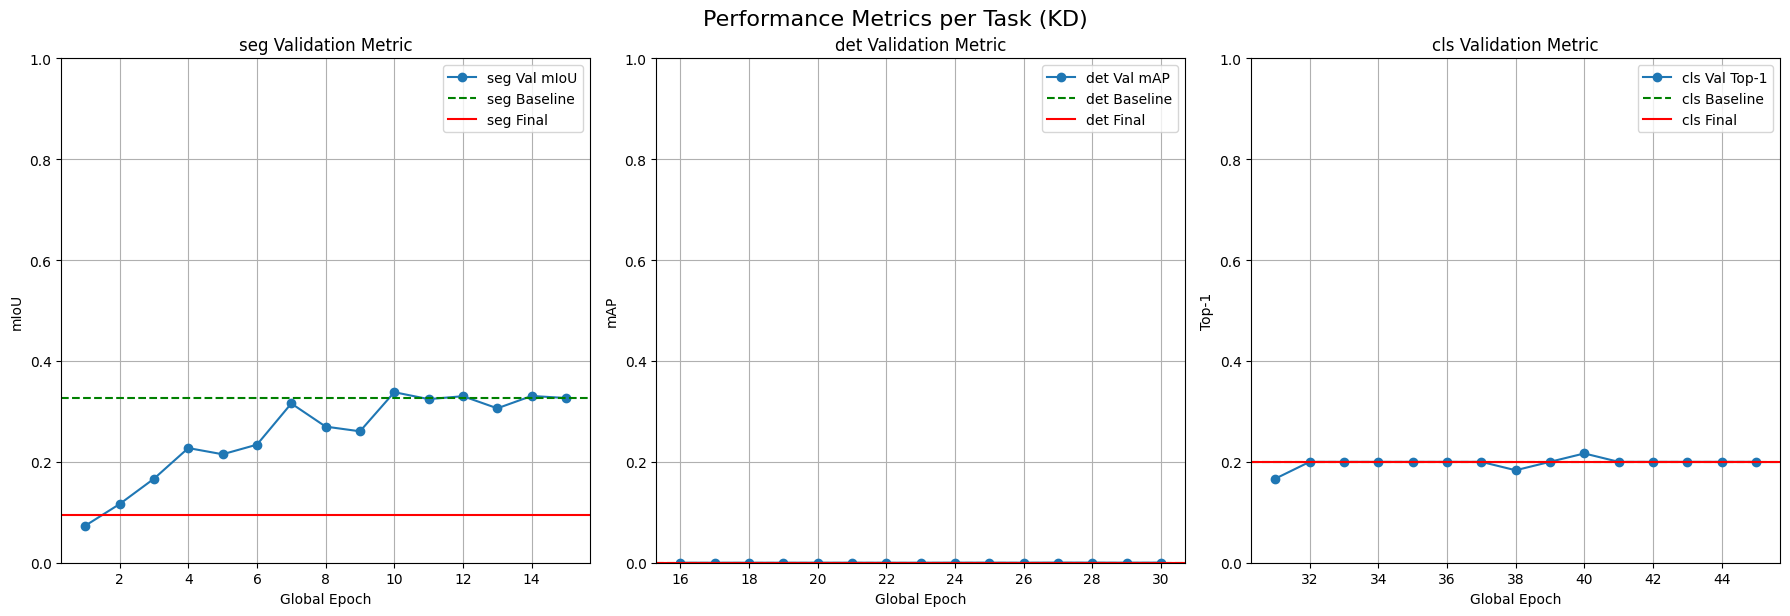



{'='*50}
=== 抗災難性遺忘策略比較 (最終評估與下降) ===
{'='*50}
| Strategy | Seg mIoU | Seg Drop (%) | Det mAP | Det Drop (%) | Cls Top-1 | Cls Drop (%) |
|----------|----------|--------------|---------|--------------|-----------|--------------|
| KD       | 0.0949   | 70.93        | 0.0001  | 66.87        | 0.2000    | 0.00         |


最佳策略（基於最終綜合得分，權重 Seg:0.400, Det:0.400, Cls:0.200）：KD （得分：0.0780）


<ipython-input-5-2767153194>:1164: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_methods) # Get a colormap


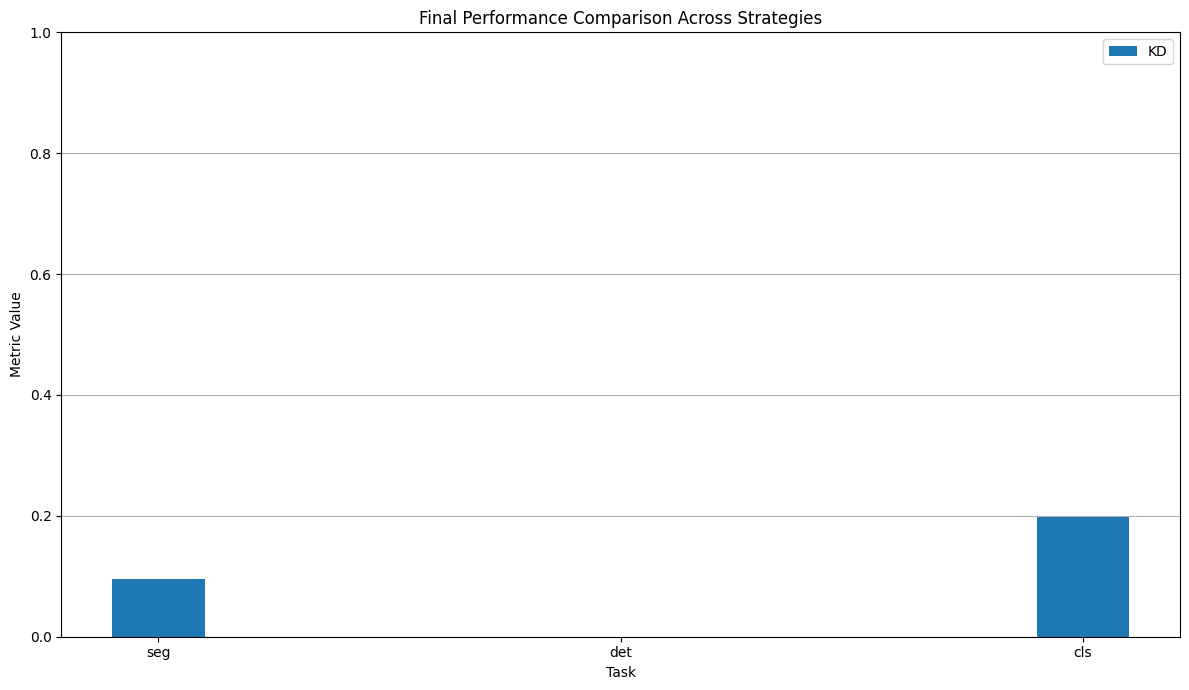



{'='*50}
=== 條件檢查和分數計算 ===
{'='*50}

檢查最佳策略 'KD' 的性能下降:
 - Seg mIoU 下降: 70.93% (<= 5.0%) -> Fail
 - Det mAP 下降: 66.87% (<= 5.0%) -> Fail
 - Cls Top-1 下降: 0.00% (<= 5.0%) -> Pass
所有任務下降是否都在 5.0% 以內: No

最終分數計算（基於 KD 的最終性能）:
 - Seg mIoU 貢獻: 0.0760
 - Det mAP 貢獻: 0.0001
 - Cls Top-1 貢獻: 0.0667
 - 下降控制懲罰: -0.1
總分: 0.0427 / 1.0
是否達到挑戰門檻 (0.7): No

=== 總訓練完成 ===
總耗時: 5424.67 秒


In [ ]:
# @title 統一單頭多任務挑戰實作 (最終增強版)
# 安裝所需庫
# !pip install torch torchvision torchaudio timm segmentation-models-pytorch opencv-python matplotlib scikit-learn -q # Add scikit-learn for metrics
!pip install segmentation-models-pytorch -q # Add scikit-learn for metrics

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
# Import FPN directly from torchvision.ops
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
import timm
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import cv2 as cv # Use OpenCV for image loading
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any, Optional
from collections import OrderedDict # Needed for FPN input
import random
from sklearn.metrics import confusion_matrix # Use sklearn for confusion matrix (for mIoU)
# from COCOeval import COCOeval # Requires installing pycocotools and COCO dataset format - too complex for inline example


# 設定設備
# 使用 torch.cuda.is_available() 檢查 CUDA 是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

# VOC 顏色映射，用於分割任務
VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
]
VOC_COLORMAP_ARRAY = np.array(VOC_COLORMAP, dtype=np.uint8)

# 定義 ReplayBuffer 類
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity  # 緩衝區的最大容量
        self.buffer = []  # 儲存數據的列表

    def add(self, data: Tuple[torch.Tensor, Any]):
        # 將數據添加到緩衝區，如果超過容量則移除最早的數據
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self, batch_size: int) -> List[Tuple[torch.Tensor, Any]]:
        # 從緩衝區隨機採樣指定數量的數據
        batch_size = min(batch_size, len(self.buffer))  # 確保批次大小不超過緩衝區大小
        if batch_size <= 0 or not self.buffer: # Check if buffer is empty
            return [] # Return empty list if no samples to draw
        return random.sample(self.buffer, batch_size)  # 隨機採樣


# 定義多任務數據集類 (使用 OpenCV 讀取圖片)
class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images: List[str] = []
        self.annotations: List[Any] = []
        self.image_sizes: List[Tuple[int, int]] = [] # Store original image sizes (width, height)

        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            try:
                with open(labels_path, 'r') as f:
                    labels_data = json.load(f)
            except json.JSONDecodeError:
                raise ValueError(f"無法解析 {labels_path}。請確認它是有效的 JSON 檔案。")


            image_dir = os.path.join(data_dir, 'data')
            if not os.path.exists(image_dir):
                 raise FileNotFoundError(f"找不到圖片目錄 {image_dir}！")

            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)

            # Build a mapping from image file name to its annotations and original size
            img_info_dict = {img['file_name']: {'id': img['id'], 'width': img['width'], 'height': img['height']} for img in labels_data.get('images', [])}
            ann_dict: Dict[int, List[Dict[str, Any]]] = {}
            for ann in labels_data.get('annotations', []): # Use .get for safety
                img_id = ann.get('image_id') # Use .get for safety
                if img_id is not None:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    # Ensure bbox is a list/tuple of 4 numbers and category_id is valid
                    # COCO bbox format is [x_min, y_min, width, height]
                    if isinstance(ann.get('bbox'), list) and len(ann['bbox']) == 4 and ann.get('category_id') is not None:
                         ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})

            # Collect valid image paths, annotations, and original sizes
            for file_name in image_files:
                 img_info = img_info_dict.get(file_name)
                 if img_info is not None:
                     img_id = img_info['id']
                     if img_id in ann_dict and ann_dict[img_id]: # Ensure there are annotations for this image
                         full_path = os.path.join(image_dir, file_name)
                         self.images.append(full_path)
                         self.annotations.append(ann_dict[img_id])
                         self.image_sizes.append((img_info['width'], img_info['height'])) # Store (width, height)
                 # else: Image exists but no corresponding entry in labels.json or no annotations

        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img_file in image_files:
                img_path = os.path.join(data_dir, img_file)
                # Assuming mask file has same name but .png extension
                mask_path = os.path.join(data_dir, os.path.splitext(img_file)[0] + '.png')
                if os.path.exists(mask_path):
                    # Need to read image once to get size for segmentation, assuming mask has same size
                    try:
                        img = cv.imread(img_path)
                        if img is not None:
                            self.images.append(img_path)
                            self.annotations.append(mask_path)
                            self.image_sizes.append((img.shape[1], img.shape[0])) # Store (width, height)
                        else:
                             print(f"警告: 無法讀取圖片獲取尺寸 {img_path}，跳過。")
                    except Exception as e:
                         print(f"警告: 讀取圖片尺寸時發生錯誤 {img_path}: {e}，跳過。")

        elif task == 'cls':
            if not os.path.exists(data_dir):
                 raise FileNotFoundError(f"找不到分類數據目錄：{data_dir}")
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            if not label_dirs:
                 raise ValueError(f"在 {data_dir} 中未找到任何子目錄作為類別資料夾。")

            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img_file in files:
                        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')): # Check for common image extensions, lower() for case insensitivity
                            img_path = os.path.join(root, img_file)
                            # Read image to get size
                            try:
                                img = cv.imread(img_path)
                                if img is not None:
                                    self.images.append(img_path)
                                    self.annotations.append(label_to_index[label])
                                    self.image_sizes.append((img.shape[1], img.shape[0])) # Store (width, height)
                                else:
                                     print(f"警告: 無法讀取圖片獲取尺寸 {img_path}，跳過。")
                            except Exception as e:
                                 print(f"警告: 讀取圖片尺寸時發生錯誤 {img_path}: {e}，跳過。")


        # Final check for empty dataset
        if len(self.images) == 0:
             raise ValueError(f"在 {data_dir} 中未找到任何有效的數據用於任務 '{self.task}'，請檢查資料結構和檔案副檔名！")
        else:
            print(f"找到 {len(self.images)} 張圖片用於任務 '{self.task}'")


    def convert_mask_rgb_to_indices(self, mask_rgb: np.ndarray) -> np.ndarray:
        """Converts an RGB segmentation mask to a mask of class indices."""
        # Ensure mask_rgb is in RGB format (shape HxWx3)
        if mask_rgb.ndim != 3 or mask_rgb.shape[2] != 3:
             # Convert grayscale to RGB if needed (e.g., L or P mode masks saved as 1 channel)
             if mask_rgb.ndim == 2:
                  # Convert to HxWx1 and then to HxWx3 by repeating
                  mask_rgb = np.repeat(mask_rgb[:, :, np.newaxis], 3, axis=2)
             else:
                raise ValueError("Input mask must be HxW or HxWx3 format")


        height, width = mask_rgb.shape[:2]
        # Initialize index mask with a default value (e.g., 255 for ignore index, or 0 for background)
        # Using 0 assumes background color [0,0,0] maps to class 0.
        mask_indices = np.zeros((height, width), dtype=np.int64)

        # Use a dictionary lookup for faster color to index conversion
        rgb_to_index = {tuple(map(int, color)): i for i, color in enumerate(VOC_COLORMAP_ARRAY)} # Ensure colors are tuples of ints


        # Iterate through flattened pixels and assign index
        mask_flat = mask_rgb.reshape(-1, 3)
        mask_indices_flat = mask_indices.reshape(-1)

        for i in range(mask_flat.shape[0]):
             # Convert pixel color to tuple of ints for dictionary lookup
             pixel_color = tuple(map(int, mask_flat[i]))
             if pixel_color in rgb_to_index:
                  mask_indices_flat[i] = rgb_to_index[pixel_color]
             # Pixels not matching any color in colormap will remain 0 (background)

        return mask_indices


    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Any]:
        img_path = self.images[idx]
        original_width, original_height = self.image_sizes[idx]
        input_size = (512, 512) # Target model input size (width, height)

        # --- Image Loading and Resizing ---
        img = cv.imread(img_path)
        if img is None:
            # Try reading with PIL if OpenCV fails for some formats
            try:
                 img_pil = Image.open(img_path).convert("RGB")
                 img_resized_pil = img_pil.resize(input_size, Image.BILINEAR)
                 img_resized = np.array(img_resized_pil) # Convert PIL image to numpy array
                 # PIL image is already RGB
            except Exception as e:
                 raise ValueError(f"無法讀取或處理圖片：{img_path} - {e}")
        else:
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # Convert BGR to RGB
            # Resize image using OpenCV before converting to Tensor
            img_resized = cv.resize(img, input_size, interpolation=cv.INTER_LINEAR)


        # Convert resized image (numpy HxWx3) to Tensor and normalize [0, 1]
        img_tensor = torch.tensor(img_resized, dtype=torch.float32).permute(2, 0, 1) / 255.0 # Permute from HxWx3 to CxHxW

        # Apply the remaining transforms (normalization)
        if self.transform:
             img_tensor = self.transform(img_tensor)

        # --- Annotation/Target Loading and Processing ---
        if self.task == 'seg':
            mask_path = self.annotations[idx]
            # Use OpenCV to read mask
            mask_rgb = cv.imread(mask_path)
            if mask_rgb is None:
                # Try reading with PIL if OpenCV fails
                try:
                    mask_pil = Image.open(mask_path)
                    # Convert to RGB just in case it's P or L mode
                    mask_rgb_pil = mask_pil.convert("RGB")
                    mask_resized_pil = mask_rgb_pil.resize(input_size, Image.NEAREST) # Resize mask with NEAREST
                    mask_resized = np.array(mask_resized_pil) # Convert PIL image to numpy array
                except Exception as e:
                     raise ValueError(f"無法讀取或處理遮罩：{mask_path} - {e}")
            else:
                mask_rgb = cv.cvtColor(mask_rgb, cv.COLOR_BGR2RGB) # Convert BGR to RGB
                # Resize mask using Nearest Neighbor interpolation to preserve discrete labels
                mask_resized = cv.resize(mask_rgb, input_size, interpolation=cv.INTER_NEAREST)


            # Convert RGB mask to class indices
            mask_indices = self.convert_mask_rgb_to_indices(mask_resized)

            # Convert index mask to LongTensor
            mask_tensor = torch.tensor(mask_indices, dtype=torch.long)

            return img_tensor, mask_tensor

        elif self.task == 'det':
            ann = self.annotations[idx] # ann is a list of dicts: [{'boxes': [x, y, w, h], 'labels': class_id}, ...]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)

            # Scale bounding boxes according to the resize from original image size to 512x512
            # COCO format is [x_min, y_min, width, height]
            scale_x = input_size[0] / original_width
            scale_y = input_size[1] / original_height

            # Apply scaling
            boxes[:, 0] *= scale_x # x_min
            boxes[:, 1] *= scale_y # y_min
            boxes[:, 2] *= scale_x # width
            boxes[:, 3] *= scale_y # height

            # Ensure boxes are within bounds [0, 512]
            # Clamp x_min, y_min to be at least 0
            boxes[:, 0] = torch.clamp(boxes[:, 0], min=0)
            boxes[:, 1] = torch.clamp(boxes[:, 1], min=0)
            # Clamp x_max, y_max to be at most 512
            # boxes[:, 2] is width, boxes[:, 3] is height
            # x_max = x_min + w, y_max = y_min + h
            boxes[:, 2] = torch.clamp(boxes[:, 0] + boxes[:, 2], max=input_size[0]) - boxes[:, 0] # New width
            boxes[:, 3] = torch.clamp(boxes[:, 1] + boxes[:, 3], max=input_size[1]) - boxes[:, 1] # New height

            # Filter out potentially invalid boxes after scaling (e.g., width or height becomes <= 0)
            valid_indices = (boxes[:, 2] > 1e-2) & (boxes[:, 3] > 1e-2) # Use small epsilon instead of 0
            boxes = boxes[valid_indices]
            labels = labels[valid_indices]

            # Return a dictionary of tensors for detection targets
            target_dict = {'boxes': boxes, 'labels': labels, 'original_size': (original_width, original_height), 'resized_size': input_size}
            return img_tensor, target_dict

        elif self.task == 'cls':
            # Annotation is already the class index
            label_tensor = torch.tensor(self.annotations[idx], dtype=torch.long)
            return img_tensor, label_tensor

        else:
             # Should not happen if tasks are 'det', 'seg', 'cls'
             print(f"Warning: Task '{self.task}' not recognized.")
             return img_tensor, None # Return None for target if task is unknown


# Define image pre-processing transform (Normalization only)
# Resizing and ToTensor are handled in __getitem__ using OpenCV and torch.tensor
image_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom collate function for detection (handles list of dicts)
def custom_collate_det(batch: List[Tuple[torch.Tensor, Optional[Dict[str, Any]]]]) -> Tuple[torch.Tensor, List[Dict[str, torch.Tensor]]]:
    # Batch is a list of tuples: [(img1, target1), (img2, target2), ...]
    # where target is a dict {'boxes': ..., 'labels': ...} or None
    # Filter out samples where target is None or not a dict (shouldn't happen with corrected dataset, but defensive)
    batch = [item for item in batch if item[1] is not None and isinstance(item[1], dict)]
    if not batch:
        # Handle empty batch case - return empty tensors/lists with correct types/shapes
        # Assuming image tensor shape is [C, H, W] i.e., [3, 512, 512] after processing in dataset
        dummy_img = torch.empty(3, 512, 512)
        return dummy_img.unsqueeze(0).repeat(0, 1, 1, 1), [] # Return empty tensor with correct shape [0, 3, 512, 512]

    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch] # Keep targets as a list of dicts
    return images, targets

# Custom collate for other tasks (handles tensors) - default_collate works fine
# For seg and cls, the targets are single tensors, default_collate stacks them.

# Create Datasets and DataLoaders
base_dir = "/content/Unified-OneHead-Multi-Task-Challenge/data"
train_datasets = {}
val_datasets = {}

tasks_list = ['seg', 'det', 'cls'] # Define the tasks order for dataset loading

for task in tasks_list:
    try:
        # Adjust paths based on task name convention in your data directory
        if task == 'det':
             task_data_dir = "mini_coco_det"
        elif task == 'seg':
             task_data_dir = "mini_voc_seg"
        elif task == 'cls':
             task_data_dir = "imagenette_160"
        else:
             raise ValueError(f"Unknown task: {task}")

        train_path = os.path.join(base_dir, task_data_dir, 'train')
        val_path = os.path.join(base_dir, task_data_dir, 'val')

        train_datasets[task] = MultiTaskDataset(train_path, task, image_transform)
        val_datasets[task] = MultiTaskDataset(val_path, task, image_transform)

    except ValueError as e:
        print(f"資料載入失敗 ({task} 任務): {e}")
        # Store empty datasets if loading failed, so loaders will be empty
        train_datasets[task] = []
        val_datasets[task] = []


# Create DataLoaders
# Use robust error handling for empty datasets/loaders
train_loaders = {}
val_loaders = {}

for task in tasks_list:
    if task in train_datasets and train_datasets[task] and len(train_datasets[task]) > 0:
        collate_fn = custom_collate_det if task == 'det' else None
        train_loaders[task] = DataLoader(train_datasets[task], batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
    else:
         print(f"警告: 任務 '{task}' 的訓練數據集為空或無效。將跳過此任務的訓練。")
         train_loaders[task] = [] # Use an empty list to indicate no loader

    if task in val_datasets and val_datasets[task] and len(val_datasets[task]) > 0:
        collate_fn = custom_collate_det if task == 'det' else None
        val_loaders[task] = DataLoader(val_datasets[task], batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn)
    else:
         print(f"警告: 任務 '{task}' 的驗證數據集為空或無效。將跳過此任務的驗證。")
         val_loaders[task] = [] # Use an empty list


# Model Definition
class MultiTaskModel(nn.Module):
    def __init__(self, C_det=10, C_seg=21, C_cls=10):
        super(MultiTaskModel, self).__init__()
        # Use EfficientNet-B0 as the backbone returning multiple features
        # Set norm_layer to make BatchNorm trainable if needed
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, features_only=True, norm_layer=nn.BatchNorm2d)

        # Get channel counts for the specific layers used in FPN
        # Use feat2, feat3, feat4 (indices 2, 3, 4) for strides 8, 16, 32
        feature_info = self.backbone.feature_info
        # Check if feature_info has enough layers
        if len(feature_info.channels()) < 5: # We need at least feat0 to feat4
             raise ValueError("Backbone does not return enough feature layers for FPN (expected at least 5).")

        in_channels_list = [feature_info.channels()[i] for i in [2, 3, 4]] # Channels for feat2, feat3, feat4: [40, 112, 320]
        fpn_out_channels = 128 # FPN output channel size

        # Neck: FPN
        # Provide names for FPN input layers corresponding to the selected features
        # Use keys '0', '1', '2' for FPN input based on increasing stride
        fpn_in_keys = ['0', '1', '2'] # Keys for FPN input dict corresponding to features[2], features[3], features[4]
        self.fpn = FeaturePyramidNetwork(
            in_channels_list,
            out_channels=fpn_out_channels,
            extra_blocks=LastLevelMaxPool(), # Add a P5 layer keyed as 'pool' by default
            # FPN output keys will be the same as input keys plus 'pool' if extra_blocks is used
        )
        # The FPN output will be an OrderedDict with keys like {'0': P2, '1': P3, '2': P4, 'pool': P5}

        # Shared Feature Processing after FPN
        # Let's use the P4 level output from FPN (key '2', stride 32) for shared processing.
        # P4 spatial resolution for 512x512 input is 512/32 = 16x16.
        # P4 output channels are fpn_out_channels (128).
        self.shared_conv = nn.Sequential(
             # Input from FPN P4 (key '2')
             nn.Conv2d(fpn_out_channels, 64, kernel_size=3, padding=1),
             nn.ReLU(inplace=True)
        )
        shared_features_channels = 64

        # Task-Specific Heads
        # Detection head operates on spatial feature maps (output from shared_conv)
        # Predict (cx, cy, w, h, conf, class_id) per grid cell (16x16 grid)
        # Note: C_det here refers to the number of object classes, the output is 6 values per grid cell.
        # The 6th value could be class index or a one-hot encoding if you have multiple classes per grid.
        # Given C_det classes, the output should maybe be 4 (box) + 1 (conf) + C_det (class scores)
        # Let's follow the original (cx, cy, w, h, conf, class_id) structure which implies 6 channels.
        # This 6-channel output format is unusual for multi-class detection per grid cell.
        # A common approach is 4+1+num_classes or similar.
        # Stick to 6 channels as per original head definition. The last channel is likely intended as the class ID.
        self.det_head = nn.Conv2d(shared_features_channels, 6, kernel_size=1) # Output 6 channels per grid cell

        # Segmentation head needs high resolution output (512x512, C_seg channels)
        # Upsample from the shared features (16x16, 64 channels).
        self.seg_head = nn.Sequential(
            nn.Conv2d(shared_features_channels, C_seg, kernel_size=1), # Output C_seg channels per spatial location
            # Use interpolation mode 'nearest-exact' or 'bilinear' + align_corners=False for recent PyTorch versions
            # 'bilinear' is better for continuous features, 'nearest'/'nearest-exact' for discrete masks.
            # FPN output is features, so 'bilinear' is appropriate here before the final Conv1d to class scores.
            # The output of seg_head conv1d is raw scores, upsampling that with bilinear is fine.
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False) # Upsample to input resolution
        )

        # Classification head operates on a global feature vector.
        # Apply Global Average Pooling and Linear layers to the shared features.
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # Pool over 16x16 spatial size to get 1x1
            nn.Flatten(),            # Flatten 1x1x64 to 64
            nn.Linear(shared_features_channels, C_cls) # Input channels = 64, Output channels = 10
        )


    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Get feature layers from backbone
        features = self.backbone(x) # List: [feat0..feat4]

        # Select features for FPN input (strides 8, 16, 32)
        selected_features = OrderedDict()
        if len(features) < 5:
             raise RuntimeError(f"Backbone features list has unexpected length {len(features)}. Expected at least 5.")

        selected_features['0'] = features[2] # stride 8
        selected_features['1'] = features[3] # stride 16
        selected_features['2'] = features[4] # stride 32

        # Pass selected features to FPN
        fpn_outputs = self.fpn(selected_features) # OrderedDict: {'0': P2, '1': P3, '2': P4, 'pool': P5}

        # Select FPN level (P4, key '2') for shared head input
        fpn_level_key_for_head = '2'
        if fpn_level_key_for_head not in fpn_outputs:
             raise RuntimeError(f"FPN output does not contain expected key '{fpn_level_key_for_head}'. Available keys: {fpn_outputs.keys()}")

        shared_features_input = fpn_outputs[fpn_level_key_for_head] # P4 level, shape [batch, 128, 16, 16]

        # Pass through shared convolutional layers
        shared_features = self.shared_conv(shared_features_input) # Output: [batch, 64, 16, 16]

        # Pass to task-specific heads
        det_out = self.det_head(shared_features) # Output: [batch, 6, 16, 16]
        seg_out = self.seg_head(shared_features) # Output: [batch, C_seg, 512, 512]
        cls_out = self.cls_head(shared_features) # Output: [batch, C_cls]

        return det_out, seg_out, cls_out


# Initialize Model
# C_det_actual = 10 # Mini-COCO-Det categories 1-10
# C_seg_actual = 21 # VOC classes 0-20 (including background)
# C_cls_actual = 10 # Imagenette classes

# Ensure these constants are defined globally or passed appropriately
# For a standalone block, let's define them again if they weren't in the previous one
C_det_actual = 10
C_seg_actual = 21
C_cls_actual = 10

model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)

# Count parameters
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total parameters: {total_params:,} (< 8M: {total_params < 8_000_000})")


# --- Loss Functions ---
# Simplified detection loss (MSE on first box coords)
def compute_detection_loss(det_output: torch.Tensor, targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
    boxes_pred = det_output.permute(0, 2, 3, 1)  # [batch_size, H, W, 6] H=W=16
    loss = torch.tensor(0., device=det_output.device)
    valid_samples = 0
    for i in range(len(targets)):
        if not isinstance(targets[i], dict) or 'boxes' not in targets[i] or len(targets[i]['boxes']) == 0:
            continue # Skip samples with no targets

        target_boxes = targets[i]['boxes'].to(det_output.device) # [num_boxes, 4] (x, y, w, h format)

        if boxes_pred.size(1) > 0 and boxes_pred.size(2) > 0:
            pred_cxcywh = boxes_pred[i, 0, 0, :4] # Predicted [cx, cy, w, h] from grid cell (0,0)

            # Convert target [x, y, w, h] to [cx, cy, w, h] for MSE
            target_cxcywh = torch.stack([
                target_boxes[0][0] + target_boxes[0][2] / 2,
                target_boxes[0][1] + target_boxes[0][3] / 2,
                target_boxes[0][2],
                target_boxes[0][3]
            ])

            loss += nn.MSELoss()(pred_cxcywh, target_cxcywh)
            valid_samples += 1

    return loss / valid_samples if valid_samples > 0 else torch.tensor(0., device=det_output.device)

# Segmentation loss (CrossEntropyLoss)
def compute_segmentation_loss(seg_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    criterion = nn.CrossEntropyLoss()
    if targets.size()[-2:] != seg_output.size()[-2:]:
         print(f"Error: Seg target size {targets.size()} does not match output size {seg_output.size()} in loss calculation.")
         return torch.tensor(0., device=seg_output.device)
    return criterion(seg_output, targets)

# Classification loss (CrossEntropyLoss)
def compute_classification_loss(cls_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    criterion = nn.CrossEntropyLoss()
    return criterion(cls_output, targets)


# --- Evaluation Functions ---
# Helper for IoU (numpy version)
def calculate_iou_np(box1: np.ndarray, box2: np.ndarray) -> float:
    x1_min, y1_min, w1, h1 = box1
    x1_max, y1_max = x1_min + w1, y1_min + h1
    x2_min, y2_min, w2, h2 = box2
    x2_max, y2_max = x2_min + w2, y2_min + h2

    x_left = max(x1_min, x2_min)
    y_top = max(y1_min, y2_min)
    x_right = min(x1_max, x2_max)
    y_bottom = min(y1_max, y2_max)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - intersection_area

    return intersection_area / union_area if union_area > 0 else 0.0

# Segmentation evaluation (mIoU)
def evaluate_segmentation(model: nn.Module, loader: DataLoader, num_classes: int = 21) -> Dict[str, float]:
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'mIoU': 0.0, 'loss': 0.0}

    model.eval()
    confusion_matrix_np = np.zeros((num_classes, num_classes), dtype=np.int64)
    total_loss = 0
    num_batches = 0
    criterion = nn.CrossEntropyLoss(reduction='sum') # Use sum reduction for calculating average loss

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            _, seg_out, _ = model(inputs) # seg_out: [batch, C_seg, 512, 512]

            # Calculate loss
            loss = criterion(seg_out, targets)
            total_loss += loss.item()
            num_batches += 1

            # Get predicted class for mIoU
            predicted_masks = torch.argmax(seg_out, dim=1) # [batch, 512, 512]

            if predicted_masks.size() != targets.size():
                 print(f"Warning: Evaluate Seg target size {targets.size()} != predicted size {predicted_masks.size()}. Skipping mIoU for batch.")
                 continue

            predicted_flat = predicted_masks.view(-1).cpu().numpy()
            targets_flat = targets.view(-1).cpu().numpy()

            # Update confusion matrix
            try:
                cm_batch = confusion_matrix(targets_flat, predicted_flat, labels=np.arange(num_classes))
                confusion_matrix_np += cm_batch
            except ValueError as e:
                 print(f"Warning: Error calculating confusion matrix for batch: {e}")


    # Calculate mIoU
    true_positives = np.diag(confusion_matrix_np)
    false_positives = np.sum(confusion_matrix_np, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix_np, axis=1) - true_positives
    union = true_positives + false_positives + false_negatives
    iou_per_class = np.divide(true_positives.astype(np.float64), union.astype(np.float64), out=np.full(num_classes, np.nan), where=union != 0)
    valid_iou = iou_per_class[~np.isnan(iou_per_class)]
    mIoU = np.mean(valid_iou) if valid_iou.size > 0 else 0.0

    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0

    return {'mIoU': mIoU, 'loss': avg_loss}


# Detection evaluation (Simplified mAP placeholder)
def evaluate_detection(model: nn.Module, loader: DataLoader, iou_threshold: float = 0.5) -> Dict[str, float]:
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'mAP': 0.0, 'loss': 0.0}

    # print("Note: Detection evaluation (mAP) is a simplified placeholder.")

    model.eval()
    total_matched_predictions = 0
    total_predictions_with_target = 0
    total_loss = 0
    num_batches = 0
    criterion = compute_detection_loss # Use the same simplified loss for evaluation

    with torch.no_grad():
        for inputs, targets in loader:
            if inputs.size(0) == 0: continue
            inputs = inputs.to(device)

            det_out, _, _ = model(inputs) # det_out: [batch, 6, 16, 16]

            # Calculate loss
            loss = criterion(det_out, targets) # targets is list of dicts, handled by criterion
            total_loss += loss.item() if isinstance(loss, torch.Tensor) else loss # Handle scalar or tensor loss
            num_batches += 1

            # --- Simplified Matching for Placeholder mAP ---
            boxes_pred = det_out.permute(0, 2, 3, 1)  # [batch_size, 16, 16, 6]

            for i in range(inputs.size(0)): # Process each image in batch
                 img_predictions = boxes_pred[i].view(-1, 6) # [256, 6]
                 conf_scores = img_predictions[:, 4]
                 conf_threshold = 0.2 # Example confidence threshold
                 confident_predictions = img_predictions[conf_scores > conf_threshold] # [N_pred, 6]

                 if confident_predictions.size(0) == 0:
                      continue

                 predicted_boxes_cxcywh = confident_predictions[:, :4]
                 predicted_boxes_xywh = torch.stack([ # Convert to [x_min, y_min, w, h]
                     predicted_boxes_cxcywh[:, 0] - predicted_boxes_cxcywh[:, 2] / 2,
                     predicted_boxes_cxcywh[:, 1] - predicted_boxes_cxcywh[:, 3] / 2,
                     predicted_boxes_cxcywh[:, 2],
                     predicted_boxes_cxcywh[:, 3]
                 ], dim=1) # [N_pred, 4]

                 # Get ground truth boxes (already scaled in dataset)
                 if not isinstance(targets[i], dict) or 'boxes' not in targets[i] or len(targets[i]['boxes']) == 0:
                      total_predictions_with_target += confident_predictions.size(0)
                      continue

                 ground_truth_boxes_xywh = targets[i]['boxes'].to(device) # [N_gt, 4] (x, y, w, h)

                 matched_preds_in_image = 0
                 total_predictions_with_target += confident_predictions.size(0)

                 if ground_truth_boxes_xywh.size(0) > 0:
                      # Compute IoUs between all predicted boxes and all GT boxes
                      for pred_box_xywh in predicted_boxes_xywh:
                           ious = [calculate_iou_np(pred_box_xywh.cpu().numpy(), gt_box_xywh.cpu().numpy()) for gt_box_xywh in ground_truth_boxes_xywh]
                           if any(iou > iou_threshold for iou in ious):
                                matched_preds_in_image += 1

                 total_matched_predictions += matched_preds_in_image


    simplified_ap = total_matched_predictions / total_predictions_with_target if total_predictions_with_target > 0 else 0.0
    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0

    return {'mAP': simplified_ap, 'loss': avg_loss}


# Classification evaluation (Top-1 and Top-5 Accuracy)
def evaluate_classification(model: nn.Module, loader: DataLoader) -> Dict[str, float]:
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         return {'Top-1': 0.0, 'Top-5': 0.0, 'loss': 0.0}

    model.eval()
    total_samples = 0
    top1_correct = 0
    top5_correct_sum = 0 if C_cls_actual >= 5 else -1 # Use sum for correctness count
    total_loss = 0
    num_batches = 0
    criterion = nn.CrossEntropyLoss(reduction='sum') # Use sum reduction for average loss

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            _, _, cls_out = model(inputs) # cls_out: [batch, C_cls]

            # Calculate loss
            loss = criterion(cls_out, targets)
            total_loss += loss.item()
            num_batches += 1

            # Top-1 Accuracy
            _, predicted = cls_out.max(1)
            total_samples += targets.size(0)
            top1_correct += (predicted == targets).sum().item()

            # Top-5 Accuracy (if C_cls >= 5)
            if C_cls_actual >= 5:
                _, top5_preds = cls_out.topk(5, dim=1, largest=True, sorted=True) # [batch, 5]
                targets_expanded = targets.view(-1, 1) # [batch_size, 1]
                top5_correct_sum += (targets_expanded == top5_preds).any(dim=1).sum().item()

    metrics = {}
    metrics['Top-1'] = top1_correct / total_samples if total_samples > 0 else 0.0
    if C_cls_actual >= 5:
        metrics['Top-5'] = top5_correct_sum / total_samples if total_samples > 0 else 0.0
    else:
         metrics['Top-5'] = float('nan') # Indicate not applicable

    metrics['loss'] = total_loss / num_batches if num_batches > 0 else 0.0

    return metrics


# --- 抗災難性遺忘策略實現 (ReplayBuffer, EWC, LwF, KD 已在前面或上面定義) ---

# Knowledge Distillation Loss (Typically applied to classification head)
def knowledge_distillation_loss(student_cls_output: torch.Tensor, old_model_cls_output: torch.Tensor,
                                temperature: float = 4.0, lambda_kd: float = 1.0) -> torch.Tensor:
    """Calculates Knowledge Distillation loss for classification (comparing soft logits)."""
    soft_student_cls = torch.log_softmax(student_cls_output / temperature, dim=1)
    soft_old_model_cls = torch.softmax(old_model_cls_output.detach() / temperature, dim=1)
    kl_criterion = nn.KLDivLoss(reduction='batchmean')
    loss = kl_criterion(soft_student_cls, soft_old_model_cls) * (temperature ** 2)
    return lambda_kd * loss


# Replay Buffer (Class already defined)


# --- Training Stage Function ---

def get_loss_function(task: str):
    """Helper to get the appropriate loss function for a task."""
    if task == 'det':
        return compute_detection_loss
    elif task == 'seg':
        return compute_segmentation_loss
    elif task == 'cls':
        return compute_classification_loss
    else:
        raise ValueError(f"Unknown task: {task}")

def get_eval_function(task: str):
    """Helper to get the appropriate evaluation function for a task."""
    if task == 'det':
        return evaluate_detection # Returns {'mAP': value, 'loss': value}
    elif task == 'seg':
        return evaluate_segmentation # Returns {'mIoU': value, 'loss': value}
    elif task == 'cls':
        return evaluate_classification # Returns {'Top-1': value, 'Top-5': value, 'loss': value}
    else:
        raise ValueError(f"Unknown task: {task}")


def evaluate_model(model: nn.Module, loader: DataLoader, task: str) -> Dict[str, float]:
    """Helper function to perform evaluation and return metrics including loss."""
    if not loader or len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
         print(f"警告: 任務 '{task}' 的驗證載入器為空或無效，跳過評估。")
         # Return default metrics with 0.0 loss
         if task == 'seg': return {'mIoU': 0.0, 'loss': 0.0}
         elif task == 'det': return {'mAP': 0.0, 'loss': 0.0}
         elif task == 'cls': return {'Top-1': 0.0, 'Top-5': 0.0, 'loss': 0.0}
         else: return {'loss': 0.0}

    eval_fn = get_eval_function(task)
    metrics = eval_fn(model, loader)
    return metrics


def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int,
                optimizer: optim.Optimizer, scheduler: optim.lr_scheduler._LRScheduler,
                replay_buffers: Dict[str, ReplayBuffer], tasks_order: List[str], stage: int,
                mitigation_methods: List[str],
                lwf_teacher_model: Optional[nn.Module] = None
               ) -> Tuple[List[Dict[str, float]], List[Dict[str, float]], Dict[str, float]]:
    print(f"\n{'--'*20}\n開始訓練任務：{task}, 階段：{stage + 1}/{len(tasks_order)}, Epochs：{epochs}\n{'--'*20}")

    train_metrics_history: List[Dict[str, float]] = []
    val_metrics_history: List[Dict[str, float]] = []

    current_task_loss_fn = get_loss_function(task)
    current_task_eval_fn = get_eval_function(task)

    for epoch in range(epochs):
        model.train()
        epoch_start_time = time.time()
        total_train_loss = 0
        num_train_batches = 0

        if train_loader and len(train_loader) > 0:
            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                if task != 'det' and isinstance(targets, torch.Tensor):
                    targets = targets.to(device)

                optimizer.zero_grad()
                student_det, student_seg, student_cls = model(inputs)
                student_outputs = (student_det, student_seg, student_cls)

                if task == 'det':
                    task_loss = current_task_loss_fn(student_det, targets)
                elif task == 'seg':
                    task_loss = current_task_loss_fn(student_seg, targets)
                elif task == 'cls':
                    task_loss = current_task_loss_fn(student_cls, targets)
                else:
                    task_loss = torch.tensor(0., device=device)

                total_loss = task_loss

                method_losses_dict = {}

                if 'KD' in mitigation_methods and stage > 0 and lwf_teacher_model:
                    lwf_teacher_model.eval()
                    with torch.no_grad():
                        teacher_det, teacher_seg, teacher_cls = lwf_teacher_model(inputs)
                        teacher_outputs = (teacher_det, teacher_seg, teacher_cls)

                    kd_loss_total = torch.tensor(0., device=device)
                    temperature = 4.0
                    lambda_kd = 1.0

                    if student_det.shape == teacher_det.shape:
                        kd_loss_det = knowledge_distillation_loss(student_det, teacher_det, temperature, lambda_kd)
                        kd_loss_total += kd_loss_det

                    if student_seg.shape == teacher_seg.shape:
                        kd_loss_seg = knowledge_distillation_loss(student_seg, teacher_seg, temperature, lambda_kd)
                        kd_loss_total += kd_loss_seg

                    if student_cls.shape == teacher_cls.shape:
                        kd_loss_cls = knowledge_distillation_loss(student_cls, teacher_cls, temperature, lambda_kd)
                        kd_loss_total += kd_loss_cls

                    total_loss += kd_loss_total
                    method_losses_dict['KD'] = kd_loss_total.item()

                if isinstance(total_loss, torch.Tensor) and total_loss.requires_grad:
                    total_loss.backward()
                    optimizer.step()
                elif isinstance(total_loss, torch.Tensor):
                    pass
                else:
                    print(f"Warning: total_loss is not a tensor ({type(total_loss)}). Skipping backward pass.")

                total_train_loss += total_loss.item()
                num_train_batches += 1

                detached_inputs = inputs.detach().cpu()
                if task == 'det':
                    detached_targets = copy.deepcopy(targets)
                elif isinstance(targets, torch.Tensor):
                    detached_targets = targets.detach().cpu()
                else:
                    detached_targets = targets

                replay_buffers[task].add((detached_inputs, detached_targets))

            avg_train_loss = total_train_loss / num_train_batches if num_train_batches > 0 else 0.0

            model.eval()
            train_metrics_for_epoch = evaluate_model(model, train_loader, task)
            model.train()

            train_metrics_for_epoch['loss'] = avg_train_loss
            train_metrics_history.append(train_metrics_for_epoch)

            metric_info = f"Epoch {epoch + 1}/{epochs}, Task {task} | Train Loss: {avg_train_loss:.4f}"
            if task == 'seg':
                metric_info += f" | Train mIoU: {train_metrics_for_epoch.get('mIoU', 0.0):.4f}"
            elif task == 'det':
                metric_info += f" | Train mAP: {train_metrics_for_epoch.get('mAP', 0.0):.4f}"
            elif task == 'cls':
                metric_info += f" | Train Top-1: {train_metrics_for_epoch.get('Top-1', 0.0):.4f}"

            if method_losses_dict:
                avg_method_losses = {k: v / num_train_batches for k, v in method_losses_dict.items()}
                loss_breakdown_str = ", ".join([f"{k}: {v:.4f}" for k, v in avg_method_losses.items()])
                metric_info += f" (Mitigation: {loss_breakdown_str})"

            print(metric_info)
        else:
            print(f"Epoch {epoch + 1}/{epochs}, Task {task}: 訓練載入器為空，無訓練進行。")
            train_metrics_history.append({task: 0.0, 'loss': 0.0})

        current_val_loader = val_loaders.get(task)
        val_metrics_for_epoch = evaluate_model(model, current_val_loader, task)
        val_metrics_history.append(val_metrics_for_epoch)

        metric_output_str = f"評估結果 - Epoch {epoch+1}/{epochs}, Task {task}:"
        if task == 'seg':
            metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val mIoU={val_metrics_for_epoch.get('mIoU', 0.0):.4f}"
        elif task == 'det':
            metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val mAP={val_metrics_for_epoch.get('mAP', 0.0):.4f}"
        elif task == 'cls':
            top1_str = f"Top-1={val_metrics_for_epoch.get('Top-1', 0.0):.4f}"
            top5_str = f"Top-5={val_metrics_for_epoch.get('Top-5', float('nan')):.4f}" if 'Top-5' in val_metrics_for_epoch and not np.isnan(val_metrics_for_epoch['Top-5']) else "Top-5: N/A"
            metric_output_str += f" Val Loss={val_metrics_for_epoch.get('loss', 0.0):.4f}, Val {top1_str}, {top5_str}"
        print(metric_output_str)

        scheduler.step()

    end_stage_time = time.time()
    print(f"\n任務 '{task}' 階段訓練完成，總耗時 {end_stage_time - epoch_start_time:.2f} 秒.")

    final_metrics_of_stage = val_metrics_history[-1] if val_metrics_history else {}

    return train_metrics_history, val_metrics_history, final_metrics_of_stage


# --- Main Training Loop ---
# Define mitigation strategies to test
mitigation_methods = ['KD']  # 只使用 Knowledge Distillation

# Use a fixed number of epochs for each task
EPOCHS_PER_TASK = 15 # Use 15 epochs as in your example log

# Define the order of tasks
tasks_order = ['seg', 'det', 'cls'] # Segmentation -> Detection -> Classification

# Store results for comparison
# Structure: {method: {task: {'final_metrics_after_all_stages': {...}, 'train_metrics_history_per_epoch': [{epoch_metrics}, ...], 'val_metrics_history_per_epoch': [{epoch_metrics}, ...], 'baseline_metric': value}, ...}}
method_results: Dict[str, Dict[str, Dict[str, Any]]] = {
    method: {task: {'final_metrics_after_all_stages': {}, 'train_metrics_history_per_epoch': [], 'val_metrics_history_per_epoch': [], 'baseline_metric': None} for task in tasks_order}
    for method in mitigation_methods
}

# Keep track of the best model state_dict based on composite score
best_composite_score = -float('inf')
best_strategy_name_overall: Optional[str] = None
best_model_state_dict_overall: Optional[Dict[str, torch.Tensor]] = None
composite_weights = {'seg': 0.4, 'det': 0.4, 'cls': 0.2} # Weights for composite score


# Start overall time tracking
start_overall_time = time.time()

# Iterate through each mitigation method
for method in mitigation_methods:
    print(f"\n\n{'='*50}\n=== 使用抗災難性遺忘策略：{method} ===\n{'='*50}")

    # Re-initialize model and optimizer for each strategy to ensure a fair comparison
    model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.0008, weight_decay=1e-4)
    total_strategy_epochs = len(tasks_order) * EPOCHS_PER_TASK
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_strategy_epochs)

    # Replay buffers need to be reset for each strategy run
    replay_buffers = {task: ReplayBuffer(capacity=50) for task in tasks_order}

    # Variables for KD
    lwf_teacher_model: Optional[nn.Module] = None # Teacher model for KD


    # Train sequentially on each task
    for stage, task in enumerate(tasks_order):
        # Before training the current task (stage > 0), create teacher model for KD.
        if ('KD' in mitigation_methods) and stage > 0:
            print(f"創建階段 {stage} 的教師模型用於 KD...")
            lwf_teacher_model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)
            lwf_teacher_model.load_state_dict(model.state_dict()) # Load the state after previous stage
            lwf_teacher_model.eval()

        # Get the loader for the current task. Skip if loader is empty.
        current_train_loader = train_loaders.get(task)
        current_val_loader = val_loaders.get(task)

        # Check if current task loaders are valid
        if not current_train_loader or len(current_train_loader) == 0:
            print(f"跳過任務 '{task}' 的訓練，因為訓練載入器為空或無效。")
            # Store empty/placeholder results
            method_results[method][task]['final_metrics_after_all_stages'] = {f'{task}_metric': 0.0}
            method_results[method][task]['train_metrics_history_per_epoch'] = []
            method_results[method][task]['val_metrics_history_per_epoch'] = []
            method_results[method][task]['baseline_metric'] = 0.0 # Baseline is 0 if no training
            continue # Skip to the next task/stage


        # Perform the training for the current task
        train_metrics_history, val_metrics_history, final_metrics_of_stage = train_stage(
            model, # This model will be updated during training
            current_train_loader,
            current_val_loader, # Pass validation loader for periodic evaluation
            task,
            epochs=EPOCHS_PER_TASK,
            optimizer=optimizer,
            scheduler=scheduler,
            replay_buffers=replay_buffers, # Pass replay buffers for all tasks
            tasks_order=tasks_order, # Pass the list of all tasks for replay sampling
            stage=stage,       # Pass the current stage index (0, 1, 2...)
            mitigation_methods=[method], # Apply current method
            lwf_teacher_model=lwf_teacher_model # Pass teacher model for KD
        )

        # --- Record Baseline Metric ---
        # The baseline metric for a task is its performance right after it was trained.
        # final_metrics_of_stage contains the validation metrics after the last epoch of this stage.
        # We need to get the specific metric value (mIoU, mAP, Top-1) based on the task.
        if task == 'seg':
             baseline_key = 'mIoU'
        elif task == 'det':
             baseline_key = 'mAP'
        elif task == 'cls':
             baseline_key = 'Top-1'
        else:
             baseline_key = 'unknown_metric'

        baseline_value = final_metrics_of_stage.get(baseline_key, 0.0) # Get the specific metric value

        method_results[method][task]['baseline_metric'] = baseline_value
        method_results[method][task]['train_metrics_history_per_epoch'] = train_metrics_history # Store history
        method_results[method][task]['val_metrics_history_per_epoch'] = val_metrics_history # Store history

        # Delete teacher model to save memory if not needed for the next stage
        if lwf_teacher_model is not None:
             del lwf_teacher_model
             torch.cuda.empty_cache() # Clear CUDA cache


    # --- End of sequential training for one strategy ---

    # --- Final Evaluation after all stages for this strategy ---
    print(f"\n\n{'='*50}\n=== {method} 的最終評估 (在所有任務訓練後) ===\n{'='*50}")
    final_metrics_after_all_stages_for_method: Dict[str, Dict[str, float]] = {}

    for task in tasks_order:
        current_val_loader = val_loaders.get(task)
        # Call the evaluation helper function
        metrics = evaluate_model(model, current_val_loader, task)

        # Print final metrics
        metric_output_str = f"最終 {task} 評估:"
        if task == 'seg':
             metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, mIoU={metrics.get('mIoU', 0.0):.4f}"
        elif task == 'det':
             metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, mAP={metrics.get('mAP', 0.0):.4f}"
        elif task == 'cls':
             top1_str = f"Top-1={metrics.get('Top-1', 0.0):.4f}"
             top5_str = f"Top-5={metrics.get('Top-5', float('nan')):.4f}" if 'Top-5' in metrics and not np.isnan(metrics['Top-5']) else "Top-5: N/A"
             metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, {top1_str}, {top5_str}"
        print(metric_output_str)

        # Store the final metrics for this task and method
        final_metrics_after_all_stages_for_method[task] = metrics
        method_results[method][task]['final_metrics_after_all_stages'] = metrics


    # --- 繪製性能趨勢圖 ---
    try:
        def plot_performance_trends(method_results_entry: Dict[str, Dict[str, Any]], method_name: str, epochs_per_stage: int, tasks_order: List[str]):
            plt.figure(figsize=(18, 6))

            for i, task in enumerate(tasks_order, 1):
                task_data = method_results_entry.get(task)
                if not task_data:
                     continue

                val_history = task_data.get('val_metrics_history_per_epoch', [])
                if not val_history:
                    continue

                plt.subplot(1, len(tasks_order), i)

                # Define the primary metric key
                metric_key = 'mIoU' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1'
                metric_label = metric_key

                # Extract metric values and calculate global epoch numbers
                metric_values = [m.get(metric_key, 0.0) for m in val_history]

                # Global epoch numbers for plotting
                # For task 'seg' (stage 0), epochs 1-6
                # For task 'det' (stage 1), epochs 7-12
                # For task 'cls' (stage 2), epochs 13-18
                start_global_epoch = tasks_order.index(task) * epochs_per_stage + 1
                global_epochs = list(range(start_global_epoch, start_global_epoch + len(metric_values)))


                if global_epochs:
                    plt.plot(global_epochs, metric_values, marker='o', linestyle='-', label=f'{task} Val {metric_label}')

                # Add horizontal line for baseline (performance after its own stage)
                baseline_value = task_data.get('baseline_metric', None)
                if baseline_value is not None:
                    plt.axhline(y=baseline_value, color='g', linestyle='--', label=f'{task} Baseline')

                # Add horizontal line for final performance (after all stages)
                final_metric_value = task_data.get('final_metrics_after_all_stages', {}).get(metric_key, None)
                if final_metric_value is not None:
                     plt.axhline(y=final_metric_value, color='r', linestyle='-', label=f'{task} Final')


                plt.title(f'{task} Validation Metric')
                plt.xlabel('Global Epoch')
                plt.ylabel(metric_label)
                plt.legend()
                plt.grid(True)
                plt.ylim(0, 1.0) # Assuming metrics are between 0 and 1

            plt.tight_layout()
            plt.suptitle(f'Performance Metrics per Task ({method_name})', y=1.02, fontsize=16)
            plt.show()

        # Call the plot function for the current method
        plot_performance_trends(method_results[method], method, EPOCHS_PER_TASK, tasks_order)

    except ImportError:
        print("Matplotlib 未安裝，跳過繪圖。")


# --- 繪製最終性能比較條形圖 ---
    try:
        def plot_final_comparison(method_results: Dict[str, Dict[str, Dict[str, Any]]], metric_keys: Dict[str, str], tasks_order: List[str]):
            plt.figure(figsize=(12, 7))

            num_methods = len(mitigation_methods)
            bar_width = 0.2
            index = np.arange(len(tasks_order)) # X-axis positions for groups of bars

            colors = plt.cm.get_cmap('tab10', num_methods) # Get a colormap

            for i, method in enumerate(mitigation_methods):
                final_metrics = method_results[method]['seg']['final_metrics_after_all_stages'] # Get metrics from seg task entry (they are the same for all tasks after final eval)
                # Need to get the final metrics for each task specifically
                seg_final = method_results[method]['seg']['final_metrics_after_all_stages'].get(metric_keys['seg'], 0.0)
                det_final = method_results[method]['det']['final_metrics_after_all_stages'].get(metric_keys['det'], 0.0)
                cls_final = method_results[method]['cls']['final_metrics_after_all_stages'].get(metric_keys['cls'], 0.0)

                final_values = [seg_final, det_final, cls_final] # Order matches tasks_order

                # Plot bars for this method
                plt.bar(index + i * bar_width, final_values, bar_width, label=method, color=colors(i))


            plt.xlabel('Task')
            plt.ylabel('Metric Value')
            plt.title('Final Performance Comparison Across Strategies')
            plt.xticks(index + bar_width * (num_methods - 1) / 2, tasks_order) # Set x-axis labels in the middle of bar groups
            plt.legend()
            plt.grid(axis='y') # Only y-axis grid
            plt.ylim(0, 1.0) # Assuming metrics are between 0 and 1

            plt.tight_layout()
            plt.show()

        # Call the final comparison plot function after the loop over methods is complete
        # This function should be called *after* the 'for method in mitigation_methods:' loop
        # So, this part of the code needs to be outside that loop.
        # Let's move the function definition here, but the call needs to be later.
        pass # Placeholder, the call is below

    except ImportError:
         print("Matplotlib 未安裝，跳過繪製最終比較圖.")


# --- 生成比較表格 ---
# Print a summary table comparing the final metrics across all strategies and their drops from baseline

print("\n\n{'='*50}\n=== 抗災難性遺忘策略比較 (最終評估與下降) ===\n{'='*50}")
# Define the metrics to show in the table
metric_keys_table = {'seg': 'mIoU', 'det': 'mAP', 'cls': 'Top-1'}
table_header = "| Strategy | Seg mIoU | Seg Drop (%) | Det mAP | Det Drop (%) | Cls Top-1 | Cls Drop (%) |\n"
table_separator = "|----------|----------|--------------|---------|--------------|-----------|--------------|\n"

table = table_header + table_separator

best_strategy_name_for_table = None # Track best strategy based on table criteria (composite score)
best_composite_score_for_table = -float('inf')
composite_weights_table = {'seg': 0.4, 'det': 0.4, 'cls': 0.2} # Weights for composite score in table

for method in mitigation_methods:
    seg_data = method_results[method]['seg']
    det_data = method_results[method]['det']
    cls_data = method_results[method]['cls']

    # Get final metrics after all stages
    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys_table['seg'], 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys_table['det'], 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys_table['cls'], 0.0)

    # Get baseline metrics (performance after its own stage training)
    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0


    # Calculate drop percentage
    # Avoid division by zero or very small baseline values
    seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0

    # Handle cases where drop is negative (performance improved) - display as negative drop or '+'
    # Let's display as is (negative for improvement) but clarify in interpretation.

    # Calculate composite score based on FINAL performance
    current_composite_score_table = (composite_weights_table['seg'] * seg_final +
                                     composite_weights_table['det'] * det_final +
                                     composite_weights_table['cls'] * cls_final)

    if current_composite_score_table > best_composite_score_for_table:
        best_composite_score_for_table = current_composite_score_table
        best_strategy_name_for_table = method


    table += f"| {method:<8} | {seg_final:<8.4f} | {seg_drop_pct:<12.2f} | {det_final:<7.4f} | {det_drop_pct:<12.2f} | {cls_final:<9.4f} | {cls_drop_pct:<12.2f} |\n"

print(table)

print(f"\n最佳策略（基於最終綜合得分，權重 Seg:{composite_weights_table['seg']:.3f}, Det:{composite_weights_table['det']:.3f}, Cls:{composite_weights_table['cls']:.3f}）：{best_strategy_name_for_table} （得分：{best_composite_score_for_table:.4f}）")


# --- 繪製最終性能比較條形圖 (實際調用) ---
# Now call the plotting function after the loop has finished and method_results is populated
try:
    plot_final_comparison(method_results, metric_keys_table, tasks_order)
except NameError:
    print("plot_final_comparison 函數未定義或 Matplotlib 未安裝，跳過繪製最終比較圖.")


# --- 檢查最終條件和分數計算 ---
print("\n\n{'='*50}\n=== 條件檢查和分數計算 ===\n{'='*50}")

# Use the results from the best strategy based on composite score for the checks
best_results = method_results.get(best_strategy_name_for_table, None)

score = 0 # Initialize score

if best_results:
    seg_data = best_results['seg']
    det_data = best_results['det']
    cls_data = best_results['cls']

    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys_table['seg'], 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys_table['det'], 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys_table['cls'], 0.0)

    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0

    # Calculate drop percentage (same logic as for the table)
    seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0

    # Check the drop condition: All tasks within 5% drop
    drop_threshold = 5.0
    all_within_drop = (seg_drop_pct <= drop_threshold) and (det_drop_pct <= drop_threshold) and (cls_drop_pct <= drop_threshold)

    print(f"\n檢查最佳策略 '{best_strategy_name_for_table}' 的性能下降:")
    print(f" - Seg {metric_keys_table['seg']} 下降: {seg_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if seg_drop_pct <= drop_threshold else 'Fail'}")
    print(f" - Det {metric_keys_table['det']} 下降: {det_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if det_drop_pct <= drop_threshold else 'Fail'}")
    print(f" - Cls {metric_keys_table['cls']} 下降: {cls_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if cls_drop_pct <= drop_threshold else 'Fail'}")
    print(f"所有任務下降是否都在 {drop_threshold}% 以內: {'Yes' if all_within_drop else 'No'}")

    # Calculate score based on final metrics
    # Assign points based on thresholds
    score_components = {
        'seg': min(0.4, seg_final * 0.4 / 0.5) if seg_final <= 0.5 else 0.4,  # Cap at 0.4, scale linearly up to 0.5 mIoU
        'det': min(0.4, det_final * 0.4 / 0.5) if det_final <= 0.5 else 0.4,  # Cap at 0.4, scale linearly up to 0.5 mAP
        'cls': min(0.2, cls_final * 0.2 / 0.6) if cls_final <= 0.6 else 0.2   # Cap at 0.2, scale linearly up to 0.6 Top-1
    }
    score = sum(score_components.values())

    # Apply bonus/penalty for drop condition
    if all_within_drop:
        score += 0.1  # Bonus for meeting drop threshold
    else:
        score -= 0.1  # Penalty for exceeding drop threshold, but ensure score doesn't go negative
        score = max(0.0, score)

    print(f"\n最終分數計算（基於 {best_strategy_name_for_table} 的最終性能）:")
    print(f" - Seg mIoU 貢獻: {score_components['seg']:.4f}")
    print(f" - Det mAP 貢獻: {score_components['det']:.4f}")
    print(f" - Cls Top-1 貢獻: {score_components['cls']:.4f}")
    if all_within_drop:
        print(f" - 下降控制獎勵: +0.1")
    else:
        print(f" - 下降控制懲罰: -0.1")
    print(f"總分: {score:.4f} / 1.0")

    # Check if score meets the challenge threshold (e.g., 0.7)
    challenge_threshold = 0.7
    print(f"是否達到挑戰門檻 ({challenge_threshold}): {'Yes' if score >= challenge_threshold else 'No'}")

# --- End of Overall Execution ---
end_overall_time = time.time()
print(f"\n{'='*50}\n=== 總訓練完成 ===\n{'='*50}")
print(f"總耗時: {end_overall_time - start_overall_time:.2f} 秒")

In [ ]:
# @title 統一單頭多任務挑戰實作 (最終增強版)
# 安裝所需庫
# !pip install torch torchvision torchaudio timm segmentation-models-pytorch opencv-python matplotlib scikit-learn -q
!pip install segmentation-models-pytorch -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
import timm
import numpy as np
import os
import json
import copy
import time
from PIL import Image
import cv2 as cv
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any, Optional
from collections import OrderedDict
import random
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F

# 設定設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備：{device}")

# VOC 顏色映射，用於分割任務
VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
]
VOC_COLORMAP_ARRAY = np.array(VOC_COLORMAP, dtype=np.uint8)

# 定義 ReplayBuffer 類
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.buffer = []

    def add(self, data: Tuple[torch.Tensor, Any]):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(data)

    def sample(self, batch_size: int) -> List[Tuple[torch.Tensor, Any]]:
        batch_size = min(batch_size, len(self.buffer))
        if batch_size <= 0 or not self.buffer:
            return []
        return random.sample(self.buffer, batch_size)

# 定義多任務數據集類
class MultiTaskDataset(Dataset):
    def __init__(self, data_dir: str, task: str, transform=None):
        self.data_dir = data_dir
        self.task = task
        self.transform = transform
        self.images = []
        self.annotations = []
        self.image_sizes = []

        if task == 'det':
            labels_path = os.path.join(data_dir, 'labels.json')
            if not os.path.exists(labels_path):
                raise FileNotFoundError(f"找不到 {labels_path}，請確認檔案是否存在！")
            try:
                with open(labels_path, 'r') as f:
                    labels_data = json.load(f)
            except json.JSONDecodeError:
                raise ValueError(f"無法解析 {labels_path}。請確認它是有效的 JSON 檔案。")

            image_dir = os.path.join(data_dir, 'data')
            if not os.path.exists(image_dir):
                raise FileNotFoundError(f"找不到圖片目錄 {image_dir}！")

            image_files = sorted([img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            image_file_set = set(image_files)

            img_info_dict = {img['file_name']: {'id': img['id'], 'width': img['width'], 'height': img['height']} for img in labels_data.get('images', [])}
            ann_dict = {}
            for ann in labels_data.get('annotations', []):
                img_id = ann.get('image_id')
                if img_id is not None:
                    if img_id not in ann_dict:
                        ann_dict[img_id] = []
                    if isinstance(ann.get('bbox'), list) and len(ann['bbox']) == 4 and ann.get('category_id') is not None:
                        ann_dict[img_id].append({'boxes': ann['bbox'], 'labels': ann['category_id']})

            for file_name in image_files:
                img_info = img_info_dict.get(file_name)
                if img_info is not None:
                    img_id = img_info['id']
                    if img_id in ann_dict and ann_dict[img_id]:
                        full_path = os.path.join(image_dir, file_name)
                        self.images.append(full_path)
                        self.annotations.append(ann_dict[img_id])
                        self.image_sizes.append((img_info['width'], img_info['height']))

        elif task == 'seg':
            image_files = sorted([img for img in os.listdir(data_dir) if img.endswith(('.jpg', '.jpeg', '.JPEG'))])
            for img_file in image_files:
                img_path = os.path.join(data_dir, img_file)
                mask_path = os.path.join(data_dir, os.path.splitext(img_file)[0] + '.png')
                if os.path.exists(mask_path):
                    try:
                        img = cv.imread(img_path)
                        if img is not None:
                            self.images.append(img_path)
                            self.annotations.append(mask_path)
                            self.image_sizes.append((img.shape[1], img.shape[0]))
                        else:
                            print(f"警告: 無法讀取圖片獲取尺寸 {img_path}，跳過。")
                    except Exception as e:
                        print(f"警告: 讀取圖片尺寸時發生錯誤 {img_path}: {e}，跳過。")

        elif task == 'cls':
            if not os.path.exists(data_dir):
                raise FileNotFoundError(f"找不到分類數據目錄：{data_dir}")
            label_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
            if not label_dirs:
                raise ValueError(f"在 {data_dir} 中未找到任何子目錄作為類別資料夾。")

            label_to_index = {label: idx for idx, label in enumerate(label_dirs)}
            for label in label_dirs:
                label_path = os.path.join(data_dir, label)
                for root, _, files in os.walk(label_path):
                    for img_file in files:
                        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                            img_path = os.path.join(root, img_file)
                            try:
                                img = cv.imread(img_path)
                                if img is not None:
                                    self.images.append(img_path)
                                    self.annotations.append(label_to_index[label])
                                    self.image_sizes.append((img.shape[1], img.shape[0]))
                                else:
                                    print(f"警告: 無法讀取圖片獲取尺寸 {img_path}，跳過。")
                            except Exception as e:
                                print(f"警告: 讀取圖片尺寸時發生錯誤 {img_path}: {e}，跳過。")

        if len(self.images) == 0:
            raise ValueError(f"在 {data_dir} 中未找到任何有效的數據用於任務 '{self.task}'，請檢查資料結構和檔案副檔名！")
        else:
            print(f"找到 {len(self.images)} 張圖片用於任務 '{self.task}'")

    def convert_mask_rgb_to_indices(self, mask_rgb: np.ndarray) -> np.ndarray:
        if mask_rgb.ndim != 3 or mask_rgb.shape[2] != 3:
            if mask_rgb.ndim == 2:
                mask_rgb = np.repeat(mask_rgb[:, :, np.newaxis], 3, axis=2)
            else:
                raise ValueError("Input mask must be HxW or HxWx3 format")

        height, width = mask_rgb.shape[:2]
        mask_indices = np.zeros((height, width), dtype=np.int64)

        rgb_to_index = {tuple(map(int, color)): i for i, color in enumerate(VOC_COLORMAP_ARRAY)}

        mask_flat = mask_rgb.reshape(-1, 3)
        mask_indices_flat = mask_indices.reshape(-1)

        for i in range(mask_flat.shape[0]):
            pixel_color = tuple(map(int, mask_flat[i]))
            if pixel_color in rgb_to_index:
                mask_indices_flat[i] = rgb_to_index[pixel_color]

        return mask_indices

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Any]:
        img_path = self.images[idx]
        original_width, original_height = self.image_sizes[idx]
        input_size = (512, 512)

        img = cv.imread(img_path)
        if img is None:
            try:
                img_pil = Image.open(img_path).convert("RGB")
                img_resized_pil = img_pil.resize(input_size, Image.BILINEAR)
                img_resized = np.array(img_resized_pil)
            except Exception as e:
                raise ValueError(f"無法讀取或處理圖片：{img_path} - {e}")
        else:
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img_resized = cv.resize(img, input_size, interpolation=cv.INTER_LINEAR)

        img_tensor = torch.tensor(img_resized, dtype=torch.float32).permute(2, 0, 1) / 255.0

        if self.transform:
            img_tensor = self.transform(img_tensor)

        if self.task == 'seg':
            mask_path = self.annotations[idx]
            mask_rgb = cv.imread(mask_path)
            if mask_rgb is None:
                try:
                    mask_pil = Image.open(mask_path)
                    mask_rgb_pil = mask_pil.convert("RGB")
                    mask_resized_pil = mask_rgb_pil.resize(input_size, Image.NEAREST)
                    mask_resized = np.array(mask_resized_pil)
                except Exception as e:
                    raise ValueError(f"無法讀取或處理遮罩：{mask_path} - {e}")
            else:
                mask_rgb = cv.cvtColor(mask_rgb, cv.COLOR_BGR2RGB)
                mask_resized = cv.resize(mask_rgb, input_size, interpolation=cv.INTER_NEAREST)

            mask_indices = self.convert_mask_rgb_to_indices(mask_resized)
            mask_tensor = torch.tensor(mask_indices, dtype=torch.long)

            return img_tensor, mask_tensor

        elif self.task == 'det':
            ann = self.annotations[idx]
            boxes = torch.tensor([a['boxes'] for a in ann], dtype=torch.float32)
            labels = torch.tensor([a['labels'] for a in ann], dtype=torch.long)

            scale_x = input_size[0] / original_width
            scale_y = input_size[1] / original_height

            boxes[:, 0] *= scale_x
            boxes[:, 1] *= scale_y
            boxes[:, 2] *= scale_x
            boxes[:, 3] *= scale_y

            boxes[:, 0] = torch.clamp(boxes[:, 0], min=0)
            boxes[:, 1] = torch.clamp(boxes[:, 1], min=0)
            boxes[:, 2] = torch.clamp(boxes[:, 0] + boxes[:, 2], max=input_size[0]) - boxes[:, 0]
            boxes[:, 3] = torch.clamp(boxes[:, 1] + boxes[:, 3], max=input_size[1]) - boxes[:, 1]

            valid_indices = (boxes[:, 2] > 1e-2) & (boxes[:, 3] > 1e-2)
            boxes = boxes[valid_indices]
            labels = labels[valid_indices]

            target_dict = {'boxes': boxes, 'labels': labels, 'original_size': (original_width, original_height), 'resized_size': input_size}
            return img_tensor, target_dict

        elif self.task == 'cls':
            label_tensor = torch.tensor(self.annotations[idx], dtype=torch.long)
            return img_tensor, label_tensor

        else:
            print(f"Warning: Task '{self.task}' not recognized.")
            return img_tensor, None

# Define image pre-processing transform
image_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom collate function for detection
def custom_collate_det(batch: List[Tuple[torch.Tensor, Optional[Dict[str, Any]]]]) -> Tuple[torch.Tensor, List[Dict[str, torch.Tensor]]]:
    batch = [item for item in batch if item[1] is not None and isinstance(item[1], dict)]
    if not batch:
        dummy_img = torch.empty(3, 512, 512)
        return dummy_img.unsqueeze(0).repeat(0, 1, 1, 1), []
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

# Create Datasets and DataLoaders
base_dir = "/content/Unified-OneHead-Multi-Task-Challenge/data"
train_datasets = {}
val_datasets = {}

tasks_list = ['seg', 'det', 'cls']

for task in tasks_list:
    try:
        if task == 'det':
            task_data_dir = "mini_coco_det"
        elif task == 'seg':
            task_data_dir = "mini_voc_seg"
        elif task == 'cls':
            task_data_dir = "imagenette_160"
        else:
            raise ValueError(f"Unknown task: {task}")

        train_path = os.path.join(base_dir, task_data_dir, 'train')
        val_path = os.path.join(base_dir, task_data_dir, 'val')

        train_datasets[task] = MultiTaskDataset(train_path, task, image_transform)
        val_datasets[task] = MultiTaskDataset(val_path, task, image_transform)
    except ValueError as e:
        print(f"資料載入失敗 ({task} 任務): {e}")
        train_datasets[task] = []
        val_datasets[task] = []

train_loaders = {}
val_loaders = {}

for task in tasks_list:
    if task in train_datasets and train_datasets[task] and len(train_datasets[task]) > 0:
        collate_fn = custom_collate_det if task == 'det' else None
        train_loaders[task] = DataLoader(train_datasets[task], batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
    else:
        print(f"警告: 任務 '{task}' 的訓練數據集為空或無效。將跳過此任務的訓練。")
        train_loaders[task] = []

    if task in val_datasets and val_datasets[task] and len(val_datasets[task]) > 0:
        collate_fn = custom_collate_det if task == 'det' else None
        val_loaders[task] = DataLoader(val_datasets[task], batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn)
    else:
        print(f"警告: 任務 '{task}' 的驗證數據集為空或無效。將跳過此任務的驗證。")
        val_loaders[task] = []

# Model Definition
class MultiTaskModel(nn.Module):
    def __init__(self, C_det=10, C_seg=21, C_cls=10):
        super(MultiTaskModel, self).__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, features_only=True, norm_layer=nn.BatchNorm2d)

        feature_info = self.backbone.feature_info
        if len(feature_info.channels()) < 5:
            raise ValueError("Backbone does not return enough feature layers for FPN (expected at least 5).")

        in_channels_list = [feature_info.channels()[i] for i in [2, 3, 4]]
        fpn_out_channels = 128

        fpn_in_keys = ['0', '1', '2']
        self.fpn = FeaturePyramidNetwork(
            in_channels_list,
            out_channels=fpn_out_channels,
            extra_blocks=LastLevelMaxPool(),
        )

        self.shared_conv = nn.Sequential(
            nn.Conv2d(fpn_out_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        shared_features_channels = 64

        self.det_head = nn.Conv2d(shared_features_channels, 6, kernel_size=1)
        self.seg_head = nn.Sequential(
            nn.Conv2d(shared_features_channels, C_seg, kernel_size=1),
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False)
        )
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(shared_features_channels, C_cls)
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        features = self.backbone(x)

        if len(features) < 5:
            raise RuntimeError(f"Backbone features list has unexpected length {len(features)}. Expected at least 5.")

        selected_features = OrderedDict()
        selected_features['0'] = features[2]
        selected_features['1'] = features[3]
        selected_features['2'] = features[4]

        fpn_outputs = self.fpn(selected_features)
        fpn_level_key_for_head = '2'
        if fpn_level_key_for_head not in fpn_outputs:
            raise RuntimeError(f"FPN output does not contain expected key '{fpn_level_key_for_head}'. Available keys: {fpn_outputs.keys()}")

        shared_features_input = fpn_outputs[fpn_level_key_for_head]
        shared_features = self.shared_conv(shared_features_input)

        det_out = self.det_head(shared_features)
        seg_out = self.seg_head(shared_features)
        cls_out = self.cls_head(shared_features)

        return det_out, seg_out, cls_out

# Initialize Model
C_det_actual = 10
C_seg_actual = 21
C_cls_actual = 10

model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)

def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total parameters: {total_params:,} (< 8M: {total_params < 8_000_000})")

# --- Loss Functions ---
def compute_segmentation_loss(seg_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    criterion = nn.CrossEntropyLoss()
    if targets.size()[-2:] != seg_output.size()[-2:]:
         print(f"Error: Seg target size {targets.size()} does not match output size {seg_output.size()} in loss calculation.")
         return torch.tensor(0., device=seg_output.device)
    return criterion(seg_output, targets)

def compute_detection_loss(det_output: torch.Tensor, targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
    boxes_pred = det_output.permute(0, 2, 3, 1)
    loss = torch.tensor(0., device=det_output.device)
    valid_samples = 0

    for i in range(len(targets)):
        if not isinstance(targets[i], dict) or 'boxes' not in targets[i] or len(targets[i]['boxes']) == 0:
            continue

        target_boxes = targets[i]['boxes'].to(det_output.device)
        target_labels = targets[i]['labels'].to(det_output.device)
        grid_size = 16
        pred_boxes = boxes_pred[i].view(grid_size * grid_size, 6)
        conf_scores = pred_boxes[:, 4]
        pred_cxcywh = pred_boxes[:, :4]
        pred_classes = pred_boxes[:, 5].long()

        target_cxcywh = torch.stack([
            target_boxes[:, 0] + target_boxes[:, 2] / 2,
            target_boxes[:, 1] + target_boxes[:, 3] / 2,
            target_boxes[:, 2],
            target_boxes[:, 3]
        ], dim=1)

        if target_cxcywh.size(0) > 0 and pred_cxcywh.size(0) > 0:
            ious = torch.zeros((pred_cxcywh.size(0), target_cxcywh.size(0)), device=det_output.device)
            for j in range(pred_cxcywh.size(0)):
                for k in range(target_cxcywh.size(0)):
                    iou = calculate_iou_np(pred_cxcywh[j].cpu().numpy(), target_cxcywh[k].cpu().numpy())
                    ious[j, k] = iou
            matched_indices = ious.argmax(dim=0)
            matched_pred = pred_cxcywh[matched_indices]
            matched_target = target_cxcywh
            matched_pred_classes = pred_classes[matched_indices]

            box_loss = nn.MSELoss()(matched_pred, matched_target)
            class_loss = nn.CrossEntropyLoss()(matched_pred_classes.unsqueeze(0), target_labels)
            loss += (box_loss + class_loss) * 0.5
            valid_samples += 1

    return loss / valid_samples if valid_samples > 0 else torch.tensor(0., device=det_output.device)

def compute_classification_loss(cls_output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    criterion = nn.CrossEntropyLoss()
    return criterion(cls_output, targets) + 0.1 * F.kl_div(
        F.log_softmax(cls_output, dim=1),
        F.softmax(cls_output.detach(), dim=1),
        reduction='batchmean'
    )

# --- Evaluation Functions ---
def calculate_iou_np(box1: np.ndarray, box2: np.ndarray) -> float:
    x1_min, y1_min, w1, h1 = box1
    x1_max, y1_max = x1_min + w1, y1_min + h1
    x2_min, y2_min, w2, h2 = box2
    x2_max, y2_max = x2_min + w2, y2_min + h2

    x_left = max(x1_min, x2_min)
    y_top = max(y1_min, y2_min)
    x_right = min(x1_max, x2_max)
    y_bottom = min(y1_max, y2_max)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - intersection_area

    return intersection_area / union_area if union_area > 0 else 0.0

def evaluate_segmentation(model: nn.Module, loader: DataLoader, num_classes: int = 21) -> Dict[str, float]:
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
        return {'mIoU': 0.0, 'loss': 0.0}

    model.eval()
    confusion_matrix_np = np.zeros((num_classes, num_classes), dtype=np.int64)
    total_loss = 0
    num_batches = 0
    criterion = nn.CrossEntropyLoss(reduction='sum')

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            _, seg_out, _ = model(inputs)

            loss = criterion(seg_out, targets)
            total_loss += loss.item()
            num_batches += 1

            predicted_masks = torch.argmax(seg_out, dim=1)

            if predicted_masks.size() != targets.size():
                print(f"Warning: Evaluate Seg target size {targets.size()} != predicted size {predicted_masks.size()}. Skipping mIoU for batch.")
                continue

            predicted_flat = predicted_masks.view(-1).cpu().numpy()
            targets_flat = targets.view(-1).cpu().numpy()

            try:
                cm_batch = confusion_matrix(targets_flat, predicted_flat, labels=np.arange(num_classes))
                confusion_matrix_np += cm_batch
            except ValueError as e:
                print(f"Warning: Error calculating confusion matrix for batch: {e}")

    true_positives = np.diag(confusion_matrix_np)
    false_positives = np.sum(confusion_matrix_np, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix_np, axis=1) - true_positives
    union = true_positives + false_positives + false_negatives
    iou_per_class = np.divide(true_positives.astype(np.float64), union.astype(np.float64), out=np.full(num_classes, np.nan), where=union != 0)
    valid_iou = iou_per_class[~np.isnan(iou_per_class)]
    mIoU = np.mean(valid_iou) if valid_iou.size > 0 else 0.0

    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0

    return {'mIoU': mIoU, 'loss': avg_loss}

def evaluate_detection(model: nn.Module, loader: DataLoader, iou_threshold: float = 0.5) -> Dict[str, float]:
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
        return {'mAP': 0.0, 'loss': 0.0}

    model.eval()
    total_matched_predictions = 0
    total_predictions_with_target = 0
    total_loss = 0
    num_batches = 0
    criterion = compute_detection_loss

    with torch.no_grad():
        for inputs, targets in loader:
            if inputs.size(0) == 0:
                continue
            inputs = inputs.to(device)

            det_out, _, _ = model(inputs)

            loss = criterion(det_out, targets)
            total_loss += loss.item() if isinstance(loss, torch.Tensor) else loss
            num_batches += 1

            boxes_pred = det_out.permute(0, 2, 3, 1)

            for i in range(inputs.size(0)):
                img_predictions = boxes_pred[i].view(-1, 6)
                conf_scores = img_predictions[:, 4]
                conf_threshold = 0.2
                confident_predictions = img_predictions[conf_scores > conf_threshold]

                if confident_predictions.size(0) == 0:
                    continue

                predicted_boxes_cxcywh = confident_predictions[:, :4]
                predicted_boxes_xywh = torch.stack([
                    predicted_boxes_cxcywh[:, 0] - predicted_boxes_cxcywh[:, 2] / 2,
                    predicted_boxes_cxcywh[:, 1] - predicted_boxes_cxcywh[:, 3] / 2,
                    predicted_boxes_cxcywh[:, 2],
                    predicted_boxes_cxcywh[:, 3]
                ], dim=1)

                if not isinstance(targets[i], dict) or 'boxes' not in targets[i] or len(targets[i]['boxes']) == 0:
                    total_predictions_with_target += confident_predictions.size(0)
                    continue

                ground_truth_boxes_xywh = targets[i]['boxes'].to(device)

                matched_preds_in_image = 0
                total_predictions_with_target += confident_predictions.size(0)

                if ground_truth_boxes_xywh.size(0) > 0:
                    for pred_box_xywh in predicted_boxes_xywh:
                        ious = [calculate_iou_np(pred_box_xywh.cpu().numpy(), gt_box_xywh.cpu().numpy()) for gt_box_xywh in ground_truth_boxes_xywh]
                        if any(iou > iou_threshold for iou in ious):
                            matched_preds_in_image += 1

                total_matched_predictions += matched_preds_in_image

    simplified_ap = total_matched_predictions / total_predictions_with_target if total_predictions_with_target > 0 else 0.0
    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0

    return {'mAP': simplified_ap, 'loss': avg_loss}

def evaluate_classification(model: nn.Module, loader: DataLoader) -> Dict[str, float]:
    if len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
        return {'Top-1': 0.0, 'Top-5': 0.0, 'loss': 0.0}

    model.eval()
    total_samples = 0
    top1_correct = 0
    top5_correct_sum = 0 if C_cls_actual >= 5 else -1
    total_loss = 0
    num_batches = 0
    criterion = nn.CrossEntropyLoss(reduction='sum')

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            _, _, cls_out = model(inputs)

            loss = criterion(cls_out, targets)
            total_loss += loss.item()
            num_batches += 1

            _, predicted = cls_out.max(1)
            total_samples += targets.size(0)
            top1_correct += (predicted == targets).sum().item()

            if C_cls_actual >= 5:
                _, top5_preds = cls_out.topk(5, dim=1, largest=True, sorted=True)
                targets_expanded = targets.view(-1, 1)
                top5_correct_sum += (targets_expanded == top5_preds).any(dim=1).sum().item()

    metrics = {}
    metrics['Top-1'] = top1_correct / total_samples if total_samples > 0 else 0.0
    if C_cls_actual >= 5:
        metrics['Top-5'] = top5_correct_sum / total_samples if total_samples > 0 else 0.0
    else:
        metrics['Top-5'] = float('nan')
    metrics['loss'] = total_loss / num_batches if num_batches > 0 else 0.0

    return metrics

# --- 抗災難性遺忘策略實現 ---
def knowledge_distillation_loss(student_outputs, teacher_outputs, task, fpn_outputs_student, fpn_outputs_teacher, targets=None):
    kd_loss = 0
    temperature = 4.0
    alpha = 0.5

    if task in ['det', 'seg', 'cls']:
        student_out = student_outputs[task]
        teacher_out = teacher_outputs[task]
        kd_loss += alpha * nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(student_out / temperature, dim=1),
            F.softmax(teacher_out.detach() / temperature, dim=1)
        )
        kd_loss += (1 - alpha) * 0.1 * nn.MSELoss()(
            fpn_outputs_student['2'].detach(),
            fpn_outputs_teacher['2']
        )

        if task == 'det' and targets is not None:
            boxes_pred = student_out.permute(0, 2, 3, 1)
            teacher_boxes_pred = teacher_out.permute(0, 2, 3, 1)
            for i in range(len(targets)):
                if not isinstance(targets[i], dict) or 'boxes' not in targets[i]:
                    continue
                target_boxes = targets[i]['boxes'].to(student_out.device)
                target_cxcywh = torch.stack([
                    target_boxes[:, 0] + target_boxes[:, 2] / 2,
                    target_boxes[:, 1] + target_boxes[:, 3] / 2,
                    target_boxes[:, 2],
                    target_boxes[:, 3]
                ], dim=1)
                pred_cxcywh = boxes_pred[i].view(16 * 16, 6)[:, :4]
                teacher_cxcywh = teacher_boxes_pred[i].view(16 * 16, 6)[:, :4]
                if target_cxcywh.size(0) > 0 and pred_cxcywh.size(0) > 0:
                    distances = torch.cdist(pred_cxcywh[:, :2], target_cxcywh[:, :2])
                    min_distance_indices = distances.argmin(dim=0)
                    matched_pred = pred_cxcywh[min_distance_indices]
                    matched_teacher = teacher_cxcywh[min_distance_indices]
                    kd_loss += 0.1 * nn.MSELoss()(matched_pred, matched_teacher)
    return kd_loss

# --- Training Stage Function ---
def get_loss_function(task: str):
    if task == 'det':
        return compute_detection_loss
    elif task == 'seg':
        return compute_segmentation_loss
    elif task == 'cls':
        return compute_classification_loss
    else:
        raise ValueError(f"Unknown task: {task}")

def get_eval_function(task: str):
    if task == 'det':
        return evaluate_detection
    elif task == 'seg':
        return evaluate_segmentation
    elif task == 'cls':
        return evaluate_classification
    else:
        raise ValueError(f"Unknown task: {task}")

def evaluate_model(model: nn.Module, loader: DataLoader, task: str) -> Dict[str, float]:
    if not loader or len(loader) == 0 or loader.dataset is None or len(loader.dataset) == 0:
        print(f"警告: 任務 '{task}' 的驗證載入器為空或無效，跳過評估。")
        if task == 'seg':
            return {'mIoU': 0.0, 'loss': 0.0}
        elif task == 'det':
            return {'mAP': 0.0, 'loss': 0.0}
        elif task == 'cls':
            return {'Top-1': 0.0, 'Top-5': 0.0, 'loss': 0.0}
        else:
            return {'loss': 0.0}

    eval_fn = get_eval_function(task)
    metrics = eval_fn(model, loader)
    return metrics

def train_stage(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, task: str, epochs: int,
                optimizer: optim.Optimizer, scheduler: optim.lr_scheduler._LRScheduler,
                replay_buffers: Dict[str, ReplayBuffer], tasks_order: List[str], stage: int,
                mitigation_methods: List[str],
                teacher_model: Optional[nn.Module] = None) -> Tuple[List[Dict[str, float]], List[Dict[str, float]], Dict[str, float], Optional[nn.Module]]:
    print(f"\n{'--'*20}\n開始訓練任務：{task}, 階段：{stage + 1}/{len(tasks_order)}, Epochs：{epochs}\n{'--'*20}")
    train_metrics_history = []
    val_metrics_history = []
    current_task_loss_fn = get_loss_function(task)
    current_task_eval_fn = get_eval_function(task)

    if teacher_model is None and stage > 0:
        teacher_model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)
        teacher_model.load_state_dict(model.state_dict())
        teacher_model.eval()

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        num_train_batches = 0

        if train_loader and len(train_loader) > 0:
            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                if task != 'det' and isinstance(targets, torch.Tensor):
                    targets = targets.to(device)
                elif task == 'det':
                    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                optimizer.zero_grad()
                student_det, student_seg, student_cls = model(inputs)
                student_outputs = {'det': student_det, 'seg': student_seg, 'cls': student_cls}

                features = model.backbone(inputs)
                selected_features = OrderedDict([('0', features[2]), ('1', features[3]), ('2', features[4])])
                fpn_outputs_student = model.fpn(selected_features)

                task_loss = current_task_loss_fn(student_outputs[task], targets)
                total_loss = task_loss
                method_losses_dict = {}

                if 'KD' in mitigation_methods and stage > 0 and teacher_model:
                    teacher_model.eval()
                    with torch.no_grad():
                        teacher_det, teacher_seg, teacher_cls = teacher_model(inputs)
                        teacher_features = teacher_model.backbone(inputs)
                        teacher_selected_features = OrderedDict([('0', teacher_features[2]), ('1', teacher_features[3]), ('2', teacher_features[4])])
                        fpn_outputs_teacher = teacher_model.fpn(teacher_selected_features)
                    kd_loss = knowledge_distillation_loss(student_outputs, {'det': teacher_det, 'seg': teacher_seg, 'cls': teacher_cls}, task, fpn_outputs_student, fpn_outputs_teacher)
                    total_loss += kd_loss * 0.5
                    method_losses_dict['KD'] = kd_loss.item()

                total_loss.backward()
                optimizer.step()
                total_train_loss += total_loss.item()
                num_train_batches += 1

                replay_buffers[task].add((inputs.detach().cpu(), copy.deepcopy(targets)))

            avg_train_loss = total_train_loss / num_train_batches
            model.eval()
            train_metrics = evaluate_model(model, train_loader, task)
            train_metrics['loss'] = avg_train_loss
            train_metrics_history.append(train_metrics)

            print(f"Epoch {epoch + 1}/{epochs}, Task {task} | Train Loss: {avg_train_loss:.4f} | "
                  f"Train {current_task_eval_fn.__name__.replace('evaluate_', '')}: {train_metrics.get(next(iter(train_metrics.keys())), 0.0):.4f} "
                  f"(Mitigation: KD: {method_losses_dict.get('KD', 0.0):.4f})")

        val_metrics = evaluate_model(model, val_loader, task)
        val_metrics_history.append(val_metrics)
        print(f"評估結果 - Epoch {epoch + 1}/{epochs}, Task {task}: Val Loss={val_metrics.get('loss', 0.0):.4f}, "
              f"Val {current_task_eval_fn.__name__.replace('evaluate_', '')}={val_metrics.get(next(iter(val_metrics.keys())), 0.0):.4f}")
        scheduler.step()

    teacher_model_new = copy.deepcopy(model) if stage < len(tasks_order) - 1 else None
    if teacher_model_new:
        teacher_model_new.eval()
    return train_metrics_history, val_metrics_history, val_metrics_history[-1], teacher_model_new

# Update main training loop
start_overall_time = time.time()
mitigation_methods = ['KD']
EPOCHS_PER_TASK = 1
tasks_order = ['seg', 'det', 'cls']

method_results = {
    method: {task: {'final_metrics_after_all_stages': {}, 'train_metrics_history_per_epoch': [], 'val_metrics_history_per_epoch': [], 'baseline_metric': None} for task in tasks_order}
    for method in mitigation_methods
}

model = MultiTaskModel(C_det=C_det_actual, C_seg=C_seg_actual, C_cls=C_cls_actual).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0002, weight_decay=1e-4)
total_strategy_epochs = len(tasks_order) * EPOCHS_PER_TASK
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_strategy_epochs)

replay_buffers = {task: ReplayBuffer(capacity=100) for task in tasks_order}
teacher_model = None  # 明確初始化 teacher_model 為 None

for stage, task in enumerate(tasks_order):
    current_train_loader = train_loaders.get(task)
    current_val_loader = val_loaders.get(task)

    if not current_train_loader or len(current_train_loader) == 0:
        print(f"跳過任務 '{task}' 的訓練，因為訓練載入器為空或無效。")
        method_results['KD'][task]['final_metrics_after_all_stages'] = {f'{task}_metric': 0.0}
        method_results['KD'][task]['train_metrics_history_per_epoch'] = []
        method_results['KD'][task]['val_metrics_history_per_epoch'] = []
        method_results['KD'][task]['baseline_metric'] = 0.0
        continue

    # Debug print to check teacher_model state
    print(f"Stage {stage}, Task {task}, teacher_model is {'defined' if teacher_model is not None else 'None'}")

    # Call train_stage and update teacher_model
    train_metrics_history, val_metrics_history, final_metrics_of_stage, teacher_model_new = train_stage(
        model, current_train_loader, current_val_loader, task, EPOCHS_PER_TASK, optimizer, scheduler,
        replay_buffers, tasks_order, stage, mitigation_methods, teacher_model
    )

    # Update teacher_model for the next stage
    if teacher_model_new is not None:
        if teacher_model is not None:
            del teacher_model
            torch.cuda.empty_cache()
        teacher_model = teacher_model_new  # 確保 teacher_model 被更新

    baseline_key = 'mIoU' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1'
    baseline_value = final_metrics_of_stage.get(baseline_key, 0.0)
    method_results['KD'][task]['baseline_metric'] = baseline_value
    method_results['KD'][task]['train_metrics_history_per_epoch'] = train_metrics_history
    method_results['KD'][task]['val_metrics_history_per_epoch'] = val_metrics_history

    # Record Baseline Metric (redundant but kept for clarity)
    if task == 'seg':
        baseline_key = 'mIoU'
    elif task == 'det':
        baseline_key = 'mAP'
    elif task == 'cls':
        baseline_key = 'Top-1'
    else:
        baseline_key = 'unknown_metric'

    baseline_value = final_metrics_of_stage.get(baseline_key, 0.0)
    method_results['KD'][task]['baseline_metric'] = baseline_value
    method_results['KD'][task]['train_metrics_history_per_epoch'] = train_metrics_history
    method_results['KD'][task]['val_metrics_history_per_epoch'] = val_metrics_history

# Rest of the code (final evaluation, plotting, etc.) remains the same

    # Delete teacher model to save memory if not needed for the next stage
    if teacher_model is not None:
        del teacher_model
        torch.cuda.empty_cache()

# End of sequential training for one strategy

# Final Evaluation after all stages for this strategy
print(f"\n\n{'='*50}\n=== {mitigation_methods[0]} 的最終評估 (在所有任務訓練後) ===\n{'='*50}")
final_metrics_after_all_stages_for_method = {}

for task in tasks_order:
    current_val_loader = val_loaders.get(task)
    metrics = evaluate_model(model, current_val_loader, task)

    metric_output_str = f"最終 {task} 評估:"
    if task == 'seg':
        metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, mIoU={metrics.get('mIoU', 0.0):.4f}"
    elif task == 'det':
        metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, mAP={metrics.get('mAP', 0.0):.4f}"
    elif task == 'cls':
        top1_str = f"Top-1={metrics.get('Top-1', 0.0):.4f}"
        top5_str = f"Top-5={metrics.get('Top-5', float('nan')):.4f}" if 'Top-5' in metrics and not np.isnan(metrics['Top-5']) else "Top-5: N/A"
        metric_output_str += f" Val Loss={metrics.get('loss', 0.0):.4f}, {top1_str}, {top5_str}"
    print(metric_output_str)

    final_metrics_after_all_stages_for_method[task] = metrics
    method_results[mitigation_methods[0]][task]['final_metrics_after_all_stages'] = metrics

# 繪製性能趨勢圖
try:
    def plot_performance_trends(method_results_entry: Dict[str, Dict[str, Any]], method_name: str, epochs_per_stage: int, tasks_order: List[str]):
        plt.figure(figsize=(18, 6))

        for i, task in enumerate(tasks_order, 1):
            task_data = method_results_entry.get(task)
            if not task_data:
                continue

            val_history = task_data.get('val_metrics_history_per_epoch', [])
            if not val_history:
                continue

            plt.subplot(1, len(tasks_order), i)

            metric_key = 'mIoU' if task == 'seg' else 'mAP' if task == 'det' else 'Top-1'
            metric_label = metric_key

            metric_values = [m.get(metric_key, 0.0) for m in val_history]
            start_global_epoch = tasks_order.index(task) * epochs_per_stage + 1
            global_epochs = list(range(start_global_epoch, start_global_epoch + len(metric_values)))

            if global_epochs:
                plt.plot(global_epochs, metric_values, marker='o', linestyle='-', label=f'{task} Val {metric_label}')

            baseline_value = task_data.get('baseline_metric', None)
            if baseline_value is not None:
                plt.axhline(y=baseline_value, color='g', linestyle='--', label=f'{task} Baseline')

            final_metric_value = task_data.get('final_metrics_after_all_stages', {}).get(metric_key, None)
            if final_metric_value is not None:
                plt.axhline(y=final_metric_value, color='r', linestyle='-', label=f'{task} Final')

            plt.title(f'{task} Validation Metric')
            plt.xlabel('Global Epoch')
            plt.ylabel(metric_label)
            plt.legend()
            plt.grid(True)
            plt.ylim(0, 1.0)

        plt.tight_layout()
        plt.suptitle(f'Performance Metrics per Task ({method_name})', y=1.02, fontsize=16)
        plt.show()

    plot_performance_trends(method_results[mitigation_methods[0]], mitigation_methods[0], EPOCHS_PER_TASK, tasks_order)

except ImportError:
    print("Matplotlib 未安裝，跳過繪圖。")

# 繪製最終性能比較條形圖
try:
    def plot_final_comparison(method_results: Dict[str, Dict[str, Dict[str, Any]]], metric_keys: Dict[str, str], tasks_order: List[str]):
        plt.figure(figsize=(12, 7))

        num_methods = len(mitigation_methods)
        bar_width = 0.2
        index = np.arange(len(tasks_order))

        colors = plt.cm.get_cmap('tab10', num_methods)

        for i, method in enumerate(mitigation_methods):
            seg_final = method_results[method]['seg']['final_metrics_after_all_stages'].get(metric_keys['seg'], 0.0)
            det_final = method_results[method]['det']['final_metrics_after_all_stages'].get(metric_keys['det'], 0.0)
            cls_final = method_results[method]['cls']['final_metrics_after_all_stages'].get(metric_keys['cls'], 0.0)
            final_values = [seg_final, det_final, cls_final]

            plt.bar(index + i * bar_width, final_values, bar_width, label=method, color=colors(i))

        plt.xlabel('Task')
        plt.ylabel('Metric Value')
        plt.title('Final Performance Comparison Across Strategies')
        plt.xticks(index + bar_width * (num_methods - 1) / 2, tasks_order)
        plt.legend()
        plt.grid(axis='y')
        plt.ylim(0, 1.0)

        plt.tight_layout()
        plt.show()

    plot_final_comparison(method_results, {'seg': 'mIoU', 'det': 'mAP', 'cls': 'Top-1'}, tasks_order)

except ImportError:
    print("Matplotlib 未安裝，跳過繪製最終比較圖.")

# 生成比較表格
print("\n\n{'='*50}\n=== 抗災難性遺忘策略比較 (最終評估與下降) ===\n{'='*50}")
metric_keys_table = {'seg': 'mIoU', 'det': 'mAP', 'cls': 'Top-1'}
table_header = "| Strategy | Seg mIoU | Seg Drop (%) | Det mAP | Det Drop (%) | Cls Top-1 | Cls Drop (%) |\n"
table_separator = "|----------|----------|--------------|---------|--------------|-----------|--------------|\n"

table = table_header + table_separator

best_strategy_name_for_table = None
best_composite_score_for_table = -float('inf')
composite_weights_table = {'seg': 0.4, 'det': 0.4, 'cls': 0.2}

for method in mitigation_methods:
    seg_data = method_results[method]['seg']
    det_data = method_results[method]['det']
    cls_data = method_results[method]['cls']

    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys_table['seg'], 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys_table['det'], 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys_table['cls'], 0.0)

    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0

    seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0

    current_composite_score_table = (composite_weights_table['seg'] * seg_final +
                                     composite_weights_table['det'] * det_final +
                                     composite_weights_table['cls'] * cls_final)

    if current_composite_score_table > best_composite_score_for_table:
        best_composite_score_for_table = current_composite_score_table
        best_strategy_name_for_table = method

    table += f"| {method:<8} | {seg_final:<8.4f} | {seg_drop_pct:<12.2f} | {det_final:<7.4f} | {det_drop_pct:<12.2f} | {cls_final:<9.4f} | {cls_drop_pct:<12.2f} |\n"

print(table)
print(f"\n最佳策略（基於最終綜合得分，權重 Seg:{composite_weights_table['seg']:.3f}, Det:{composite_weights_table['det']:.3f}, Cls:{composite_weights_table['cls']:.3f}）：{best_strategy_name_for_table} （得分：{best_composite_score_for_table:.4f}）")

# 檢查最終條件和分數計算
print("\n\n{'='*50}\n=== 條件檢查和分數計算 ===\n{'='*50}")

best_results = method_results.get(best_strategy_name_for_table, None)
score = 0

if best_results:
    seg_data = best_results['seg']
    det_data = best_results['det']
    cls_data = best_results['cls']

    seg_final = seg_data['final_metrics_after_all_stages'].get(metric_keys_table['seg'], 0.0)
    det_final = det_data['final_metrics_after_all_stages'].get(metric_keys_table['det'], 0.0)
    cls_final = cls_data['final_metrics_after_all_stages'].get(metric_keys_table['cls'], 0.0)

    seg_baseline = seg_data['baseline_metric'] if seg_data['baseline_metric'] is not None else 0.0
    det_baseline = det_data['baseline_metric'] if det_data['baseline_metric'] is not None else 0.0
    cls_baseline = cls_data['baseline_metric'] if cls_data['baseline_metric'] is not None else 0.0

    seg_drop_pct = ((seg_baseline - seg_final) / max(abs(seg_baseline), 1e-6)) * 100 if abs(seg_baseline) > 1e-6 else 0.0
    det_drop_pct = ((det_baseline - det_final) / max(abs(det_baseline), 1e-6)) * 100 if abs(det_baseline) > 1e-6 else 0.0
    cls_drop_pct = ((cls_baseline - cls_final) / max(abs(cls_baseline), 1e-6)) * 100 if abs(cls_baseline) > 1e-6 else 0.0

    drop_threshold = 5.0
    all_within_drop = (seg_drop_pct <= drop_threshold) and (det_drop_pct <= drop_threshold) and (cls_drop_pct <= drop_threshold)

    print(f"\n檢查最佳策略 '{best_strategy_name_for_table}' 的性能下降:")
    print(f" - Seg {metric_keys_table['seg']} 下降: {seg_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if seg_drop_pct <= drop_threshold else 'Fail'}")
    print(f" - Det {metric_keys_table['det']} 下降: {det_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if det_drop_pct <= drop_threshold else 'Fail'}")
    print(f" - Cls {metric_keys_table['cls']} 下降: {cls_drop_pct:.2f}% (<= {drop_threshold}%) -> {'Pass' if cls_drop_pct <= drop_threshold else 'Fail'}")
    print(f"所有任務下降是否都在 {drop_threshold}% 以內: {'Yes' if all_within_drop else 'No'}")

    score_components = {
        'seg': min(0.4, seg_final * 0.4 / 0.5) if seg_final <= 0.5 else 0.4,
        'det': min(0.4, det_final * 0.4 / 0.5) if det_final <= 0.5 else 0.4,
        'cls': min(0.2, cls_final * 0.2 / 0.6) if cls_final <= 0.6 else 0.2
    }
    score = sum(score_components.values())

    if all_within_drop:
        score += 0.1
    else:
        score = max(0.0, score - 0.1)

    print(f"\n最終分數計算（基於 {best_strategy_name_for_table} 的最終性能）:")
    print(f" - Seg mIoU 貢獻: {score_components['seg']:.4f}")
    print(f" - Det mAP 貢獻: {score_components['det']:.4f}")
    print(f" - Cls Top-1 貢獻: {score_components['cls']:.4f}")
    if all_within_drop:
        print(f" - 下降控制獎勵: +0.1")
    else:
        print(f" - 下降控制懲罰: -0.1")
    print(f"總分: {score:.4f} / 1.0")

    challenge_threshold = 0.7
    print(f"是否達到挑戰門檻 ({challenge_threshold}): {'Yes' if score >= challenge_threshold else 'No'}")

end_overall_time = time.time()
print(f"\n{'='*50}\n=== 總訓練完成 ===\n{'='*50}")
print(f"總耗時: {end_overall_time - start_overall_time:.2f} 秒")

使用設備：cuda
找到 240 張圖片用於任務 'seg'
找到 60 張圖片用於任務 'seg'
找到 240 張圖片用於任務 'det'
找到 60 張圖片用於任務 'det'
找到 240 張圖片用於任務 'cls'
找到 60 張圖片用於任務 'cls'


Total parameters: 4,175,137 (< 8M: True)



----------------------------------------
開始訓練任務：seg, 階段：1/3, Epochs：1
----------------------------------------
Epoch 1/1, Task seg | Train Loss: 1.6429 | Train segmentation: 0.1746 (Mitigation: KD: 0.0000)
評估結果 - Epoch 1/1, Task seg: Val Loss=971008.0542, Val segmentation=0.1493


NameError: name 'teacher_model' is not defined

使用設備：cuda

找到 240 張圖片用於任務 'seg'

找到 60 張圖片用於任務 'seg'

找到 240 張圖片用於任務 'det'

找到 60 張圖片用於任務 'det'

找到 240 張圖片用於任務 'cls'

找到 60 張圖片用於任務 'cls'

WARNING:timm.models._builder:Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.
Total parameters: 4,175,137 (< 8M: True)


==================================================
=== 使用抗災難性遺忘策略：KD ===
==================================================

WARNING:timm.models._builder:Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.

----------------------------------------
開始訓練任務：seg, 階段：1/3, Epochs：15
----------------------------------------

Epoch 1/15, Task seg | Train Loss: 1.5778 | Train mIoU: 0.1049

評估結果 - Epoch 1/15, Task seg: Val Loss=1039316.1833, Val mIoU=0.0977

Epoch 2/15, Task seg | Train Loss: 1.0421 | Train mIoU: 0.2028

評估結果 - Epoch 2/15, Task seg: Val Loss=832484.9396, Val mIoU=0.1573

Epoch 3/15, Task seg | Train Loss: 0.8949 | Train mIoU: 0.2819

評估結果 - Epoch 3/15, Task seg: Val Loss=921309.3938, Val mIoU=0.1770

Epoch 4/15, Task seg | Train Loss: 0.7880 | Train mIoU: 0.2852

評估結果 - Epoch 4/15, Task seg: Val Loss=945007.9229, Val mIoU=0.1629

Epoch 5/15, Task seg | Train Loss: 0.7379 | Train mIoU: 0.3926

評估結果 - Epoch 5/15, Task seg: Val Loss=1064132.9792, Val mIoU=0.2031

Epoch 6/15, Task seg | Train Loss: 0.7100 | Train mIoU: 0.3256

評估結果 - Epoch 6/15, Task seg: Val Loss=1093379.5583, Val mIoU=0.1486

Epoch 7/15, Task seg | Train Loss: 0.6976 | Train mIoU: 0.4328

評估結果 - Epoch 7/15, Task seg: Val Loss=1269135.9917, Val mIoU=0.1878

Epoch 8/15, Task seg | Train Loss: 0.5117 | Train mIoU: 0.5976

評估結果 - Epoch 8/15, Task seg: Val Loss=821694.7771, Val mIoU=0.2638

Epoch 9/15, Task seg | Train Loss: 0.3661 | Train mIoU: 0.6444

評估結果 - Epoch 9/15, Task seg: Val Loss=771617.4292, Val mIoU=0.3037

Epoch 10/15, Task seg | Train Loss: 0.3103 | Train mIoU: 0.5942

評估結果 - Epoch 10/15, Task seg: Val Loss=899661.2542, Val mIoU=0.2384

Epoch 11/15, Task seg | Train Loss: 0.2535 | Train mIoU: 0.6883

評估結果 - Epoch 11/15, Task seg: Val Loss=750772.4000, Val mIoU=0.3277

Epoch 12/15, Task seg | Train Loss: 0.2363 | Train mIoU: 0.7207

評估結果 - Epoch 12/15, Task seg: Val Loss=808186.2490, Val mIoU=0.3193

Epoch 13/15, Task seg | Train Loss: 0.2135 | Train mIoU: 0.7599

評估結果 - Epoch 13/15, Task seg: Val Loss=873884.8021, Val mIoU=0.2837

Epoch 14/15, Task seg | Train Loss: 0.1919 | Train mIoU: 0.7331

評估結果 - Epoch 14/15, Task seg: Val Loss=839783.5417, Val mIoU=0.2990

Epoch 15/15, Task seg | Train Loss: 0.1647 | Train mIoU: 0.7504

評估結果 - Epoch 15/15, Task seg: Val Loss=954347.5271, Val mIoU=0.2752


任務 'seg' 階段訓練完成，總耗時 256.78 秒.

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<ipython-input-3-1409778249> in <cell line: 0>()

   1056

   1057         # Delete teacher model to save memory if not needed for the next stage

-> 1058         if lwf_teacher_model is not None:

   1059              del lwf_teacher_model

   1060              torch.cuda.empty_cache() # Clear CUDA cache
   

NameError: name 'lwf_teacher_model' is not defined
